# Inorganic Material Generation using Deep Q-Networks
https://github.com/eltonpan/InorganicMaterialRL

Elton Pan

In [1]:
import numpy as np
import pickle
import torch
from torch import nn
import collections
from model import DQN_pytorch
import time
from one_hot import featurize_target, onehot_target, element_set, comp_set, one_hot_to_element, element_to_one_hot, one_hot_to_comp, comp_to_one_hot, step_to_one_hot, one_hot_to_step
import seaborn as sns
import random
import matplotlib.pyplot as plt
import os
from env import generate_random_act, MaterialEnvironment, extract_data_from_ep
import collections
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm 
from sklearn.manifold import TSNE
from numpy.linalg import svd
import imageio
from pymatgen.core import Composition
from constraints.charge_neutrality_check_fast import check_neutrality
from constraints.electronegativity_check_fast import check_electronegativity
from matminer.featurizers.base import MultipleFeaturizer
import matminer.featurizers.composition as cf
from sklearn.ensemble import RandomForestRegressor
import joblib
os.environ["CUDA_VISIBLE_DEVICES"]="1"

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/mode

# Random policy
In env.py, we have generated some data using a random policy. Here, we visualize the distribution of final rewards, and then trained an agent using purely data generated by the random policy.

In [4]:
# Load Q_data_random
with open('./data/Q_data_random_RF.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)

print('Number of episodes generated by random policy:',len(Q_data_random))

Number of episodes generated by random policy: 10000


In [5]:
def generate_dqn_inputs_and_targets_from_Q_data(Q_data):
    '''
    Generates inputs and targets for DQN training

    Args:
    Q_data: List of Q_datapoints for training
    
    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor

    '''
    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []

    for episode in Q_data:
        for step in episode:
            # state, action, reward = step
            [s_material, s_step], [a_elem, a_comp], Q_target = step

            s_material = torch.tensor(s_material).float()
            s_step = torch.tensor(s_step)
            a_elem = torch.tensor(a_elem)
            a_comp = torch.tensor(a_comp)
            Q_target = torch.tensor([Q_target])

            s_material_inputs.append(s_material)
            s_step_inputs.append(s_step)
            a_elem_inputs.append(a_elem)
            a_comp_inputs.append(a_comp)
            Q_targets.append(Q_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_random)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
print('')

s_material_inputs: torch.Size([50000, 145])
s_step_inputs: torch.Size([50000, 5])
a_elem_inputs: torch.Size([50000, 80])
a_comp_inputs: torch.Size([50000, 10])
Q_targets: torch.Size([50000, 1])



/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


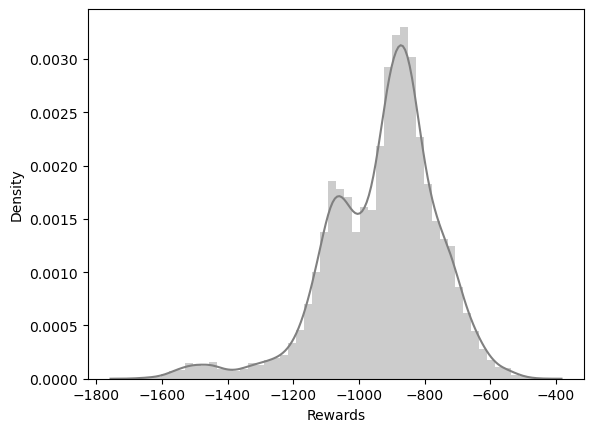

In [7]:
# Plot distribution of final rewards by random policy
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards
sns.distplot(final_rewards_random, color= 'grey')
plt.xlabel('Rewards')
plt.show()

In [8]:
# Standardizing s_material data
scaler = StandardScaler() # Fit scaler
print('before scaling:', s_material_inputs)
scaler.fit(s_material_inputs)
s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float()
print('after scaling:', s_material_inputs_scaled)

before scaling: tensor([[3.0000, 0.5929, 0.5064,  ..., 0.0000, 0.5828, 0.1154],
        [2.0000, 0.7169, 0.6470,  ..., 0.0000, 0.5828, 0.1417],
        [2.0000, 0.7169, 0.6470,  ..., 0.0000, 0.5828, 0.1417],
        ...,
        [2.0000, 0.7906, 0.7591,  ..., 0.0000, 0.2135, 0.0400],
        [1.0000, 1.0000, 1.0000,  ..., 1.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]])
after scaling: tensor([[ 0.9227, -0.0070, -0.1516,  ..., -0.5588,  2.2970,  2.4886],
        [ 0.1674,  0.3452,  0.2507,  ..., -0.5588,  2.2970,  3.1951],
        [ 0.1674,  0.3452,  0.2507,  ..., -0.5588,  2.2970,  3.1951],
        ...,
        [ 0.1674,  0.5548,  0.5717,  ..., -0.5588,  0.4249,  0.4583],
        [-0.5879,  1.1500,  1.2609,  ...,  1.7896, -0.6570, -0.6194],
        [-1.3432, -1.6924, -1.6008,  ..., -0.5588, -0.6570, -0.6194]])


In [9]:
# Train-validation split
def train_validation_split(s_material_inputs_scaled, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets, valid_size = 0.2):
    '''
    Args:
    s_material_inputs_scaled
    s_step_inputs
    a_elem_inputs
    a_comp_inputs
    Q_targets
    valid_size: Float (0-1). Size of validation set

    Returns:
    s_material_inputs_train 
    s_step_inputs_train     
    a_elem_inputs_train     
    a_comp_inputs_train     
    Q_targets_train   
    s_material_inputs_valid 
    s_step_inputs_valid 
    a_elem_inputs_valid
    a_comp_inputs_valid 
    Q_targets_valid
  
    '''
    max_idx = s_material_inputs_scaled.shape[0] # Find size of dataset
    idx = [x for x in range(max_idx)] # Generate indices
    random.shuffle(idx) # Shuffle order idx 
    split = int(round(max_idx*(1-valid_size)))
    train_idx, valid_idx = idx[:split], idx[split:] # Split indices

    s_material_inputs_train = s_material_inputs_scaled[train_idx] # Use scaled s_material
    s_step_inputs_train     = s_step_inputs[train_idx]
    a_elem_inputs_train     = a_elem_inputs[train_idx]
    a_comp_inputs_train     = a_comp_inputs[train_idx]
    Q_targets_train         = Q_targets[train_idx]

    s_material_inputs_valid = s_material_inputs_scaled[valid_idx] # Use scaled s_material
    s_step_inputs_valid     = s_step_inputs[valid_idx]
    a_elem_inputs_valid     = a_elem_inputs[valid_idx]
    a_comp_inputs_valid     = a_comp_inputs[valid_idx]
    Q_targets_valid         = Q_targets[valid_idx]

    return s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid

s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid \
= train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                    s_step_inputs = s_step_inputs, 
                                    a_elem_inputs = a_elem_inputs,
                                    a_comp_inputs = a_comp_inputs,
                                    Q_targets = Q_targets,
                                    valid_size = 0.2)

print('TRAIN SIZES:')
print('s_material_inputs_train:', s_material_inputs_train.shape)
print('s_step_inputs_train:', s_step_inputs_train.shape)
print('a_elem_inputs_train:', a_elem_inputs_train.shape)
print('a_comp_inputs_train:', a_comp_inputs_train.shape)
print('Q_targets_train:', Q_targets_train.shape)
print('')
print('VALIDATION SIZES:')
print('s_material_inputs_valid:', s_material_inputs_valid.shape)
print('s_step_inputs_valid:', s_step_inputs_valid.shape)
print('a_elem_inputs_valid:', a_elem_inputs_valid.shape)
print('a_comp_inputs_valid:', a_comp_inputs_valid.shape)
print('Q_targets_valid:', Q_targets_valid.shape)

TRAIN SIZES:
s_material_inputs_train: torch.Size([40000, 145])
s_step_inputs_train: torch.Size([40000, 5])
a_elem_inputs_train: torch.Size([40000, 80])
a_comp_inputs_train: torch.Size([40000, 10])
Q_targets_train: torch.Size([40000, 1])

VALIDATION SIZES:
s_material_inputs_valid: torch.Size([10000, 145])
s_step_inputs_valid: torch.Size([10000, 5])
a_elem_inputs_valid: torch.Size([10000, 80])
a_comp_inputs_valid: torch.Size([10000, 10])
Q_targets_valid: torch.Size([10000, 1])


Here we train DQN using ONLY data generated by random policy.

In [7]:
# Initialize Q network
dqn = DQN_pytorch()

def train_DQN(dqn, num_epoch, s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train ,s_material_inputs_valid ,s_step_inputs_valid ,a_elem_inputs_valid ,a_comp_inputs_valid ,Q_targets_valid):
    '''
    Trains DQN and prints: 1. training loss 2. validation loss

    Args:
    dqn: DQN
    num_epoch: Int. Number of training epochs 
    s_material_inputs_train
    s_step_inputs_train
    a_elem_inputs_train
    a_comp_inputs_train
    Q_targets_train
    s_material_inputs_valid
    s_step_inputs_valid
    a_elem_inputs_valid
    a_comp_inputs_valid
    Q_targets_valid

    Returns:
    Updated dqn
    train_loss_list
    valid_loss_list
    '''
    train_loss_list = []
    valid_loss_list = []

    # Train Q network
    optimizer = torch.optim.Adam(dqn.parameters(), lr=1e-2)
    loss_func = torch.nn.SmoothL1Loss().float()

    # start = time.time()

    for epoch in range(num_epoch):
        # Train loss
        prediction_train = dqn(s_material = s_material_inputs_train, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_train,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_train,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_train,  # torch.Size([batch_size,10])
                        )                    # Input x and predict based on x
        train_loss       = loss_func(prediction_train.float(), Q_targets_train.float()).float()   # Must be (1. nn output, 2. target)
        optimizer.zero_grad()   # Clear gradients for next train
        train_loss.backward()         # Backpropagation, compute gradients
        optimizer.step()        # Apply gradients

        # Validation loss
        prediction_valid = dqn(s_material = s_material_inputs_valid, # torch.Size([batch_size, 145]) and must be .float() !!!
                        s_step      = s_step_inputs_valid,     # torch.Size([batch_size,5])
                        a_elem      = a_elem_inputs_valid,     # torch.Size([batch_size,80])
                        a_comp      = a_comp_inputs_valid,  # torch.Size([batch_size,10]))
                        )
        valid_loss = loss_func(prediction_valid.float(), Q_targets_valid.float()).float()   # Must be (1. nn output, 2. target)
        train_loss_list.append(train_loss.detach().numpy())
        valid_loss_list.append(valid_loss.detach().numpy())

        print('Epoch = ', epoch, 'Train_loss = %.4f' % train_loss.data.numpy(), 'Valid_loss = %.4f' % valid_loss.data.numpy())
    # end = time.time()
    # print('time taken for batch:', end - start)
    
    return dqn, train_loss_list, valid_loss_list
dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
 a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
 s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
 a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid)

Epoch =  0 Train_loss = 760.7088 Valid_loss = 758.3725
Epoch =  1 Train_loss = 759.7332 Valid_loss = 756.6217
Epoch =  2 Train_loss = 757.9740 Valid_loss = 753.6631
Epoch =  3 Train_loss = 754.9986 Valid_loss = 749.1429
Epoch =  4 Train_loss = 750.4500 Valid_loss = 742.6977
Epoch =  5 Train_loss = 743.9626 Valid_loss = 733.9310
Epoch =  6 Train_loss = 735.1364 Valid_loss = 722.4000
Epoch =  7 Train_loss = 723.5253 Valid_loss = 707.6273
Epoch =  8 Train_loss = 708.6481 Valid_loss = 689.0858
Epoch =  9 Train_loss = 689.9734 Valid_loss = 666.2026
Epoch =  10 Train_loss = 666.9235 Valid_loss = 638.3636
Epoch =  11 Train_loss = 638.8793 Valid_loss = 604.9020
Epoch =  12 Train_loss = 605.1691 Valid_loss = 565.1130
Epoch =  13 Train_loss = 565.0704 Valid_loss = 518.5364
Epoch =  14 Train_loss = 518.0952 Valid_loss = 467.8072
Epoch =  15 Train_loss = 466.7300 Valid_loss = 425.2879
Epoch =  16 Train_loss = 424.1146 Valid_loss = 393.3237
Epoch =  17 Train_loss = 393.0590 Valid_loss = 361.1027
Ep

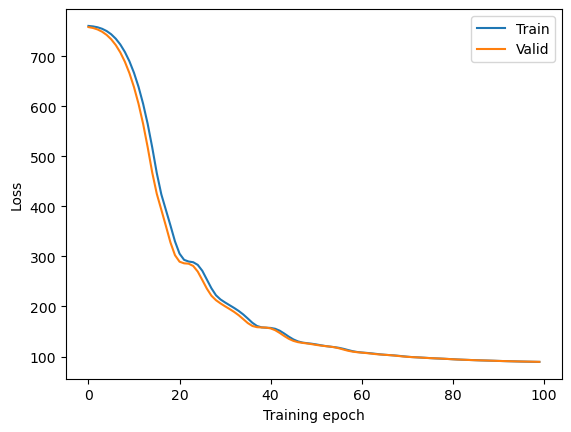

In [8]:
# Plot train and valid losses
plt.figure()
plt.plot(range(0,100), train_loss_list, label = 'Train')
plt.plot(range(0,100), valid_loss_list, label = 'Valid')
plt.legend()
# plt.ylim(130,170)
plt.xlabel('Training epoch')
plt.ylabel('Loss')
# plt.savefig('plots/train_valid_loss.png', dpi = 300)
plt.show()

In [10]:
def ranked_max_actions(state, dqn, n_actions = len(element_set)*len(comp_set)):
    """
    Returns a list of ranked actions based on Q-network prodictions

    Args:
    state: List [s_material, s_step] where s_material is the string representation of material and s_step is the integer step number
    dqn: Q-network for Q-value prediction

    Returns:
    ranked_max_actions: List [[s_material, s_step, Q-value]
                              ...
                              [s_material, s_step, Q-value]
                              ]
    where s_material is the one-hot torch.tensor.float() of material and
    s_step is the  one-hot torch.tensor.float()
    1st index corresponds to highest Q-value
    """

    s_material, s_step = state
    # s_material = torch.tensor(onehot_target(s_material)).float() # Get one-hot rep of s_material
    s_material = torch.tensor(featurize_target(s_material)).reshape(1, -1) # Get one-hot rep of s_material
    s_material = torch.tensor(scaler.transform(s_material)).reshape(-1).float()  # Standardize s_material
    s_step = torch.tensor(step_to_one_hot([s_step])[0]).float() # Get one-hot rep of s_step

    s_material_input = torch.stack([s_material]*n_actions)
    s_step_input = torch.stack([s_step]*n_actions)

    a_elem_input = []
    a_comp_input = []
    for elem in element_set:
        a_elem = torch.tensor(element_to_one_hot([elem])[0]).float()
        for comp in comp_set:
            a_comp = torch.tensor(comp_to_one_hot([comp])[0]).float()

            a_elem_input.append(a_elem)
            a_comp_input.append(a_comp)
    
    a_elem_input = torch.stack(a_elem_input).float()
    a_comp_input = torch.stack(a_comp_input).float()
    
    Q_pred = dqn(s_material = s_material_input, # torch.Size([batch_size, 40, 115]) and must be .float() !!!
                    s_step      = s_step_input,     # torch.Size([batch_size,5])
                    a_elem      = a_elem_input,     # torch.Size([batch_size,80])
                    a_comp      = a_comp_input,  # torch.Size([batch_size,10])

                )   
    # Rank according to Q-values
    Q_pred = Q_pred.detach().numpy()
    Q_pred = Q_pred.reshape(len(element_set)*len(comp_set))
    order = Q_pred.argsort()
    ranks = order.argsort() # ranks of Q-values, 0th index = lowest Q, last index = highest Q
    
    
    a_elem_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(element_set)])
    a_comp_input_ranked = torch.zeros([len(element_set)*len(comp_set), len(comp_set)])
    Q_pred_ranked = np.zeros(len(element_set)*len(comp_set))

    for rank in reversed(range(len(element_set)*len(comp_set))): # Start with most valuable
        rank_idx = ranks[rank] # rank_idx = final position
        rank_idx = (len(element_set)*len(comp_set) - 1) - rank_idx # Reverse rank_idx i.e. Want 0th index to correspond to max Q

        # Sort Q-values
        Q = Q_pred[rank]
        Q_pred_ranked[rank_idx] = Q

        # Sort a_elem according to Q-values
        a_elem = a_elem_input[rank]
        a_elem_input_ranked[rank_idx] = a_elem

        # Sort a_comp according to Q-values
        a_comp = a_comp_input[rank]
        a_comp_input_ranked[rank_idx] = a_comp

    # print('Max Q: ', max(Q_pred_ranked))
    # print('Min Q: ', min(Q_pred_ranked))

    return a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked

mat_1 = 'BaTiO3'
mat_2 = 'SrTiO3'

print('Material: {}'.format(mat_1))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_1, 1], dqn = dqn)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))
# print('')
print('')

print('Material: {}'.format(mat_2))
a_elem_input_ranked, a_comp_input_ranked, Q_pred_ranked = ranked_max_actions([mat_2, 1], dqn = dqn)
print('Q value of max action: ', Q_pred_ranked[0])
# print('max_a_elem: ', tuple(a_elem_input_ranked[0].tolist()))
# print('max_a_comp: ', tuple(a_comp_input_ranked[0].tolist()))

Material: BaTiO3
Q value of max action:  -865.29296875

Material: SrTiO3
Q value of max action:  -872.6747436523438


In [10]:
# Investigate weights of dqn
dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),

(tensor(-0.0019, grad_fn=<MeanBackward0>),
 tensor(0.2230, grad_fn=<MeanBackward0>),
 tensor(0.3512, grad_fn=<MeanBackward0>),
 tensor(0.3883, grad_fn=<MeanBackward0>))

In [11]:
# For testing the DQN function
# s_material = torch.tensor(onehot_target('BaTiO3'))
s_material = torch.tensor(scaler.transform(torch.tensor(featurize_target('BaTiO3')).reshape(1,-1))).float()
# s_material = s_material.reshape(1, s_material.shape[0])
# print(s_material.shape)

s_step = torch.zeros(5)
s_step[3] = 1.
s_step = s_step.reshape(1, s_step.shape[0])
# print(s_step.shape)

a_elem = torch.zeros(80)
a_elem[2] = 1.
a_elem = a_elem.reshape(1, a_elem.shape[0])
# print(a_elem.shape)

a_comp = torch.zeros(10)
a_comp[1] = 1.
a_comp = a_comp.reshape(1, a_comp.shape[0])
# print(a_comp.shape)

output = dqn(s_material, s_step, a_elem, a_comp)
print(output)
# print(output.shape)

tensor([[-962.5410]], grad_fn=<AddmmBackward>)


In [11]:
env = MaterialEnvironment(element_set = element_set,
                          comp_set =  comp_set,)

def generate_max_act(state, dqn, stochastic_top_frac = 0):
    '''
    Generates max action.
    Args:
    state: state
    dqn: Q-network
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: max_a_elem, max_a_comp
    '''
    a_elem_input_ranked, a_comp_input_ranked, _ = ranked_max_actions(state = state, dqn = dqn, n_actions = len(element_set)*len(comp_set))
    
    tot_num_actions = len(a_elem_input_ranked)
    if stochastic_top_frac != 0: # if stochastic
        act_idx = stochastic_top_frac*tot_num_actions # cut-off index
        rank = np.random.randint(0,round(act_idx)) # take top stochastic_top_frac fraction of ranked actions
    else: # deterministic
        rank = 0 # take top action (index 0)
    max_a_elem = a_elem_input_ranked[rank] # 0th index corresponds to max
    max_a_comp = a_comp_input_ranked[rank] # 0th index corresponds to max
    max_a_elem = tuple(max_a_elem.tolist())
    max_a_comp = tuple(max_a_comp.tolist())
    action = [max_a_elem, max_a_comp]

    return action

def generate_ep_with_dqn(dqn, max_steps = 5, epsilon = 0, stochastic_top_frac = 0):
    '''
    Generates an episode with trained DQN
    
    Args:
    dqn: Q-network for Q-value prediction
    max_steps: Int
    epsilon: Float. Probability of taking random action 
    stochastic_top_frac: Int (0-1). action choosen from the top n fraction of ranked actions. Default = 0. 
                         e.g. stochastic_top_frac = 0.1 corresponds to choosing from top 10% of action

    Returns: 
    env.path (an episode): List of SAR data in the form of [[material, step], [element, composition], reward]
    final_compound: Str.
    
    '''
    env.initialize()

    for i in range(max_steps):
        # if i == 0: # if start of episode, choose random first element #########################
        #     action = generate_random_act()

        # else: # elif not start of episode, take greedy action
        #     # Max action
        #     action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn)
        if np.random.uniform(0,1) > epsilon:
            action = generate_max_act(state = [env.state, env.counter+1], dqn = dqn, stochastic_top_frac = stochastic_top_frac)
        else:
            action = generate_random_act()
        # Take step with action
        env.step(action)
        final_compound = env.state
        # print('step:', env.counter)
        # print('state:',final_compound)
        # print('reward:',env.reward())
        # print(env.num_steps_taken)
        # print('')
    return env.path, final_compound
ep, final_compound = generate_ep_with_dqn(dqn = dqn)
final_compound

'Bi7'

In [12]:
# ========= FOR TRAINED POLICY ===========
def generate_Q_datapoints_and_evaluate_policy(dqn, num_eps, epsilon):
    '''
    Generates 1) Q datapoints for training 2) List of final rewards using a DQN.

    Args:
    dqn: Q-netowrk
    num_eps: Int. Number of episodes to run.
    epsilon: Float. Probability of taking a random action

    Returns:
    Q_data_trained: List of Q datapoints for training
    final_rewards_trained: List of corresponding final rewards
    final_compounds: List (of Str) of final compounds
    '''
    # start = time.time()

    # Generate episodes with DQN
    episodes = []
    final_compounds = []
    for j in range(num_eps):
        episode, final_compound = generate_ep_with_dqn(dqn, max_steps = 5, epsilon = epsilon, stochastic_top_frac = 0.20)
        episodes.append(episode)
        final_compounds.append(final_compound)

    Q_data_trained = []
    # Extract Q_data from episodes
    for episode in episodes:
        Q_data = extract_data_from_ep(episode)
        Q_data_trained.append(Q_data)

    # end = time.time()
    # print('time taken:', end - start)

    # Save Q_data
    # with open('./data/Q_data_trained_RF.pkl', 'wb') as f:
    #     pickle.dump(Q_data_trained, f, pickle.HIGHEST_PROTOCOL)

    # # Load Q_data_random
    # with open('./data/Q_data_trained_RF.pkl', 'rb') as f:
    #     Q_data_trained = pickle.load(f)

    # print('Number of episodes generated by agent trained on random policy data:', len(Q_data_trained))

    # Extract final rewards from episode data
    Q_targets_trained         = []

    for episode in Q_data_trained:
        for step in episode:
            # state, action, reward = step
            _, _, Q_target = step
            Q_target = torch.tensor([Q_target])
            Q_targets_trained.append(Q_target)

    Q_targets_trained = torch.stack(Q_targets_trained)
    # print('Q_targets:', Q_targets_trained.shape)
    final_rewards_trained = Q_targets_trained[0::5].reshape(-1) # Find final rewards, index of 5 since length of each episode is 5

    return Q_data_trained, final_rewards_trained, final_compounds

Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 20, epsilon = 0)
print(len(Q_data_trained))
print(len(final_rewards_trained))
print(final_compounds)

20
20
['As2Ge7Ge5Se7Cu1', 'Sb5Cu5Sn1As1', 'Ga4Yb4Sn6Bi9', 'Cd8Br2P3', 'Cu5Cd8Tl4', 'Ga9P6Cu5Pb7', 'Sb7Se9Sn6Te2', 'P4Se8Br5P1Yb5', 'Cu2Tl6Se9', 'Sb4Se5Tl7Pd3Ge9', 'Br3Cd6Sb4Zn9', 'Br4Sb8Te9Sb4', 'Tl7Zn5Rb8Ga7', 'Zn2Tl6Cu3Tl9Dy5', 'Te7Te7Ga5Ga9Cd9', 'Cd3Sn6Cu5', 'Ga1Ge6Ge4', 'Cu3Sn6P2', 'Ga6Cu9Yb5Cu9', 'Br6Pb6Se7Pd2']


As shown in the plot below, an agent trained based on just data generated by a random policy can improve the distribution of rewards.

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


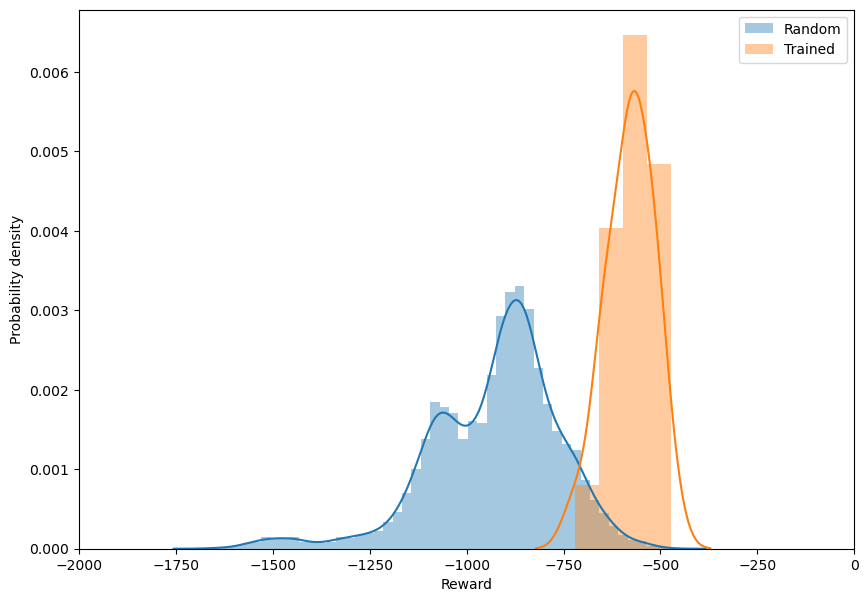

In [13]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained')
plt.ylabel('Probability density')
plt.xlabel('Reward')
# plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist.png', dpi = 300)
plt.show()

# Deep Reinforcement Learning
We now close the RL loop by training the agent on data generated by increasingly greedy policies. 

In [15]:
replay_buffer = collections.deque(maxlen = 50000)
Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 100, epsilon = 0)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_trained)

def update_replay_buffer(replay_buffer, s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets):
    '''
    Adds inputs into replay buffer
    Args:
    replay_buffer: collections.deque
    
    Returns: 
    updated replay buffer
    
    '''
    for s_material, s_step, a_elem, a_comp, Q_target in zip(s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets):
        Q_datapoint = [s_material, s_step, a_elem, a_comp, Q_target]
        replay_buffer.extend([Q_datapoint])
    
    return replay_buffer

replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
                                                            s_step_inputs = s_step_inputs, 
                                                            a_elem_inputs = a_elem_inputs, 
                                                            a_comp_inputs = a_comp_inputs, 
                                                                Q_targets = Q_targets)
print('Number of Q datapoints in replay buffer (5 per episode)', len(replay_buffer))

Number of Q datapoints in replay buffer (5 per episode) 500


In [16]:
def sample_replay_buffer(replay_buffer, n = 100):
    '''
    Samples datapoints from replay buffer for DQN training

    Args:
    replay_buffer: collections.deque
    n: Int. Number of datapoints to sample

    Returns:
    s_material_inputs: torch.tensor of Size([num of episodes in Q_data, 145])
    s_step_inputs: torch.tensor
    a_elem_inputs: torch.tensor
    a_comp_inputs: torch.tensor
    Q_targets: torch.tensor

    '''

    s_material_inputs = []
    s_step_inputs     = []
    a_elem_inputs     = []
    a_comp_inputs     = []
    Q_targets         = []

    for Q_datapoint in random.sample(replay_buffer, n):
        s_material, s_step, a_elem, a_comp, Q_target = Q_datapoint

        s_material = torch.tensor(s_material).float()
        s_step = torch.tensor(s_step)
        a_elem = torch.tensor(a_elem)
        a_comp = torch.tensor(a_comp)
        Q_target = torch.tensor([Q_target])

        s_material_inputs.append(s_material)
        s_step_inputs.append(s_step)
        a_elem_inputs.append(a_elem)
        a_comp_inputs.append(a_comp)
        Q_targets.append(Q_target)

    s_material_inputs = torch.stack(s_material_inputs)
    s_step_inputs = torch.stack(s_step_inputs)
    a_elem_inputs = torch.stack(a_elem_inputs)
    a_comp_inputs = torch.stack(a_comp_inputs)
    Q_targets = torch.stack(Q_targets)

    return s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets

s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)

print('s_material_inputs:', s_material_inputs.shape)
print('s_step_inputs:', s_step_inputs.shape)
print('a_elem_inputs:', a_elem_inputs.shape)
print('a_comp_inputs:', a_comp_inputs.shape)
print('Q_targets:', Q_targets.shape)
    

s_material_inputs: torch.Size([100, 145])
s_step_inputs: torch.Size([100, 5])
a_elem_inputs: torch.Size([100, 80])
a_comp_inputs: torch.Size([100, 10])
Q_targets: torch.Size([100, 1])


<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

### Training the DQN

In [17]:
num_iter = 500 # No. of training iterations
epsilon  = 0.99   # Initial epsilon
replay_buffer = collections.deque(maxlen = 50000) # Initialize replay buffer
dqn_save_freq = 10 # Save DQN model every n iterations
dqn = DQN_pytorch() # Initialize DQN
env = MaterialEnvironment(element_set = element_set, comp_set = comp_set,) # Initialize env

# Meta-data to store
final_rewards_vs_iter   = []
compounds_vs_iter       = []
train_loss_list_vs_iter = []
valid_loss_list_vs_iter = []
epsilon_vs_iter         = []

for iteration in tqdm(range(num_iter)):
    print('=========== TRAINING ITERATION %.0f ===========' % iteration)
    print('Current epsilon = ', epsilon)
    epsilon_vs_iter.append(epsilon)
    # 1. GENERATE Q DATAPOINTS & ADD TO REPLAY BUFFER
    print('A) GENERATING DATAPOINTS')
    Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 100, epsilon = epsilon) # Generate episodes and score them
    final_rewards_vs_iter.append(final_rewards_trained) # Save list of final reward
    compounds_vs_iter.append(final_compounds) # Save list of compounds generated at the end of each episode
    print('Average final reward = ', np.mean(np.array(final_rewards_trained)))
    print('Compounds generated:', final_compounds)
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_trained) # Processing to give inputs and targets for DQN
    replay_buffer = update_replay_buffer(replay_buffer = replay_buffer, s_material_inputs = s_material_inputs, 
                                                                s_step_inputs = s_step_inputs, 
                                                                a_elem_inputs = a_elem_inputs, 
                                                                a_comp_inputs = a_comp_inputs, 
                                                                    Q_targets = Q_targets)
    # 2. SAMPLE FROM REPLAY BUFFER, STANDARDIZE, TRAIN-VALIDATION SPLIT, TRAIN Q-NETWORK
    print('B) TRAINING Q-NETWORK')
    s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = sample_replay_buffer(replay_buffer = replay_buffer, n = 100)
    s_material_inputs_scaled = torch.tensor(scaler.transform(s_material_inputs)).float() # Standardize s_material_inputs
    s_material_inputs_train, s_step_inputs_train, a_elem_inputs_train, a_comp_inputs_train, Q_targets_train, s_material_inputs_valid, s_step_inputs_valid, a_elem_inputs_valid, a_comp_inputs_valid, Q_targets_valid \
    = train_validation_split(s_material_inputs_scaled = s_material_inputs_scaled, 
                                        s_step_inputs = s_step_inputs, 
                                        a_elem_inputs = a_elem_inputs,
                                        a_comp_inputs = a_comp_inputs,
                                        Q_targets = Q_targets,
                                        valid_size = 0.2) # Train-validation split of datapoints sampled from replay buffer
    dqn, train_loss_list, valid_loss_list = train_DQN(dqn =  dqn, num_epoch = 100, s_material_inputs_train = s_material_inputs_train, s_step_inputs_train = s_step_inputs_train,
    a_elem_inputs_train = a_elem_inputs_train, a_comp_inputs_train = a_comp_inputs_train, Q_targets_train = Q_targets_train,
    s_material_inputs_valid = s_material_inputs_valid, s_step_inputs_valid = s_step_inputs_valid, a_elem_inputs_valid = a_elem_inputs_valid,
    a_comp_inputs_valid = a_comp_inputs_valid, Q_targets_valid = Q_targets_valid) # Train DQN
    train_loss_list_vs_iter.append(train_loss_list) # Save list of training loss vs training epoch for this iter
    valid_loss_list_vs_iter.append(valid_loss_list) # Save list of validation loss vs training epoch for this iter

    if iteration in range(0, num_iter+1, dqn_save_freq): # Save DQN model every n iterations
        torch.save(dqn, './dqn_models/dqn_test_%.0fiter_RF' % iteration)

    epsilon *= 0.99 # Decay epsilon

with open('./training_data/final_rewards_vs_iter_RF.pkl', 'wb') as f:
        pickle.dump(final_rewards_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/compounds_vs_iter_RF.pkl', 'wb') as f:
        pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/train_loss_list_vs_iter_RF.pkl', 'wb') as f:
        pickle.dump(train_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/valid_loss_list_vs_iter_RF.pkl', 'wb') as f:
        pickle.dump(valid_loss_list_vs_iter, f, pickle.HIGHEST_PROTOCOL)

with open('./training_data/epsilon_vs_iter_RF.pkl', 'wb') as f:
        pickle.dump(epsilon_vs_iter, f, pickle.HIGHEST_PROTOCOL)

  0%|          | 0/500 [00:00<?, ?it/s]

=========== TRAINING ITERATION 0 ===========
Current epsilon =  0.99
A) GENERATING DATAPOINTS
Average final reward =  -915.1424
Compounds generated: ['Cr2Mn5Pd8', 'Rb2Y2Sr3Ni7', 'Ge6Se8Th4Er9Se2', 'Br5Cl8Cu3Sb1H9', 'Sm5Rb4Th2Cl4Si5', 'Ru8Br1Ti7Nb6Ti3', 'O9Tm8Mn2Lu6Rb4', 'Lu5Cl1Ca4Ga1As5', 'Os8Ti6Re3Pd9Zn5', 'Ga9Gd6O2Au5', 'Nd5Zr3Sc3Pu4Be5', 'Ge3Ho3Sn8Cl3Tl5', 'Na5Na1Mg9Ru4Pb6', 'Hg2Na2Th7K8In1', 'Ni7Hf8Pb5Mo6', 'Pb5Pu2Cd4Ir5', 'In1Os8Au7Br7Os4', 'N5Br5Tb2Ti1Ce5', 'La1Au9S5H2Sb1', 'S1Se8Ni6N1Be4', 'Cs4Pu5H9Ce2', 'Ca8Ir8Br1', 'Sn6Pd4U4I8Pr5', 'Ho3Al1Te5Am9', 'Pd9Ta4H7La9', 'Tl5Nb4Nb6', 'Pt2O9Ba2Ag3', 'Ti8P1Dy7Gd5', 'Cl7Sn2Sc9La3', 'Cl8Tm4Sn2Na8Cu7', 'Ir4F7Pu4Te3P8', 'Bi6Be2Sb5Pd6Cs4', 'Am5Cs7Sr2H2', 'Er3As2Na6Br5', 'Be9Mo8S6Tl8As7', 'Cs7Pt8Mg7H7Pd6', 'Cu2Cr6Os1Se5C1', 'Sn9Nb6Zn1Ag8Ce8', 'Zr7W5Ce6Ni4Au5', 'Na9Te6Pr7Ba9', 'La4Ni9Ge5U8Co8', 'Yb9In7I8H9Pr2', 'Nd2Ce5V3Au4Yb7', 'B3Pu2Rb6Be7Th2', 'B7Er4Au1Ru2Sm3', 'Dy9Yb8Pt5Ca7K3', 'Rb4Cu5Rh8Ru6S4', 'Cd8Bi2Ga8Sm2Sb5', 'Pd5Ho9Ta2Se2Zn7', 'C9Tl9C

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 58.6251 Valid_loss = 70.4686
Epoch =  61 Train_loss = 57.0518 Valid_loss = 70.3574
Epoch =  62 Train_loss = 55.2691 Valid_loss = 71.6787
Epoch =  63 Train_loss = 52.5544 Valid_loss = 74.3525
Epoch =  64 Train_loss = 50.1830 Valid_loss = 77.8008
Epoch =  65 Train_loss = 49.4446 Valid_loss = 78.5462
Epoch =  66 Train_loss = 47.9666 Valid_loss = 77.0780
Epoch =  67 Train_loss = 46.4049 Valid_loss = 76.7050
Epoch =  68 Train_loss = 45.2685 Valid_loss = 76.9334
Epoch =  69 Train_loss = 44.3530 Valid_loss = 77.5170
Epoch =  70 Train_loss = 43.3382 Valid_loss = 78.0627
Epoch =  71 Train_loss = 42.2099 Valid_loss = 78.3465
Epoch =  72 Train_loss = 40.9403 Valid_loss = 77.9544
Epoch =  73 Train_loss = 39.4394 Valid_loss = 77.7442
Epoch =  74 Train_loss = 38.0873 Valid_loss = 78.1335
Epoch =  75 Train_loss = 36.6301 Valid_loss = 77.4390
Epoch =  76 Train_loss = 35.5348 Valid_loss = 77.2523
Epoch =  77 Train_loss = 34.7301 Valid_loss = 76.3853
Epoch =  78 Train_loss = 33.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  56 Train_loss = 21.3483 Valid_loss = 77.2981
Epoch =  57 Train_loss = 20.3751 Valid_loss = 77.5952
Epoch =  58 Train_loss = 20.6320 Valid_loss = 78.6810
Epoch =  59 Train_loss = 18.7998 Valid_loss = 82.1999
Epoch =  60 Train_loss = 19.3706 Valid_loss = 81.6117
Epoch =  61 Train_loss = 19.3386 Valid_loss = 81.2541
Epoch =  62 Train_loss = 18.3074 Valid_loss = 79.0324
Epoch =  63 Train_loss = 20.9430 Valid_loss = 80.5214
Epoch =  64 Train_loss = 21.1781 Valid_loss = 80.5322
Epoch =  65 Train_loss = 17.9376 Valid_loss = 80.1159
Epoch =  66 Train_loss = 21.5298 Valid_loss = 82.4452
Epoch =  67 Train_loss = 19.3661 Valid_loss = 85.0626
Epoch =  68 Train_loss = 21.4754 Valid_loss = 83.0689
Epoch =  69 Train_loss = 19.4825 Valid_loss = 82.6853
Epoch =  70 Train_loss = 21.9308 Valid_loss = 84.6974
Epoch =  71 Train_loss = 17.2195 Valid_loss = 87.8886
Epoch =  72 Train_loss = 20.9407 Valid_loss = 85.9647
Epoch =  73 Train_loss = 16.3646 Valid_loss = 82.9411
Epoch =  74 Train_loss = 19

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 17.3859 Valid_loss = 144.0699
Epoch =  52 Train_loss = 13.3460 Valid_loss = 142.0366
Epoch =  53 Train_loss = 12.5239 Valid_loss = 143.4159
Epoch =  54 Train_loss = 12.5400 Valid_loss = 147.2275
Epoch =  55 Train_loss = 17.9585 Valid_loss = 147.1683
Epoch =  56 Train_loss = 12.7011 Valid_loss = 146.2219
Epoch =  57 Train_loss = 12.1645 Valid_loss = 144.6690
Epoch =  58 Train_loss = 15.8379 Valid_loss = 140.7921
Epoch =  59 Train_loss = 12.5461 Valid_loss = 140.8956
Epoch =  60 Train_loss = 14.8569 Valid_loss = 145.9350
Epoch =  61 Train_loss = 14.5245 Valid_loss = 147.2947
Epoch =  62 Train_loss = 11.8166 Valid_loss = 146.5532
Epoch =  63 Train_loss = 12.2523 Valid_loss = 146.6660
Epoch =  64 Train_loss = 11.1129 Valid_loss = 145.1237
Epoch =  65 Train_loss = 10.8428 Valid_loss = 145.9991
Epoch =  66 Train_loss = 9.0034 Valid_loss = 147.2190
Epoch =  67 Train_loss = 11.0401 Valid_loss = 145.0114
Epoch =  68 Train_loss = 11.0598 Valid_loss = 142.5697
Epoch =  69

  1%|          | 3/500 [00:07<21:35,  2.61s/it]

Epoch =  99 Train_loss = 13.0642 Valid_loss = 146.2225
=========== TRAINING ITERATION 3 ===========
Current epsilon =  0.96059601
A) GENERATING DATAPOINTS
Average final reward =  -919.5597
Compounds generated: ['N5U6Zr9Eu5', 'W4Ti1Cd7', 'Zn5Se3Se7Au8O1', 'Sr2Ag4Tl9B4', 'P5Hg5Nb7Ru2Sn5', 'N4Sc3P6Mn6Ce1', 'Mo3F4Hf5Cl9Rh6', 'As4Os4Zr1Ca3Al2', 'B3In2Cl3Sn7', 'U8Ge3B1Hg7Al1', 'Os6Ti5Er7P5Tb6', 'Ta1Cr5Re2Ga4Cr4', 'Na3Na3Pr3Nd3', 'Th8Gd9Os8Bi6', 'W3Bi4Al1Zn4', 'Be3Sm6Ga6Pr4Tl1', 'W2Bi3Cr7F3C4', 'Eu4Al6Ir2Ba4', 'Sb4Ba9Ti3Ge7Cr2', 'Ce1Au8Sb3U9', 'Pt8Am8As3Tb1', 'Tb6Nd8Li1Zn8Ho2', 'Y1Fe3Ho2Cl9N9', 'Ru9Na2Sr6Si3Cd6', 'Cs6Hg6F5Zr2Eu1', 'Fe9Tm4Ir8C4', 'H2Si3Pr9Eu9Ni6', 'Sr7Pd9Pt7Ho2', 'Al5Te3Pt4Au6', 'S3Rb3Ga8', 'Mg7Er5Cu6F9', 'Ta7Ti8Al7Y1', 'Hg6Nb2Cd8Na4Ba2', 'Eu6Si8Pt7Dy8', 'Mo9Be7Sr3Rh5Na9', 'Mg6Eu2C6', 'Cu8Fe9Os5U2F8', 'U3Sb5Mn1C5', 'Lu6Tm1Ru3Rb8', 'La4O9Ni1Lu7Cl3', 'Mn2U6Pt9', 'In5Be4Al1Co8Ca5', 'Ru3Br6Cr1Sm3Ge8', 'Mg1Sm2Nb6', 'Eu7Pt8Ta5S1Ge9', 'P7Nd7Tm7Ir1', 'Cd1Br1Bi6Sr1', 'U8Na9As6Au7', 'Pu

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 129.5284
Epoch =  71 Train_loss = 18.0792 Valid_loss = 127.8295
Epoch =  72 Train_loss = 21.5621 Valid_loss = 129.4268
Epoch =  73 Train_loss = 17.3778 Valid_loss = 131.9066
Epoch =  74 Train_loss = 21.2087 Valid_loss = 131.1296
Epoch =  75 Train_loss = 20.0017 Valid_loss = 129.3491
Epoch =  76 Train_loss = 16.8810 Valid_loss = 129.5644
Epoch =  77 Train_loss = 17.6493 Valid_loss = 132.3048
Epoch =  78 Train_loss = 16.7721 Valid_loss = 132.3455
Epoch =  79 Train_loss = 14.6585 Valid_loss = 130.2876
Epoch =  80 Train_loss = 18.0437 Valid_loss = 131.6791
Epoch =  81 Train_loss = 15.4456 Valid_loss = 134.2005
Epoch =  82 Train_loss = 17.4467 Valid_loss = 135.7450
Epoch =  83 Train_loss = 15.3882 Valid_loss = 133.6580
Epoch =  84 Train_loss = 15.8289 Valid_loss = 134.2855
Epoch =  85 Train_loss = 15.7961 Valid_loss = 136.8627
Epoch =  86 Train_loss = 13.1010 Valid_loss = 136.8903
Epoch =  87 Train_loss = 14.6924 Valid_loss = 135.2146
Epoch =  88 Train_loss = 12.6811 Valid_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  78 Train_loss = 8.1850 Valid_loss = 130.9964
Epoch =  79 Train_loss = 6.8637 Valid_loss = 129.2437
Epoch =  80 Train_loss = 9.3493 Valid_loss = 135.5461
Epoch =  81 Train_loss = 6.9980 Valid_loss = 134.4306
Epoch =  82 Train_loss = 5.3771 Valid_loss = 130.7212
Epoch =  83 Train_loss = 6.7126 Valid_loss = 135.2571
Epoch =  84 Train_loss = 6.3669 Valid_loss = 134.6553
Epoch =  85 Train_loss = 5.2015 Valid_loss = 133.1462
Epoch =  86 Train_loss = 6.2070 Valid_loss = 138.6272
Epoch =  87 Train_loss = 7.8295 Valid_loss = 133.8925
Epoch =  88 Train_loss = 5.4566 Valid_loss = 130.1877
Epoch =  89 Train_loss = 5.9405 Valid_loss = 134.3690
Epoch =  90 Train_loss = 5.0495 Valid_loss = 132.1291
Epoch =  91 Train_loss = 6.9846 Valid_loss = 137.3066
Epoch =  92 Train_loss = 6.4540 Valid_loss = 134.8993
Epoch =  93 Train_loss = 4.8960 Valid_loss = 130.9635
Epoch =  94 Train_loss = 5.4111 Valid_loss = 138.3672
Epoch =  95 Train_loss = 9.1425 Valid_loss = 135.6835
Epoch =  96 Train_loss = 6.8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 14.7602 Valid_loss = 155.0254
Epoch =  73 Train_loss = 18.0438 Valid_loss = 155.7731
Epoch =  74 Train_loss = 14.8041 Valid_loss = 155.1273
Epoch =  75 Train_loss = 17.0478 Valid_loss = 150.8864
Epoch =  76 Train_loss = 15.9587 Valid_loss = 150.7570
Epoch =  77 Train_loss = 14.7294 Valid_loss = 154.2822
Epoch =  78 Train_loss = 16.0182 Valid_loss = 154.3683
Epoch =  79 Train_loss = 13.9832 Valid_loss = 153.7390
Epoch =  80 Train_loss = 15.9171 Valid_loss = 153.2784
Epoch =  81 Train_loss = 12.8951 Valid_loss = 154.9972
Epoch =  82 Train_loss = 13.2721 Valid_loss = 153.7460
Epoch =  83 Train_loss = 15.1509 Valid_loss = 155.5951
Epoch =  84 Train_loss = 14.2154 Valid_loss = 155.6782
Epoch =  85 Train_loss = 13.0479 Valid_loss = 153.8504
Epoch =  86 Train_loss = 13.1793 Valid_loss = 153.9054
Epoch =  87 Train_loss = 13.3474 Valid_loss = 154.5754
Epoch =  88 Train_loss = 12.6705 Valid_loss = 155.6812
Epoch =  89 Train_loss = 11.9869 Valid_loss = 154.6830
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 26.4942 Valid_loss = 117.7839
Epoch =  63 Train_loss = 21.3029 Valid_loss = 111.2729
Epoch =  64 Train_loss = 29.3471 Valid_loss = 114.6771
Epoch =  65 Train_loss = 26.2566 Valid_loss = 125.3195
Epoch =  66 Train_loss = 24.9141 Valid_loss = 127.1993
Epoch =  67 Train_loss = 28.2549 Valid_loss = 118.3438
Epoch =  68 Train_loss = 20.0685 Valid_loss = 108.3902
Epoch =  69 Train_loss = 26.9450 Valid_loss = 110.7745
Epoch =  70 Train_loss = 21.9119 Valid_loss = 122.2712
Epoch =  71 Train_loss = 25.0579 Valid_loss = 124.5909
Epoch =  72 Train_loss = 25.3476 Valid_loss = 117.7300
Epoch =  73 Train_loss = 20.1215 Valid_loss = 113.5094
Epoch =  74 Train_loss = 23.8711 Valid_loss = 117.0008
Epoch =  75 Train_loss = 17.6280 Valid_loss = 124.3793
Epoch =  76 Train_loss = 24.7270 Valid_loss = 121.5482
Epoch =  77 Train_loss = 21.5876 Valid_loss = 112.0411
Epoch =  78 Train_loss = 23.0683 Valid_loss = 110.9605
Epoch =  79 Train_loss = 24.5919 Valid_loss = 118.5021
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 15.2153 Valid_loss = 137.6469
Epoch =  69 Train_loss = 13.4476 Valid_loss = 140.0518
Epoch =  70 Train_loss = 19.2054 Valid_loss = 139.1768
Epoch =  71 Train_loss = 16.1756 Valid_loss = 135.8697
Epoch =  72 Train_loss = 19.0588 Valid_loss = 135.6152
Epoch =  73 Train_loss = 18.2497 Valid_loss = 136.5285
Epoch =  74 Train_loss = 14.1845 Valid_loss = 137.1101
Epoch =  75 Train_loss = 14.3298 Valid_loss = 135.4758
Epoch =  76 Train_loss = 16.9009 Valid_loss = 136.6645
Epoch =  77 Train_loss = 13.8830 Valid_loss = 138.3755
Epoch =  78 Train_loss = 15.1473 Valid_loss = 137.1001
Epoch =  79 Train_loss = 11.2791 Valid_loss = 136.9951
Epoch =  80 Train_loss = 14.6262 Valid_loss = 138.5746
Epoch =  81 Train_loss = 11.7942 Valid_loss = 138.1205
Epoch =  82 Train_loss = 10.9382 Valid_loss = 137.5637
Epoch =  83 Train_loss = 11.9855 Valid_loss = 137.3645
Epoch =  84 Train_loss = 10.9739 Valid_loss = 136.8472
Epoch =  85 Train_loss = 11.4175 Valid_loss = 136.9240
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 35.5316 Valid_loss = 98.7141
Epoch =  70 Train_loss = 30.5991 Valid_loss = 102.7216
Epoch =  71 Train_loss = 32.2920 Valid_loss = 102.7673
Epoch =  72 Train_loss = 33.1742 Valid_loss = 98.8956
Epoch =  73 Train_loss = 26.2927 Valid_loss = 98.4682
Epoch =  74 Train_loss = 30.1769 Valid_loss = 102.1054
Epoch =  75 Train_loss = 25.3565 Valid_loss = 103.0240
Epoch =  76 Train_loss = 26.8819 Valid_loss = 99.7343
Epoch =  77 Train_loss = 24.5328 Valid_loss = 99.6663
Epoch =  78 Train_loss = 24.4182 Valid_loss = 102.7831
Epoch =  79 Train_loss = 25.2929 Valid_loss = 102.5033
Epoch =  80 Train_loss = 23.4670 Valid_loss = 103.0987
Epoch =  81 Train_loss = 24.2862 Valid_loss = 105.5382
Epoch =  82 Train_loss = 25.8229 Valid_loss = 103.0820
Epoch =  83 Train_loss = 22.0211 Valid_loss = 99.0453
Epoch =  84 Train_loss = 28.4018 Valid_loss = 98.4400
Epoch =  85 Train_loss = 27.4128 Valid_loss = 101.6982
Epoch =  86 Train_loss = 24.6649 Valid_loss = 102.4918
Epoch =  87 Train

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 12.5216 Valid_loss = 137.5196
Epoch =  74 Train_loss = 15.1877 Valid_loss = 139.5811
Epoch =  75 Train_loss = 10.9751 Valid_loss = 147.1932
Epoch =  76 Train_loss = 18.0687 Valid_loss = 145.8590
Epoch =  77 Train_loss = 15.5295 Valid_loss = 137.7217
Epoch =  78 Train_loss = 15.3727 Valid_loss = 137.5085
Epoch =  79 Train_loss = 16.3180 Valid_loss = 145.5289
Epoch =  80 Train_loss = 12.2020 Valid_loss = 146.7878
Epoch =  81 Train_loss = 13.4345 Valid_loss = 139.9798
Epoch =  82 Train_loss = 13.6323 Valid_loss = 137.6095
Epoch =  83 Train_loss = 15.0589 Valid_loss = 142.8772
Epoch =  84 Train_loss = 11.7335 Valid_loss = 145.8244
Epoch =  85 Train_loss = 13.6696 Valid_loss = 140.9933
Epoch =  86 Train_loss = 11.6756 Valid_loss = 139.0948
Epoch =  87 Train_loss = 13.5035 Valid_loss = 145.0984
Epoch =  88 Train_loss = 10.8090 Valid_loss = 143.8394
Epoch =  89 Train_loss = 9.3990 Valid_loss = 139.5379
Epoch =  90 Train_loss = 13.1818 Valid_loss = 143.0977
Epoch =  91

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 20.3931 Valid_loss = 89.9964
Epoch =  63 Train_loss = 15.2930 Valid_loss = 89.0593
Epoch =  64 Train_loss = 23.0336 Valid_loss = 90.3096
Epoch =  65 Train_loss = 17.9333 Valid_loss = 96.1134
Epoch =  66 Train_loss = 23.1315 Valid_loss = 95.7527
Epoch =  67 Train_loss = 22.6307 Valid_loss = 88.6091
Epoch =  68 Train_loss = 15.9322 Valid_loss = 86.2574
Epoch =  69 Train_loss = 21.1771 Valid_loss = 87.3179
Epoch =  70 Train_loss = 14.6489 Valid_loss = 90.8257
Epoch =  71 Train_loss = 18.1778 Valid_loss = 92.0264
Epoch =  72 Train_loss = 15.7767 Valid_loss = 91.5501
Epoch =  73 Train_loss = 19.2012 Valid_loss = 90.7520
Epoch =  74 Train_loss = 16.8439 Valid_loss = 92.8047
Epoch =  75 Train_loss = 15.8682 Valid_loss = 93.4996
Epoch =  76 Train_loss = 17.2455 Valid_loss = 92.3233
Epoch =  77 Train_loss = 13.3703 Valid_loss = 92.0267
Epoch =  78 Train_loss = 14.9743 Valid_loss = 91.9637
Epoch =  79 Train_loss = 11.7776 Valid_loss = 90.5603
Epoch =  80 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 28.0143 Valid_loss = 116.6296
Epoch =  63 Train_loss = 26.8644 Valid_loss = 116.5445
Epoch =  64 Train_loss = 25.2482 Valid_loss = 117.1377
Epoch =  65 Train_loss = 25.2808 Valid_loss = 120.5333
Epoch =  66 Train_loss = 26.0951 Valid_loss = 118.7680
Epoch =  67 Train_loss = 24.1916 Valid_loss = 116.3603
Epoch =  68 Train_loss = 25.8967 Valid_loss = 120.3482
Epoch =  69 Train_loss = 26.8903 Valid_loss = 118.7892
Epoch =  70 Train_loss = 24.4637 Valid_loss = 116.5680
Epoch =  71 Train_loss = 26.9431 Valid_loss = 118.8940
Epoch =  72 Train_loss = 23.6203 Valid_loss = 123.1108
Epoch =  73 Train_loss = 27.4616 Valid_loss = 121.3090
Epoch =  74 Train_loss = 22.5616 Valid_loss = 117.8897
Epoch =  75 Train_loss = 28.0754 Valid_loss = 118.0521
Epoch =  76 Train_loss = 22.3837 Valid_loss = 121.9273
Epoch =  77 Train_loss = 27.7528 Valid_loss = 120.1106
Epoch =  78 Train_loss = 24.0225 Valid_loss = 118.7054
Epoch =  79 Train_loss = 25.0438 Valid_loss = 120.2035
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 17.7531 Valid_loss = 76.3329
Epoch =  57 Train_loss = 15.0517 Valid_loss = 70.6850
Epoch =  58 Train_loss = 15.8017 Valid_loss = 70.9378
Epoch =  59 Train_loss = 13.1763 Valid_loss = 75.7876
Epoch =  60 Train_loss = 15.9554 Valid_loss = 74.5744
Epoch =  61 Train_loss = 12.0314 Valid_loss = 70.2503
Epoch =  62 Train_loss = 18.8484 Valid_loss = 72.1315
Epoch =  63 Train_loss = 15.7216 Valid_loss = 77.3416
Epoch =  64 Train_loss = 14.6407 Valid_loss = 77.0611
Epoch =  65 Train_loss = 14.6786 Valid_loss = 71.1207
Epoch =  66 Train_loss = 13.4310 Valid_loss = 70.1317
Epoch =  67 Train_loss = 12.6331 Valid_loss = 74.2449
Epoch =  68 Train_loss = 13.9360 Valid_loss = 73.1421
Epoch =  69 Train_loss = 12.4450 Valid_loss = 69.0105
Epoch =  70 Train_loss = 14.2151 Valid_loss = 69.4741
Epoch =  71 Train_loss = 12.6010 Valid_loss = 73.9974
Epoch =  72 Train_loss = 13.5810 Valid_loss = 74.7068
Epoch =  73 Train_loss = 12.9427 Valid_loss = 70.7884
Epoch =  74 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 15.9029 Valid_loss = 90.8028
Epoch =  72 Train_loss = 16.4536 Valid_loss = 93.7739
Epoch =  73 Train_loss = 9.3061 Valid_loss = 97.9417
Epoch =  74 Train_loss = 14.9608 Valid_loss = 95.4115
Epoch =  75 Train_loss = 7.9298 Valid_loss = 91.7452
Epoch =  76 Train_loss = 15.0897 Valid_loss = 92.0853
Epoch =  77 Train_loss = 13.0553 Valid_loss = 96.2984
Epoch =  78 Train_loss = 12.6362 Valid_loss = 96.7303
Epoch =  79 Train_loss = 12.4705 Valid_loss = 93.7814
Epoch =  80 Train_loss = 9.6256 Valid_loss = 93.1569
Epoch =  81 Train_loss = 9.8579 Valid_loss = 95.8722
Epoch =  82 Train_loss = 11.6439 Valid_loss = 94.9482
Epoch =  83 Train_loss = 10.1429 Valid_loss = 91.5050
Epoch =  84 Train_loss = 11.0451 Valid_loss = 92.0581
Epoch =  85 Train_loss = 11.3429 Valid_loss = 95.7502
Epoch =  86 Train_loss = 9.1073 Valid_loss = 96.4525
Epoch =  87 Train_loss = 9.2480 Valid_loss = 93.5957
Epoch =  88 Train_loss = 10.0699 Valid_loss = 93.7064
Epoch =  89 Train_loss = 8.0369 Va

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 15.3976 Valid_loss = 119.7009
Epoch =  61 Train_loss = 11.4687 Valid_loss = 119.9527
Epoch =  62 Train_loss = 9.1876 Valid_loss = 119.3197
Epoch =  63 Train_loss = 10.6672 Valid_loss = 123.6026
Epoch =  64 Train_loss = 12.1909 Valid_loss = 121.4593
Epoch =  65 Train_loss = 9.5805 Valid_loss = 119.4460
Epoch =  66 Train_loss = 11.3874 Valid_loss = 121.8948
Epoch =  67 Train_loss = 9.5698 Valid_loss = 119.4221
Epoch =  68 Train_loss = 9.1503 Valid_loss = 119.1412
Epoch =  69 Train_loss = 8.3757 Valid_loss = 119.6217
Epoch =  70 Train_loss = 7.0878 Valid_loss = 119.9431
Epoch =  71 Train_loss = 7.7345 Valid_loss = 121.7875
Epoch =  72 Train_loss = 8.3237 Valid_loss = 120.4967
Epoch =  73 Train_loss = 7.0801 Valid_loss = 118.4693
Epoch =  74 Train_loss = 7.6442 Valid_loss = 120.0138
Epoch =  75 Train_loss = 7.8878 Valid_loss = 118.5539
Epoch =  76 Train_loss = 7.6695 Valid_loss = 119.6393
Epoch =  77 Train_loss = 8.7803 Valid_loss = 117.4239
Epoch =  78 Train_loss 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 17.5510 Valid_loss = 98.2116
Epoch =  69 Train_loss = 14.2623 Valid_loss = 98.8526
Epoch =  70 Train_loss = 18.8886 Valid_loss = 98.7128
Epoch =  71 Train_loss = 13.6137 Valid_loss = 98.2728
Epoch =  72 Train_loss = 15.5172 Valid_loss = 98.7259
Epoch =  73 Train_loss = 15.4466 Valid_loss = 97.9884
Epoch =  74 Train_loss = 11.8208 Valid_loss = 99.0294
Epoch =  75 Train_loss = 14.5550 Valid_loss = 99.2298
Epoch =  76 Train_loss = 16.4857 Valid_loss = 98.5822
Epoch =  77 Train_loss = 13.3762 Valid_loss = 98.0843
Epoch =  78 Train_loss = 20.2202 Valid_loss = 98.5171
Epoch =  79 Train_loss = 18.7901 Valid_loss = 99.3233
Epoch =  80 Train_loss = 12.5666 Valid_loss = 100.5057
Epoch =  81 Train_loss = 14.6718 Valid_loss = 100.0650
Epoch =  82 Train_loss = 13.9984 Valid_loss = 98.9464
Epoch =  83 Train_loss = 11.5283 Valid_loss = 99.2627
Epoch =  84 Train_loss = 13.5045 Valid_loss = 98.4446
Epoch =  85 Train_loss = 10.8481 Valid_loss = 99.7107
Epoch =  86 Train_loss = 1

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Train_loss = 14.5638 Valid_loss = 102.6569
Epoch =  62 Train_loss = 11.6904 Valid_loss = 102.4438
Epoch =  63 Train_loss = 15.9913 Valid_loss = 102.2640
Epoch =  64 Train_loss = 13.9646 Valid_loss = 103.2655
Epoch =  65 Train_loss = 12.5294 Valid_loss = 103.6469
Epoch =  66 Train_loss = 13.8872 Valid_loss = 101.3765
Epoch =  67 Train_loss = 11.7351 Valid_loss = 100.5169
Epoch =  68 Train_loss = 11.6607 Valid_loss = 101.0907
Epoch =  69 Train_loss = 9.8778 Valid_loss = 102.2798
Epoch =  70 Train_loss = 9.3701 Valid_loss = 103.5414
Epoch =  71 Train_loss = 10.0083 Valid_loss = 102.9153
Epoch =  72 Train_loss = 8.3355 Valid_loss = 102.8437
Epoch =  73 Train_loss = 8.1263 Valid_loss = 102.5094
Epoch =  74 Train_loss = 7.8941 Valid_loss = 101.8472
Epoch =  75 Train_loss = 6.8309 Valid_loss = 102.1655
Epoch =  76 Train_loss = 7.7279 Valid_loss = 102.9884
Epoch =  77 Train_loss = 10.8017 Valid_loss = 103.7929
Epoch =  78 Train_loss = 8.2441 Valid_loss = 103.7430
Epoch =  79 Train_loss = 7.16

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 18.5417 Valid_loss = 140.6777
Epoch =  71 Train_loss = 11.0982 Valid_loss = 134.2209
Epoch =  72 Train_loss = 19.7230 Valid_loss = 133.0866
Epoch =  73 Train_loss = 19.2305 Valid_loss = 137.5014
Epoch =  74 Train_loss = 10.7368 Valid_loss = 140.7883
Epoch =  75 Train_loss = 16.0383 Valid_loss = 137.8971
Epoch =  76 Train_loss = 8.5357 Valid_loss = 135.3029
Epoch =  77 Train_loss = 15.3965 Valid_loss = 137.1071
Epoch =  78 Train_loss = 11.0142 Valid_loss = 141.5575
Epoch =  79 Train_loss = 15.6615 Valid_loss = 140.5499
Epoch =  80 Train_loss = 14.0299 Valid_loss = 134.9870
Epoch =  81 Train_loss = 12.5468 Valid_loss = 133.9121
Epoch =  82 Train_loss = 15.2122 Valid_loss = 137.2246
Epoch =  83 Train_loss = 9.3570 Valid_loss = 141.6242
Epoch =  84 Train_loss = 13.9261 Valid_loss = 139.8340
Epoch =  85 Train_loss = 9.0426 Valid_loss = 137.2395
Epoch =  86 Train_loss = 11.0915 Valid_loss = 138.8607
Epoch =  87 Train_loss = 6.8318 Valid_loss = 140.7868
Epoch =  88 Tr

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 14.9023 Valid_loss = 110.5099
Epoch =  68 Train_loss = 15.0454 Valid_loss = 109.9401
Epoch =  69 Train_loss = 14.5254 Valid_loss = 103.7646
Epoch =  70 Train_loss = 12.8359 Valid_loss = 102.0668
Epoch =  71 Train_loss = 12.7248 Valid_loss = 107.9182
Epoch =  72 Train_loss = 12.0760 Valid_loss = 106.3340
Epoch =  73 Train_loss = 9.3783 Valid_loss = 101.4922
Epoch =  74 Train_loss = 12.6275 Valid_loss = 105.2784
Epoch =  75 Train_loss = 9.4568 Valid_loss = 108.9964
Epoch =  76 Train_loss = 13.9015 Valid_loss = 104.2824
Epoch =  77 Train_loss = 8.0316 Valid_loss = 99.3529
Epoch =  78 Train_loss = 15.5995 Valid_loss = 99.8694
Epoch =  79 Train_loss = 11.5051 Valid_loss = 106.3091
Epoch =  80 Train_loss = 12.9528 Valid_loss = 106.4310
Epoch =  81 Train_loss = 10.4523 Valid_loss = 102.1728
Epoch =  82 Train_loss = 12.6370 Valid_loss = 102.4300
Epoch =  83 Train_loss = 8.8623 Valid_loss = 108.7906
Epoch =  84 Train_loss = 14.1706 Valid_loss = 108.1053
Epoch =  85 Trai

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 24.9024 Valid_loss = 123.2333
Epoch =  74 Train_loss = 20.0999 Valid_loss = 117.6179
Epoch =  75 Train_loss = 14.5553 Valid_loss = 115.1101
Epoch =  76 Train_loss = 20.0254 Valid_loss = 115.6686
Epoch =  77 Train_loss = 18.0117 Valid_loss = 119.7545
Epoch =  78 Train_loss = 14.9657 Valid_loss = 122.4644
Epoch =  79 Train_loss = 16.4457 Valid_loss = 121.3484
Epoch =  80 Train_loss = 12.3920 Valid_loss = 121.2631
Epoch =  81 Train_loss = 15.1886 Valid_loss = 122.9670
Epoch =  82 Train_loss = 12.8429 Valid_loss = 121.0782
Epoch =  83 Train_loss = 10.8226 Valid_loss = 118.2484
Epoch =  84 Train_loss = 12.9220 Valid_loss = 118.4239
Epoch =  85 Train_loss = 11.8142 Valid_loss = 121.3014
Epoch =  86 Train_loss = 11.2732 Valid_loss = 121.4752
Epoch =  87 Train_loss = 10.0163 Valid_loss = 120.4833
Epoch =  88 Train_loss = 12.7461 Valid_loss = 121.0483
Epoch =  89 Train_loss = 10.0845 Valid_loss = 119.2531
Epoch =  90 Train_loss = 9.4111 Valid_loss = 118.0616
Epoch =  91

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 80.3819
Epoch =  72 Train_loss = 17.4734 Valid_loss = 80.7080
Epoch =  73 Train_loss = 16.5706 Valid_loss = 83.5991
Epoch =  74 Train_loss = 13.9040 Valid_loss = 84.1911
Epoch =  75 Train_loss = 16.6681 Valid_loss = 81.4189
Epoch =  76 Train_loss = 11.0984 Valid_loss = 80.4149
Epoch =  77 Train_loss = 13.9880 Valid_loss = 83.0936
Epoch =  78 Train_loss = 11.0831 Valid_loss = 83.9971
Epoch =  79 Train_loss = 12.1718 Valid_loss = 81.6861
Epoch =  80 Train_loss = 12.4639 Valid_loss = 82.0792
Epoch =  81 Train_loss = 10.1022 Valid_loss = 84.6853
Epoch =  82 Train_loss = 14.8581 Valid_loss = 84.4298
Epoch =  83 Train_loss = 12.3643 Valid_loss = 81.3249
Epoch =  84 Train_loss = 13.4104 Valid_loss = 81.9581
Epoch =  85 Train_loss = 11.7757 Valid_loss = 84.0685
Epoch =  86 Train_loss = 11.9758 Valid_loss = 83.0158
Epoch =  87 Train_loss = 10.7060 Valid_loss = 80.5426
Epoch =  88 Train_loss = 11.9600 Valid_loss = 81.6866
Epoch =  89 Train_loss = 9.8536 Valid_loss = 83.9037
Epoch =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 12.2073 Valid_loss = 107.6068
Epoch =  76 Train_loss = 8.6886 Valid_loss = 109.0203
Epoch =  77 Train_loss = 8.5626 Valid_loss = 114.4344
Epoch =  78 Train_loss = 11.6409 Valid_loss = 112.4206
Epoch =  79 Train_loss = 9.5780 Valid_loss = 104.8854
Epoch =  80 Train_loss = 13.1376 Valid_loss = 104.6053
Epoch =  81 Train_loss = 13.1315 Valid_loss = 110.5928
Epoch =  82 Train_loss = 7.2719 Valid_loss = 113.5227
Epoch =  83 Train_loss = 10.7964 Valid_loss = 110.2544
Epoch =  84 Train_loss = 6.9685 Valid_loss = 106.8613
Epoch =  85 Train_loss = 8.1507 Valid_loss = 109.7491
Epoch =  86 Train_loss = 8.9712 Valid_loss = 108.8794
Epoch =  87 Train_loss = 6.3634 Valid_loss = 109.7885
Epoch =  88 Train_loss = 7.8867 Valid_loss = 112.9608
Epoch =  89 Train_loss = 10.8656 Valid_loss = 110.0019
Epoch =  90 Train_loss = 7.7069 Valid_loss = 109.4915
Epoch =  91 Train_loss = 5.4376 Valid_loss = 110.1447
Epoch =  92 Train_loss = 5.7121 Valid_loss = 107.8459
Epoch =  93 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 12.3282 Valid_loss = 111.4645
Epoch =  73 Train_loss = 10.3650 Valid_loss = 113.2012
Epoch =  74 Train_loss = 10.1489 Valid_loss = 111.9022
Epoch =  75 Train_loss = 11.6621 Valid_loss = 111.7914
Epoch =  76 Train_loss = 10.4584 Valid_loss = 111.2858
Epoch =  77 Train_loss = 8.9541 Valid_loss = 111.0175
Epoch =  78 Train_loss = 9.1742 Valid_loss = 112.1312
Epoch =  79 Train_loss = 9.9414 Valid_loss = 112.9672
Epoch =  80 Train_loss = 9.4082 Valid_loss = 110.5327
Epoch =  81 Train_loss = 9.3910 Valid_loss = 111.9847
Epoch =  82 Train_loss = 8.8213 Valid_loss = 111.1630
Epoch =  83 Train_loss = 8.0836 Valid_loss = 109.5781
Epoch =  84 Train_loss = 7.7989 Valid_loss = 112.9923
Epoch =  85 Train_loss = 10.4111 Valid_loss = 110.7176
Epoch =  86 Train_loss = 9.5885 Valid_loss = 109.3629
Epoch =  87 Train_loss = 9.4474 Valid_loss = 113.3704
Epoch =  88 Train_loss = 9.8599 Valid_loss = 110.6978
Epoch =  89 Train_loss = 8.4874 Valid_loss = 111.4211
Epoch =  90 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 13.9042 Valid_loss = 94.5340
Epoch =  75 Train_loss = 21.2528 Valid_loss = 92.1076
Epoch =  76 Train_loss = 18.5053 Valid_loss = 87.5867
Epoch =  77 Train_loss = 18.3455 Valid_loss = 86.2887
Epoch =  78 Train_loss = 11.9839 Valid_loss = 87.7541
Epoch =  79 Train_loss = 17.2586 Valid_loss = 88.7187
Epoch =  80 Train_loss = 15.0877 Valid_loss = 87.8730
Epoch =  81 Train_loss = 13.8101 Valid_loss = 92.4286
Epoch =  82 Train_loss = 13.9755 Valid_loss = 95.9481
Epoch =  83 Train_loss = 16.4559 Valid_loss = 91.3924
Epoch =  84 Train_loss = 10.9901 Valid_loss = 87.9714
Epoch =  85 Train_loss = 13.7247 Valid_loss = 91.7062
Epoch =  86 Train_loss = 17.3509 Valid_loss = 93.3735
Epoch =  87 Train_loss = 14.6604 Valid_loss = 88.1173
Epoch =  88 Train_loss = 13.9091 Valid_loss = 89.6542
Epoch =  89 Train_loss = 15.0996 Valid_loss = 93.4174
Epoch =  90 Train_loss = 13.7251 Valid_loss = 92.5424
Epoch =  91 Train_loss = 11.4589 Valid_loss = 86.9951
Epoch =  92 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 18.9906 Valid_loss = 134.2619
Epoch =  72 Train_loss = 20.2932 Valid_loss = 139.1891
Epoch =  73 Train_loss = 16.8081 Valid_loss = 148.4531
Epoch =  74 Train_loss = 23.3574 Valid_loss = 149.1153
Epoch =  75 Train_loss = 20.6356 Valid_loss = 143.0030
Epoch =  76 Train_loss = 20.1947 Valid_loss = 140.2405
Epoch =  77 Train_loss = 21.2826 Valid_loss = 144.7013
Epoch =  78 Train_loss = 14.4652 Valid_loss = 144.7110
Epoch =  79 Train_loss = 17.5528 Valid_loss = 137.8851
Epoch =  80 Train_loss = 16.8746 Valid_loss = 137.1141
Epoch =  81 Train_loss = 18.3052 Valid_loss = 143.6141
Epoch =  82 Train_loss = 14.9555 Valid_loss = 147.9729
Epoch =  83 Train_loss = 15.8980 Valid_loss = 145.4017
Epoch =  84 Train_loss = 14.0296 Valid_loss = 144.6945
Epoch =  85 Train_loss = 15.4359 Valid_loss = 148.5568
Epoch =  86 Train_loss = 16.0567 Valid_loss = 149.0657
Epoch =  87 Train_loss = 15.1045 Valid_loss = 145.4528
Epoch =  88 Train_loss = 12.2733 Valid_loss = 143.6481
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 16.9143 Valid_loss = 105.0625
Epoch =  59 Train_loss = 17.1336 Valid_loss = 104.1424
Epoch =  60 Train_loss = 14.7221 Valid_loss = 103.3053
Epoch =  61 Train_loss = 17.2786 Valid_loss = 102.5154
Epoch =  62 Train_loss = 16.2245 Valid_loss = 101.8996
Epoch =  63 Train_loss = 16.0397 Valid_loss = 102.2438
Epoch =  64 Train_loss = 13.7411 Valid_loss = 102.1038
Epoch =  65 Train_loss = 18.0097 Valid_loss = 100.9494
Epoch =  66 Train_loss = 13.9727 Valid_loss = 99.0494
Epoch =  67 Train_loss = 15.1933 Valid_loss = 98.0860
Epoch =  68 Train_loss = 14.8579 Valid_loss = 98.2791
Epoch =  69 Train_loss = 17.0808 Valid_loss = 98.3693
Epoch =  70 Train_loss = 11.1784 Valid_loss = 98.4150
Epoch =  71 Train_loss = 17.0565 Valid_loss = 98.5562
Epoch =  72 Train_loss = 12.1625 Valid_loss = 99.0523
Epoch =  73 Train_loss = 14.4514 Valid_loss = 97.8695
Epoch =  74 Train_loss = 10.0473 Valid_loss = 97.6145
Epoch =  75 Train_loss = 13.7716 Valid_loss = 97.6991
Epoch =  76 Train_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 26.1406 Valid_loss = 78.4850
Epoch =  63 Train_loss = 24.0110 Valid_loss = 74.3076
Epoch =  64 Train_loss = 25.7449 Valid_loss = 74.1500
Epoch =  65 Train_loss = 24.1296 Valid_loss = 80.0737
Epoch =  66 Train_loss = 25.2275 Valid_loss = 79.2004
Epoch =  67 Train_loss = 23.2074 Valid_loss = 73.1365
Epoch =  68 Train_loss = 24.6793 Valid_loss = 73.2038
Epoch =  69 Train_loss = 24.2085 Valid_loss = 78.3215
Epoch =  70 Train_loss = 22.3120 Valid_loss = 79.9396
Epoch =  71 Train_loss = 23.2583 Valid_loss = 75.3362
Epoch =  72 Train_loss = 20.3968 Valid_loss = 75.7513
Epoch =  73 Train_loss = 19.9100 Valid_loss = 79.3270
Epoch =  74 Train_loss = 20.9800 Valid_loss = 77.4906
Epoch =  75 Train_loss = 18.4131 Valid_loss = 76.7808
Epoch =  76 Train_loss = 19.3951 Valid_loss = 79.0560
Epoch =  77 Train_loss = 17.6070 Valid_loss = 78.6743
Epoch =  78 Train_loss = 16.3270 Valid_loss = 78.0428
Epoch =  79 Train_loss = 16.9241 Valid_loss = 80.9075
Epoch =  80 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 21.1790 Valid_loss = 121.7445
Epoch =  73 Train_loss = 22.3756 Valid_loss = 121.6481
Epoch =  74 Train_loss = 19.1674 Valid_loss = 120.9589
Epoch =  75 Train_loss = 23.4286 Valid_loss = 120.7728
Epoch =  76 Train_loss = 21.2446 Valid_loss = 121.3395
Epoch =  77 Train_loss = 22.1364 Valid_loss = 121.7339
Epoch =  78 Train_loss = 20.0401 Valid_loss = 121.5071
Epoch =  79 Train_loss = 20.7467 Valid_loss = 121.4016
Epoch =  80 Train_loss = 19.6296 Valid_loss = 121.4399
Epoch =  81 Train_loss = 19.3898 Valid_loss = 121.8186
Epoch =  82 Train_loss = 16.5232 Valid_loss = 122.9024
Epoch =  83 Train_loss = 22.7204 Valid_loss = 123.4265
Epoch =  84 Train_loss = 20.5491 Valid_loss = 124.1712
Epoch =  85 Train_loss = 20.6124 Valid_loss = 123.6792
Epoch =  86 Train_loss = 23.7627 Valid_loss = 123.1300
Epoch =  87 Train_loss = 15.1443 Valid_loss = 123.4215
Epoch =  88 Train_loss = 22.1730 Valid_loss = 122.5470
Epoch =  89 Train_loss = 18.4476 Valid_loss = 121.3304
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 6.4725 Valid_loss = 114.6300
Epoch =  74 Train_loss = 10.1632 Valid_loss = 114.9319
Epoch =  75 Train_loss = 10.8299 Valid_loss = 111.0626
Epoch =  76 Train_loss = 9.5670 Valid_loss = 113.6966
Epoch =  77 Train_loss = 8.5236 Valid_loss = 113.8281
Epoch =  78 Train_loss = 10.1856 Valid_loss = 110.5347
Epoch =  79 Train_loss = 9.5436 Valid_loss = 116.1244
Epoch =  80 Train_loss = 8.4196 Valid_loss = 112.7265
Epoch =  81 Train_loss = 8.6838 Valid_loss = 112.8558
Epoch =  82 Train_loss = 5.8394 Valid_loss = 115.7698
Epoch =  83 Train_loss = 9.8036 Valid_loss = 112.0931
Epoch =  84 Train_loss = 8.0255 Valid_loss = 109.3636
Epoch =  85 Train_loss = 9.1110 Valid_loss = 115.1642
Epoch =  86 Train_loss = 9.9968 Valid_loss = 112.6278
Epoch =  87 Train_loss = 10.1970 Valid_loss = 113.7594
Epoch =  88 Train_loss = 6.6552 Valid_loss = 112.8624
Epoch =  89 Train_loss = 6.3088 Valid_loss = 110.3605
Epoch =  90 Train_loss = 9.0861 Valid_loss = 114.1672
Epoch =  91 Train_loss =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 15.0956 Valid_loss = 107.0757
Epoch =  72 Train_loss = 11.1001 Valid_loss = 108.2960
Epoch =  73 Train_loss = 14.4097 Valid_loss = 108.8463
Epoch =  74 Train_loss = 13.4584 Valid_loss = 107.9388
Epoch =  75 Train_loss = 10.0900 Valid_loss = 107.5058
Epoch =  76 Train_loss = 10.0154 Valid_loss = 109.7178
Epoch =  77 Train_loss = 12.4640 Valid_loss = 109.6496
Epoch =  78 Train_loss = 11.0553 Valid_loss = 107.9494
Epoch =  79 Train_loss = 12.3678 Valid_loss = 107.9067
Epoch =  80 Train_loss = 12.0710 Valid_loss = 109.8402
Epoch =  81 Train_loss = 9.8564 Valid_loss = 109.1780
Epoch =  82 Train_loss = 9.9438 Valid_loss = 107.8685
Epoch =  83 Train_loss = 9.1169 Valid_loss = 108.3432
Epoch =  84 Train_loss = 8.0222 Valid_loss = 108.9491
Epoch =  85 Train_loss = 8.8293 Valid_loss = 108.0169
Epoch =  86 Train_loss = 6.9610 Valid_loss = 108.1565
Epoch =  87 Train_loss = 7.1665 Valid_loss = 109.8797
Epoch =  88 Train_loss = 7.2537 Valid_loss = 109.3542
Epoch =  89 Train_

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 7.7269 Valid_loss = 111.2466
Epoch =  70 Train_loss = 7.0760 Valid_loss = 109.7090
Epoch =  71 Train_loss = 7.4327 Valid_loss = 112.9638
Epoch =  72 Train_loss = 8.0616 Valid_loss = 114.0215
Epoch =  73 Train_loss = 7.1028 Valid_loss = 114.7290
Epoch =  74 Train_loss = 7.3543 Valid_loss = 119.7025
Epoch =  75 Train_loss = 9.3125 Valid_loss = 120.0533
Epoch =  76 Train_loss = 8.5998 Valid_loss = 116.6138
Epoch =  77 Train_loss = 8.7075 Valid_loss = 116.3243
Epoch =  78 Train_loss = 6.6211 Valid_loss = 116.4729
Epoch =  79 Train_loss = 6.7663 Valid_loss = 111.9103
Epoch =  80 Train_loss = 6.4835 Valid_loss = 113.1167
Epoch =  81 Train_loss = 5.4008 Valid_loss = 115.9233
Epoch =  82 Train_loss = 5.8875 Valid_loss = 117.9681
Epoch =  83 Train_loss = 5.1072 Valid_loss = 116.4329
Epoch =  84 Train_loss = 7.2343 Valid_loss = 118.7618
Epoch =  85 Train_loss = 5.2333 Valid_loss = 121.1048
Epoch =  86 Train_loss = 6.9472 Valid_loss = 119.5740
Epoch =  87 Train_loss = 4.8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 22.5503 Valid_loss = 115.4511
Epoch =  71 Train_loss = 22.4625 Valid_loss = 117.8355
Epoch =  72 Train_loss = 24.6623 Valid_loss = 111.7445
Epoch =  73 Train_loss = 19.3116 Valid_loss = 109.4455
Epoch =  74 Train_loss = 21.9700 Valid_loss = 113.1193
Epoch =  75 Train_loss = 18.8524 Valid_loss = 115.7615
Epoch =  76 Train_loss = 19.1278 Valid_loss = 110.8387
Epoch =  77 Train_loss = 17.3919 Valid_loss = 111.1747
Epoch =  78 Train_loss = 16.0658 Valid_loss = 113.4199
Epoch =  79 Train_loss = 17.3246 Valid_loss = 111.2421
Epoch =  80 Train_loss = 16.7772 Valid_loss = 108.9454
Epoch =  81 Train_loss = 16.4415 Valid_loss = 113.0325
Epoch =  82 Train_loss = 17.5955 Valid_loss = 112.6530
Epoch =  83 Train_loss = 17.1894 Valid_loss = 110.2348
Epoch =  84 Train_loss = 14.8642 Valid_loss = 111.7833
Epoch =  85 Train_loss = 15.5501 Valid_loss = 112.1030
Epoch =  86 Train_loss = 15.1520 Valid_loss = 113.1684
Epoch =  87 Train_loss = 13.3795 Valid_loss = 113.9756
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 10.1365 Valid_loss = 125.4467
Epoch =  75 Train_loss = 12.8066 Valid_loss = 122.4980
Epoch =  76 Train_loss = 11.2138 Valid_loss = 121.7711
Epoch =  77 Train_loss = 10.1532 Valid_loss = 120.7849
Epoch =  78 Train_loss = 9.4957 Valid_loss = 121.9021
Epoch =  79 Train_loss = 11.4021 Valid_loss = 121.5315
Epoch =  80 Train_loss = 10.2365 Valid_loss = 121.5257
Epoch =  81 Train_loss = 8.3223 Valid_loss = 121.2549
Epoch =  82 Train_loss = 8.7832 Valid_loss = 121.0672
Epoch =  83 Train_loss = 12.4585 Valid_loss = 121.0233
Epoch =  84 Train_loss = 8.3417 Valid_loss = 120.5238
Epoch =  85 Train_loss = 8.2000 Valid_loss = 121.1972
Epoch =  86 Train_loss = 9.2351 Valid_loss = 122.8711
Epoch =  87 Train_loss = 7.1516 Valid_loss = 123.1233
Epoch =  88 Train_loss = 6.9389 Valid_loss = 121.5856
Epoch =  89 Train_loss = 10.5254 Valid_loss = 121.2591
Epoch =  90 Train_loss = 7.5550 Valid_loss = 122.2737
Epoch =  91 Train_loss = 6.8749 Valid_loss = 123.1433
Epoch =  92 Train_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 12.6305 Valid_loss = 107.1379
Epoch =  71 Train_loss = 9.9025 Valid_loss = 106.3742
Epoch =  72 Train_loss = 10.8950 Valid_loss = 109.8909
Epoch =  73 Train_loss = 11.2099 Valid_loss = 109.5188
Epoch =  74 Train_loss = 8.8725 Valid_loss = 108.6341
Epoch =  75 Train_loss = 10.6875 Valid_loss = 110.9857
Epoch =  76 Train_loss = 10.2774 Valid_loss = 109.3094
Epoch =  77 Train_loss = 8.5812 Valid_loss = 107.3327
Epoch =  78 Train_loss = 9.4041 Valid_loss = 108.7819
Epoch =  79 Train_loss = 9.1720 Valid_loss = 107.9493
Epoch =  80 Train_loss = 8.8247 Valid_loss = 107.7943
Epoch =  81 Train_loss = 7.6844 Valid_loss = 109.6319
Epoch =  82 Train_loss = 10.8835 Valid_loss = 107.4650
Epoch =  83 Train_loss = 9.4182 Valid_loss = 107.5997
Epoch =  84 Train_loss = 9.5908 Valid_loss = 110.7141
Epoch =  85 Train_loss = 10.1096 Valid_loss = 110.1179
Epoch =  86 Train_loss = 8.8555 Valid_loss = 108.8297
Epoch =  87 Train_loss = 8.2680 Valid_loss = 109.7999
Epoch =  88 Train_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 13.1128 Valid_loss = 114.2969
Epoch =  70 Train_loss = 11.0752 Valid_loss = 114.2036
Epoch =  71 Train_loss = 8.9809 Valid_loss = 113.9174
Epoch =  72 Train_loss = 10.1906 Valid_loss = 115.2494
Epoch =  73 Train_loss = 12.7900 Valid_loss = 114.8394
Epoch =  74 Train_loss = 9.3997 Valid_loss = 114.4050
Epoch =  75 Train_loss = 13.1356 Valid_loss = 114.9737
Epoch =  76 Train_loss = 11.6073 Valid_loss = 116.1814
Epoch =  77 Train_loss = 12.3230 Valid_loss = 115.1477
Epoch =  78 Train_loss = 10.3664 Valid_loss = 114.4975
Epoch =  79 Train_loss = 11.6400 Valid_loss = 115.4339
Epoch =  80 Train_loss = 12.8957 Valid_loss = 114.5210
Epoch =  81 Train_loss = 12.0137 Valid_loss = 112.7877
Epoch =  82 Train_loss = 16.3577 Valid_loss = 112.5679
Epoch =  83 Train_loss = 15.7774 Valid_loss = 114.0777
Epoch =  84 Train_loss = 10.0807 Valid_loss = 114.8279
Epoch =  85 Train_loss = 13.3835 Valid_loss = 113.4191
Epoch =  86 Train_loss = 9.8314 Valid_loss = 112.7289
Epoch =  87 T

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 18.4483 Valid_loss = 80.5377
Epoch =  71 Train_loss = 13.1303 Valid_loss = 80.1363
Epoch =  72 Train_loss = 17.6987 Valid_loss = 80.3122
Epoch =  73 Train_loss = 17.9991 Valid_loss = 81.8999
Epoch =  74 Train_loss = 10.8594 Valid_loss = 81.8105
Epoch =  75 Train_loss = 16.0362 Valid_loss = 78.8393
Epoch =  76 Train_loss = 8.3015 Valid_loss = 78.2783
Epoch =  77 Train_loss = 14.1182 Valid_loss = 78.5270
Epoch =  78 Train_loss = 9.8012 Valid_loss = 82.1875
Epoch =  79 Train_loss = 14.0760 Valid_loss = 82.1802
Epoch =  80 Train_loss = 12.8049 Valid_loss = 79.5236
Epoch =  81 Train_loss = 10.5952 Valid_loss = 79.1712
Epoch =  82 Train_loss = 10.4549 Valid_loss = 81.2684
Epoch =  83 Train_loss = 11.5743 Valid_loss = 81.5304
Epoch =  84 Train_loss = 8.6836 Valid_loss = 79.7747
Epoch =  85 Train_loss = 13.8431 Valid_loss = 79.2529
Epoch =  86 Train_loss = 11.1379 Valid_loss = 80.3054
Epoch =  87 Train_loss = 13.5603 Valid_loss = 80.3662
Epoch =  88 Train_loss = 12.3265 Valid_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 22.9770 Valid_loss = 104.8046
Epoch =  69 Train_loss = 19.0075 Valid_loss = 106.4997
Epoch =  70 Train_loss = 20.8275 Valid_loss = 106.3826
Epoch =  71 Train_loss = 18.5841 Valid_loss = 105.5138
Epoch =  72 Train_loss = 20.0715 Valid_loss = 106.0934
Epoch =  73 Train_loss = 18.2855 Valid_loss = 105.6183
Epoch =  74 Train_loss = 17.8780 Valid_loss = 104.5264
Epoch =  75 Train_loss = 18.8145 Valid_loss = 105.5445
Epoch =  76 Train_loss = 16.7939 Valid_loss = 107.3628
Epoch =  77 Train_loss = 18.4142 Valid_loss = 107.3392
Epoch =  78 Train_loss = 17.2566 Valid_loss = 108.3257
Epoch =  79 Train_loss = 16.3335 Valid_loss = 108.9783
Epoch =  80 Train_loss = 17.7339 Valid_loss = 107.8524
Epoch =  81 Train_loss = 15.9791 Valid_loss = 107.4852
Epoch =  82 Train_loss = 16.3123 Valid_loss = 108.3881
Epoch =  83 Train_loss = 16.3390 Valid_loss = 107.8207
Epoch =  84 Train_loss = 14.9134 Valid_loss = 107.0401
Epoch =  85 Train_loss = 15.6036 Valid_loss = 107.5931
Epoch =  86 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  86 Train_loss = 7.6792 Valid_loss = 81.7551
Epoch =  87 Train_loss = 7.4667 Valid_loss = 81.8804
Epoch =  88 Train_loss = 7.0558 Valid_loss = 78.1338
Epoch =  89 Train_loss = 8.7840 Valid_loss = 80.4316
Epoch =  90 Train_loss = 7.6248 Valid_loss = 81.9486
Epoch =  91 Train_loss = 6.7484 Valid_loss = 81.7876
Epoch =  92 Train_loss = 9.0584 Valid_loss = 83.8547
Epoch =  93 Train_loss = 5.8176 Valid_loss = 82.8902
Epoch =  94 Train_loss = 6.7926 Valid_loss = 79.7865
Epoch =  95 Train_loss = 11.2215 Valid_loss = 80.0946
Epoch =  96 Train_loss = 7.2772 Valid_loss = 83.5353
Epoch =  97 Train_loss = 10.5297 Valid_loss = 82.8393
Epoch =  98 Train_loss = 4.5722 Valid_loss = 82.9831
Epoch =  99 Train_loss = 5.6928 Valid_loss = 84.7691
=========== TRAINING ITERATION 38 ===========
Current epsilon =  0.6757290490602831
A) GENERATING DATAPOINTS
Average final reward =  -824.90704
Compounds generated: ['Zr6Sb8Bi3Er2Li2', 'Yb7Er4Pb6As4Ru2', 'Cu2As3Tb6Bi6', 'Ru1Tm1Li7Ge4Pu2', 'Ca8Co1Sb8Rb2Y2',

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 19.9282 Valid_loss = 97.2227
Epoch =  71 Train_loss = 11.9129 Valid_loss = 85.5903
Epoch =  72 Train_loss = 20.9840 Valid_loss = 85.5708
Epoch =  73 Train_loss = 21.6742 Valid_loss = 95.5314
Epoch =  74 Train_loss = 14.6156 Valid_loss = 99.5345
Epoch =  75 Train_loss = 15.6861 Valid_loss = 96.8453
Epoch =  76 Train_loss = 12.1010 Valid_loss = 89.2639
Epoch =  77 Train_loss = 16.5720 Valid_loss = 87.4179
Epoch =  78 Train_loss = 16.4053 Valid_loss = 94.4117
Epoch =  79 Train_loss = 8.1816 Valid_loss = 98.9676
Epoch =  80 Train_loss = 13.4144 Valid_loss = 95.5936
Epoch =  81 Train_loss = 9.6726 Valid_loss = 88.8981
Epoch =  82 Train_loss = 13.2052 Valid_loss = 92.6534
Epoch =  83 Train_loss = 13.9864 Valid_loss = 99.6029
Epoch =  84 Train_loss = 15.0158 Valid_loss = 94.9014
Epoch =  85 Train_loss = 8.4834 Valid_loss = 88.7416
Epoch =  86 Train_loss = 15.0021 Valid_loss = 91.5638
Epoch =  87 Train_loss = 11.6035 Valid_loss = 99.0101
Epoch =  88 Train_loss = 16.381

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 16.1931 Valid_loss = 117.9312
Epoch =  71 Train_loss = 15.9816 Valid_loss = 119.5454
Epoch =  72 Train_loss = 14.5217 Valid_loss = 119.9242
Epoch =  73 Train_loss = 15.8435 Valid_loss = 119.0792
Epoch =  74 Train_loss = 13.0486 Valid_loss = 117.6154
Epoch =  75 Train_loss = 13.8619 Valid_loss = 117.0000
Epoch =  76 Train_loss = 14.1948 Valid_loss = 118.1168
Epoch =  77 Train_loss = 13.1631 Valid_loss = 119.1993
Epoch =  78 Train_loss = 15.2075 Valid_loss = 119.9985
Epoch =  79 Train_loss = 13.9516 Valid_loss = 119.6583
Epoch =  80 Train_loss = 14.0797 Valid_loss = 119.3960
Epoch =  81 Train_loss = 14.5926 Valid_loss = 119.3429
Epoch =  82 Train_loss = 13.8100 Valid_loss = 119.1620
Epoch =  83 Train_loss = 13.0784 Valid_loss = 119.2886
Epoch =  84 Train_loss = 13.2661 Valid_loss = 118.5523
Epoch =  85 Train_loss = 12.8711 Valid_loss = 118.7111
Epoch =  86 Train_loss = 11.4830 Valid_loss = 118.7765
Epoch =  87 Train_loss = 11.9553 Valid_loss = 118.9769
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 25.6535 Valid_loss = 138.3851
Epoch =  65 Train_loss = 21.7556 Valid_loss = 139.4170
Epoch =  66 Train_loss = 23.9476 Valid_loss = 137.9170
Epoch =  67 Train_loss = 21.3486 Valid_loss = 138.6671
Epoch =  68 Train_loss = 20.7979 Valid_loss = 139.9301
Epoch =  69 Train_loss = 22.2368 Valid_loss = 138.6971
Epoch =  70 Train_loss = 19.4053 Valid_loss = 138.0463
Epoch =  71 Train_loss = 22.8719 Valid_loss = 139.7372
Epoch =  72 Train_loss = 19.5606 Valid_loss = 140.6143
Epoch =  73 Train_loss = 22.0443 Valid_loss = 138.3189
Epoch =  74 Train_loss = 18.7910 Valid_loss = 137.3810
Epoch =  75 Train_loss = 22.7882 Valid_loss = 139.5798
Epoch =  76 Train_loss = 17.4431 Valid_loss = 141.4270
Epoch =  77 Train_loss = 20.3445 Valid_loss = 140.5098
Epoch =  78 Train_loss = 20.2491 Valid_loss = 138.7299
Epoch =  79 Train_loss = 16.5572 Valid_loss = 139.6365
Epoch =  80 Train_loss = 21.6154 Valid_loss = 139.4597
Epoch =  81 Train_loss = 17.3738 Valid_loss = 139.8991
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 114.5054
Epoch =  69 Train_loss = 16.2400 Valid_loss = 113.9199
Epoch =  70 Train_loss = 14.8417 Valid_loss = 112.7096
Epoch =  71 Train_loss = 17.9406 Valid_loss = 113.4293
Epoch =  72 Train_loss = 15.1712 Valid_loss = 114.7602
Epoch =  73 Train_loss = 14.6736 Valid_loss = 113.0326
Epoch =  74 Train_loss = 21.0679 Valid_loss = 113.8961
Epoch =  75 Train_loss = 17.4112 Valid_loss = 116.5308
Epoch =  76 Train_loss = 20.4304 Valid_loss = 115.4507
Epoch =  77 Train_loss = 19.2183 Valid_loss = 113.7600
Epoch =  78 Train_loss = 17.5539 Valid_loss = 114.4954
Epoch =  79 Train_loss = 16.6947 Valid_loss = 117.2412
Epoch =  80 Train_loss = 16.9121 Valid_loss = 115.6298
Epoch =  81 Train_loss = 14.0283 Valid_loss = 113.2412
Epoch =  82 Train_loss = 18.7703 Valid_loss = 114.0832
Epoch =  83 Train_loss = 16.2023 Valid_loss = 115.5417
Epoch =  84 Train_loss = 17.4472 Valid_loss = 117.7163
Epoch =  85 Train_loss = 14.5355 Valid_loss = 116.7762
Epoch =  86 Train_loss = 19.3463 Valid_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 99.0023
Epoch =  64 Train_loss = 17.4277 Valid_loss = 97.5300
Epoch =  65 Train_loss = 16.4699 Valid_loss = 96.7428
Epoch =  66 Train_loss = 18.5355 Valid_loss = 95.4425
Epoch =  67 Train_loss = 15.6369 Valid_loss = 97.8791
Epoch =  68 Train_loss = 15.6444 Valid_loss = 99.4623
Epoch =  69 Train_loss = 17.6587 Valid_loss = 96.9785
Epoch =  70 Train_loss = 15.3684 Valid_loss = 95.5106
Epoch =  71 Train_loss = 14.6590 Valid_loss = 94.2876
Epoch =  72 Train_loss = 15.0451 Valid_loss = 98.8638
Epoch =  73 Train_loss = 17.1444 Valid_loss = 98.2866
Epoch =  74 Train_loss = 15.4688 Valid_loss = 97.7291
Epoch =  75 Train_loss = 14.5948 Valid_loss = 98.0455
Epoch =  76 Train_loss = 16.6602 Valid_loss = 94.3797
Epoch =  77 Train_loss = 14.2731 Valid_loss = 95.2272
Epoch =  78 Train_loss = 13.8730 Valid_loss = 100.2557
Epoch =  79 Train_loss = 16.0931 Valid_loss = 101.6050
Epoch =  80 Train_loss = 13.7200 Valid_loss = 101.6302
Epoch =  81 Train_loss = 14.7462 Valid_loss = 102.4910
Ep

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 4.8856 Valid_loss = 152.2311
Epoch =  72 Train_loss = 5.4560 Valid_loss = 153.0724
Epoch =  73 Train_loss = 9.6395 Valid_loss = 152.5201
Epoch =  74 Train_loss = 6.3485 Valid_loss = 150.7003
Epoch =  75 Train_loss = 11.8877 Valid_loss = 150.0177
Epoch =  76 Train_loss = 9.1005 Valid_loss = 151.0114
Epoch =  77 Train_loss = 12.8524 Valid_loss = 151.3348
Epoch =  78 Train_loss = 10.6549 Valid_loss = 150.9142
Epoch =  79 Train_loss = 9.8296 Valid_loss = 151.3728
Epoch =  80 Train_loss = 9.6582 Valid_loss = 152.5676
Epoch =  81 Train_loss = 8.7848 Valid_loss = 152.4350
Epoch =  82 Train_loss = 9.7319 Valid_loss = 151.5500
Epoch =  83 Train_loss = 6.3232 Valid_loss = 151.6387
Epoch =  84 Train_loss = 7.0364 Valid_loss = 152.7801
Epoch =  85 Train_loss = 6.6749 Valid_loss = 153.1672
Epoch =  86 Train_loss = 3.5137 Valid_loss = 152.3667
Epoch =  87 Train_loss = 8.1709 Valid_loss = 152.2557
Epoch =  88 Train_loss = 3.3243 Valid_loss = 152.4458
Epoch =  89 Train_loss = 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 11.6955 Valid_loss = 157.5726
Epoch =  72 Train_loss = 9.2220 Valid_loss = 156.6998
Epoch =  73 Train_loss = 10.8779 Valid_loss = 160.9808
Epoch =  74 Train_loss = 10.6991 Valid_loss = 161.2867
Epoch =  75 Train_loss = 8.7287 Valid_loss = 158.3824
Epoch =  76 Train_loss = 11.9528 Valid_loss = 160.6000
Epoch =  77 Train_loss = 10.0745 Valid_loss = 162.3415
Epoch =  78 Train_loss = 12.8397 Valid_loss = 158.9032
Epoch =  79 Train_loss = 8.1315 Valid_loss = 157.5212
Epoch =  80 Train_loss = 9.9295 Valid_loss = 163.0051
Epoch =  81 Train_loss = 12.6037 Valid_loss = 162.5339
Epoch =  82 Train_loss = 12.1764 Valid_loss = 157.2972
Epoch =  83 Train_loss = 8.9526 Valid_loss = 158.5058
Epoch =  84 Train_loss = 8.2198 Valid_loss = 163.9876
Epoch =  85 Train_loss = 10.7017 Valid_loss = 162.5183
Epoch =  86 Train_loss = 8.7954 Valid_loss = 160.0613
Epoch =  87 Train_loss = 6.8870 Valid_loss = 160.8318
Epoch =  88 Train_loss = 8.6679 Valid_loss = 160.5147
Epoch =  89 Train_l

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 9.8664 Valid_loss = 133.8659
Epoch =  71 Train_loss = 11.9685 Valid_loss = 130.8952
Epoch =  72 Train_loss = 14.3279 Valid_loss = 132.0762
Epoch =  73 Train_loss = 11.1489 Valid_loss = 133.8453
Epoch =  74 Train_loss = 13.1291 Valid_loss = 132.0506
Epoch =  75 Train_loss = 12.1736 Valid_loss = 131.8441
Epoch =  76 Train_loss = 9.7290 Valid_loss = 133.0759
Epoch =  77 Train_loss = 12.8479 Valid_loss = 130.4342
Epoch =  78 Train_loss = 10.7416 Valid_loss = 131.2570
Epoch =  79 Train_loss = 9.3149 Valid_loss = 131.7617
Epoch =  80 Train_loss = 9.0658 Valid_loss = 131.8701
Epoch =  81 Train_loss = 8.1848 Valid_loss = 131.3272
Epoch =  82 Train_loss = 8.5593 Valid_loss = 130.8698
Epoch =  83 Train_loss = 9.2626 Valid_loss = 132.8481
Epoch =  84 Train_loss = 10.3883 Valid_loss = 131.9506
Epoch =  85 Train_loss = 9.7109 Valid_loss = 132.5039
Epoch =  86 Train_loss = 7.9917 Valid_loss = 132.2043
Epoch =  87 Train_loss = 7.5359 Valid_loss = 130.4754
Epoch =  88 Train_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 11.4437 Valid_loss = 152.3652
Epoch =  54 Train_loss = 7.9222 Valid_loss = 152.6933
Epoch =  55 Train_loss = 8.6448 Valid_loss = 155.7917
Epoch =  56 Train_loss = 9.2600 Valid_loss = 154.7621
Epoch =  57 Train_loss = 6.7846 Valid_loss = 152.7406
Epoch =  58 Train_loss = 8.2063 Valid_loss = 154.1350
Epoch =  59 Train_loss = 10.9703 Valid_loss = 152.5681
Epoch =  60 Train_loss = 7.8749 Valid_loss = 151.1465
Epoch =  61 Train_loss = 12.3203 Valid_loss = 152.2900
Epoch =  62 Train_loss = 7.9394 Valid_loss = 156.7725
Epoch =  63 Train_loss = 12.7015 Valid_loss = 156.1516
Epoch =  64 Train_loss = 8.1090 Valid_loss = 151.7622
Epoch =  65 Train_loss = 12.7145 Valid_loss = 150.8893
Epoch =  66 Train_loss = 10.5543 Valid_loss = 152.5092
Epoch =  67 Train_loss = 11.1532 Valid_loss = 151.1649
Epoch =  68 Train_loss = 10.9592 Valid_loss = 148.8115
Epoch =  69 Train_loss = 7.8536 Valid_loss = 149.3209
Epoch =  70 Train_loss = 8.5133 Valid_loss = 153.0791
Epoch =  71 Train_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 6.7765 Valid_loss = 85.0677
Epoch =  64 Train_loss = 5.8347 Valid_loss = 84.3109
Epoch =  65 Train_loss = 11.6000 Valid_loss = 85.2630
Epoch =  66 Train_loss = 7.6119 Valid_loss = 85.2403
Epoch =  67 Train_loss = 5.7320 Valid_loss = 85.2434
Epoch =  68 Train_loss = 12.5170 Valid_loss = 85.3568
Epoch =  69 Train_loss = 6.2347 Valid_loss = 85.9883
Epoch =  70 Train_loss = 12.8366 Valid_loss = 84.5691
Epoch =  71 Train_loss = 7.4969 Valid_loss = 85.2909
Epoch =  72 Train_loss = 17.0589 Valid_loss = 85.8750
Epoch =  73 Train_loss = 10.7363 Valid_loss = 88.1373
Epoch =  74 Train_loss = 17.0259 Valid_loss = 88.7511
Epoch =  75 Train_loss = 19.1918 Valid_loss = 87.2500
Epoch =  76 Train_loss = 10.0855 Valid_loss = 86.9457
Epoch =  77 Train_loss = 13.8343 Valid_loss = 84.7307
Epoch =  78 Train_loss = 9.8385 Valid_loss = 85.8531
Epoch =  79 Train_loss = 14.3324 Valid_loss = 85.8526
Epoch =  80 Train_loss = 17.6140 Valid_loss = 84.8462
Epoch =  81 Train_loss = 9.2098 Val

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 13.9208 Valid_loss = 104.5406
Epoch =  71 Train_loss = 11.4615 Valid_loss = 104.8283
Epoch =  72 Train_loss = 11.3296 Valid_loss = 104.8173
Epoch =  73 Train_loss = 11.7269 Valid_loss = 105.5813
Epoch =  74 Train_loss = 12.0627 Valid_loss = 105.8633
Epoch =  75 Train_loss = 10.7404 Valid_loss = 105.4556
Epoch =  76 Train_loss = 10.4377 Valid_loss = 105.6211
Epoch =  77 Train_loss = 12.7448 Valid_loss = 104.8625
Epoch =  78 Train_loss = 10.5113 Valid_loss = 104.5476
Epoch =  79 Train_loss = 11.3363 Valid_loss = 105.2433
Epoch =  80 Train_loss = 10.0960 Valid_loss = 105.1952
Epoch =  81 Train_loss = 8.1782 Valid_loss = 105.3417
Epoch =  82 Train_loss = 11.0396 Valid_loss = 105.8565
Epoch =  83 Train_loss = 10.8382 Valid_loss = 105.4976
Epoch =  84 Train_loss = 8.6532 Valid_loss = 105.1986
Epoch =  85 Train_loss = 8.2009 Valid_loss = 105.8532
Epoch =  86 Train_loss = 10.3307 Valid_loss = 105.3417
Epoch =  87 Train_loss = 9.1658 Valid_loss = 105.2821
Epoch =  88 Tr

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 5.7793 Valid_loss = 101.5345
Epoch =  71 Train_loss = 8.2540 Valid_loss = 103.8088
Epoch =  72 Train_loss = 7.3469 Valid_loss = 101.7543
Epoch =  73 Train_loss = 5.8422 Valid_loss = 102.4664
Epoch =  74 Train_loss = 6.2978 Valid_loss = 100.0473
Epoch =  75 Train_loss = 7.4972 Valid_loss = 104.3683
Epoch =  76 Train_loss = 9.8486 Valid_loss = 101.4165
Epoch =  77 Train_loss = 6.2354 Valid_loss = 100.4668
Epoch =  78 Train_loss = 6.6619 Valid_loss = 104.2559
Epoch =  79 Train_loss = 9.5827 Valid_loss = 100.8539
Epoch =  80 Train_loss = 6.0171 Valid_loss = 99.4907
Epoch =  81 Train_loss = 8.5961 Valid_loss = 104.3344
Epoch =  82 Train_loss = 9.1630 Valid_loss = 103.1642
Epoch =  83 Train_loss = 6.8862 Valid_loss = 99.4672
Epoch =  84 Train_loss = 9.6669 Valid_loss = 101.4021
Epoch =  85 Train_loss = 8.6519 Valid_loss = 104.8662
Epoch =  86 Train_loss = 10.3156 Valid_loss = 100.6050
Epoch =  87 Train_loss = 4.7589 Valid_loss = 98.7289
Epoch =  88 Train_loss = 9.277

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 12.0291 Valid_loss = 104.1552
Epoch =  74 Train_loss = 7.7049 Valid_loss = 104.5436
Epoch =  75 Train_loss = 12.8785 Valid_loss = 103.5841
Epoch =  76 Train_loss = 8.2391 Valid_loss = 103.8849
Epoch =  77 Train_loss = 14.1928 Valid_loss = 104.2129
Epoch =  78 Train_loss = 13.4047 Valid_loss = 104.8087
Epoch =  79 Train_loss = 8.1525 Valid_loss = 104.8726
Epoch =  80 Train_loss = 8.9971 Valid_loss = 103.7248
Epoch =  81 Train_loss = 9.2731 Valid_loss = 103.7111
Epoch =  82 Train_loss = 7.8881 Valid_loss = 104.5605
Epoch =  83 Train_loss = 9.0888 Valid_loss = 104.6223
Epoch =  84 Train_loss = 6.4969 Valid_loss = 105.0662
Epoch =  85 Train_loss = 9.8107 Valid_loss = 104.2969
Epoch =  86 Train_loss = 5.8532 Valid_loss = 104.2601
Epoch =  87 Train_loss = 11.8826 Valid_loss = 103.2949
Epoch =  88 Train_loss = 8.4994 Valid_loss = 102.9308
Epoch =  89 Train_loss = 11.4186 Valid_loss = 102.9360
Epoch =  90 Train_loss = 11.6512 Valid_loss = 103.2932
Epoch =  91 Train_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 16.6127 Valid_loss = 101.4871
Epoch =  75 Train_loss = 14.7384 Valid_loss = 100.5621
Epoch =  76 Train_loss = 17.4183 Valid_loss = 103.0622
Epoch =  77 Train_loss = 13.3471 Valid_loss = 104.2946
Epoch =  78 Train_loss = 15.1312 Valid_loss = 101.0499
Epoch =  79 Train_loss = 15.8513 Valid_loss = 102.9216
Epoch =  80 Train_loss = 13.6115 Valid_loss = 103.5821
Epoch =  81 Train_loss = 12.5161 Valid_loss = 100.8080
Epoch =  82 Train_loss = 16.7798 Valid_loss = 101.3152
Epoch =  83 Train_loss = 13.1064 Valid_loss = 102.2372
Epoch =  84 Train_loss = 16.1491 Valid_loss = 98.8659
Epoch =  85 Train_loss = 13.4870 Valid_loss = 98.6881
Epoch =  86 Train_loss = 14.5866 Valid_loss = 102.9752
Epoch =  87 Train_loss = 14.1302 Valid_loss = 105.0515
Epoch =  88 Train_loss = 12.3699 Valid_loss = 104.1189
Epoch =  89 Train_loss = 16.7625 Valid_loss = 103.8667
Epoch =  90 Train_loss = 14.0861 Valid_loss = 104.4223
Epoch =  91 Train_loss = 14.6690 Valid_loss = 102.4376
Epoch =  92 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  82 Train_loss = 5.6039 Valid_loss = 121.3759
Epoch =  83 Train_loss = 4.7527 Valid_loss = 120.0233
Epoch =  84 Train_loss = 4.3453 Valid_loss = 119.9294
Epoch =  85 Train_loss = 4.6124 Valid_loss = 120.6980
Epoch =  86 Train_loss = 4.2496 Valid_loss = 122.7793
Epoch =  87 Train_loss = 7.6088 Valid_loss = 122.3726
Epoch =  88 Train_loss = 5.0582 Valid_loss = 122.2659
Epoch =  89 Train_loss = 3.8927 Valid_loss = 122.3455
Epoch =  90 Train_loss = 6.1080 Valid_loss = 120.9303
Epoch =  91 Train_loss = 6.7055 Valid_loss = 120.6428
Epoch =  92 Train_loss = 5.4608 Valid_loss = 121.2947
Epoch =  93 Train_loss = 3.9631 Valid_loss = 122.5088
Epoch =  94 Train_loss = 4.0601 Valid_loss = 123.8484
Epoch =  95 Train_loss = 7.8645 Valid_loss = 123.6272
Epoch =  96 Train_loss = 5.6056 Valid_loss = 123.0560
Epoch =  97 Train_loss = 3.8445 Valid_loss = 122.1453
Epoch =  98 Train_loss = 6.0206 Valid_loss = 121.1980
Epoch =  99 Train_loss = 6.9490 Valid_loss = 120.9728
=========== TRAINING ITERATI

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 8.1719 Valid_loss = 121.7223
Epoch =  74 Train_loss = 7.6981 Valid_loss = 121.5467
Epoch =  75 Train_loss = 8.2239 Valid_loss = 123.1468
Epoch =  76 Train_loss = 8.9787 Valid_loss = 122.0715
Epoch =  77 Train_loss = 7.0598 Valid_loss = 122.1716
Epoch =  78 Train_loss = 6.0646 Valid_loss = 123.5055
Epoch =  79 Train_loss = 8.4692 Valid_loss = 122.9837
Epoch =  80 Train_loss = 8.1321 Valid_loss = 123.6350
Epoch =  81 Train_loss = 6.1481 Valid_loss = 124.4015
Epoch =  82 Train_loss = 6.9542 Valid_loss = 123.8559
Epoch =  83 Train_loss = 6.7954 Valid_loss = 125.1169
Epoch =  84 Train_loss = 8.6996 Valid_loss = 124.0619
Epoch =  85 Train_loss = 7.9526 Valid_loss = 124.1346
Epoch =  86 Train_loss = 6.9426 Valid_loss = 125.1817
Epoch =  87 Train_loss = 9.6877 Valid_loss = 124.3758
Epoch =  88 Train_loss = 7.4895 Valid_loss = 124.5382
Epoch =  89 Train_loss = 6.0640 Valid_loss = 125.0569
Epoch =  90 Train_loss = 7.2519 Valid_loss = 124.0703
Epoch =  91 Train_loss = 4.9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 17.9025 Valid_loss = 94.4467
Epoch =  72 Train_loss = 13.0092 Valid_loss = 90.5201
Epoch =  73 Train_loss = 17.3264 Valid_loss = 90.5372
Epoch =  74 Train_loss = 18.4790 Valid_loss = 93.9018
Epoch =  75 Train_loss = 10.1622 Valid_loss = 96.9289
Epoch =  76 Train_loss = 17.2310 Valid_loss = 95.7665
Epoch =  77 Train_loss = 11.3336 Valid_loss = 91.6970
Epoch =  78 Train_loss = 16.7721 Valid_loss = 91.6091
Epoch =  79 Train_loss = 14.0316 Valid_loss = 94.7430
Epoch =  80 Train_loss = 14.7291 Valid_loss = 95.8100
Epoch =  81 Train_loss = 18.4712 Valid_loss = 93.2580
Epoch =  82 Train_loss = 11.5553 Valid_loss = 92.3747
Epoch =  83 Train_loss = 14.8704 Valid_loss = 94.4521
Epoch =  84 Train_loss = 12.0212 Valid_loss = 97.8860
Epoch =  85 Train_loss = 13.5107 Valid_loss = 97.7831
Epoch =  86 Train_loss = 12.8693 Valid_loss = 94.4880
Epoch =  87 Train_loss = 10.8157 Valid_loss = 92.8652
Epoch =  88 Train_loss = 12.4422 Valid_loss = 94.8341
Epoch =  89 Train_loss = 10.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 14.4289 Valid_loss = 79.2668
Epoch =  61 Train_loss = 11.2619 Valid_loss = 79.4083
Epoch =  62 Train_loss = 13.1339 Valid_loss = 78.9235
Epoch =  63 Train_loss = 11.7711 Valid_loss = 78.9475
Epoch =  64 Train_loss = 10.2339 Valid_loss = 79.2144
Epoch =  65 Train_loss = 9.6396 Valid_loss = 79.5300
Epoch =  66 Train_loss = 12.9560 Valid_loss = 79.2189
Epoch =  67 Train_loss = 10.3748 Valid_loss = 78.7066
Epoch =  68 Train_loss = 8.9942 Valid_loss = 78.1311
Epoch =  69 Train_loss = 8.2448 Valid_loss = 77.8710
Epoch =  70 Train_loss = 9.0601 Valid_loss = 78.4649
Epoch =  71 Train_loss = 11.7441 Valid_loss = 78.5199
Epoch =  72 Train_loss = 9.6772 Valid_loss = 78.7271
Epoch =  73 Train_loss = 8.2640 Valid_loss = 78.9575
Epoch =  74 Train_loss = 8.4641 Valid_loss = 79.6357
Epoch =  75 Train_loss = 10.9770 Valid_loss = 79.1781
Epoch =  76 Train_loss = 8.5784 Valid_loss = 79.1279
Epoch =  77 Train_loss = 9.1585 Valid_loss = 79.7618
Epoch =  78 Train_loss = 11.8890 Vali

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 11.9029 Valid_loss = 110.1695
Epoch =  64 Train_loss = 10.8561 Valid_loss = 110.4730
Epoch =  65 Train_loss = 10.9973 Valid_loss = 110.3294
Epoch =  66 Train_loss = 11.9533 Valid_loss = 112.2002
Epoch =  67 Train_loss = 11.9365 Valid_loss = 111.7252
Epoch =  68 Train_loss = 10.9004 Valid_loss = 110.8540
Epoch =  69 Train_loss = 10.0803 Valid_loss = 111.8465
Epoch =  70 Train_loss = 13.3300 Valid_loss = 110.9520
Epoch =  71 Train_loss = 10.4125 Valid_loss = 111.6689
Epoch =  72 Train_loss = 12.2632 Valid_loss = 114.2640
Epoch =  73 Train_loss = 13.4754 Valid_loss = 114.2142
Epoch =  74 Train_loss = 10.7653 Valid_loss = 111.9923
Epoch =  75 Train_loss = 15.7789 Valid_loss = 112.1068
Epoch =  76 Train_loss = 10.4205 Valid_loss = 112.8147
Epoch =  77 Train_loss = 19.5090 Valid_loss = 111.3940
Epoch =  78 Train_loss = 19.1299 Valid_loss = 108.5539
Epoch =  79 Train_loss = 12.3903 Valid_loss = 107.7016
Epoch =  80 Train_loss = 22.8989 Valid_loss = 109.0748
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 14.5983 Valid_loss = 65.5719
Epoch =  62 Train_loss = 16.0522 Valid_loss = 68.5727
Epoch =  63 Train_loss = 16.6712 Valid_loss = 68.7470
Epoch =  64 Train_loss = 14.7707 Valid_loss = 65.8523
Epoch =  65 Train_loss = 18.3359 Valid_loss = 65.1109
Epoch =  66 Train_loss = 16.3927 Valid_loss = 67.6489
Epoch =  67 Train_loss = 20.6064 Valid_loss = 68.2541
Epoch =  68 Train_loss = 17.3939 Valid_loss = 68.0207
Epoch =  69 Train_loss = 19.6947 Valid_loss = 69.2411
Epoch =  70 Train_loss = 19.2240 Valid_loss = 69.8685
Epoch =  71 Train_loss = 17.0978 Valid_loss = 69.8458
Epoch =  72 Train_loss = 19.3346 Valid_loss = 67.5377
Epoch =  73 Train_loss = 13.2744 Valid_loss = 66.5797
Epoch =  74 Train_loss = 16.4061 Valid_loss = 68.2269
Epoch =  75 Train_loss = 13.0829 Valid_loss = 69.8338
Epoch =  76 Train_loss = 15.0692 Valid_loss = 68.7020
Epoch =  77 Train_loss = 15.0219 Valid_loss = 68.5621
Epoch =  78 Train_loss = 12.5629 Valid_loss = 68.5162
Epoch =  79 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 137.1975
Epoch =  72 Train_loss = 16.7396 Valid_loss = 131.3372
Epoch =  73 Train_loss = 15.2209 Valid_loss = 127.0999
Epoch =  74 Train_loss = 17.9843 Valid_loss = 132.8121
Epoch =  75 Train_loss = 13.1380 Valid_loss = 137.9987
Epoch =  76 Train_loss = 19.9667 Valid_loss = 133.6043
Epoch =  77 Train_loss = 13.8005 Valid_loss = 123.5479
Epoch =  78 Train_loss = 17.0423 Valid_loss = 123.2850
Epoch =  79 Train_loss = 18.1645 Valid_loss = 129.5706
Epoch =  80 Train_loss = 12.0265 Valid_loss = 139.1167
Epoch =  81 Train_loss = 19.8057 Valid_loss = 137.3150
Epoch =  82 Train_loss = 15.9228 Valid_loss = 128.7207
Epoch =  83 Train_loss = 14.0801 Valid_loss = 127.6502
Epoch =  84 Train_loss = 17.1011 Valid_loss = 133.4670
Epoch =  85 Train_loss = 11.9915 Valid_loss = 135.3931
Epoch =  86 Train_loss = 13.1425 Valid_loss = 130.5950
Epoch =  87 Train_loss = 8.9984 Valid_loss = 126.0703
Epoch =  88 Train_loss = 12.4519 Valid_loss = 127.1011
Epoch =  89 Train_loss = 10.1124 Valid_loss 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  73 Train_loss = 11.6136 Valid_loss = 140.3708
Epoch =  74 Train_loss = 9.8321 Valid_loss = 142.7852
Epoch =  75 Train_loss = 8.7026 Valid_loss = 141.7286
Epoch =  76 Train_loss = 7.9513 Valid_loss = 139.5750
Epoch =  77 Train_loss = 8.4258 Valid_loss = 140.1104
Epoch =  78 Train_loss = 6.6301 Valid_loss = 143.1853
Epoch =  79 Train_loss = 8.8069 Valid_loss = 143.1817
Epoch =  80 Train_loss = 5.6994 Valid_loss = 141.2046
Epoch =  81 Train_loss = 10.9999 Valid_loss = 142.4210
Epoch =  82 Train_loss = 6.6988 Valid_loss = 145.5624
Epoch =  83 Train_loss = 12.6903 Valid_loss = 145.0176
Epoch =  84 Train_loss = 11.4842 Valid_loss = 141.2456
Epoch =  85 Train_loss = 7.2942 Valid_loss = 139.6030
Epoch =  86 Train_loss = 11.4061 Valid_loss = 141.0689
Epoch =  87 Train_loss = 5.3607 Valid_loss = 142.6653
Epoch =  88 Train_loss = 8.3094 Valid_loss = 141.3783
Epoch =  89 Train_loss = 5.5378 Valid_loss = 140.1398
Epoch =  90 Train_loss = 7.6761 Valid_loss = 140.2678
Epoch =  91 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 10.0511 Valid_loss = 123.0900
Epoch =  73 Train_loss = 8.1169 Valid_loss = 123.2007
Epoch =  74 Train_loss = 7.1484 Valid_loss = 124.2227
Epoch =  75 Train_loss = 8.9574 Valid_loss = 124.3279
Epoch =  76 Train_loss = 10.2475 Valid_loss = 124.4727
Epoch =  77 Train_loss = 8.5103 Valid_loss = 123.9191
Epoch =  78 Train_loss = 7.8557 Valid_loss = 122.2622
Epoch =  79 Train_loss = 7.9976 Valid_loss = 122.1114
Epoch =  80 Train_loss = 9.0575 Valid_loss = 122.0139
Epoch =  81 Train_loss = 8.6949 Valid_loss = 122.2782
Epoch =  82 Train_loss = 7.6431 Valid_loss = 123.7158
Epoch =  83 Train_loss = 7.3848 Valid_loss = 124.3506
Epoch =  84 Train_loss = 9.1337 Valid_loss = 124.8424
Epoch =  85 Train_loss = 8.6114 Valid_loss = 124.0042
Epoch =  86 Train_loss = 6.3898 Valid_loss = 122.2417
Epoch =  87 Train_loss = 8.1803 Valid_loss = 121.7488
Epoch =  88 Train_loss = 9.2672 Valid_loss = 120.7885
Epoch =  89 Train_loss = 8.5561 Valid_loss = 120.3741
Epoch =  90 Train_loss = 7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 14.2787 Valid_loss = 108.8071
Epoch =  74 Train_loss = 10.9834 Valid_loss = 108.2684
Epoch =  75 Train_loss = 9.4550 Valid_loss = 105.3649
Epoch =  76 Train_loss = 10.8567 Valid_loss = 107.9381
Epoch =  77 Train_loss = 10.5728 Valid_loss = 103.8075
Epoch =  78 Train_loss = 10.1439 Valid_loss = 103.9340
Epoch =  79 Train_loss = 9.2521 Valid_loss = 110.0871
Epoch =  80 Train_loss = 12.4782 Valid_loss = 108.1613
Epoch =  81 Train_loss = 10.8430 Valid_loss = 105.3480
Epoch =  82 Train_loss = 12.4931 Valid_loss = 106.2226
Epoch =  83 Train_loss = 8.5040 Valid_loss = 107.8226
Epoch =  84 Train_loss = 10.9945 Valid_loss = 104.7402
Epoch =  85 Train_loss = 8.8479 Valid_loss = 105.4511
Epoch =  86 Train_loss = 9.3004 Valid_loss = 109.1388
Epoch =  87 Train_loss = 8.6218 Valid_loss = 107.2298
Epoch =  88 Train_loss = 6.8694 Valid_loss = 105.1932
Epoch =  89 Train_loss = 7.4613 Valid_loss = 109.7030
Epoch =  90 Train_loss = 7.8698 Valid_loss = 107.1331
Epoch =  91 Train_l

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 17.6862 Valid_loss = 135.4017
Epoch =  75 Train_loss = 8.9140 Valid_loss = 136.5218
Epoch =  76 Train_loss = 12.6087 Valid_loss = 134.6549
Epoch =  77 Train_loss = 9.0431 Valid_loss = 134.8253
Epoch =  78 Train_loss = 7.8178 Valid_loss = 136.3208
Epoch =  79 Train_loss = 10.2080 Valid_loss = 135.4855
Epoch =  80 Train_loss = 7.2045 Valid_loss = 134.2487
Epoch =  81 Train_loss = 10.5165 Valid_loss = 135.4565
Epoch =  82 Train_loss = 7.6484 Valid_loss = 137.0357
Epoch =  83 Train_loss = 12.7173 Valid_loss = 135.5108
Epoch =  84 Train_loss = 8.8591 Valid_loss = 133.4606
Epoch =  85 Train_loss = 13.6827 Valid_loss = 134.5007
Epoch =  86 Train_loss = 9.1173 Valid_loss = 137.4922
Epoch =  87 Train_loss = 14.8566 Valid_loss = 137.2781
Epoch =  88 Train_loss = 13.5763 Valid_loss = 134.2746
Epoch =  89 Train_loss = 10.3478 Valid_loss = 134.0099
Epoch =  90 Train_loss = 11.7107 Valid_loss = 136.4329
Epoch =  91 Train_loss = 9.7222 Valid_loss = 136.7678
Epoch =  92 Train_

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 17.7686 Valid_loss = 136.2268
Epoch =  75 Train_loss = 18.8427 Valid_loss = 137.2036
Epoch =  76 Train_loss = 21.1419 Valid_loss = 130.8987
Epoch =  77 Train_loss = 14.6404 Valid_loss = 127.2644
Epoch =  78 Train_loss = 19.6381 Valid_loss = 128.5894
Epoch =  79 Train_loss = 15.4824 Valid_loss = 135.7977
Epoch =  80 Train_loss = 19.4788 Valid_loss = 135.4928
Epoch =  81 Train_loss = 17.4680 Valid_loss = 128.9125
Epoch =  82 Train_loss = 18.1346 Valid_loss = 126.9869
Epoch =  83 Train_loss = 20.1496 Valid_loss = 131.0802
Epoch =  84 Train_loss = 14.6760 Valid_loss = 134.4020
Epoch =  85 Train_loss = 17.7381 Valid_loss = 131.5223
Epoch =  86 Train_loss = 14.8223 Valid_loss = 129.5516
Epoch =  87 Train_loss = 16.5445 Valid_loss = 132.0332
Epoch =  88 Train_loss = 14.6484 Valid_loss = 137.0326
Epoch =  89 Train_loss = 16.3156 Valid_loss = 136.6540
Epoch =  90 Train_loss = 15.2451 Valid_loss = 131.8951
Epoch =  91 Train_loss = 15.3742 Valid_loss = 130.8234
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 12.7820 Valid_loss = 80.7411
Epoch =  76 Train_loss = 13.0268 Valid_loss = 80.3495
Epoch =  77 Train_loss = 10.9817 Valid_loss = 79.4046
Epoch =  78 Train_loss = 12.5535 Valid_loss = 79.7136
Epoch =  79 Train_loss = 12.5908 Valid_loss = 79.9977
Epoch =  80 Train_loss = 10.3823 Valid_loss = 80.4801
Epoch =  81 Train_loss = 12.8413 Valid_loss = 81.3024
Epoch =  82 Train_loss = 13.4268 Valid_loss = 81.1848
Epoch =  83 Train_loss = 13.3928 Valid_loss = 80.0495
Epoch =  84 Train_loss = 12.3251 Valid_loss = 79.6332
Epoch =  85 Train_loss = 10.7893 Valid_loss = 80.5446
Epoch =  86 Train_loss = 12.1135 Valid_loss = 80.3223
Epoch =  87 Train_loss = 11.4851 Valid_loss = 80.9685
Epoch =  88 Train_loss = 9.4444 Valid_loss = 81.0092
Epoch =  89 Train_loss = 11.0475 Valid_loss = 79.5371
Epoch =  90 Train_loss = 12.2423 Valid_loss = 79.7788
Epoch =  91 Train_loss = 10.3695 Valid_loss = 81.1328
Epoch =  92 Train_loss = 10.2339 Valid_loss = 81.0668
Epoch =  93 Train_loss = 11.9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 8.8837 Valid_loss = 144.3456
Epoch =  74 Train_loss = 8.2322 Valid_loss = 148.9652
Epoch =  75 Train_loss = 8.8535 Valid_loss = 146.2790
Epoch =  76 Train_loss = 8.5195 Valid_loss = 146.7431
Epoch =  77 Train_loss = 8.4357 Valid_loss = 148.9733
Epoch =  78 Train_loss = 7.6974 Valid_loss = 145.3434
Epoch =  79 Train_loss = 7.4820 Valid_loss = 145.4116
Epoch =  80 Train_loss = 7.5580 Valid_loss = 145.8239
Epoch =  81 Train_loss = 5.7316 Valid_loss = 144.2392
Epoch =  82 Train_loss = 7.8940 Valid_loss = 149.7803
Epoch =  83 Train_loss = 10.6265 Valid_loss = 148.4313
Epoch =  84 Train_loss = 8.0794 Valid_loss = 144.3365
Epoch =  85 Train_loss = 8.6174 Valid_loss = 148.8044
Epoch =  86 Train_loss = 9.8416 Valid_loss = 146.5235
Epoch =  87 Train_loss = 9.4022 Valid_loss = 142.6741
Epoch =  88 Train_loss = 10.5617 Valid_loss = 145.1765
Epoch =  89 Train_loss = 6.1472 Valid_loss = 147.0165
Epoch =  90 Train_loss = 7.1598 Valid_loss = 143.9101
Epoch =  91 Train_loss = 9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 19.8766 Valid_loss = 98.8941
Epoch =  64 Train_loss = 14.7746 Valid_loss = 99.3114
Epoch =  65 Train_loss = 20.8757 Valid_loss = 99.4811
Epoch =  66 Train_loss = 14.8029 Valid_loss = 99.8222
Epoch =  67 Train_loss = 21.0773 Valid_loss = 99.9771
Epoch =  68 Train_loss = 15.8494 Valid_loss = 100.7954
Epoch =  69 Train_loss = 22.0497 Valid_loss = 100.9218
Epoch =  70 Train_loss = 20.0586 Valid_loss = 100.3884
Epoch =  71 Train_loss = 17.3784 Valid_loss = 100.6068
Epoch =  72 Train_loss = 18.5138 Valid_loss = 100.8658
Epoch =  73 Train_loss = 14.7821 Valid_loss = 101.3105
Epoch =  74 Train_loss = 15.3849 Valid_loss = 101.2504
Epoch =  75 Train_loss = 15.2909 Valid_loss = 101.2786
Epoch =  76 Train_loss = 13.1365 Valid_loss = 101.4054
Epoch =  77 Train_loss = 16.4204 Valid_loss = 101.2538
Epoch =  78 Train_loss = 13.1658 Valid_loss = 102.1404
Epoch =  79 Train_loss = 16.9651 Valid_loss = 102.0416
Epoch =  80 Train_loss = 14.1548 Valid_loss = 101.0853
Epoch =  81 Tra

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 7.8084 Valid_loss = 122.4155
Epoch =  74 Train_loss = 5.8848 Valid_loss = 123.0386
Epoch =  75 Train_loss = 6.8025 Valid_loss = 121.0559
Epoch =  76 Train_loss = 7.5551 Valid_loss = 120.7952
Epoch =  77 Train_loss = 5.0039 Valid_loss = 122.1637
Epoch =  78 Train_loss = 10.2240 Valid_loss = 120.7162
Epoch =  79 Train_loss = 6.5275 Valid_loss = 118.5601
Epoch =  80 Train_loss = 11.5187 Valid_loss = 119.6720
Epoch =  81 Train_loss = 10.6639 Valid_loss = 122.1773
Epoch =  82 Train_loss = 7.6180 Valid_loss = 122.9454
Epoch =  83 Train_loss = 10.2123 Valid_loss = 120.7149
Epoch =  84 Train_loss = 5.1495 Valid_loss = 119.6697
Epoch =  85 Train_loss = 6.9837 Valid_loss = 121.0714
Epoch =  86 Train_loss = 5.4671 Valid_loss = 121.6896
Epoch =  87 Train_loss = 4.4922 Valid_loss = 120.8407
Epoch =  88 Train_loss = 6.4706 Valid_loss = 121.0109
Epoch =  89 Train_loss = 4.0795 Valid_loss = 120.7962
Epoch =  90 Train_loss = 7.4529 Valid_loss = 118.0007
Epoch =  91 Train_loss =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 11.0401 Valid_loss = 138.6261
Epoch =  72 Train_loss = 14.2112 Valid_loss = 139.0740
Epoch =  73 Train_loss = 12.2104 Valid_loss = 140.0537
Epoch =  74 Train_loss = 14.2556 Valid_loss = 138.8723
Epoch =  75 Train_loss = 13.2168 Valid_loss = 136.5037
Epoch =  76 Train_loss = 12.3554 Valid_loss = 136.8588
Epoch =  77 Train_loss = 11.5924 Valid_loss = 139.4004
Epoch =  78 Train_loss = 13.0414 Valid_loss = 139.7580
Epoch =  79 Train_loss = 10.7773 Valid_loss = 139.5335
Epoch =  80 Train_loss = 15.0642 Valid_loss = 140.5309
Epoch =  81 Train_loss = 13.5824 Valid_loss = 139.9071
Epoch =  82 Train_loss = 11.0716 Valid_loss = 138.7840
Epoch =  83 Train_loss = 11.5667 Valid_loss = 137.7491
Epoch =  84 Train_loss = 11.8865 Valid_loss = 138.3916
Epoch =  85 Train_loss = 11.4240 Valid_loss = 140.0649
Epoch =  86 Train_loss = 10.5604 Valid_loss = 140.7812
Epoch =  87 Train_loss = 9.4973 Valid_loss = 140.3939
Epoch =  88 Train_loss = 10.2700 Valid_loss = 138.1405
Epoch =  89

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  73 Train_loss = 10.0086 Valid_loss = 108.2304
Epoch =  74 Train_loss = 9.6021 Valid_loss = 107.4360
Epoch =  75 Train_loss = 11.1229 Valid_loss = 108.6346
Epoch =  76 Train_loss = 11.8095 Valid_loss = 108.1545
Epoch =  77 Train_loss = 9.4415 Valid_loss = 108.5178
Epoch =  78 Train_loss = 11.8557 Valid_loss = 108.3515
Epoch =  79 Train_loss = 9.9680 Valid_loss = 107.8379
Epoch =  80 Train_loss = 8.6298 Valid_loss = 108.1362
Epoch =  81 Train_loss = 7.8468 Valid_loss = 109.1076
Epoch =  82 Train_loss = 7.7359 Valid_loss = 108.8728
Epoch =  83 Train_loss = 9.2496 Valid_loss = 109.0875
Epoch =  84 Train_loss = 10.8151 Valid_loss = 107.3369
Epoch =  85 Train_loss = 9.4767 Valid_loss = 108.2658
Epoch =  86 Train_loss = 8.7120 Valid_loss = 110.7617
Epoch =  87 Train_loss = 13.4229 Valid_loss = 110.7786
Epoch =  88 Train_loss = 10.0943 Valid_loss = 110.2401
Epoch =  89 Train_loss = 9.9961 Valid_loss = 108.7579
Epoch =  90 Train_loss = 9.2763 Valid_loss = 108.1427
Epoch =  91 Train_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 15.6382 Valid_loss = 81.9309
Epoch =  71 Train_loss = 14.5488 Valid_loss = 79.9330
Epoch =  72 Train_loss = 14.2918 Valid_loss = 82.8681
Epoch =  73 Train_loss = 15.0076 Valid_loss = 81.0325
Epoch =  74 Train_loss = 12.4116 Valid_loss = 77.1928
Epoch =  75 Train_loss = 15.6224 Valid_loss = 80.7535
Epoch =  76 Train_loss = 13.9467 Valid_loss = 83.9500
Epoch =  77 Train_loss = 15.9407 Valid_loss = 78.1017
Epoch =  78 Train_loss = 15.5481 Valid_loss = 78.4203
Epoch =  79 Train_loss = 14.8761 Valid_loss = 84.4696
Epoch =  80 Train_loss = 15.5119 Valid_loss = 81.8355
Epoch =  81 Train_loss = 11.8344 Valid_loss = 76.8121
Epoch =  82 Train_loss = 16.8634 Valid_loss = 79.7135
Epoch =  83 Train_loss = 12.8571 Valid_loss = 84.9520
Epoch =  84 Train_loss = 15.6260 Valid_loss = 80.2993
Epoch =  85 Train_loss = 12.2935 Valid_loss = 76.3353
Epoch =  86 Train_loss = 15.7846 Valid_loss = 79.8905
Epoch =  87 Train_loss = 11.9741 Valid_loss = 83.1733
Epoch =  88 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 10.8174 Valid_loss = 98.9150
Epoch =  74 Train_loss = 9.8098 Valid_loss = 99.1683
Epoch =  75 Train_loss = 9.1172 Valid_loss = 99.3292
Epoch =  76 Train_loss = 8.9900 Valid_loss = 99.7182
Epoch =  77 Train_loss = 8.0773 Valid_loss = 100.1649
Epoch =  78 Train_loss = 7.8827 Valid_loss = 100.4299
Epoch =  79 Train_loss = 9.9913 Valid_loss = 100.7287
Epoch =  80 Train_loss = 7.5409 Valid_loss = 100.4469
Epoch =  81 Train_loss = 8.7813 Valid_loss = 99.9242
Epoch =  82 Train_loss = 8.3200 Valid_loss = 99.7845
Epoch =  83 Train_loss = 6.5123 Valid_loss = 99.8000
Epoch =  84 Train_loss = 8.9767 Valid_loss = 99.5498
Epoch =  85 Train_loss = 7.1179 Valid_loss = 99.6341
Epoch =  86 Train_loss = 6.8765 Valid_loss = 99.9792
Epoch =  87 Train_loss = 11.0689 Valid_loss = 100.0327
Epoch =  88 Train_loss = 6.8845 Valid_loss = 100.1739
Epoch =  89 Train_loss = 10.3263 Valid_loss = 100.5472
Epoch =  90 Train_loss = 5.5411 Valid_loss = 100.6170
Epoch =  91 Train_loss = 12.7040 Va

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 17.1124 Valid_loss = 105.5755
Epoch =  75 Train_loss = 15.9607 Valid_loss = 102.1832
Epoch =  76 Train_loss = 16.4151 Valid_loss = 101.9717
Epoch =  77 Train_loss = 16.7402 Valid_loss = 104.6255
Epoch =  78 Train_loss = 13.5710 Valid_loss = 105.3576
Epoch =  79 Train_loss = 14.7124 Valid_loss = 102.9792
Epoch =  80 Train_loss = 16.4670 Valid_loss = 103.0376
Epoch =  81 Train_loss = 12.8020 Valid_loss = 104.6474
Epoch =  82 Train_loss = 16.3730 Valid_loss = 103.7450
Epoch =  83 Train_loss = 11.6590 Valid_loss = 103.3425
Epoch =  84 Train_loss = 15.4383 Valid_loss = 105.8162
Epoch =  85 Train_loss = 13.5523 Valid_loss = 105.0169
Epoch =  86 Train_loss = 12.4892 Valid_loss = 103.5501
Epoch =  87 Train_loss = 15.4384 Valid_loss = 103.9885
Epoch =  88 Train_loss = 11.2729 Valid_loss = 105.3868
Epoch =  89 Train_loss = 15.1462 Valid_loss = 103.7968
Epoch =  90 Train_loss = 13.3299 Valid_loss = 102.5453
Epoch =  91 Train_loss = 17.5566 Valid_loss = 103.5080
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 10.6258 Valid_loss = 76.6155
Epoch =  73 Train_loss = 11.5756 Valid_loss = 78.2821
Epoch =  74 Train_loss = 6.8394 Valid_loss = 82.6430
Epoch =  75 Train_loss = 13.9001 Valid_loss = 81.6375
Epoch =  76 Train_loss = 9.4290 Valid_loss = 77.6599
Epoch =  77 Train_loss = 13.4797 Valid_loss = 77.3161
Epoch =  78 Train_loss = 11.9638 Valid_loss = 80.5369
Epoch =  79 Train_loss = 9.8994 Valid_loss = 80.0429
Epoch =  80 Train_loss = 10.1741 Valid_loss = 77.4469
Epoch =  81 Train_loss = 9.2207 Valid_loss = 77.9553
Epoch =  82 Train_loss = 9.4207 Valid_loss = 81.1477
Epoch =  83 Train_loss = 8.4596 Valid_loss = 81.6384
Epoch =  84 Train_loss = 7.4391 Valid_loss = 79.6137
Epoch =  85 Train_loss = 9.1903 Valid_loss = 79.8975
Epoch =  86 Train_loss = 6.5114 Valid_loss = 81.9488
Epoch =  87 Train_loss = 11.4839 Valid_loss = 81.1820
Epoch =  88 Train_loss = 9.7385 Valid_loss = 78.6057
Epoch =  89 Train_loss = 8.2238 Valid_loss = 79.1368
Epoch =  90 Train_loss = 7.0630 Valid_l

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 18.7030 Valid_loss = 75.5589
Epoch =  68 Train_loss = 15.9131 Valid_loss = 77.3978
Epoch =  69 Train_loss = 16.6061 Valid_loss = 76.8151
Epoch =  70 Train_loss = 14.6968 Valid_loss = 74.7966
Epoch =  71 Train_loss = 16.3720 Valid_loss = 75.1507
Epoch =  72 Train_loss = 16.4031 Valid_loss = 77.3995
Epoch =  73 Train_loss = 12.9352 Valid_loss = 78.1627
Epoch =  74 Train_loss = 13.5151 Valid_loss = 77.3048
Epoch =  75 Train_loss = 10.8463 Valid_loss = 77.9904
Epoch =  76 Train_loss = 9.7827 Valid_loss = 79.0682
Epoch =  77 Train_loss = 11.2354 Valid_loss = 78.3290
Epoch =  78 Train_loss = 9.1743 Valid_loss = 77.7278
Epoch =  79 Train_loss = 8.7516 Valid_loss = 78.2689
Epoch =  80 Train_loss = 12.7532 Valid_loss = 76.5919
Epoch =  81 Train_loss = 8.3826 Valid_loss = 76.0184
Epoch =  82 Train_loss = 11.8917 Valid_loss = 77.1630
Epoch =  83 Train_loss = 9.0857 Valid_loss = 77.7253
Epoch =  84 Train_loss = 8.2918 Valid_loss = 77.3090
Epoch =  85 Train_loss = 10.9780 V

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  86 Train_loss = 9.0894 Valid_loss = 90.0052
Epoch =  87 Train_loss = 9.9514 Valid_loss = 92.9940
Epoch =  88 Train_loss = 7.2698 Valid_loss = 93.1292
Epoch =  89 Train_loss = 7.8923 Valid_loss = 90.5893
Epoch =  90 Train_loss = 7.4727 Valid_loss = 91.4184
Epoch =  91 Train_loss = 6.1889 Valid_loss = 93.2915
Epoch =  92 Train_loss = 8.0793 Valid_loss = 90.8221
Epoch =  93 Train_loss = 4.7387 Valid_loss = 89.7766
Epoch =  94 Train_loss = 7.7441 Valid_loss = 92.1882
Epoch =  95 Train_loss = 5.6716 Valid_loss = 91.8310
Epoch =  96 Train_loss = 4.2922 Valid_loss = 90.4573
Epoch =  97 Train_loss = 6.4144 Valid_loss = 91.9963
Epoch =  98 Train_loss = 4.7081 Valid_loss = 91.0246
Epoch =  99 Train_loss = 4.4789 Valid_loss = 91.9273
=========== TRAINING ITERATION 76 ===========
Current epsilon =  0.4612219674180955
A) GENERATING DATAPOINTS
Average final reward =  -818.1342
Compounds generated: ['Br2Pb4Cr6Ag7Hg8', 'K9Br2Cr5', 'Se9Cl2K7Mn4Re3', 'P4Ga1Ce2Eu1Bi2', 'C8C8Ca8Ga3Tm5', 'Mg2Br7Tl

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 11.4437 Valid_loss = 112.3575
Epoch =  67 Train_loss = 17.5307 Valid_loss = 112.6946
Epoch =  68 Train_loss = 15.9761 Valid_loss = 113.4835
Epoch =  69 Train_loss = 12.6297 Valid_loss = 112.8299
Epoch =  70 Train_loss = 13.7303 Valid_loss = 112.8688
Epoch =  71 Train_loss = 11.7916 Valid_loss = 113.0379
Epoch =  72 Train_loss = 11.4956 Valid_loss = 114.0046
Epoch =  73 Train_loss = 12.1903 Valid_loss = 114.0027
Epoch =  74 Train_loss = 9.6051 Valid_loss = 112.7733
Epoch =  75 Train_loss = 11.4894 Valid_loss = 112.4114
Epoch =  76 Train_loss = 8.5242 Valid_loss = 112.9428
Epoch =  77 Train_loss = 9.0371 Valid_loss = 112.8111
Epoch =  78 Train_loss = 9.7440 Valid_loss = 114.5436
Epoch =  79 Train_loss = 8.2760 Valid_loss = 113.4456
Epoch =  80 Train_loss = 7.7492 Valid_loss = 112.6914
Epoch =  81 Train_loss = 9.4969 Valid_loss = 114.6759
Epoch =  82 Train_loss = 8.4702 Valid_loss = 113.5327
Epoch =  83 Train_loss = 7.1101 Valid_loss = 113.1928
Epoch =  84 Train_l

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  76 Train_loss = 18.0536 Valid_loss = 77.3810
Epoch =  77 Train_loss = 16.1079 Valid_loss = 77.5815
Epoch =  78 Train_loss = 16.4389 Valid_loss = 75.6613
Epoch =  79 Train_loss = 15.7613 Valid_loss = 75.6978
Epoch =  80 Train_loss = 15.8481 Valid_loss = 77.7311
Epoch =  81 Train_loss = 14.9363 Valid_loss = 77.8829
Epoch =  82 Train_loss = 15.1311 Valid_loss = 75.8156
Epoch =  83 Train_loss = 14.8286 Valid_loss = 76.1539
Epoch =  84 Train_loss = 14.6134 Valid_loss = 78.4165
Epoch =  85 Train_loss = 14.5158 Valid_loss = 78.8218
Epoch =  86 Train_loss = 13.5012 Valid_loss = 77.3873
Epoch =  87 Train_loss = 15.2808 Valid_loss = 77.6181
Epoch =  88 Train_loss = 13.5669 Valid_loss = 79.2268
Epoch =  89 Train_loss = 15.7488 Valid_loss = 78.5489
Epoch =  90 Train_loss = 13.9105 Valid_loss = 75.9222
Epoch =  91 Train_loss = 16.1176 Valid_loss = 75.5576
Epoch =  92 Train_loss = 14.7386 Valid_loss = 77.3290
Epoch =  93 Train_loss = 15.1166 Valid_loss = 77.1750
Epoch =  94 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 5.9991 Valid_loss = 112.0420
Epoch =  76 Train_loss = 7.7143 Valid_loss = 112.3256
Epoch =  77 Train_loss = 9.6161 Valid_loss = 111.0803
Epoch =  78 Train_loss = 6.5594 Valid_loss = 110.2991
Epoch =  79 Train_loss = 11.7748 Valid_loss = 109.5360
Epoch =  80 Train_loss = 8.2197 Valid_loss = 108.2230
Epoch =  81 Train_loss = 10.2290 Valid_loss = 108.7971
Epoch =  82 Train_loss = 9.7666 Valid_loss = 109.0470
Epoch =  83 Train_loss = 11.3930 Valid_loss = 107.6930
Epoch =  84 Train_loss = 8.2486 Valid_loss = 104.8612
Epoch =  85 Train_loss = 10.2726 Valid_loss = 105.1982
Epoch =  86 Train_loss = 9.8646 Valid_loss = 107.3809
Epoch =  87 Train_loss = 11.4512 Valid_loss = 109.9568
Epoch =  88 Train_loss = 8.6762 Valid_loss = 111.9857
Epoch =  89 Train_loss = 7.0413 Valid_loss = 111.7141
Epoch =  90 Train_loss = 8.8074 Valid_loss = 110.3127
Epoch =  91 Train_loss = 4.5844 Valid_loss = 107.3857
Epoch =  92 Train_loss = 4.7313 Valid_loss = 106.7740
Epoch =  93 Train_loss 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 14.8099 Valid_loss = 92.6773
Epoch =  70 Train_loss = 14.4411 Valid_loss = 92.4305
Epoch =  71 Train_loss = 14.5056 Valid_loss = 92.4450
Epoch =  72 Train_loss = 12.3366 Valid_loss = 92.1243
Epoch =  73 Train_loss = 11.8640 Valid_loss = 91.2765
Epoch =  74 Train_loss = 12.9488 Valid_loss = 91.3758
Epoch =  75 Train_loss = 10.7301 Valid_loss = 93.0856
Epoch =  76 Train_loss = 14.3436 Valid_loss = 93.0535
Epoch =  77 Train_loss = 9.9341 Valid_loss = 92.7267
Epoch =  78 Train_loss = 16.1579 Valid_loss = 93.4208
Epoch =  79 Train_loss = 12.5506 Valid_loss = 95.9001
Epoch =  80 Train_loss = 16.3969 Valid_loss = 95.7695
Epoch =  81 Train_loss = 14.1814 Valid_loss = 93.8177
Epoch =  82 Train_loss = 14.1992 Valid_loss = 93.5137
Epoch =  83 Train_loss = 15.6977 Valid_loss = 94.1456
Epoch =  84 Train_loss = 10.9185 Valid_loss = 94.2000
Epoch =  85 Train_loss = 13.7272 Valid_loss = 92.9710
Epoch =  86 Train_loss = 10.6908 Valid_loss = 92.7884
Epoch =  87 Train_loss = 12.1

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 8.8582 Valid_loss = 118.7178
Epoch =  70 Train_loss = 17.0635 Valid_loss = 120.5626
Epoch =  71 Train_loss = 12.1352 Valid_loss = 129.7511
Epoch =  72 Train_loss = 15.6564 Valid_loss = 130.4290
Epoch =  73 Train_loss = 16.2469 Valid_loss = 122.7790
Epoch =  74 Train_loss = 8.9792 Valid_loss = 120.5375
Epoch =  75 Train_loss = 13.4216 Valid_loss = 124.4634
Epoch =  76 Train_loss = 6.7133 Valid_loss = 129.9505
Epoch =  77 Train_loss = 14.5364 Valid_loss = 126.0796
Epoch =  78 Train_loss = 9.3205 Valid_loss = 119.9560
Epoch =  79 Train_loss = 14.1793 Valid_loss = 119.8356
Epoch =  80 Train_loss = 13.4988 Valid_loss = 125.9790
Epoch =  81 Train_loss = 8.6985 Valid_loss = 128.7898
Epoch =  82 Train_loss = 11.8558 Valid_loss = 123.3926
Epoch =  83 Train_loss = 7.4866 Valid_loss = 123.2806
Epoch =  84 Train_loss = 8.4113 Valid_loss = 129.5714
Epoch =  85 Train_loss = 8.5706 Valid_loss = 129.7308
Epoch =  86 Train_loss = 8.8107 Valid_loss = 124.2702
Epoch =  87 Train_l

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 13.7634 Valid_loss = 101.7518
Epoch =  73 Train_loss = 15.8683 Valid_loss = 100.9803
Epoch =  74 Train_loss = 12.8809 Valid_loss = 96.9796
Epoch =  75 Train_loss = 19.2899 Valid_loss = 98.5806
Epoch =  76 Train_loss = 17.1164 Valid_loss = 101.9760
Epoch =  77 Train_loss = 13.6842 Valid_loss = 101.2693
Epoch =  78 Train_loss = 12.5691 Valid_loss = 96.2289
Epoch =  79 Train_loss = 16.1915 Valid_loss = 97.0642
Epoch =  80 Train_loss = 13.4220 Valid_loss = 102.2574
Epoch =  81 Train_loss = 14.8479 Valid_loss = 103.2177
Epoch =  82 Train_loss = 14.4532 Valid_loss = 98.3661
Epoch =  83 Train_loss = 13.7227 Valid_loss = 97.3359
Epoch =  84 Train_loss = 13.3318 Valid_loss = 100.4763
Epoch =  85 Train_loss = 12.8262 Valid_loss = 98.3409
Epoch =  86 Train_loss = 13.1599 Valid_loss = 94.6942
Epoch =  87 Train_loss = 10.5445 Valid_loss = 95.3105
Epoch =  88 Train_loss = 10.5877 Valid_loss = 97.5688
Epoch =  89 Train_loss = 11.2344 Valid_loss = 95.5864
Epoch =  90 Train_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 14.6953 Valid_loss = 124.8982
Epoch =  73 Train_loss = 7.2218 Valid_loss = 126.6723
Epoch =  74 Train_loss = 9.6217 Valid_loss = 119.7025
Epoch =  75 Train_loss = 8.8677 Valid_loss = 120.9822
Epoch =  76 Train_loss = 7.3492 Valid_loss = 130.7901
Epoch =  77 Train_loss = 12.4665 Valid_loss = 129.9358
Epoch =  78 Train_loss = 10.2006 Valid_loss = 121.0117
Epoch =  79 Train_loss = 10.9574 Valid_loss = 121.6572
Epoch =  80 Train_loss = 9.5231 Valid_loss = 130.6848
Epoch =  81 Train_loss = 10.9399 Valid_loss = 129.9923
Epoch =  82 Train_loss = 10.4785 Valid_loss = 121.3955
Epoch =  83 Train_loss = 8.6365 Valid_loss = 121.3718
Epoch =  84 Train_loss = 8.4458 Valid_loss = 129.0602
Epoch =  85 Train_loss = 9.3004 Valid_loss = 128.3013
Epoch =  86 Train_loss = 7.9005 Valid_loss = 121.1069
Epoch =  87 Train_loss = 10.0058 Valid_loss = 122.3062
Epoch =  88 Train_loss = 7.6129 Valid_loss = 130.1729
Epoch =  89 Train_loss = 11.2972 Valid_loss = 128.6968
Epoch =  90 Train_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 12.4605 Valid_loss = 91.4537
Epoch =  76 Train_loss = 12.7109 Valid_loss = 91.4755
Epoch =  77 Train_loss = 11.1581 Valid_loss = 93.0555
Epoch =  78 Train_loss = 12.8903 Valid_loss = 91.3649
Epoch =  79 Train_loss = 12.0014 Valid_loss = 90.8831
Epoch =  80 Train_loss = 13.0258 Valid_loss = 93.0851
Epoch =  81 Train_loss = 13.4867 Valid_loss = 92.8757
Epoch =  82 Train_loss = 12.5159 Valid_loss = 90.8472
Epoch =  83 Train_loss = 13.9132 Valid_loss = 91.6036
Epoch =  84 Train_loss = 11.4870 Valid_loss = 92.8149
Epoch =  85 Train_loss = 13.7959 Valid_loss = 92.2808
Epoch =  86 Train_loss = 10.6467 Valid_loss = 90.5582
Epoch =  87 Train_loss = 15.5045 Valid_loss = 91.7771
Epoch =  88 Train_loss = 10.9943 Valid_loss = 95.1043
Epoch =  89 Train_loss = 15.3644 Valid_loss = 94.2905
Epoch =  90 Train_loss = 11.9913 Valid_loss = 91.4660
Epoch =  91 Train_loss = 14.5793 Valid_loss = 92.3254
Epoch =  92 Train_loss = 11.6737 Valid_loss = 95.0325
Epoch =  93 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 117.9491
Epoch =  74 Train_loss = 6.9209 Valid_loss = 117.9668
Epoch =  75 Train_loss = 7.2743 Valid_loss = 116.7000
Epoch =  76 Train_loss = 7.3406 Valid_loss = 119.7271
Epoch =  77 Train_loss = 6.4544 Valid_loss = 120.6312
Epoch =  78 Train_loss = 6.8738 Valid_loss = 119.8817
Epoch =  79 Train_loss = 6.8550 Valid_loss = 118.0615
Epoch =  80 Train_loss = 5.4762 Valid_loss = 116.4630
Epoch =  81 Train_loss = 6.1988 Valid_loss = 115.5922
Epoch =  82 Train_loss = 6.1085 Valid_loss = 115.4344
Epoch =  83 Train_loss = 6.2727 Valid_loss = 118.9840
Epoch =  84 Train_loss = 7.5739 Valid_loss = 117.8051
Epoch =  85 Train_loss = 6.1872 Valid_loss = 118.1465
Epoch =  86 Train_loss = 4.9470 Valid_loss = 118.3344
Epoch =  87 Train_loss = 5.6441 Valid_loss = 114.8770
Epoch =  88 Train_loss = 8.0885 Valid_loss = 115.8813
Epoch =  89 Train_loss = 6.3009 Valid_loss = 116.9258
Epoch =  90 Train_loss = 6.0770 Valid_loss = 116.9314
Epoch =  91 Train_loss = 5.2611 Valid_loss = 117.3168
Epoch 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 9.9078 Valid_loss = 107.4692
Epoch =  74 Train_loss = 10.9308 Valid_loss = 104.0910
Epoch =  75 Train_loss = 13.2531 Valid_loss = 105.3234
Epoch =  76 Train_loss = 10.2466 Valid_loss = 109.9573
Epoch =  77 Train_loss = 15.7938 Valid_loss = 107.9101
Epoch =  78 Train_loss = 11.6781 Valid_loss = 102.8819
Epoch =  79 Train_loss = 14.6495 Valid_loss = 103.6411
Epoch =  80 Train_loss = 11.6753 Valid_loss = 109.7040
Epoch =  81 Train_loss = 15.1441 Valid_loss = 109.4080
Epoch =  82 Train_loss = 14.3931 Valid_loss = 104.5556
Epoch =  83 Train_loss = 11.3157 Valid_loss = 103.2590
Epoch =  84 Train_loss = 12.1999 Valid_loss = 107.2557
Epoch =  85 Train_loss = 11.2293 Valid_loss = 108.2649
Epoch =  86 Train_loss = 11.6412 Valid_loss = 106.0568
Epoch =  87 Train_loss = 7.6671 Valid_loss = 105.5336
Epoch =  88 Train_loss = 10.2703 Valid_loss = 107.7842
Epoch =  89 Train_loss = 7.3053 Valid_loss = 107.3394
Epoch =  90 Train_loss = 7.0855 Valid_loss = 103.7945
Epoch =  91 Tr

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 69.9731
Epoch =  75 Train_loss = 15.4625 Valid_loss = 69.6365
Epoch =  76 Train_loss = 15.5189 Valid_loss = 70.2509
Epoch =  77 Train_loss = 13.4505 Valid_loss = 71.9895
Epoch =  78 Train_loss = 14.6038 Valid_loss = 72.7149
Epoch =  79 Train_loss = 12.4020 Valid_loss = 72.0177
Epoch =  80 Train_loss = 14.0581 Valid_loss = 71.4801
Epoch =  81 Train_loss = 10.8937 Valid_loss = 70.1478
Epoch =  82 Train_loss = 10.7199 Valid_loss = 69.8418
Epoch =  83 Train_loss = 12.5507 Valid_loss = 70.5850
Epoch =  84 Train_loss = 8.5915 Valid_loss = 72.0486
Epoch =  85 Train_loss = 13.6714 Valid_loss = 72.4119
Epoch =  86 Train_loss = 9.6967 Valid_loss = 70.5372
Epoch =  87 Train_loss = 11.4864 Valid_loss = 69.9214
Epoch =  88 Train_loss = 12.8905 Valid_loss = 71.2518
Epoch =  89 Train_loss = 11.6849 Valid_loss = 72.4892
Epoch =  90 Train_loss = 12.4157 Valid_loss = 73.2865
Epoch =  91 Train_loss = 11.2109 Valid_loss = 72.1080
Epoch =  92 Train_loss = 13.1840 Valid_loss = 69.8714
Epoch = 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 26.8024 Valid_loss = 78.1436
Epoch =  56 Train_loss = 21.5599 Valid_loss = 81.2860
Epoch =  57 Train_loss = 25.1805 Valid_loss = 81.0867
Epoch =  58 Train_loss = 19.7400 Valid_loss = 79.2687
Epoch =  59 Train_loss = 23.6582 Valid_loss = 79.1328
Epoch =  60 Train_loss = 20.9933 Valid_loss = 81.6424
Epoch =  61 Train_loss = 23.0499 Valid_loss = 80.8463
Epoch =  62 Train_loss = 21.3393 Valid_loss = 79.2558
Epoch =  63 Train_loss = 21.4592 Valid_loss = 79.6138
Epoch =  64 Train_loss = 21.4325 Valid_loss = 80.8608
Epoch =  65 Train_loss = 18.8643 Valid_loss = 83.1086
Epoch =  66 Train_loss = 21.2726 Valid_loss = 82.2520
Epoch =  67 Train_loss = 18.8153 Valid_loss = 80.6172
Epoch =  68 Train_loss = 20.9960 Valid_loss = 80.7549
Epoch =  69 Train_loss = 16.2693 Valid_loss = 80.9147
Epoch =  70 Train_loss = 20.0567 Valid_loss = 79.4111
Epoch =  71 Train_loss = 16.6492 Valid_loss = 79.4640
Epoch =  72 Train_loss = 19.6230 Valid_loss = 81.7595
Epoch =  73 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 15.1044 Valid_loss = 144.3218
Epoch =  73 Train_loss = 13.9656 Valid_loss = 143.1035
Epoch =  74 Train_loss = 14.8407 Valid_loss = 145.1013
Epoch =  75 Train_loss = 14.4912 Valid_loss = 144.8191
Epoch =  76 Train_loss = 14.6751 Valid_loss = 146.4233
Epoch =  77 Train_loss = 15.1031 Valid_loss = 143.8005
Epoch =  78 Train_loss = 13.5559 Valid_loss = 142.6276
Epoch =  79 Train_loss = 14.2448 Valid_loss = 145.4687
Epoch =  80 Train_loss = 16.2802 Valid_loss = 144.1307
Epoch =  81 Train_loss = 15.2595 Valid_loss = 144.7197
Epoch =  82 Train_loss = 14.7273 Valid_loss = 145.8768
Epoch =  83 Train_loss = 14.4710 Valid_loss = 144.1716
Epoch =  84 Train_loss = 13.0076 Valid_loss = 143.7805
Epoch =  85 Train_loss = 14.2557 Valid_loss = 145.8707
Epoch =  86 Train_loss = 12.8686 Valid_loss = 145.9149
Epoch =  87 Train_loss = 12.9551 Valid_loss = 145.6430
Epoch =  88 Train_loss = 11.8756 Valid_loss = 143.9005
Epoch =  89 Train_loss = 12.8348 Valid_loss = 145.3686
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 10.8083 Valid_loss = 100.4068
Epoch =  74 Train_loss = 17.0507 Valid_loss = 101.0501
Epoch =  75 Train_loss = 17.2130 Valid_loss = 105.7219
Epoch =  76 Train_loss = 10.2949 Valid_loss = 108.6219
Epoch =  77 Train_loss = 14.1657 Valid_loss = 107.2318
Epoch =  78 Train_loss = 11.1644 Valid_loss = 102.7357
Epoch =  79 Train_loss = 14.6838 Valid_loss = 102.8837
Epoch =  80 Train_loss = 14.7922 Valid_loss = 106.1087
Epoch =  81 Train_loss = 14.8654 Valid_loss = 106.6332
Epoch =  82 Train_loss = 11.0947 Valid_loss = 104.6401
Epoch =  83 Train_loss = 14.4304 Valid_loss = 107.5599
Epoch =  84 Train_loss = 11.7049 Valid_loss = 111.9916
Epoch =  85 Train_loss = 15.3074 Valid_loss = 112.1318
Epoch =  86 Train_loss = 16.0643 Valid_loss = 107.7619
Epoch =  87 Train_loss = 8.5090 Valid_loss = 105.1585
Epoch =  88 Train_loss = 14.8749 Valid_loss = 105.7103
Epoch =  89 Train_loss = 9.0112 Valid_loss = 110.4847
Epoch =  90 Train_loss = 16.7292 Valid_loss = 110.8619
Epoch =  91 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 17.5749 Valid_loss = 157.6286
Epoch =  64 Train_loss = 17.6896 Valid_loss = 158.1066
Epoch =  65 Train_loss = 21.2238 Valid_loss = 158.0935
Epoch =  66 Train_loss = 16.8337 Valid_loss = 157.9884
Epoch =  67 Train_loss = 21.6993 Valid_loss = 158.3114
Epoch =  68 Train_loss = 16.2632 Valid_loss = 158.7588
Epoch =  69 Train_loss = 20.7985 Valid_loss = 158.7085
Epoch =  70 Train_loss = 15.8914 Valid_loss = 158.5267
Epoch =  71 Train_loss = 24.4535 Valid_loss = 158.7905
Epoch =  72 Train_loss = 19.6197 Valid_loss = 159.4664
Epoch =  73 Train_loss = 21.9155 Valid_loss = 159.5813
Epoch =  74 Train_loss = 23.3698 Valid_loss = 159.2386
Epoch =  75 Train_loss = 16.4628 Valid_loss = 158.6477
Epoch =  76 Train_loss = 21.2096 Valid_loss = 158.5329
Epoch =  77 Train_loss = 15.6227 Valid_loss = 158.8472
Epoch =  78 Train_loss = 19.5229 Valid_loss = 158.9216
Epoch =  79 Train_loss = 18.7608 Valid_loss = 158.6718
Epoch =  80 Train_loss = 14.8170 Valid_loss = 159.0064
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 18.4190 Valid_loss = 99.6559
Epoch =  76 Train_loss = 13.4561 Valid_loss = 98.9376
Epoch =  77 Train_loss = 17.6646 Valid_loss = 101.6791
Epoch =  78 Train_loss = 11.6617 Valid_loss = 104.8541
Epoch =  79 Train_loss = 13.7768 Valid_loss = 105.0939
Epoch =  80 Train_loss = 12.7106 Valid_loss = 104.9735
Epoch =  81 Train_loss = 13.5187 Valid_loss = 105.7403
Epoch =  82 Train_loss = 12.2302 Valid_loss = 103.6384
Epoch =  83 Train_loss = 10.0287 Valid_loss = 101.6921
Epoch =  84 Train_loss = 12.8235 Valid_loss = 102.7787
Epoch =  85 Train_loss = 9.3379 Valid_loss = 104.2867
Epoch =  86 Train_loss = 9.8598 Valid_loss = 103.5207
Epoch =  87 Train_loss = 13.8712 Valid_loss = 103.4683
Epoch =  88 Train_loss = 10.6602 Valid_loss = 103.6344
Epoch =  89 Train_loss = 13.9292 Valid_loss = 101.7210
Epoch =  90 Train_loss = 12.2379 Valid_loss = 100.8138
Epoch =  91 Train_loss = 14.8239 Valid_loss = 102.5473
Epoch =  92 Train_loss = 10.5050 Valid_loss = 106.5687
Epoch =  93 Tr

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 17.5444 Valid_loss = 99.5677
Epoch =  74 Train_loss = 18.5878 Valid_loss = 101.7693
Epoch =  75 Train_loss = 16.2277 Valid_loss = 104.0455
Epoch =  76 Train_loss = 18.2714 Valid_loss = 103.4410
Epoch =  77 Train_loss = 14.1572 Valid_loss = 102.9505
Epoch =  78 Train_loss = 17.0483 Valid_loss = 102.9834
Epoch =  79 Train_loss = 13.0185 Valid_loss = 103.5050
Epoch =  80 Train_loss = 16.5384 Valid_loss = 102.4837
Epoch =  81 Train_loss = 13.7847 Valid_loss = 102.4325
Epoch =  82 Train_loss = 17.4952 Valid_loss = 103.6410
Epoch =  83 Train_loss = 14.3632 Valid_loss = 105.7535
Epoch =  84 Train_loss = 18.7078 Valid_loss = 104.9887
Epoch =  85 Train_loss = 17.0427 Valid_loss = 102.2648
Epoch =  86 Train_loss = 15.2478 Valid_loss = 101.4000
Epoch =  87 Train_loss = 16.3409 Valid_loss = 102.1466
Epoch =  88 Train_loss = 14.3010 Valid_loss = 103.7335
Epoch =  89 Train_loss = 16.2452 Valid_loss = 103.2460
Epoch =  90 Train_loss = 11.7118 Valid_loss = 103.1926
Epoch =  91

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 14.9117 Valid_loss = 76.0147
Epoch =  74 Train_loss = 17.0561 Valid_loss = 75.4739
Epoch =  75 Train_loss = 14.1048 Valid_loss = 73.8384
Epoch =  76 Train_loss = 14.7011 Valid_loss = 72.7650
Epoch =  77 Train_loss = 13.8932 Valid_loss = 72.9843
Epoch =  78 Train_loss = 13.8334 Valid_loss = 73.9569
Epoch =  79 Train_loss = 13.2448 Valid_loss = 75.0874
Epoch =  80 Train_loss = 12.3508 Valid_loss = 75.8168
Epoch =  81 Train_loss = 14.2157 Valid_loss = 73.7479
Epoch =  82 Train_loss = 11.7573 Valid_loss = 74.5522
Epoch =  83 Train_loss = 14.5789 Valid_loss = 76.2767
Epoch =  84 Train_loss = 10.5078 Valid_loss = 76.8394
Epoch =  85 Train_loss = 14.4755 Valid_loss = 74.1430
Epoch =  86 Train_loss = 10.5319 Valid_loss = 75.3932
Epoch =  87 Train_loss = 14.9688 Valid_loss = 77.0617
Epoch =  88 Train_loss = 10.9929 Valid_loss = 77.8557
Epoch =  89 Train_loss = 14.9488 Valid_loss = 76.1820
Epoch =  90 Train_loss = 12.0288 Valid_loss = 74.4758
Epoch =  91 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 9.0069 Valid_loss = 91.9520
Epoch =  74 Train_loss = 10.7110 Valid_loss = 89.8350
Epoch =  75 Train_loss = 7.8327 Valid_loss = 90.7405
Epoch =  76 Train_loss = 15.9345 Valid_loss = 90.2716
Epoch =  77 Train_loss = 11.1773 Valid_loss = 90.5071
Epoch =  78 Train_loss = 13.7935 Valid_loss = 90.8752
Epoch =  79 Train_loss = 11.4588 Valid_loss = 91.8859
Epoch =  80 Train_loss = 12.5007 Valid_loss = 91.5001
Epoch =  81 Train_loss = 11.6189 Valid_loss = 90.9344
Epoch =  82 Train_loss = 12.7007 Valid_loss = 90.0450
Epoch =  83 Train_loss = 12.9260 Valid_loss = 89.4133
Epoch =  84 Train_loss = 7.3975 Valid_loss = 90.7122
Epoch =  85 Train_loss = 11.0194 Valid_loss = 91.2135
Epoch =  86 Train_loss = 7.7787 Valid_loss = 90.9491
Epoch =  87 Train_loss = 13.9917 Valid_loss = 90.7274
Epoch =  88 Train_loss = 8.6360 Valid_loss = 90.9369
Epoch =  89 Train_loss = 13.5679 Valid_loss = 90.1704
Epoch =  90 Train_loss = 12.7345 Valid_loss = 89.0527
Epoch =  91 Train_loss = 9.2993 V

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  76 Train_loss = 22.8659 Valid_loss = 101.0659
Epoch =  77 Train_loss = 15.7856 Valid_loss = 101.8319
Epoch =  78 Train_loss = 20.2584 Valid_loss = 100.8768
Epoch =  79 Train_loss = 16.1403 Valid_loss = 99.5777
Epoch =  80 Train_loss = 20.5621 Valid_loss = 99.6837
Epoch =  81 Train_loss = 19.0443 Valid_loss = 101.5564
Epoch =  82 Train_loss = 16.7494 Valid_loss = 101.8588
Epoch =  83 Train_loss = 17.9246 Valid_loss = 100.5602
Epoch =  84 Train_loss = 16.0357 Valid_loss = 99.4640
Epoch =  85 Train_loss = 17.2007 Valid_loss = 99.7029
Epoch =  86 Train_loss = 13.7693 Valid_loss = 100.1251
Epoch =  87 Train_loss = 16.1394 Valid_loss = 99.7683
Epoch =  88 Train_loss = 12.7758 Valid_loss = 100.6646
Epoch =  89 Train_loss = 13.1726 Valid_loss = 102.0044
Epoch =  90 Train_loss = 13.7082 Valid_loss = 101.6579
Epoch =  91 Train_loss = 12.6555 Valid_loss = 100.6291
Epoch =  92 Train_loss = 12.5943 Valid_loss = 100.2823
Epoch =  93 Train_loss = 13.1946 Valid_loss = 99.5990
Epoch =  94 Trai

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  80 Train_loss = 12.1205 Valid_loss = 97.4589
Epoch =  81 Train_loss = 10.7967 Valid_loss = 101.0357
Epoch =  82 Train_loss = 10.8797 Valid_loss = 98.9327
Epoch =  83 Train_loss = 10.2719 Valid_loss = 98.6963
Epoch =  84 Train_loss = 10.6556 Valid_loss = 102.4948
Epoch =  85 Train_loss = 10.4339 Valid_loss = 102.0722
Epoch =  86 Train_loss = 9.5454 Valid_loss = 98.0164
Epoch =  87 Train_loss = 11.6938 Valid_loss = 98.5341
Epoch =  88 Train_loss = 11.0177 Valid_loss = 100.9570
Epoch =  89 Train_loss = 9.7118 Valid_loss = 102.1862
Epoch =  90 Train_loss = 9.4074 Valid_loss = 99.4910
Epoch =  91 Train_loss = 10.3252 Valid_loss = 101.4340
Epoch =  92 Train_loss = 8.7071 Valid_loss = 102.2293
Epoch =  93 Train_loss = 9.6869 Valid_loss = 98.8168
Epoch =  94 Train_loss = 10.0669 Valid_loss = 100.2801
Epoch =  95 Train_loss = 8.7507 Valid_loss = 102.8122
Epoch =  96 Train_loss = 9.3820 Valid_loss = 102.1646
Epoch =  97 Train_loss = 8.1555 Valid_loss = 100.7548
Epoch =  98 Train_loss = 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 8.0395 Valid_loss = 108.1476
Epoch =  72 Train_loss = 5.4550 Valid_loss = 107.9208
Epoch =  73 Train_loss = 6.4123 Valid_loss = 109.6045
Epoch =  74 Train_loss = 8.8924 Valid_loss = 108.3683
Epoch =  75 Train_loss = 5.6407 Valid_loss = 106.5472
Epoch =  76 Train_loss = 11.1092 Valid_loss = 106.7651
Epoch =  77 Train_loss = 5.7783 Valid_loss = 109.2448
Epoch =  78 Train_loss = 15.1262 Valid_loss = 108.7100
Epoch =  79 Train_loss = 12.9007 Valid_loss = 106.8663
Epoch =  80 Train_loss = 8.5125 Valid_loss = 106.7790
Epoch =  81 Train_loss = 10.4884 Valid_loss = 108.0523
Epoch =  82 Train_loss = 7.4014 Valid_loss = 108.4650
Epoch =  83 Train_loss = 8.3936 Valid_loss = 107.1109
Epoch =  84 Train_loss = 6.8544 Valid_loss = 107.1649
Epoch =  85 Train_loss = 6.2180 Valid_loss = 108.5478
Epoch =  86 Train_loss = 9.3775 Valid_loss = 108.0873
Epoch =  87 Train_loss = 6.3059 Valid_loss = 107.8132
Epoch =  88 Train_loss = 10.7074 Valid_loss = 108.4918
Epoch =  89 Train_loss 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 13.1697 Valid_loss = 81.3632
Epoch =  74 Train_loss = 11.4693 Valid_loss = 80.0892
Epoch =  75 Train_loss = 12.6165 Valid_loss = 79.7344
Epoch =  76 Train_loss = 12.0332 Valid_loss = 80.6370
Epoch =  77 Train_loss = 10.3947 Valid_loss = 78.5132
Epoch =  78 Train_loss = 11.7000 Valid_loss = 78.6427
Epoch =  79 Train_loss = 11.7465 Valid_loss = 79.6550
Epoch =  80 Train_loss = 9.8465 Valid_loss = 80.1694
Epoch =  81 Train_loss = 9.4388 Valid_loss = 81.3611
Epoch =  82 Train_loss = 10.0750 Valid_loss = 81.3533
Epoch =  83 Train_loss = 8.6143 Valid_loss = 78.9137
Epoch =  84 Train_loss = 10.5525 Valid_loss = 80.8230
Epoch =  85 Train_loss = 12.6687 Valid_loss = 80.8902
Epoch =  86 Train_loss = 11.3516 Valid_loss = 79.1559
Epoch =  87 Train_loss = 9.8764 Valid_loss = 81.0772
Epoch =  88 Train_loss = 10.0451 Valid_loss = 82.6006
Epoch =  89 Train_loss = 10.9470 Valid_loss = 81.2371
Epoch =  90 Train_loss = 8.6773 Valid_loss = 80.9133
Epoch =  91 Train_loss = 7.6849 V

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 5.1864 Valid_loss = 118.2911
Epoch =  76 Train_loss = 6.5799 Valid_loss = 116.2907
Epoch =  77 Train_loss = 6.4705 Valid_loss = 116.1608
Epoch =  78 Train_loss = 5.1411 Valid_loss = 116.1702
Epoch =  79 Train_loss = 6.5109 Valid_loss = 113.7321
Epoch =  80 Train_loss = 7.9641 Valid_loss = 114.2323
Epoch =  81 Train_loss = 7.1865 Valid_loss = 117.1092
Epoch =  82 Train_loss = 4.6542 Valid_loss = 118.2543
Epoch =  83 Train_loss = 6.2071 Valid_loss = 116.7652
Epoch =  84 Train_loss = 6.6535 Valid_loss = 116.2700
Epoch =  85 Train_loss = 5.7561 Valid_loss = 116.7784
Epoch =  86 Train_loss = 6.2135 Valid_loss = 114.4212
Epoch =  87 Train_loss = 5.9766 Valid_loss = 114.6661
Epoch =  88 Train_loss = 5.1808 Valid_loss = 116.1355
Epoch =  89 Train_loss = 4.5936 Valid_loss = 116.9760
Epoch =  90 Train_loss = 4.7655 Valid_loss = 117.1509
Epoch =  91 Train_loss = 5.0364 Valid_loss = 118.9492
Epoch =  92 Train_loss = 5.9445 Valid_loss = 116.1527
Epoch =  93 Train_loss = 4.3

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 22.3110 Valid_loss = 99.5508
Epoch =  71 Train_loss = 19.3096 Valid_loss = 97.1214
Epoch =  72 Train_loss = 22.4430 Valid_loss = 99.0328
Epoch =  73 Train_loss = 19.0951 Valid_loss = 101.9504
Epoch =  74 Train_loss = 22.7221 Valid_loss = 99.9776
Epoch =  75 Train_loss = 19.0620 Valid_loss = 99.0564
Epoch =  76 Train_loss = 20.8965 Valid_loss = 101.6963
Epoch =  77 Train_loss = 20.6344 Valid_loss = 100.5261
Epoch =  78 Train_loss = 19.3704 Valid_loss = 96.7730
Epoch =  79 Train_loss = 21.4683 Valid_loss = 97.6403
Epoch =  80 Train_loss = 18.8917 Valid_loss = 101.0374
Epoch =  81 Train_loss = 21.9312 Valid_loss = 99.7333
Epoch =  82 Train_loss = 18.2867 Valid_loss = 96.2676
Epoch =  83 Train_loss = 22.8655 Valid_loss = 97.0419
Epoch =  84 Train_loss = 21.1232 Valid_loss = 101.7667
Epoch =  85 Train_loss = 20.5511 Valid_loss = 101.8298
Epoch =  86 Train_loss = 20.9027 Valid_loss = 97.0385
Epoch =  87 Train_loss = 17.5024 Valid_loss = 96.1788
Epoch =  88 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 24.4906 Valid_loss = 104.2331
Epoch =  74 Train_loss = 23.7292 Valid_loss = 105.4429
Epoch =  75 Train_loss = 23.7286 Valid_loss = 104.6221
Epoch =  76 Train_loss = 24.5466 Valid_loss = 105.8883
Epoch =  77 Train_loss = 23.6749 Valid_loss = 105.6099
Epoch =  78 Train_loss = 22.9390 Valid_loss = 103.9416
Epoch =  79 Train_loss = 23.6027 Valid_loss = 106.4860
Epoch =  80 Train_loss = 24.3363 Valid_loss = 104.2507
Epoch =  81 Train_loss = 22.7152 Valid_loss = 105.5090
Epoch =  82 Train_loss = 22.1212 Valid_loss = 106.9728
Epoch =  83 Train_loss = 23.2600 Valid_loss = 104.4454
Epoch =  84 Train_loss = 24.3412 Valid_loss = 106.1413
Epoch =  85 Train_loss = 20.8374 Valid_loss = 107.8891
Epoch =  86 Train_loss = 23.6913 Valid_loss = 105.7763
Epoch =  87 Train_loss = 22.8793 Valid_loss = 107.6078
Epoch =  88 Train_loss = 21.3916 Valid_loss = 108.4468
Epoch =  89 Train_loss = 21.6207 Valid_loss = 106.5761
Epoch =  90 Train_loss = 22.7343 Valid_loss = 108.3730
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 11.0079 Valid_loss = 91.6642
Epoch =  72 Train_loss = 14.5480 Valid_loss = 90.6506
Epoch =  73 Train_loss = 10.5420 Valid_loss = 89.1956
Epoch =  74 Train_loss = 15.0851 Valid_loss = 90.4867
Epoch =  75 Train_loss = 9.1645 Valid_loss = 92.8467
Epoch =  76 Train_loss = 17.9033 Valid_loss = 91.7533
Epoch =  77 Train_loss = 12.7231 Valid_loss = 88.4006
Epoch =  78 Train_loss = 16.8174 Valid_loss = 87.6731
Epoch =  79 Train_loss = 19.2090 Valid_loss = 89.7426
Epoch =  80 Train_loss = 9.4582 Valid_loss = 93.7463
Epoch =  81 Train_loss = 18.1592 Valid_loss = 93.9898
Epoch =  82 Train_loss = 17.4123 Valid_loss = 91.7155
Epoch =  83 Train_loss = 9.2860 Valid_loss = 89.9862
Epoch =  84 Train_loss = 16.4379 Valid_loss = 91.1542
Epoch =  85 Train_loss = 12.3305 Valid_loss = 94.1277
Epoch =  86 Train_loss = 10.5905 Valid_loss = 94.2648
Epoch =  87 Train_loss = 10.8524 Valid_loss = 91.7280
Epoch =  88 Train_loss = 9.5606 Valid_loss = 91.4302
Epoch =  89 Train_loss = 10.2287

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 25.6491 Valid_loss = 124.0562
Epoch =  72 Train_loss = 24.4770 Valid_loss = 121.8764
Epoch =  73 Train_loss = 16.9384 Valid_loss = 122.5062
Epoch =  74 Train_loss = 23.8503 Valid_loss = 121.6541
Epoch =  75 Train_loss = 17.0363 Valid_loss = 122.6049
Epoch =  76 Train_loss = 24.3292 Valid_loss = 122.6544
Epoch =  77 Train_loss = 26.5068 Valid_loss = 120.9347
Epoch =  78 Train_loss = 16.7786 Valid_loss = 122.4764
Epoch =  79 Train_loss = 25.0077 Valid_loss = 123.8620
Epoch =  80 Train_loss = 27.0798 Valid_loss = 122.3939
Epoch =  81 Train_loss = 16.4577 Valid_loss = 123.8553
Epoch =  82 Train_loss = 25.0102 Valid_loss = 124.6405
Epoch =  83 Train_loss = 28.1094 Valid_loss = 123.0481
Epoch =  84 Train_loss = 17.0721 Valid_loss = 123.8496
Epoch =  85 Train_loss = 23.0053 Valid_loss = 125.0380
Epoch =  86 Train_loss = 27.6758 Valid_loss = 123.7068
Epoch =  87 Train_loss = 18.3776 Valid_loss = 123.9182
Epoch =  88 Train_loss = 21.0147 Valid_loss = 125.2360
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 9.8337 Valid_loss = 90.2871
Epoch =  73 Train_loss = 10.1340 Valid_loss = 88.1925
Epoch =  74 Train_loss = 11.1581 Valid_loss = 89.2879
Epoch =  75 Train_loss = 9.0301 Valid_loss = 91.5607
Epoch =  76 Train_loss = 11.6034 Valid_loss = 90.1214
Epoch =  77 Train_loss = 9.7375 Valid_loss = 89.1645
Epoch =  78 Train_loss = 10.7929 Valid_loss = 91.3223
Epoch =  79 Train_loss = 10.7382 Valid_loss = 90.6829
Epoch =  80 Train_loss = 9.4552 Valid_loss = 88.6669
Epoch =  81 Train_loss = 10.8868 Valid_loss = 89.7469
Epoch =  82 Train_loss = 8.1035 Valid_loss = 92.4308
Epoch =  83 Train_loss = 12.4084 Valid_loss = 91.1431
Epoch =  84 Train_loss = 9.6451 Valid_loss = 87.6633
Epoch =  85 Train_loss = 12.0053 Valid_loss = 87.3612
Epoch =  86 Train_loss = 10.0444 Valid_loss = 90.2935
Epoch =  87 Train_loss = 11.3905 Valid_loss = 89.9193
Epoch =  88 Train_loss = 8.4921 Valid_loss = 87.1930
Epoch =  89 Train_loss = 13.7154 Valid_loss = 87.8042
Epoch =  90 Train_loss = 13.1292 Va

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 9.4852 Valid_loss = 108.1205
Epoch =  62 Train_loss = 10.3806 Valid_loss = 107.7385
Epoch =  63 Train_loss = 11.7053 Valid_loss = 108.6413
Epoch =  64 Train_loss = 8.3600 Valid_loss = 109.6502
Epoch =  65 Train_loss = 10.1266 Valid_loss = 109.1156
Epoch =  66 Train_loss = 10.4097 Valid_loss = 109.2591
Epoch =  67 Train_loss = 7.5717 Valid_loss = 107.5584
Epoch =  68 Train_loss = 8.0496 Valid_loss = 106.6978
Epoch =  69 Train_loss = 10.4671 Valid_loss = 108.5575
Epoch =  70 Train_loss = 7.2484 Valid_loss = 110.0699
Epoch =  71 Train_loss = 7.1111 Valid_loss = 109.1712
Epoch =  72 Train_loss = 8.0576 Valid_loss = 109.4267
Epoch =  73 Train_loss = 10.3872 Valid_loss = 108.9154
Epoch =  74 Train_loss = 7.3983 Valid_loss = 109.6883
Epoch =  75 Train_loss = 7.1098 Valid_loss = 110.2219
Epoch =  76 Train_loss = 9.7655 Valid_loss = 110.3699
Epoch =  77 Train_loss = 6.9396 Valid_loss = 109.3047
Epoch =  78 Train_loss = 6.0206 Valid_loss = 108.6557
Epoch =  79 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 22.8279 Valid_loss = 99.6496
Epoch =  65 Train_loss = 23.3637 Valid_loss = 95.5782
Epoch =  66 Train_loss = 22.0808 Valid_loss = 96.9028
Epoch =  67 Train_loss = 20.6289 Valid_loss = 100.4447
Epoch =  68 Train_loss = 22.4398 Valid_loss = 97.3135
Epoch =  69 Train_loss = 19.8598 Valid_loss = 96.7464
Epoch =  70 Train_loss = 19.7814 Valid_loss = 100.9695
Epoch =  71 Train_loss = 22.7595 Valid_loss = 97.8558
Epoch =  72 Train_loss = 19.2071 Valid_loss = 94.5802
Epoch =  73 Train_loss = 22.7944 Valid_loss = 98.0576
Epoch =  74 Train_loss = 19.0439 Valid_loss = 102.4170
Epoch =  75 Train_loss = 23.4234 Valid_loss = 98.9188
Epoch =  76 Train_loss = 19.7182 Valid_loss = 94.2804
Epoch =  77 Train_loss = 25.4442 Valid_loss = 96.3701
Epoch =  78 Train_loss = 21.2403 Valid_loss = 104.0278
Epoch =  79 Train_loss = 24.3685 Valid_loss = 103.8485
Epoch =  80 Train_loss = 24.0665 Valid_loss = 96.6888
Epoch =  81 Train_loss = 19.7614 Valid_loss = 95.6423
Epoch =  82 Train_loss 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 15.5312 Valid_loss = 113.0371
Epoch =  64 Train_loss = 10.3579 Valid_loss = 116.9248
Epoch =  65 Train_loss = 15.5932 Valid_loss = 116.4319
Epoch =  66 Train_loss = 13.2075 Valid_loss = 112.4946
Epoch =  67 Train_loss = 12.0539 Valid_loss = 112.2172
Epoch =  68 Train_loss = 12.8624 Valid_loss = 115.6332
Epoch =  69 Train_loss = 9.5261 Valid_loss = 115.8925
Epoch =  70 Train_loss = 10.5364 Valid_loss = 112.6112
Epoch =  71 Train_loss = 9.8711 Valid_loss = 112.7982
Epoch =  72 Train_loss = 8.6853 Valid_loss = 115.8040
Epoch =  73 Train_loss = 11.6535 Valid_loss = 114.6949
Epoch =  74 Train_loss = 8.4135 Valid_loss = 112.3189
Epoch =  75 Train_loss = 10.9208 Valid_loss = 113.4004
Epoch =  76 Train_loss = 8.4638 Valid_loss = 116.3690
Epoch =  77 Train_loss = 11.6811 Valid_loss = 115.3791
Epoch =  78 Train_loss = 8.4468 Valid_loss = 112.4419
Epoch =  79 Train_loss = 12.1869 Valid_loss = 113.2133
Epoch =  80 Train_loss = 9.8593 Valid_loss = 116.5002
Epoch =  81 Train

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 13.7054 Valid_loss = 94.4982
Epoch =  62 Train_loss = 13.7021 Valid_loss = 93.7751
Epoch =  63 Train_loss = 12.6055 Valid_loss = 95.7306
Epoch =  64 Train_loss = 11.9744 Valid_loss = 95.1492
Epoch =  65 Train_loss = 13.4880 Valid_loss = 95.9166
Epoch =  66 Train_loss = 13.7499 Valid_loss = 94.0114
Epoch =  67 Train_loss = 11.2134 Valid_loss = 94.3891
Epoch =  68 Train_loss = 10.6224 Valid_loss = 96.0118
Epoch =  69 Train_loss = 10.5549 Valid_loss = 95.4824
Epoch =  70 Train_loss = 12.5206 Valid_loss = 96.5288
Epoch =  71 Train_loss = 12.9361 Valid_loss = 95.7988
Epoch =  72 Train_loss = 10.5319 Valid_loss = 95.3076
Epoch =  73 Train_loss = 9.9861 Valid_loss = 96.3501
Epoch =  74 Train_loss = 12.2163 Valid_loss = 96.0257
Epoch =  75 Train_loss = 11.8306 Valid_loss = 96.3144
Epoch =  76 Train_loss = 10.0517 Valid_loss = 96.2441
Epoch =  77 Train_loss = 11.5052 Valid_loss = 95.2471
Epoch =  78 Train_loss = 12.3404 Valid_loss = 97.3482
Epoch =  79 Train_loss = 10.0

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 17.2618 Valid_loss = 103.8692
Epoch =  65 Train_loss = 17.2054 Valid_loss = 110.7134
Epoch =  66 Train_loss = 15.9304 Valid_loss = 112.0845
Epoch =  67 Train_loss = 15.6255 Valid_loss = 105.5130
Epoch =  68 Train_loss = 14.6064 Valid_loss = 110.6364
Epoch =  69 Train_loss = 13.6585 Valid_loss = 109.3066
Epoch =  70 Train_loss = 12.6234 Valid_loss = 108.5252
Epoch =  71 Train_loss = 12.0122 Valid_loss = 112.7566
Epoch =  72 Train_loss = 12.5747 Valid_loss = 107.7531
Epoch =  73 Train_loss = 12.6174 Valid_loss = 112.8158
Epoch =  74 Train_loss = 11.3904 Valid_loss = 110.5287
Epoch =  75 Train_loss = 10.7153 Valid_loss = 112.6224
Epoch =  76 Train_loss = 9.9288 Valid_loss = 109.0338
Epoch =  77 Train_loss = 11.1051 Valid_loss = 115.0093
Epoch =  78 Train_loss = 10.5771 Valid_loss = 109.3073
Epoch =  79 Train_loss = 11.4419 Valid_loss = 115.4420
Epoch =  80 Train_loss = 10.7697 Valid_loss = 113.0139
Epoch =  81 Train_loss = 8.6609 Valid_loss = 112.7222
Epoch =  82 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 12.7993 Valid_loss = 90.9484
Epoch =  69 Train_loss = 11.8521 Valid_loss = 91.6080
Epoch =  70 Train_loss = 11.9638 Valid_loss = 91.5061
Epoch =  71 Train_loss = 13.4774 Valid_loss = 90.5364
Epoch =  72 Train_loss = 13.2717 Valid_loss = 90.1619
Epoch =  73 Train_loss = 11.7787 Valid_loss = 89.9292
Epoch =  74 Train_loss = 11.2484 Valid_loss = 90.2363
Epoch =  75 Train_loss = 13.8018 Valid_loss = 90.1603
Epoch =  76 Train_loss = 10.8062 Valid_loss = 90.0582
Epoch =  77 Train_loss = 11.3344 Valid_loss = 90.2252
Epoch =  78 Train_loss = 13.8331 Valid_loss = 89.8251
Epoch =  79 Train_loss = 9.8748 Valid_loss = 90.7846
Epoch =  80 Train_loss = 13.3361 Valid_loss = 90.6459
Epoch =  81 Train_loss = 10.9876 Valid_loss = 90.9391
Epoch =  82 Train_loss = 9.9726 Valid_loss = 90.3379
Epoch =  83 Train_loss = 9.9189 Valid_loss = 88.9032
Epoch =  84 Train_loss = 9.9082 Valid_loss = 88.0107
Epoch =  85 Train_loss = 10.8526 Valid_loss = 87.8663
Epoch =  86 Train_loss = 9.6200 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 11.4446 Valid_loss = 155.4046
Epoch =  68 Train_loss = 20.6596 Valid_loss = 155.4701
Epoch =  69 Train_loss = 22.3822 Valid_loss = 155.5455
Epoch =  70 Train_loss = 11.2718 Valid_loss = 155.4680
Epoch =  71 Train_loss = 20.7610 Valid_loss = 155.5287
Epoch =  72 Train_loss = 23.6807 Valid_loss = 155.7231
Epoch =  73 Train_loss = 13.0081 Valid_loss = 156.0406
Epoch =  74 Train_loss = 19.6642 Valid_loss = 156.3478
Epoch =  75 Train_loss = 24.9675 Valid_loss = 156.5630
Epoch =  76 Train_loss = 17.2055 Valid_loss = 156.7014
Epoch =  77 Train_loss = 13.0219 Valid_loss = 156.9125
Epoch =  78 Train_loss = 17.9387 Valid_loss = 157.2188
Epoch =  79 Train_loss = 10.7642 Valid_loss = 157.2226
Epoch =  80 Train_loss = 13.6534 Valid_loss = 157.0752
Epoch =  81 Train_loss = 14.5048 Valid_loss = 156.8606
Epoch =  82 Train_loss = 9.2909 Valid_loss = 156.8998
Epoch =  83 Train_loss = 11.9244 Valid_loss = 157.0466
Epoch =  84 Train_loss = 7.5959 Valid_loss = 157.0619
Epoch =  85 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 19.8652 Valid_loss = 88.7947
Epoch =  72 Train_loss = 16.8870 Valid_loss = 89.3158
Epoch =  73 Train_loss = 18.9398 Valid_loss = 88.6956
Epoch =  74 Train_loss = 17.5943 Valid_loss = 88.9631
Epoch =  75 Train_loss = 16.2156 Valid_loss = 89.0883
Epoch =  76 Train_loss = 15.7461 Valid_loss = 88.6959
Epoch =  77 Train_loss = 18.0503 Valid_loss = 88.6153
Epoch =  78 Train_loss = 15.6257 Valid_loss = 88.8011
Epoch =  79 Train_loss = 16.1814 Valid_loss = 88.6175
Epoch =  80 Train_loss = 20.1656 Valid_loss = 88.6220
Epoch =  81 Train_loss = 16.2655 Valid_loss = 90.2379
Epoch =  82 Train_loss = 22.7047 Valid_loss = 90.2207
Epoch =  83 Train_loss = 20.5721 Valid_loss = 89.9425
Epoch =  84 Train_loss = 18.6984 Valid_loss = 90.3875
Epoch =  85 Train_loss = 18.2976 Valid_loss = 91.2316
Epoch =  86 Train_loss = 19.2472 Valid_loss = 91.2179
Epoch =  87 Train_loss = 19.6210 Valid_loss = 90.3621
Epoch =  88 Train_loss = 16.1228 Valid_loss = 90.1344
Epoch =  89 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  72 Train_loss = 20.7732 Valid_loss = 85.4784
Epoch =  73 Train_loss = 20.4282 Valid_loss = 84.4194
Epoch =  74 Train_loss = 19.9728 Valid_loss = 84.6834
Epoch =  75 Train_loss = 19.4313 Valid_loss = 86.1137
Epoch =  76 Train_loss = 19.2825 Valid_loss = 86.3509
Epoch =  77 Train_loss = 17.2308 Valid_loss = 85.9355
Epoch =  78 Train_loss = 20.2077 Valid_loss = 86.6419
Epoch =  79 Train_loss = 16.9690 Valid_loss = 88.4840
Epoch =  80 Train_loss = 22.1847 Valid_loss = 88.0440
Epoch =  81 Train_loss = 20.1203 Valid_loss = 86.8780
Epoch =  82 Train_loss = 19.5968 Valid_loss = 87.1110
Epoch =  83 Train_loss = 20.1085 Valid_loss = 88.5306
Epoch =  84 Train_loss = 16.8527 Valid_loss = 89.2808
Epoch =  85 Train_loss = 18.9774 Valid_loss = 88.8307
Epoch =  86 Train_loss = 15.0673 Valid_loss = 88.5272
Epoch =  87 Train_loss = 17.8836 Valid_loss = 89.3756
Epoch =  88 Train_loss = 14.6104 Valid_loss = 90.3001
Epoch =  89 Train_loss = 18.8566 Valid_loss = 89.9437
Epoch =  90 Train_loss = 14

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 11.6925 Valid_loss = 102.7967
Epoch =  73 Train_loss = 11.1589 Valid_loss = 104.0294
Epoch =  74 Train_loss = 8.5785 Valid_loss = 105.1480
Epoch =  75 Train_loss = 9.7958 Valid_loss = 104.0608
Epoch =  76 Train_loss = 11.0671 Valid_loss = 104.7210
Epoch =  77 Train_loss = 8.8850 Valid_loss = 104.0578
Epoch =  78 Train_loss = 8.1887 Valid_loss = 103.3608
Epoch =  79 Train_loss = 8.6130 Valid_loss = 104.3097
Epoch =  80 Train_loss = 10.6885 Valid_loss = 103.6985
Epoch =  81 Train_loss = 8.7865 Valid_loss = 103.8316
Epoch =  82 Train_loss = 9.6282 Valid_loss = 105.0816
Epoch =  83 Train_loss = 10.0113 Valid_loss = 104.4150
Epoch =  84 Train_loss = 7.8746 Valid_loss = 103.4777
Epoch =  85 Train_loss = 9.4890 Valid_loss = 104.2089
Epoch =  86 Train_loss = 7.6237 Valid_loss = 104.6613
Epoch =  87 Train_loss = 8.5810 Valid_loss = 104.0430
Epoch =  88 Train_loss = 8.7508 Valid_loss = 104.7208
Epoch =  89 Train_loss = 7.4810 Valid_loss = 104.5847
Epoch =  90 Train_loss 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 12.7496 Valid_loss = 70.3307
Epoch =  75 Train_loss = 12.9390 Valid_loss = 70.9190
Epoch =  76 Train_loss = 14.2421 Valid_loss = 70.9012
Epoch =  77 Train_loss = 12.7703 Valid_loss = 70.3173
Epoch =  78 Train_loss = 13.6958 Valid_loss = 70.0397
Epoch =  79 Train_loss = 12.9908 Valid_loss = 69.7043
Epoch =  80 Train_loss = 12.1349 Valid_loss = 69.4373
Epoch =  81 Train_loss = 13.9108 Valid_loss = 69.1964
Epoch =  82 Train_loss = 13.2025 Valid_loss = 68.6313
Epoch =  83 Train_loss = 12.7049 Valid_loss = 68.0978
Epoch =  84 Train_loss = 12.6894 Valid_loss = 68.2335
Epoch =  85 Train_loss = 12.0711 Valid_loss = 69.0045
Epoch =  86 Train_loss = 13.4944 Valid_loss = 69.8140
Epoch =  87 Train_loss = 12.5520 Valid_loss = 69.9483
Epoch =  88 Train_loss = 12.2387 Valid_loss = 69.6143
Epoch =  89 Train_loss = 13.8140 Valid_loss = 69.1958
Epoch =  90 Train_loss = 10.5540 Valid_loss = 68.7582
Epoch =  91 Train_loss = 12.7481 Valid_loss = 68.3350
Epoch =  92 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 15.5427 Valid_loss = 88.0827
Epoch =  74 Train_loss = 18.3387 Valid_loss = 89.1280
Epoch =  75 Train_loss = 15.3266 Valid_loss = 94.7712
Epoch =  76 Train_loss = 20.1902 Valid_loss = 94.6106
Epoch =  77 Train_loss = 19.5060 Valid_loss = 89.5006
Epoch =  78 Train_loss = 14.6860 Valid_loss = 88.8802
Epoch =  79 Train_loss = 16.2258 Valid_loss = 92.7762
Epoch =  80 Train_loss = 15.2778 Valid_loss = 92.8364
Epoch =  81 Train_loss = 15.2193 Valid_loss = 89.1392
Epoch =  82 Train_loss = 15.3050 Valid_loss = 90.0930
Epoch =  83 Train_loss = 13.2076 Valid_loss = 93.1752
Epoch =  84 Train_loss = 15.5626 Valid_loss = 91.5490
Epoch =  85 Train_loss = 12.6450 Valid_loss = 88.5000
Epoch =  86 Train_loss = 17.1913 Valid_loss = 89.5315
Epoch =  87 Train_loss = 14.2662 Valid_loss = 95.0640
Epoch =  88 Train_loss = 17.8032 Valid_loss = 95.3693
Epoch =  89 Train_loss = 18.1319 Valid_loss = 90.6690
Epoch =  90 Train_loss = 12.0692 Valid_loss = 89.0245
Epoch =  91 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 15.4446 Valid_loss = 71.9123
Epoch =  74 Train_loss = 16.9410 Valid_loss = 71.2624
Epoch =  75 Train_loss = 16.4114 Valid_loss = 71.1948
Epoch =  76 Train_loss = 16.3324 Valid_loss = 71.6373
Epoch =  77 Train_loss = 16.7220 Valid_loss = 72.7064
Epoch =  78 Train_loss = 14.4383 Valid_loss = 73.9017
Epoch =  79 Train_loss = 17.0895 Valid_loss = 74.1519
Epoch =  80 Train_loss = 14.7224 Valid_loss = 74.0718
Epoch =  81 Train_loss = 17.5720 Valid_loss = 73.9118
Epoch =  82 Train_loss = 14.1498 Valid_loss = 73.9606
Epoch =  83 Train_loss = 16.0419 Valid_loss = 73.4447
Epoch =  84 Train_loss = 12.2980 Valid_loss = 73.4800
Epoch =  85 Train_loss = 15.4263 Valid_loss = 73.7059
Epoch =  86 Train_loss = 12.9761 Valid_loss = 73.5155
Epoch =  87 Train_loss = 16.2901 Valid_loss = 72.7468
Epoch =  88 Train_loss = 12.5404 Valid_loss = 72.2096
Epoch =  89 Train_loss = 16.2201 Valid_loss = 71.9666
Epoch =  90 Train_loss = 12.5864 Valid_loss = 72.8082
Epoch =  91 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 12.0850 Valid_loss = 102.5466
Epoch =  65 Train_loss = 11.7743 Valid_loss = 98.2192
Epoch =  66 Train_loss = 13.1055 Valid_loss = 99.9353
Epoch =  67 Train_loss = 11.3768 Valid_loss = 103.0364
Epoch =  68 Train_loss = 12.0202 Valid_loss = 100.8341
Epoch =  69 Train_loss = 9.6351 Valid_loss = 98.7155
Epoch =  70 Train_loss = 11.8156 Valid_loss = 102.6881
Epoch =  71 Train_loss = 11.6663 Valid_loss = 103.4874
Epoch =  72 Train_loss = 10.9781 Valid_loss = 100.5085
Epoch =  73 Train_loss = 9.9472 Valid_loss = 102.2876
Epoch =  74 Train_loss = 9.0366 Valid_loss = 105.3037
Epoch =  75 Train_loss = 11.2002 Valid_loss = 101.3055
Epoch =  76 Train_loss = 9.3724 Valid_loss = 100.4167
Epoch =  77 Train_loss = 9.8379 Valid_loss = 104.4416
Epoch =  78 Train_loss = 11.4765 Valid_loss = 102.5935
Epoch =  79 Train_loss = 9.2735 Valid_loss = 97.8944
Epoch =  80 Train_loss = 10.9964 Valid_loss = 100.7137
Epoch =  81 Train_loss = 8.6965 Valid_loss = 102.7542
Epoch =  82 Train_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 17.3336 Valid_loss = 120.1725
Epoch =  74 Train_loss = 16.5740 Valid_loss = 120.4316
Epoch =  75 Train_loss = 15.7997 Valid_loss = 120.4134
Epoch =  76 Train_loss = 15.5293 Valid_loss = 120.3795
Epoch =  77 Train_loss = 14.3361 Valid_loss = 120.5440
Epoch =  78 Train_loss = 14.2914 Valid_loss = 120.8394
Epoch =  79 Train_loss = 14.1199 Valid_loss = 121.1719
Epoch =  80 Train_loss = 13.2153 Valid_loss = 120.5496
Epoch =  81 Train_loss = 12.6172 Valid_loss = 121.2180
Epoch =  82 Train_loss = 15.4218 Valid_loss = 120.0001
Epoch =  83 Train_loss = 13.5502 Valid_loss = 119.9684
Epoch =  84 Train_loss = 12.9524 Valid_loss = 121.0513
Epoch =  85 Train_loss = 14.0646 Valid_loss = 120.3918
Epoch =  86 Train_loss = 13.4030 Valid_loss = 119.8536
Epoch =  87 Train_loss = 12.5044 Valid_loss = 119.6626
Epoch =  88 Train_loss = 12.0160 Valid_loss = 119.5737
Epoch =  89 Train_loss = 11.7368 Valid_loss = 120.3880
Epoch =  90 Train_loss = 11.7163 Valid_loss = 121.1154
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 12.8804 Valid_loss = 98.1646
Epoch =  74 Train_loss = 12.3205 Valid_loss = 98.0865
Epoch =  75 Train_loss = 14.8311 Valid_loss = 99.6455
Epoch =  76 Train_loss = 12.5328 Valid_loss = 99.9665
Epoch =  77 Train_loss = 15.7282 Valid_loss = 97.2467
Epoch =  78 Train_loss = 10.7963 Valid_loss = 96.4180
Epoch =  79 Train_loss = 15.6323 Valid_loss = 96.9733
Epoch =  80 Train_loss = 10.8018 Valid_loss = 98.9924
Epoch =  81 Train_loss = 13.3242 Valid_loss = 97.7811
Epoch =  82 Train_loss = 11.5923 Valid_loss = 97.7605
Epoch =  83 Train_loss = 10.1092 Valid_loss = 98.4232
Epoch =  84 Train_loss = 12.6060 Valid_loss = 96.6624
Epoch =  85 Train_loss = 10.7499 Valid_loss = 96.3107
Epoch =  86 Train_loss = 11.2631 Valid_loss = 98.0708
Epoch =  87 Train_loss = 13.4652 Valid_loss = 97.9609
Epoch =  88 Train_loss = 10.9949 Valid_loss = 96.8860
Epoch =  89 Train_loss = 16.8469 Valid_loss = 97.4144
Epoch =  90 Train_loss = 14.9734 Valid_loss = 100.1161
Epoch =  91 Train_loss = 13

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 17.9755 Valid_loss = 125.4118
Epoch =  51 Train_loss = 21.0080 Valid_loss = 121.7541
Epoch =  52 Train_loss = 17.6700 Valid_loss = 117.5806
Epoch =  53 Train_loss = 22.1678 Valid_loss = 119.7165
Epoch =  54 Train_loss = 16.9487 Valid_loss = 124.7808
Epoch =  55 Train_loss = 22.6642 Valid_loss = 123.8709
Epoch =  56 Train_loss = 19.9184 Valid_loss = 118.4026
Epoch =  57 Train_loss = 20.8184 Valid_loss = 118.5919
Epoch =  58 Train_loss = 21.3310 Valid_loss = 123.3846
Epoch =  59 Train_loss = 16.4966 Valid_loss = 125.9413
Epoch =  60 Train_loss = 21.2821 Valid_loss = 123.2261
Epoch =  61 Train_loss = 16.0589 Valid_loss = 118.2674
Epoch =  62 Train_loss = 21.2943 Valid_loss = 118.6743
Epoch =  63 Train_loss = 19.5985 Valid_loss = 123.6647
Epoch =  64 Train_loss = 17.0283 Valid_loss = 123.5060
Epoch =  65 Train_loss = 16.7410 Valid_loss = 118.6656
Epoch =  66 Train_loss = 18.1451 Valid_loss = 118.6684
Epoch =  67 Train_loss = 18.7039 Valid_loss = 123.0450
Epoch =  6

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 12.4709 Valid_loss = 90.3659
Epoch =  71 Train_loss = 12.3807 Valid_loss = 91.6860
Epoch =  72 Train_loss = 11.9909 Valid_loss = 91.1881
Epoch =  73 Train_loss = 11.1724 Valid_loss = 90.9035
Epoch =  74 Train_loss = 11.9338 Valid_loss = 91.3997
Epoch =  75 Train_loss = 11.0611 Valid_loss = 92.0832
Epoch =  76 Train_loss = 12.0585 Valid_loss = 91.6563
Epoch =  77 Train_loss = 9.8208 Valid_loss = 90.5653
Epoch =  78 Train_loss = 11.8362 Valid_loss = 90.8858
Epoch =  79 Train_loss = 10.4335 Valid_loss = 91.8344
Epoch =  80 Train_loss = 11.7582 Valid_loss = 90.3546
Epoch =  81 Train_loss = 9.8261 Valid_loss = 90.9687
Epoch =  82 Train_loss = 10.8774 Valid_loss = 91.1316
Epoch =  83 Train_loss = 9.3548 Valid_loss = 91.1223
Epoch =  84 Train_loss = 9.6272 Valid_loss = 90.8267
Epoch =  85 Train_loss = 8.5259 Valid_loss = 90.5304
Epoch =  86 Train_loss = 8.9491 Valid_loss = 90.7568
Epoch =  87 Train_loss = 8.7918 Valid_loss = 91.0212
Epoch =  88 Train_loss = 7.6519 Val

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  1 Train_loss = 90.9081 Valid_loss = 96.3363
Epoch =  2 Train_loss = 83.4923 Valid_loss = 100.2708
Epoch =  3 Train_loss = 78.0413 Valid_loss = 97.6336
Epoch =  4 Train_loss = 73.2083 Valid_loss = 87.5098
Epoch =  5 Train_loss = 68.3235 Valid_loss = 82.5363
Epoch =  6 Train_loss = 66.3931 Valid_loss = 84.4492
Epoch =  7 Train_loss = 63.6649 Valid_loss = 84.5614
Epoch =  8 Train_loss = 61.0565 Valid_loss = 82.6953
Epoch =  9 Train_loss = 57.8716 Valid_loss = 79.2417
Epoch =  10 Train_loss = 55.6716 Valid_loss = 78.1370
Epoch =  11 Train_loss = 53.1383 Valid_loss = 76.2424
Epoch =  12 Train_loss = 50.8119 Valid_loss = 73.6508
Epoch =  13 Train_loss = 48.8635 Valid_loss = 74.8831
Epoch =  14 Train_loss = 47.2765 Valid_loss = 74.5036
Epoch =  15 Train_loss = 45.3832 Valid_loss = 74.2533
Epoch =  16 Train_loss = 43.8851 Valid_loss = 77.6908
Epoch =  17 Train_loss = 42.7057 Valid_loss = 76.7384
Epoch =  18 Train_loss = 41.4796 Valid_loss = 77.2036
Epoch =  19 Train_loss = 39.5429 Val

 25%|██▍       | 124/500 [13:32<1:05:06, 10.39s/it]

Epoch =  73 Train_loss = 12.0223 Valid_loss = 93.3110
Epoch =  74 Train_loss = 14.4383 Valid_loss = 92.6149
Epoch =  75 Train_loss = 8.9799 Valid_loss = 92.8619
Epoch =  76 Train_loss = 11.0521 Valid_loss = 91.6724
Epoch =  77 Train_loss = 9.2174 Valid_loss = 92.0472
Epoch =  78 Train_loss = 10.3021 Valid_loss = 92.5738
Epoch =  79 Train_loss = 8.8768 Valid_loss = 93.2065
Epoch =  80 Train_loss = 8.3850 Valid_loss = 92.6524
Epoch =  81 Train_loss = 8.7011 Valid_loss = 93.2292
Epoch =  82 Train_loss = 7.5514 Valid_loss = 93.0270
Epoch =  83 Train_loss = 7.3232 Valid_loss = 93.1135
Epoch =  84 Train_loss = 8.0556 Valid_loss = 94.1027
Epoch =  85 Train_loss = 8.0809 Valid_loss = 93.9596
Epoch =  86 Train_loss = 7.8337 Valid_loss = 94.2872
Epoch =  87 Train_loss = 6.9922 Valid_loss = 93.8270
Epoch =  88 Train_loss = 6.9373 Valid_loss = 93.4540
Epoch =  89 Train_loss = 6.7844 Valid_loss = 93.3566
Epoch =  90 Train_loss = 6.6097 Valid_loss = 95.3549
Epoch =  91 Train_loss = 9.4398 Valid_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 12.1661 Valid_loss = 109.7142
Epoch =  70 Train_loss = 12.4655 Valid_loss = 111.2756
Epoch =  71 Train_loss = 13.4593 Valid_loss = 108.9128
Epoch =  72 Train_loss = 12.5645 Valid_loss = 110.3371
Epoch =  73 Train_loss = 11.3487 Valid_loss = 111.4907
Epoch =  74 Train_loss = 11.7364 Valid_loss = 109.4462
Epoch =  75 Train_loss = 12.5623 Valid_loss = 111.8667
Epoch =  76 Train_loss = 11.9318 Valid_loss = 110.2170
Epoch =  77 Train_loss = 11.6579 Valid_loss = 111.4969
Epoch =  78 Train_loss = 11.0508 Valid_loss = 110.6572
Epoch =  79 Train_loss = 10.3942 Valid_loss = 111.5654
Epoch =  80 Train_loss = 10.5190 Valid_loss = 108.8347
Epoch =  81 Train_loss = 12.5905 Valid_loss = 111.3369
Epoch =  82 Train_loss = 11.4419 Valid_loss = 110.2041
Epoch =  83 Train_loss = 10.7022 Valid_loss = 109.1176
Epoch =  84 Train_loss = 11.0402 Valid_loss = 111.4818
Epoch =  85 Train_loss = 10.4783 Valid_loss = 111.1242
Epoch =  86 Train_loss = 10.1727 Valid_loss = 112.6022
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 19.2239 Valid_loss = 97.0424
Epoch =  68 Train_loss = 17.7478 Valid_loss = 96.6004
Epoch =  69 Train_loss = 18.4406 Valid_loss = 97.4305
Epoch =  70 Train_loss = 18.0365 Valid_loss = 97.0545
Epoch =  71 Train_loss = 17.4935 Valid_loss = 95.9240
Epoch =  72 Train_loss = 18.2083 Valid_loss = 96.7236
Epoch =  73 Train_loss = 16.1759 Valid_loss = 96.2891
Epoch =  74 Train_loss = 15.7684 Valid_loss = 95.2422
Epoch =  75 Train_loss = 16.4871 Valid_loss = 96.3590
Epoch =  76 Train_loss = 16.6487 Valid_loss = 95.7320
Epoch =  77 Train_loss = 15.4394 Valid_loss = 96.5301
Epoch =  78 Train_loss = 14.7734 Valid_loss = 96.9020
Epoch =  79 Train_loss = 14.4904 Valid_loss = 97.1375
Epoch =  80 Train_loss = 14.1061 Valid_loss = 96.1574
Epoch =  81 Train_loss = 16.3200 Valid_loss = 97.5121
Epoch =  82 Train_loss = 15.4132 Valid_loss = 96.8525
Epoch =  83 Train_loss = 13.8647 Valid_loss = 97.1342
Epoch =  84 Train_loss = 13.1667 Valid_loss = 97.4692
Epoch =  85 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 23.2948 Valid_loss = 124.8547
Epoch =  58 Train_loss = 23.5735 Valid_loss = 121.6417
Epoch =  59 Train_loss = 22.2147 Valid_loss = 123.0271
Epoch =  60 Train_loss = 22.0718 Valid_loss = 121.2280
Epoch =  61 Train_loss = 21.5455 Valid_loss = 125.3302
Epoch =  62 Train_loss = 22.2344 Valid_loss = 121.7496
Epoch =  63 Train_loss = 21.2895 Valid_loss = 125.6117
Epoch =  64 Train_loss = 20.9018 Valid_loss = 123.5224
Epoch =  65 Train_loss = 20.2463 Valid_loss = 127.7924
Epoch =  66 Train_loss = 21.6246 Valid_loss = 122.2765
Epoch =  67 Train_loss = 20.5132 Valid_loss = 124.4659
Epoch =  68 Train_loss = 18.7457 Valid_loss = 126.4128
Epoch =  69 Train_loss = 18.9931 Valid_loss = 122.8545
Epoch =  70 Train_loss = 19.6251 Valid_loss = 129.2241
Epoch =  71 Train_loss = 20.7331 Valid_loss = 125.5275
Epoch =  72 Train_loss = 18.6369 Valid_loss = 123.5068
Epoch =  73 Train_loss = 19.0464 Valid_loss = 129.9480
Epoch =  74 Train_loss = 20.6451 Valid_loss = 126.0904
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 11.0183 Valid_loss = 142.4309
Epoch =  70 Train_loss = 12.6779 Valid_loss = 141.6243
Epoch =  71 Train_loss = 11.0437 Valid_loss = 139.1874
Epoch =  72 Train_loss = 13.2752 Valid_loss = 139.3359
Epoch =  73 Train_loss = 11.1814 Valid_loss = 142.3914
Epoch =  74 Train_loss = 14.3556 Valid_loss = 142.6230
Epoch =  75 Train_loss = 14.2632 Valid_loss = 140.3630
Epoch =  76 Train_loss = 10.1041 Valid_loss = 139.7570
Epoch =  77 Train_loss = 12.1529 Valid_loss = 141.8924
Epoch =  78 Train_loss = 10.3600 Valid_loss = 142.1068
Epoch =  79 Train_loss = 9.7575 Valid_loss = 140.9737
Epoch =  80 Train_loss = 11.8690 Valid_loss = 140.7760
Epoch =  81 Train_loss = 9.8384 Valid_loss = 141.6345
Epoch =  82 Train_loss = 13.0245 Valid_loss = 140.0070
Epoch =  83 Train_loss = 12.0690 Valid_loss = 137.2885
Epoch =  84 Train_loss = 11.3352 Valid_loss = 137.4386
Epoch =  85 Train_loss = 11.0553 Valid_loss = 140.1006
Epoch =  86 Train_loss = 11.0970 Valid_loss = 140.6475
Epoch =  87 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 13.1934 Valid_loss = 116.9213
Epoch =  64 Train_loss = 14.2094 Valid_loss = 115.0400
Epoch =  65 Train_loss = 13.3990 Valid_loss = 115.4310
Epoch =  66 Train_loss = 12.7347 Valid_loss = 117.6266
Epoch =  67 Train_loss = 14.0359 Valid_loss = 115.5731
Epoch =  68 Train_loss = 14.0005 Valid_loss = 115.8763
Epoch =  69 Train_loss = 12.4272 Valid_loss = 118.0446
Epoch =  70 Train_loss = 14.2124 Valid_loss = 115.0698
Epoch =  71 Train_loss = 12.2790 Valid_loss = 115.8506
Epoch =  72 Train_loss = 11.8377 Valid_loss = 117.0665
Epoch =  73 Train_loss = 12.0990 Valid_loss = 115.2386
Epoch =  74 Train_loss = 12.8702 Valid_loss = 116.5376
Epoch =  75 Train_loss = 11.0454 Valid_loss = 118.6234
Epoch =  76 Train_loss = 13.5631 Valid_loss = 116.1452
Epoch =  77 Train_loss = 10.7222 Valid_loss = 117.1217
Epoch =  78 Train_loss = 9.9180 Valid_loss = 117.4689
Epoch =  79 Train_loss = 9.8938 Valid_loss = 115.8781
Epoch =  80 Train_loss = 10.3560 Valid_loss = 118.8353
Epoch =  81 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  76 Train_loss = 13.8156 Valid_loss = 94.9179
Epoch =  77 Train_loss = 11.6137 Valid_loss = 94.4748
Epoch =  78 Train_loss = 13.1749 Valid_loss = 94.8997
Epoch =  79 Train_loss = 11.9381 Valid_loss = 94.8724
Epoch =  80 Train_loss = 10.6938 Valid_loss = 95.5858
Epoch =  81 Train_loss = 11.2332 Valid_loss = 94.8071
Epoch =  82 Train_loss = 12.0937 Valid_loss = 95.2821
Epoch =  83 Train_loss = 11.9627 Valid_loss = 94.2522
Epoch =  84 Train_loss = 10.7722 Valid_loss = 94.3651
Epoch =  85 Train_loss = 10.1862 Valid_loss = 95.1970
Epoch =  86 Train_loss = 10.7660 Valid_loss = 94.4525
Epoch =  87 Train_loss = 12.4415 Valid_loss = 95.4464
Epoch =  88 Train_loss = 10.0994 Valid_loss = 95.1868
Epoch =  89 Train_loss = 9.4713 Valid_loss = 95.0521
Epoch =  90 Train_loss = 10.1024 Valid_loss = 96.4787
Epoch =  91 Train_loss = 12.1761 Valid_loss = 96.2270
Epoch =  92 Train_loss = 9.9550 Valid_loss = 95.8781
Epoch =  93 Train_loss = 11.7970 Valid_loss = 96.5323
Epoch =  94 Train_loss = 11.40

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  77 Train_loss = 15.4171 Valid_loss = 102.8208
Epoch =  78 Train_loss = 15.4871 Valid_loss = 103.5979
Epoch =  79 Train_loss = 16.2754 Valid_loss = 102.0306
Epoch =  80 Train_loss = 17.5579 Valid_loss = 102.7789
Epoch =  81 Train_loss = 14.9961 Valid_loss = 103.9457
Epoch =  82 Train_loss = 17.3257 Valid_loss = 102.7641
Epoch =  83 Train_loss = 15.0279 Valid_loss = 102.3155
Epoch =  84 Train_loss = 15.2534 Valid_loss = 104.2445
Epoch =  85 Train_loss = 18.7870 Valid_loss = 103.2733
Epoch =  86 Train_loss = 16.6758 Valid_loss = 101.4462
Epoch =  87 Train_loss = 18.3561 Valid_loss = 102.3419
Epoch =  88 Train_loss = 15.3274 Valid_loss = 106.5763
Epoch =  89 Train_loss = 19.2999 Valid_loss = 106.7504
Epoch =  90 Train_loss = 17.5299 Valid_loss = 103.3187
Epoch =  91 Train_loss = 17.8253 Valid_loss = 101.9297
Epoch =  92 Train_loss = 18.9495 Valid_loss = 103.6087
Epoch =  93 Train_loss = 13.5904 Valid_loss = 105.3615
Epoch =  94 Train_loss = 18.2238 Valid_loss = 103.3340
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 18.6046 Valid_loss = 95.9153
Epoch =  76 Train_loss = 18.2566 Valid_loss = 96.3374
Epoch =  77 Train_loss = 18.8236 Valid_loss = 93.8456
Epoch =  78 Train_loss = 15.8479 Valid_loss = 93.7076
Epoch =  79 Train_loss = 16.4409 Valid_loss = 96.0194
Epoch =  80 Train_loss = 16.6773 Valid_loss = 95.5026
Epoch =  81 Train_loss = 15.3156 Valid_loss = 93.0553
Epoch =  82 Train_loss = 17.5289 Valid_loss = 93.1207
Epoch =  83 Train_loss = 15.7849 Valid_loss = 95.7787
Epoch =  84 Train_loss = 16.3013 Valid_loss = 95.0294
Epoch =  85 Train_loss = 14.6762 Valid_loss = 92.7930
Epoch =  86 Train_loss = 16.5495 Valid_loss = 92.6361
Epoch =  87 Train_loss = 15.1047 Valid_loss = 94.4473
Epoch =  88 Train_loss = 16.3590 Valid_loss = 93.9595
Epoch =  89 Train_loss = 15.5657 Valid_loss = 91.7081
Epoch =  90 Train_loss = 14.4045 Valid_loss = 91.8012
Epoch =  91 Train_loss = 13.5116 Valid_loss = 94.6096
Epoch =  92 Train_loss = 14.9397 Valid_loss = 94.1003
Epoch =  93 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  75 Train_loss = 4.9658 Valid_loss = 67.0759
Epoch =  76 Train_loss = 9.6591 Valid_loss = 65.6103
Epoch =  77 Train_loss = 8.8724 Valid_loss = 65.6379
Epoch =  78 Train_loss = 7.9905 Valid_loss = 66.1805
Epoch =  79 Train_loss = 7.9698 Valid_loss = 66.7115
Epoch =  80 Train_loss = 6.5964 Valid_loss = 67.1651
Epoch =  81 Train_loss = 6.2728 Valid_loss = 67.2581
Epoch =  82 Train_loss = 6.8495 Valid_loss = 66.7229
Epoch =  83 Train_loss = 4.5726 Valid_loss = 67.2601
Epoch =  84 Train_loss = 8.6175 Valid_loss = 66.4573
Epoch =  85 Train_loss = 6.7887 Valid_loss = 65.7629
Epoch =  86 Train_loss = 6.0929 Valid_loss = 66.2112
Epoch =  87 Train_loss = 5.4426 Valid_loss = 67.2931
Epoch =  88 Train_loss = 6.9849 Valid_loss = 66.9928
Epoch =  89 Train_loss = 5.1982 Valid_loss = 66.9598
Epoch =  90 Train_loss = 7.7244 Valid_loss = 66.3926
Epoch =  91 Train_loss = 7.0145 Valid_loss = 65.6375
Epoch =  92 Train_loss = 5.9349 Valid_loss = 65.7874
Epoch =  93 Train_loss = 7.0555 Valid_loss = 6

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 13.8381 Valid_loss = 112.7882
Epoch =  75 Train_loss = 14.7124 Valid_loss = 112.0132
Epoch =  76 Train_loss = 13.4306 Valid_loss = 112.6441
Epoch =  77 Train_loss = 14.9548 Valid_loss = 112.8472
Epoch =  78 Train_loss = 14.2951 Valid_loss = 113.8333
Epoch =  79 Train_loss = 13.1049 Valid_loss = 114.3375
Epoch =  80 Train_loss = 14.2058 Valid_loss = 113.6305
Epoch =  81 Train_loss = 12.7325 Valid_loss = 112.2905
Epoch =  82 Train_loss = 16.0889 Valid_loss = 112.2185
Epoch =  83 Train_loss = 13.2396 Valid_loss = 113.7456
Epoch =  84 Train_loss = 15.8442 Valid_loss = 114.2384
Epoch =  85 Train_loss = 16.0254 Valid_loss = 113.2196
Epoch =  86 Train_loss = 13.8764 Valid_loss = 113.1642
Epoch =  87 Train_loss = 15.5391 Valid_loss = 113.4477
Epoch =  88 Train_loss = 11.0029 Valid_loss = 113.1887
Epoch =  89 Train_loss = 13.6202 Valid_loss = 112.6180
Epoch =  90 Train_loss = 11.9379 Valid_loss = 112.5840
Epoch =  91 Train_loss = 12.7266 Valid_loss = 113.5378
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 16.0227 Valid_loss = 102.7596
Epoch =  74 Train_loss = 16.1914 Valid_loss = 105.7191
Epoch =  75 Train_loss = 14.2848 Valid_loss = 106.3492
Epoch =  76 Train_loss = 14.5156 Valid_loss = 103.8505
Epoch =  77 Train_loss = 15.4065 Valid_loss = 105.7975
Epoch =  78 Train_loss = 14.6371 Valid_loss = 105.4900
Epoch =  79 Train_loss = 13.5731 Valid_loss = 104.2748
Epoch =  80 Train_loss = 14.8159 Valid_loss = 107.5013
Epoch =  81 Train_loss = 14.0025 Valid_loss = 106.3515
Epoch =  82 Train_loss = 12.8649 Valid_loss = 103.7194
Epoch =  83 Train_loss = 13.2800 Valid_loss = 105.0398
Epoch =  84 Train_loss = 12.7478 Valid_loss = 105.8865
Epoch =  85 Train_loss = 11.6584 Valid_loss = 105.5031
Epoch =  86 Train_loss = 12.3850 Valid_loss = 108.1176
Epoch =  87 Train_loss = 12.5679 Valid_loss = 106.1189
Epoch =  88 Train_loss = 11.4965 Valid_loss = 105.4584
Epoch =  89 Train_loss = 11.2899 Valid_loss = 108.4366
Epoch =  90 Train_loss = 13.3841 Valid_loss = 106.4535
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 11.2494 Valid_loss = 124.0732
Epoch =  74 Train_loss = 10.8758 Valid_loss = 122.4599
Epoch =  75 Train_loss = 11.5476 Valid_loss = 124.1822
Epoch =  76 Train_loss = 11.1689 Valid_loss = 123.4755
Epoch =  77 Train_loss = 10.2579 Valid_loss = 123.3874
Epoch =  78 Train_loss = 9.6942 Valid_loss = 124.9449
Epoch =  79 Train_loss = 10.6595 Valid_loss = 123.3254
Epoch =  80 Train_loss = 10.2570 Valid_loss = 124.7156
Epoch =  81 Train_loss = 10.2884 Valid_loss = 123.6936
Epoch =  82 Train_loss = 9.5264 Valid_loss = 123.4021
Epoch =  83 Train_loss = 9.7866 Valid_loss = 123.8804
Epoch =  84 Train_loss = 8.4173 Valid_loss = 123.4727
Epoch =  85 Train_loss = 9.9152 Valid_loss = 124.1231
Epoch =  86 Train_loss = 8.6021 Valid_loss = 123.1976
Epoch =  87 Train_loss = 9.7131 Valid_loss = 123.1179
Epoch =  88 Train_loss = 8.3960 Valid_loss = 124.8292
Epoch =  89 Train_loss = 10.9274 Valid_loss = 123.1326
Epoch =  90 Train_loss = 11.9751 Valid_loss = 123.2689
Epoch =  91 Train_

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 22.1026 Valid_loss = 151.4453
Epoch =  71 Train_loss = 11.2551 Valid_loss = 150.8140
Epoch =  72 Train_loss = 22.7703 Valid_loss = 151.0962
Epoch =  73 Train_loss = 23.2204 Valid_loss = 152.1452
Epoch =  74 Train_loss = 12.3042 Valid_loss = 154.1023
Epoch =  75 Train_loss = 19.7813 Valid_loss = 155.5927
Epoch =  76 Train_loss = 25.7934 Valid_loss = 154.8969
Epoch =  77 Train_loss = 20.1188 Valid_loss = 153.4990
Epoch =  78 Train_loss = 9.6450 Valid_loss = 152.4171
Epoch =  79 Train_loss = 21.5947 Valid_loss = 152.1666
Epoch =  80 Train_loss = 22.6544 Valid_loss = 152.6819
Epoch =  81 Train_loss = 11.7584 Valid_loss = 153.7967
Epoch =  82 Train_loss = 17.9920 Valid_loss = 154.8203
Epoch =  83 Train_loss = 24.7637 Valid_loss = 153.7737
Epoch =  84 Train_loss = 20.0369 Valid_loss = 152.3263
Epoch =  85 Train_loss = 8.5664 Valid_loss = 151.3960
Epoch =  86 Train_loss = 19.8708 Valid_loss = 151.2161
Epoch =  87 Train_loss = 22.5917 Valid_loss = 151.7422
Epoch =  88 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 14.3647 Valid_loss = 133.2211
Epoch =  74 Train_loss = 18.1729 Valid_loss = 133.1549
Epoch =  75 Train_loss = 18.2510 Valid_loss = 137.2914
Epoch =  76 Train_loss = 12.9047 Valid_loss = 139.7780
Epoch =  77 Train_loss = 17.5007 Valid_loss = 137.5556
Epoch =  78 Train_loss = 12.9925 Valid_loss = 132.6419
Epoch =  79 Train_loss = 18.3798 Valid_loss = 132.7441
Epoch =  80 Train_loss = 18.2478 Valid_loss = 137.1040
Epoch =  81 Train_loss = 12.0104 Valid_loss = 139.3919
Epoch =  82 Train_loss = 15.6535 Valid_loss = 137.2642
Epoch =  83 Train_loss = 11.4455 Valid_loss = 133.1584
Epoch =  84 Train_loss = 16.1819 Valid_loss = 133.5363
Epoch =  85 Train_loss = 15.0298 Valid_loss = 137.5541
Epoch =  86 Train_loss = 12.5136 Valid_loss = 138.2148
Epoch =  87 Train_loss = 13.3677 Valid_loss = 134.8215
Epoch =  88 Train_loss = 12.4383 Valid_loss = 134.2393
Epoch =  89 Train_loss = 13.3808 Valid_loss = 137.4837
Epoch =  90 Train_loss = 11.6263 Valid_loss = 136.9815
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 14.1392 Valid_loss = 76.3612
Epoch =  60 Train_loss = 12.2418 Valid_loss = 75.7006
Epoch =  61 Train_loss = 11.9843 Valid_loss = 75.1000
Epoch =  62 Train_loss = 12.8803 Valid_loss = 77.0456
Epoch =  63 Train_loss = 13.2099 Valid_loss = 75.5422
Epoch =  64 Train_loss = 12.2087 Valid_loss = 76.4556
Epoch =  65 Train_loss = 11.3500 Valid_loss = 75.8578
Epoch =  66 Train_loss = 10.8644 Valid_loss = 74.8766
Epoch =  67 Train_loss = 11.5021 Valid_loss = 76.9242
Epoch =  68 Train_loss = 12.8618 Valid_loss = 75.4908
Epoch =  69 Train_loss = 12.1560 Valid_loss = 76.9593
Epoch =  70 Train_loss = 11.7543 Valid_loss = 75.9835
Epoch =  71 Train_loss = 10.7788 Valid_loss = 75.8973
Epoch =  72 Train_loss = 10.2132 Valid_loss = 75.5196
Epoch =  73 Train_loss = 9.9359 Valid_loss = 77.3063
Epoch =  74 Train_loss = 11.4522 Valid_loss = 75.8797
Epoch =  75 Train_loss = 12.3262 Valid_loss = 77.0491
Epoch =  76 Train_loss = 10.4803 Valid_loss = 77.5433
Epoch =  77 Train_loss = 11.2

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 17.8032 Valid_loss = 120.6951
Epoch =  72 Train_loss = 21.5452 Valid_loss = 122.1398
Epoch =  73 Train_loss = 18.7019 Valid_loss = 127.0245
Epoch =  74 Train_loss = 22.5869 Valid_loss = 126.5794
Epoch =  75 Train_loss = 20.2669 Valid_loss = 123.2971
Epoch =  76 Train_loss = 20.1219 Valid_loss = 123.5108
Epoch =  77 Train_loss = 19.7336 Valid_loss = 127.8332
Epoch =  78 Train_loss = 18.7849 Valid_loss = 128.5081
Epoch =  79 Train_loss = 18.5874 Valid_loss = 125.1198
Epoch =  80 Train_loss = 17.8764 Valid_loss = 125.8691
Epoch =  81 Train_loss = 17.3794 Valid_loss = 129.1982
Epoch =  82 Train_loss = 17.0611 Valid_loss = 129.3770
Epoch =  83 Train_loss = 16.9528 Valid_loss = 126.9843
Epoch =  84 Train_loss = 16.3675 Valid_loss = 126.8165
Epoch =  85 Train_loss = 15.3856 Valid_loss = 128.6973
Epoch =  86 Train_loss = 15.8669 Valid_loss = 127.5570
Epoch =  87 Train_loss = 14.0960 Valid_loss = 125.4544
Epoch =  88 Train_loss = 15.6204 Valid_loss = 126.4026
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 12.2408 Valid_loss = 93.1610
Epoch =  70 Train_loss = 10.5293 Valid_loss = 92.3223
Epoch =  71 Train_loss = 9.7488 Valid_loss = 92.1366
Epoch =  72 Train_loss = 9.8614 Valid_loss = 91.6599
Epoch =  73 Train_loss = 9.7132 Valid_loss = 92.9158
Epoch =  74 Train_loss = 10.2486 Valid_loss = 89.9217
Epoch =  75 Train_loss = 11.6172 Valid_loss = 92.7158
Epoch =  76 Train_loss = 10.0737 Valid_loss = 90.2991
Epoch =  77 Train_loss = 9.6051 Valid_loss = 91.5246
Epoch =  78 Train_loss = 8.3917 Valid_loss = 90.8776
Epoch =  79 Train_loss = 8.4184 Valid_loss = 92.9429
Epoch =  80 Train_loss = 9.2209 Valid_loss = 90.0831
Epoch =  81 Train_loss = 9.8877 Valid_loss = 92.0163
Epoch =  82 Train_loss = 7.9726 Valid_loss = 93.4583
Epoch =  83 Train_loss = 8.8206 Valid_loss = 90.9236
Epoch =  84 Train_loss = 8.4386 Valid_loss = 92.9344
Epoch =  85 Train_loss = 9.2180 Valid_loss = 90.0338
Epoch =  86 Train_loss = 8.2331 Valid_loss = 91.1745
Epoch =  87 Train_loss = 6.8138 Valid_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 15.0115 Valid_loss = 108.7672
Epoch =  72 Train_loss = 14.0691 Valid_loss = 108.5244
Epoch =  73 Train_loss = 13.7661 Valid_loss = 109.6323
Epoch =  74 Train_loss = 13.5743 Valid_loss = 109.4659
Epoch =  75 Train_loss = 13.3033 Valid_loss = 110.3234
Epoch =  76 Train_loss = 13.9469 Valid_loss = 107.8827
Epoch =  77 Train_loss = 15.6055 Valid_loss = 109.0070
Epoch =  78 Train_loss = 13.4648 Valid_loss = 111.8079
Epoch =  79 Train_loss = 15.2998 Valid_loss = 110.3589
Epoch =  80 Train_loss = 13.7735 Valid_loss = 111.1441
Epoch =  81 Train_loss = 13.3624 Valid_loss = 112.4697
Epoch =  82 Train_loss = 13.0172 Valid_loss = 110.4246
Epoch =  83 Train_loss = 13.8560 Valid_loss = 111.3662
Epoch =  84 Train_loss = 11.8257 Valid_loss = 112.8169
Epoch =  85 Train_loss = 14.1367 Valid_loss = 110.6626
Epoch =  86 Train_loss = 12.0563 Valid_loss = 109.2764
Epoch =  87 Train_loss = 13.5914 Valid_loss = 111.0402
Epoch =  88 Train_loss = 13.3626 Valid_loss = 109.8031
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Train_loss = 13.8144 Valid_loss = 91.5481
Epoch =  74 Train_loss = 13.0181 Valid_loss = 93.3227
Epoch =  75 Train_loss = 13.5605 Valid_loss = 93.3011
Epoch =  76 Train_loss = 12.9380 Valid_loss = 92.1282
Epoch =  77 Train_loss = 12.2552 Valid_loss = 92.9892
Epoch =  78 Train_loss = 10.6914 Valid_loss = 95.0048
Epoch =  79 Train_loss = 13.7691 Valid_loss = 95.2481
Epoch =  80 Train_loss = 12.5229 Valid_loss = 93.8165
Epoch =  81 Train_loss = 11.8741 Valid_loss = 94.0436
Epoch =  82 Train_loss = 11.7779 Valid_loss = 96.0701
Epoch =  83 Train_loss = 12.2765 Valid_loss = 96.0589
Epoch =  84 Train_loss = 11.6774 Valid_loss = 94.5850
Epoch =  85 Train_loss = 11.2617 Valid_loss = 95.0629
Epoch =  86 Train_loss = 9.7898 Valid_loss = 97.1785
Epoch =  87 Train_loss = 13.0570 Valid_loss = 97.2667
Epoch =  88 Train_loss = 12.4835 Valid_loss = 95.7638
Epoch =  89 Train_loss = 10.4290 Valid_loss = 94.9626
Epoch =  90 Train_loss = 12.2991 Valid_loss = 96.3002
Epoch =  91 Train_loss = 9.4553 Valid_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 15.4091 Valid_loss = 139.1567
Epoch =  62 Train_loss = 14.3510 Valid_loss = 138.6229
Epoch =  63 Train_loss = 14.9524 Valid_loss = 137.2094
Epoch =  64 Train_loss = 16.1591 Valid_loss = 139.0359
Epoch =  65 Train_loss = 14.5214 Valid_loss = 139.2651
Epoch =  66 Train_loss = 13.9336 Valid_loss = 138.7283
Epoch =  67 Train_loss = 14.6706 Valid_loss = 140.7353
Epoch =  68 Train_loss = 15.0305 Valid_loss = 140.9633
Epoch =  69 Train_loss = 13.4732 Valid_loss = 141.4763
Epoch =  70 Train_loss = 13.1727 Valid_loss = 141.0570
Epoch =  71 Train_loss = 13.5714 Valid_loss = 138.6899
Epoch =  72 Train_loss = 15.0208 Valid_loss = 139.5451
Epoch =  73 Train_loss = 13.4574 Valid_loss = 140.8029
Epoch =  74 Train_loss = 12.9729 Valid_loss = 140.0664
Epoch =  75 Train_loss = 14.8751 Valid_loss = 141.7936
Epoch =  76 Train_loss = 12.4037 Valid_loss = 143.3934
Epoch =  77 Train_loss = 15.4415 Valid_loss = 141.0340
Epoch =  78 Train_loss = 13.1316 Valid_loss = 139.7166
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 11.5637 Valid_loss = 92.4766
Epoch =  75 Train_loss = 11.3358 Valid_loss = 94.6483
Epoch =  76 Train_loss = 12.1609 Valid_loss = 93.5448
Epoch =  77 Train_loss = 11.2490 Valid_loss = 92.0432
Epoch =  78 Train_loss = 11.9064 Valid_loss = 93.3269
Epoch =  79 Train_loss = 10.8220 Valid_loss = 92.2819
Epoch =  80 Train_loss = 9.9810 Valid_loss = 93.2188
Epoch =  81 Train_loss = 9.1775 Valid_loss = 94.8968
Epoch =  82 Train_loss = 9.7035 Valid_loss = 93.1311
Epoch =  83 Train_loss = 11.0240 Valid_loss = 94.3215
Epoch =  84 Train_loss = 9.3796 Valid_loss = 92.1964
Epoch =  85 Train_loss = 8.8052 Valid_loss = 90.9404
Epoch =  86 Train_loss = 9.7115 Valid_loss = 93.5350
Epoch =  87 Train_loss = 10.0674 Valid_loss = 92.8312
Epoch =  88 Train_loss = 8.7177 Valid_loss = 94.3057
Epoch =  89 Train_loss = 8.8010 Valid_loss = 95.7677
Epoch =  90 Train_loss = 10.1674 Valid_loss = 92.6882
Epoch =  91 Train_loss = 9.1648 Valid_loss = 92.1591
Epoch =  92 Train_loss = 7.9957 Valid

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  76 Train_loss = 7.4474 Valid_loss = 93.3860
Epoch =  77 Train_loss = 4.9040 Valid_loss = 93.8396
Epoch =  78 Train_loss = 4.5427 Valid_loss = 95.9893
Epoch =  79 Train_loss = 5.1438 Valid_loss = 94.1956
Epoch =  80 Train_loss = 5.9757 Valid_loss = 96.5107
Epoch =  81 Train_loss = 4.7468 Valid_loss = 96.0773
Epoch =  82 Train_loss = 4.0718 Valid_loss = 93.8587
Epoch =  83 Train_loss = 6.0547 Valid_loss = 95.9075
Epoch =  84 Train_loss = 5.3722 Valid_loss = 97.1164
Epoch =  85 Train_loss = 4.5432 Valid_loss = 95.5370
Epoch =  86 Train_loss = 6.4943 Valid_loss = 96.5152
Epoch =  87 Train_loss = 3.8436 Valid_loss = 98.3742
Epoch =  88 Train_loss = 8.2395 Valid_loss = 95.9410
Epoch =  89 Train_loss = 7.1220 Valid_loss = 92.5930
Epoch =  90 Train_loss = 9.2741 Valid_loss = 93.9882
Epoch =  91 Train_loss = 7.0997 Valid_loss = 99.2888
Epoch =  92 Train_loss = 7.7286 Valid_loss = 100.1565
Epoch =  93 Train_loss = 7.9697 Valid_loss = 96.8783
Epoch =  94 Train_loss = 4.6851 Valid_loss = 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 20.9092 Valid_loss = 88.5494
Epoch =  69 Train_loss = 18.2082 Valid_loss = 86.4564
Epoch =  70 Train_loss = 21.4653 Valid_loss = 85.7016
Epoch =  71 Train_loss = 17.1747 Valid_loss = 88.8997
Epoch =  72 Train_loss = 22.8505 Valid_loss = 88.5954
Epoch =  73 Train_loss = 21.1831 Valid_loss = 86.6398
Epoch =  74 Train_loss = 17.7937 Valid_loss = 87.3188
Epoch =  75 Train_loss = 19.9647 Valid_loss = 88.6623
Epoch =  76 Train_loss = 16.6435 Valid_loss = 89.5950
Epoch =  77 Train_loss = 17.7275 Valid_loss = 88.3866
Epoch =  78 Train_loss = 15.3157 Valid_loss = 88.3911
Epoch =  79 Train_loss = 17.1885 Valid_loss = 89.9759
Epoch =  80 Train_loss = 15.1608 Valid_loss = 91.3802
Epoch =  81 Train_loss = 15.6675 Valid_loss = 90.8414
Epoch =  82 Train_loss = 15.9700 Valid_loss = 91.0373
Epoch =  83 Train_loss = 14.4498 Valid_loss = 91.7242
Epoch =  84 Train_loss = 16.2666 Valid_loss = 91.2347
Epoch =  85 Train_loss = 14.2914 Valid_loss = 90.9584
Epoch =  86 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

69 Train_loss = 11.7785 Valid_loss = 97.9642
Epoch =  70 Train_loss = 14.4823 Valid_loss = 98.2353
Epoch =  71 Train_loss = 12.2531 Valid_loss = 99.5099
Epoch =  72 Train_loss = 12.6753 Valid_loss = 99.5880
Epoch =  73 Train_loss = 9.7848 Valid_loss = 98.9879
Epoch =  74 Train_loss = 12.8493 Valid_loss = 99.4234
Epoch =  75 Train_loss = 9.9329 Valid_loss = 99.6929
Epoch =  76 Train_loss = 12.8842 Valid_loss = 98.5373
Epoch =  77 Train_loss = 11.7060 Valid_loss = 97.6767
Epoch =  78 Train_loss = 13.1945 Valid_loss = 98.9346
Epoch =  79 Train_loss = 8.7787 Valid_loss = 100.7392
Epoch =  80 Train_loss = 15.1271 Valid_loss = 99.8538
Epoch =  81 Train_loss = 11.3633 Valid_loss = 97.8551
Epoch =  82 Train_loss = 12.9934 Valid_loss = 96.8345
Epoch =  83 Train_loss = 12.0860 Valid_loss = 97.9621
Epoch =  84 Train_loss = 11.2427 Valid_loss = 98.3580
Epoch =  85 Train_loss = 12.1515 Valid_loss = 97.1869
Epoch =  86 Train_loss = 8.8984 Valid_loss = 97.1058
Epoch =  87 Train_loss = 9.3947 Valid_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 16.1674 Valid_loss = 54.0071
Epoch =  60 Train_loss = 15.7626 Valid_loss = 55.4701
Epoch =  61 Train_loss = 16.9135 Valid_loss = 54.2611
Epoch =  62 Train_loss = 14.6309 Valid_loss = 54.5130
Epoch =  63 Train_loss = 14.4599 Valid_loss = 55.9870
Epoch =  64 Train_loss = 16.3981 Valid_loss = 55.2657
Epoch =  65 Train_loss = 13.4593 Valid_loss = 55.7563
Epoch =  66 Train_loss = 15.6166 Valid_loss = 55.3402
Epoch =  67 Train_loss = 12.8093 Valid_loss = 56.0930
Epoch =  68 Train_loss = 13.5142 Valid_loss = 56.0283
Epoch =  69 Train_loss = 13.5682 Valid_loss = 56.1477
Epoch =  70 Train_loss = 12.3139 Valid_loss = 56.6137
Epoch =  71 Train_loss = 13.2291 Valid_loss = 56.5359
Epoch =  72 Train_loss = 12.9427 Valid_loss = 56.5724
Epoch =  73 Train_loss = 10.7466 Valid_loss = 57.2141
Epoch =  74 Train_loss = 12.9946 Valid_loss = 57.3201
Epoch =  75 Train_loss = 11.8493 Valid_loss = 57.5275
Epoch =  76 Train_loss = 10.4666 Valid_loss = 57.5550
Epoch =  77 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 14.3529 Valid_loss = 107.7970
Epoch =  70 Train_loss = 14.2904 Valid_loss = 107.2213
Epoch =  71 Train_loss = 13.3250 Valid_loss = 105.6582
Epoch =  72 Train_loss = 14.5361 Valid_loss = 108.5084
Epoch =  73 Train_loss = 12.2701 Valid_loss = 110.0160
Epoch =  74 Train_loss = 14.0009 Valid_loss = 106.4715
Epoch =  75 Train_loss = 13.0365 Valid_loss = 106.5980
Epoch =  76 Train_loss = 12.7006 Valid_loss = 111.3845
Epoch =  77 Train_loss = 13.4793 Valid_loss = 110.0088
Epoch =  78 Train_loss = 11.5792 Valid_loss = 108.1644
Epoch =  79 Train_loss = 13.5476 Valid_loss = 110.9766
Epoch =  80 Train_loss = 10.8537 Valid_loss = 111.0079
Epoch =  81 Train_loss = 10.9092 Valid_loss = 108.4715
Epoch =  82 Train_loss = 12.9118 Valid_loss = 111.8248
Epoch =  83 Train_loss = 10.1726 Valid_loss = 116.7275
Epoch =  84 Train_loss = 13.1671 Valid_loss = 114.5111
Epoch =  85 Train_loss = 10.0920 Valid_loss = 112.2822
Epoch =  86 Train_loss = 11.1562 Valid_loss = 114.3505
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 7.7836 Valid_loss = 58.9733
Epoch =  71 Train_loss = 12.8656 Valid_loss = 61.2421
Epoch =  72 Train_loss = 6.7533 Valid_loss = 65.0032
Epoch =  73 Train_loss = 15.4855 Valid_loss = 63.7856
Epoch =  74 Train_loss = 12.5158 Valid_loss = 59.5476
Epoch =  75 Train_loss = 11.9812 Valid_loss = 59.8064
Epoch =  76 Train_loss = 12.5006 Valid_loss = 63.7037
Epoch =  77 Train_loss = 9.5823 Valid_loss = 64.6212
Epoch =  78 Train_loss = 10.4691 Valid_loss = 62.4580
Epoch =  79 Train_loss = 8.7475 Valid_loss = 61.1535
Epoch =  80 Train_loss = 8.9275 Valid_loss = 61.3636
Epoch =  81 Train_loss = 7.9707 Valid_loss = 59.1150
Epoch =  82 Train_loss = 7.1114 Valid_loss = 57.5691
Epoch =  83 Train_loss = 9.5883 Valid_loss = 59.5429
Epoch =  84 Train_loss = 6.0828 Valid_loss = 61.3366
Epoch =  85 Train_loss = 8.1076 Valid_loss = 60.4194
Epoch =  86 Train_loss = 7.9242 Valid_loss = 60.8855
Epoch =  87 Train_loss = 5.8870 Valid_loss = 62.1405
Epoch =  88 Train_loss = 9.2415 Valid_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 13.3961 Valid_loss = 63.4834
Epoch =  52 Train_loss = 13.1520 Valid_loss = 65.9719
Epoch =  53 Train_loss = 14.9122 Valid_loss = 63.7120
Epoch =  54 Train_loss = 13.4161 Valid_loss = 64.1592
Epoch =  55 Train_loss = 12.0384 Valid_loss = 64.0122
Epoch =  56 Train_loss = 11.4487 Valid_loss = 62.6776
Epoch =  57 Train_loss = 12.8479 Valid_loss = 65.5420
Epoch =  58 Train_loss = 13.7807 Valid_loss = 63.5169
Epoch =  59 Train_loss = 11.5605 Valid_loss = 62.4197
Epoch =  60 Train_loss = 12.6720 Valid_loss = 65.2458
Epoch =  61 Train_loss = 11.9893 Valid_loss = 64.3762
Epoch =  62 Train_loss = 10.2736 Valid_loss = 64.2853
Epoch =  63 Train_loss = 12.0491 Valid_loss = 67.7781
Epoch =  64 Train_loss = 12.9802 Valid_loss = 66.8027
Epoch =  65 Train_loss = 10.9988 Valid_loss = 65.2037
Epoch =  66 Train_loss = 12.6098 Valid_loss = 66.3329
Epoch =  67 Train_loss = 10.3110 Valid_loss = 67.2244
Epoch =  68 Train_loss = 11.4503 Valid_loss = 65.5697
Epoch =  69 Train_loss = 9.4

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 21.0581 Valid_loss = 85.0460
Epoch =  66 Train_loss = 22.5630 Valid_loss = 84.3565
Epoch =  67 Train_loss = 20.0549 Valid_loss = 84.6281
Epoch =  68 Train_loss = 21.9369 Valid_loss = 85.9080
Epoch =  69 Train_loss = 20.0512 Valid_loss = 86.2864
Epoch =  70 Train_loss = 19.7551 Valid_loss = 85.7624
Epoch =  71 Train_loss = 18.0307 Valid_loss = 85.6677
Epoch =  72 Train_loss = 18.0263 Valid_loss = 86.0627
Epoch =  73 Train_loss = 18.1114 Valid_loss = 85.7665
Epoch =  74 Train_loss = 17.7939 Valid_loss = 86.0740
Epoch =  75 Train_loss = 17.6713 Valid_loss = 85.5717
Epoch =  76 Train_loss = 16.8028 Valid_loss = 84.8115
Epoch =  77 Train_loss = 16.0139 Valid_loss = 84.6181
Epoch =  78 Train_loss = 17.1992 Valid_loss = 84.1453
Epoch =  79 Train_loss = 17.3684 Valid_loss = 84.7045
Epoch =  80 Train_loss = 16.1134 Valid_loss = 85.0844
Epoch =  81 Train_loss = 16.1333 Valid_loss = 84.8275
Epoch =  82 Train_loss = 17.1229 Valid_loss = 85.5661
Epoch =  83 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 15.3527 Valid_loss = 104.3551
Epoch =  67 Train_loss = 12.7689 Valid_loss = 103.8078
Epoch =  68 Train_loss = 16.6517 Valid_loss = 105.3047
Epoch =  69 Train_loss = 13.2109 Valid_loss = 106.9950
Epoch =  70 Train_loss = 16.9508 Valid_loss = 105.8394
Epoch =  71 Train_loss = 12.7176 Valid_loss = 104.4378
Epoch =  72 Train_loss = 17.1813 Valid_loss = 105.0030
Epoch =  73 Train_loss = 12.1271 Valid_loss = 107.2122
Epoch =  74 Train_loss = 16.4917 Valid_loss = 106.1687
Epoch =  75 Train_loss = 11.4418 Valid_loss = 106.1006
Epoch =  76 Train_loss = 15.8192 Valid_loss = 107.4453
Epoch =  77 Train_loss = 11.2185 Valid_loss = 108.5349
Epoch =  78 Train_loss = 15.4022 Valid_loss = 107.2182
Epoch =  79 Train_loss = 10.7161 Valid_loss = 106.0532
Epoch =  80 Train_loss = 18.0531 Valid_loss = 106.3214
Epoch =  81 Train_loss = 14.4116 Valid_loss = 108.4342
Epoch =  82 Train_loss = 16.4802 Valid_loss = 109.2778
Epoch =  83 Train_loss = 16.6703 Valid_loss = 110.9817
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 10.9424 Valid_loss = 74.5640
Epoch =  58 Train_loss = 13.5034 Valid_loss = 73.0629
Epoch =  59 Train_loss = 9.9298 Valid_loss = 72.4924
Epoch =  60 Train_loss = 11.7468 Valid_loss = 74.9919
Epoch =  61 Train_loss = 10.8002 Valid_loss = 74.0578
Epoch =  62 Train_loss = 9.1324 Valid_loss = 71.8115
Epoch =  63 Train_loss = 11.7285 Valid_loss = 72.3990
Epoch =  64 Train_loss = 9.0170 Valid_loss = 73.7003
Epoch =  65 Train_loss = 9.5613 Valid_loss = 72.5618
Epoch =  66 Train_loss = 11.0155 Valid_loss = 73.8162
Epoch =  67 Train_loss = 9.2161 Valid_loss = 74.3567
Epoch =  68 Train_loss = 9.9140 Valid_loss = 71.5915
Epoch =  69 Train_loss = 7.3440 Valid_loss = 71.0763
Epoch =  70 Train_loss = 9.2962 Valid_loss = 72.7356
Epoch =  71 Train_loss = 6.3330 Valid_loss = 75.3617
Epoch =  72 Train_loss = 8.9129 Valid_loss = 74.1884
Epoch =  73 Train_loss = 7.3312 Valid_loss = 72.4556
Epoch =  74 Train_loss = 9.5091 Valid_loss = 72.4688
Epoch =  75 Train_loss = 7.2937 Valid_lo

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 16.5754 Valid_loss = 111.2851
Epoch =  58 Train_loss = 17.0684 Valid_loss = 112.6311
Epoch =  59 Train_loss = 20.3308 Valid_loss = 111.4059
Epoch =  60 Train_loss = 16.4901 Valid_loss = 110.2402
Epoch =  61 Train_loss = 19.5797 Valid_loss = 111.4619
Epoch =  62 Train_loss = 15.8822 Valid_loss = 112.1516
Epoch =  63 Train_loss = 18.5540 Valid_loss = 110.5212
Epoch =  64 Train_loss = 15.5654 Valid_loss = 110.4007
Epoch =  65 Train_loss = 14.7000 Valid_loss = 111.5078
Epoch =  66 Train_loss = 17.7133 Valid_loss = 110.3052
Epoch =  67 Train_loss = 14.2958 Valid_loss = 109.4478
Epoch =  68 Train_loss = 17.5552 Valid_loss = 110.9341
Epoch =  69 Train_loss = 14.0710 Valid_loss = 111.9949
Epoch =  70 Train_loss = 17.4026 Valid_loss = 110.6992
Epoch =  71 Train_loss = 14.3013 Valid_loss = 110.8856
Epoch =  72 Train_loss = 14.0275 Valid_loss = 112.2894
Epoch =  73 Train_loss = 15.9932 Valid_loss = 112.5337
Epoch =  74 Train_loss = 14.8042 Valid_loss = 111.6720
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 11.6500 Valid_loss = 70.5675
Epoch =  62 Train_loss = 18.7357 Valid_loss = 69.7849
Epoch =  63 Train_loss = 16.2326 Valid_loss = 68.2638
Epoch =  64 Train_loss = 14.5675 Valid_loss = 67.9810
Epoch =  65 Train_loss = 14.7806 Valid_loss = 68.7584
Epoch =  66 Train_loss = 14.3860 Valid_loss = 69.3385
Epoch =  67 Train_loss = 16.2665 Valid_loss = 68.8383
Epoch =  68 Train_loss = 11.1867 Valid_loss = 68.3047
Epoch =  69 Train_loss = 17.0588 Valid_loss = 68.5134
Epoch =  70 Train_loss = 13.5581 Valid_loss = 69.2337
Epoch =  71 Train_loss = 15.1377 Valid_loss = 68.8531
Epoch =  72 Train_loss = 14.7258 Valid_loss = 67.6101
Epoch =  73 Train_loss = 12.6880 Valid_loss = 67.3046
Epoch =  74 Train_loss = 13.6289 Valid_loss = 67.8584
Epoch =  75 Train_loss = 11.7872 Valid_loss = 68.4083
Epoch =  76 Train_loss = 11.9131 Valid_loss = 68.2036
Epoch =  77 Train_loss = 12.5491 Valid_loss = 68.5418
Epoch =  78 Train_loss = 11.3477 Valid_loss = 69.4782
Epoch =  79 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 9.3602 Valid_loss = 64.9777
Epoch =  71 Train_loss = 8.5410 Valid_loss = 64.8684
Epoch =  72 Train_loss = 8.5738 Valid_loss = 66.4870
Epoch =  73 Train_loss = 10.1261 Valid_loss = 66.1057
Epoch =  74 Train_loss = 7.9322 Valid_loss = 65.2973
Epoch =  75 Train_loss = 9.9545 Valid_loss = 66.4866
Epoch =  76 Train_loss = 6.7208 Valid_loss = 67.1090
Epoch =  77 Train_loss = 8.3295 Valid_loss = 65.7771
Epoch =  78 Train_loss = 8.6843 Valid_loss = 66.6056
Epoch =  79 Train_loss = 6.8528 Valid_loss = 66.6400
Epoch =  80 Train_loss = 6.7308 Valid_loss = 65.4535
Epoch =  81 Train_loss = 7.9535 Valid_loss = 66.2952
Epoch =  82 Train_loss = 7.1669 Valid_loss = 65.4011
Epoch =  83 Train_loss = 6.8072 Valid_loss = 65.5550
Epoch =  84 Train_loss = 5.9926 Valid_loss = 65.7800
Epoch =  85 Train_loss = 5.9258 Valid_loss = 64.6614
Epoch =  86 Train_loss = 9.0170 Valid_loss = 65.7734
Epoch =  87 Train_loss = 6.0490 Valid_loss = 66.4031
Epoch =  88 Train_loss = 6.4419 Valid_loss = 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 8.2490 Valid_loss = 89.4319
Epoch =  70 Train_loss = 14.7012 Valid_loss = 90.1105
Epoch =  71 Train_loss = 11.8715 Valid_loss = 92.7488
Epoch =  72 Train_loss = 10.6698 Valid_loss = 92.5660
Epoch =  73 Train_loss = 10.5039 Valid_loss = 90.3365
Epoch =  74 Train_loss = 10.2335 Valid_loss = 89.6618
Epoch =  75 Train_loss = 10.9011 Valid_loss = 91.5215
Epoch =  76 Train_loss = 8.8227 Valid_loss = 91.8024
Epoch =  77 Train_loss = 9.6766 Valid_loss = 90.3325
Epoch =  78 Train_loss = 8.0839 Valid_loss = 91.0684
Epoch =  79 Train_loss = 6.2050 Valid_loss = 92.5663
Epoch =  80 Train_loss = 9.0269 Valid_loss = 91.4996
Epoch =  81 Train_loss = 7.6776 Valid_loss = 91.3990
Epoch =  82 Train_loss = 7.0823 Valid_loss = 93.0018
Epoch =  83 Train_loss = 9.1006 Valid_loss = 92.3733
Epoch =  84 Train_loss = 7.8574 Valid_loss = 90.9829
Epoch =  85 Train_loss = 8.7678 Valid_loss = 91.9591
Epoch =  86 Train_loss = 5.6232 Valid_loss = 92.6519
Epoch =  87 Train_loss = 7.7059 Valid_loss = 91.2068

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 20.9351 Valid_loss = 108.6437
Epoch =  63 Train_loss = 21.1807 Valid_loss = 106.9402
Epoch =  64 Train_loss = 21.9983 Valid_loss = 106.2407
Epoch =  65 Train_loss = 20.3227 Valid_loss = 105.8298
Epoch =  66 Train_loss = 19.9729 Valid_loss = 105.6599
Epoch =  67 Train_loss = 20.7981 Valid_loss = 106.7092
Epoch =  68 Train_loss = 19.1512 Valid_loss = 107.5825
Epoch =  69 Train_loss = 19.3238 Valid_loss = 108.6431
Epoch =  70 Train_loss = 20.2387 Valid_loss = 107.8723
Epoch =  71 Train_loss = 18.1754 Valid_loss = 106.2960
Epoch =  72 Train_loss = 20.1119 Valid_loss = 106.4973
Epoch =  73 Train_loss = 19.1245 Valid_loss = 107.1809
Epoch =  74 Train_loss = 21.3012 Valid_loss = 105.7762
Epoch =  75 Train_loss = 19.2908 Valid_loss = 106.6753
Epoch =  76 Train_loss = 18.1846 Valid_loss = 107.5386
Epoch =  77 Train_loss = 17.9279 Valid_loss = 107.4689
Epoch =  78 Train_loss = 17.7203 Valid_loss = 107.4389
Epoch =  79 Train_loss = 18.7629 Valid_loss = 106.1469
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 22.3696 Valid_loss = 108.9094
Epoch =  60 Train_loss = 21.1230 Valid_loss = 108.1783
Epoch =  61 Train_loss = 19.2964 Valid_loss = 106.2752
Epoch =  62 Train_loss = 21.9700 Valid_loss = 107.8492
Epoch =  63 Train_loss = 18.9141 Valid_loss = 110.5484
Epoch =  64 Train_loss = 22.8217 Valid_loss = 109.3879
Epoch =  65 Train_loss = 18.6457 Valid_loss = 108.6224
Epoch =  66 Train_loss = 21.7546 Valid_loss = 110.0521
Epoch =  67 Train_loss = 17.5718 Valid_loss = 110.8166
Epoch =  68 Train_loss = 18.4662 Valid_loss = 109.0348
Epoch =  69 Train_loss = 17.9187 Valid_loss = 109.8571
Epoch =  70 Train_loss = 16.2683 Valid_loss = 111.1106
Epoch =  71 Train_loss = 16.3939 Valid_loss = 110.7706
Epoch =  72 Train_loss = 18.2059 Valid_loss = 112.4654
Epoch =  73 Train_loss = 17.4258 Valid_loss = 112.1272
Epoch =  74 Train_loss = 15.7679 Valid_loss = 111.0072
Epoch =  75 Train_loss = 17.1245 Valid_loss = 112.3815
Epoch =  76 Train_loss = 16.9007 Valid_loss = 112.2856
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 10.8530 Valid_loss = 86.7678
Epoch =  69 Train_loss = 10.1226 Valid_loss = 86.8562
Epoch =  70 Train_loss = 9.0181 Valid_loss = 88.2600
Epoch =  71 Train_loss = 8.9983 Valid_loss = 88.4123
Epoch =  72 Train_loss = 9.2453 Valid_loss = 87.9834
Epoch =  73 Train_loss = 7.6358 Valid_loss = 88.1192
Epoch =  74 Train_loss = 8.4450 Valid_loss = 88.4795
Epoch =  75 Train_loss = 10.6990 Valid_loss = 88.8499
Epoch =  76 Train_loss = 9.2013 Valid_loss = 89.0861
Epoch =  77 Train_loss = 10.1260 Valid_loss = 88.7957
Epoch =  78 Train_loss = 8.5071 Valid_loss = 87.4903
Epoch =  79 Train_loss = 11.3027 Valid_loss = 86.6635
Epoch =  80 Train_loss = 9.4898 Valid_loss = 87.8817
Epoch =  81 Train_loss = 12.8790 Valid_loss = 87.5573
Epoch =  82 Train_loss = 9.7544 Valid_loss = 89.4087
Epoch =  83 Train_loss = 12.2820 Valid_loss = 89.5254
Epoch =  84 Train_loss = 9.2064 Valid_loss = 89.5951
Epoch =  85 Train_loss = 12.7733 Valid_loss = 89.4925
Epoch =  86 Train_loss = 12.9015 Valid

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 15.0535 Valid_loss = 96.8425
Epoch =  67 Train_loss = 12.3535 Valid_loss = 97.4227
Epoch =  68 Train_loss = 12.7207 Valid_loss = 97.3466
Epoch =  69 Train_loss = 12.1762 Valid_loss = 97.0483
Epoch =  70 Train_loss = 11.4194 Valid_loss = 97.4123
Epoch =  71 Train_loss = 11.9201 Valid_loss = 96.8995
Epoch =  72 Train_loss = 9.8683 Valid_loss = 96.1926
Epoch =  73 Train_loss = 13.0771 Valid_loss = 96.6483
Epoch =  74 Train_loss = 8.8653 Valid_loss = 97.3705
Epoch =  75 Train_loss = 11.5656 Valid_loss = 97.3069
Epoch =  76 Train_loss = 9.1593 Valid_loss = 96.5904
Epoch =  77 Train_loss = 9.1851 Valid_loss = 96.8299
Epoch =  78 Train_loss = 10.6479 Valid_loss = 96.7151
Epoch =  79 Train_loss = 8.3459 Valid_loss = 97.2861
Epoch =  80 Train_loss = 11.7496 Valid_loss = 98.9381
Epoch =  81 Train_loss = 8.0146 Valid_loss = 99.3758
Epoch =  82 Train_loss = 13.6991 Valid_loss = 98.7405
Epoch =  83 Train_loss = 9.8678 Valid_loss = 97.7162
Epoch =  84 Train_loss = 12.9837 Va

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 19.6335 Valid_loss = 127.0829
Epoch =  59 Train_loss = 17.4696 Valid_loss = 123.6421
Epoch =  60 Train_loss = 20.3797 Valid_loss = 126.2969
Epoch =  61 Train_loss = 16.7270 Valid_loss = 129.6939
Epoch =  62 Train_loss = 19.2838 Valid_loss = 127.6208
Epoch =  63 Train_loss = 15.8796 Valid_loss = 125.2114
Epoch =  64 Train_loss = 18.4018 Valid_loss = 127.9713
Epoch =  65 Train_loss = 16.1372 Valid_loss = 127.7772
Epoch =  66 Train_loss = 15.6539 Valid_loss = 126.0222
Epoch =  67 Train_loss = 16.0451 Valid_loss = 127.3818
Epoch =  68 Train_loss = 15.3638 Valid_loss = 127.0518
Epoch =  69 Train_loss = 14.6215 Valid_loss = 126.0503
Epoch =  70 Train_loss = 14.9829 Valid_loss = 128.6159
Epoch =  71 Train_loss = 16.7590 Valid_loss = 126.6150
Epoch =  72 Train_loss = 14.8412 Valid_loss = 125.8710
Epoch =  73 Train_loss = 15.2184 Valid_loss = 129.1948
Epoch =  74 Train_loss = 17.0980 Valid_loss = 126.9017
Epoch =  75 Train_loss = 14.2556 Valid_loss = 124.9695
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 11.9150 Valid_loss = 128.9725
Epoch =  69 Train_loss = 8.8059 Valid_loss = 128.5828
Epoch =  70 Train_loss = 12.4731 Valid_loss = 128.7250
Epoch =  71 Train_loss = 9.1518 Valid_loss = 129.1511
Epoch =  72 Train_loss = 12.8240 Valid_loss = 129.0929
Epoch =  73 Train_loss = 11.5831 Valid_loss = 128.7607
Epoch =  74 Train_loss = 10.3198 Valid_loss = 128.7400
Epoch =  75 Train_loss = 11.3253 Valid_loss = 129.3822
Epoch =  76 Train_loss = 9.2122 Valid_loss = 129.7486
Epoch =  77 Train_loss = 10.6192 Valid_loss = 130.0047
Epoch =  78 Train_loss = 8.0009 Valid_loss = 130.2489
Epoch =  79 Train_loss = 8.7069 Valid_loss = 130.4436
Epoch =  80 Train_loss = 8.3856 Valid_loss = 130.2263
Epoch =  81 Train_loss = 7.9963 Valid_loss = 129.7670
Epoch =  82 Train_loss = 8.7862 Valid_loss = 129.7352
Epoch =  83 Train_loss = 6.7447 Valid_loss = 129.9522
Epoch =  84 Train_loss = 8.5975 Valid_loss = 129.9981
Epoch =  85 Train_loss = 6.5773 Valid_loss = 129.9802
Epoch =  86 Train_los

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 15.1493 Valid_loss = 84.2672
Epoch =  51 Train_loss = 13.9064 Valid_loss = 83.0668
Epoch =  52 Train_loss = 13.9142 Valid_loss = 84.6243
Epoch =  53 Train_loss = 13.6408 Valid_loss = 82.9688
Epoch =  54 Train_loss = 12.3534 Valid_loss = 83.8636
Epoch =  55 Train_loss = 11.5522 Valid_loss = 85.6111
Epoch =  56 Train_loss = 12.1736 Valid_loss = 84.0019
Epoch =  57 Train_loss = 13.6624 Valid_loss = 86.4361
Epoch =  58 Train_loss = 10.8917 Valid_loss = 87.1381
Epoch =  59 Train_loss = 11.5804 Valid_loss = 84.2903
Epoch =  60 Train_loss = 13.0542 Valid_loss = 85.9515
Epoch =  61 Train_loss = 10.9474 Valid_loss = 86.8101
Epoch =  62 Train_loss = 11.6691 Valid_loss = 83.7639
Epoch =  63 Train_loss = 12.0760 Valid_loss = 85.0473
Epoch =  64 Train_loss = 10.1061 Valid_loss = 87.8259
Epoch =  65 Train_loss = 12.8710 Valid_loss = 86.0636
Epoch =  66 Train_loss = 9.8643 Valid_loss = 84.1220
Epoch =  67 Train_loss = 13.1355 Valid_loss = 86.6789
Epoch =  68 Train_loss = 9.33

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 23.2294 Valid_loss = 97.2726
Epoch =  56 Train_loss = 21.8675 Valid_loss = 97.7475
Epoch =  57 Train_loss = 20.9002 Valid_loss = 98.0025
Epoch =  58 Train_loss = 20.3566 Valid_loss = 97.7504
Epoch =  59 Train_loss = 20.8541 Valid_loss = 97.6296
Epoch =  60 Train_loss = 20.2064 Valid_loss = 97.5498
Epoch =  61 Train_loss = 19.5371 Valid_loss = 98.1192
Epoch =  62 Train_loss = 18.6015 Valid_loss = 99.0584
Epoch =  63 Train_loss = 18.6470 Valid_loss = 99.3970
Epoch =  64 Train_loss = 20.0016 Valid_loss = 100.0362
Epoch =  65 Train_loss = 19.0830 Valid_loss = 99.6098
Epoch =  66 Train_loss = 17.6966 Valid_loss = 98.6046
Epoch =  67 Train_loss = 17.8929 Valid_loss = 98.2446
Epoch =  68 Train_loss = 19.1110 Valid_loss = 97.9074
Epoch =  69 Train_loss = 16.5309 Valid_loss = 98.0107
Epoch =  70 Train_loss = 16.0909 Valid_loss = 98.1685
Epoch =  71 Train_loss = 16.5370 Valid_loss = 97.9675
Epoch =  72 Train_loss = 18.6287 Valid_loss = 98.2771
Epoch =  73 Train_loss = 15

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 15.9282 Valid_loss = 94.3932
Epoch =  60 Train_loss = 14.5374 Valid_loss = 95.0490
Epoch =  61 Train_loss = 14.6713 Valid_loss = 95.0643
Epoch =  62 Train_loss = 14.6232 Valid_loss = 95.2831
Epoch =  63 Train_loss = 14.6036 Valid_loss = 95.4256
Epoch =  64 Train_loss = 14.2845 Valid_loss = 96.1990
Epoch =  65 Train_loss = 14.7736 Valid_loss = 96.2156
Epoch =  66 Train_loss = 14.5674 Valid_loss = 96.7110
Epoch =  67 Train_loss = 13.3263 Valid_loss = 97.0975
Epoch =  68 Train_loss = 14.0224 Valid_loss = 97.0861
Epoch =  69 Train_loss = 15.3230 Valid_loss = 97.7130
Epoch =  70 Train_loss = 13.5786 Valid_loss = 98.3774
Epoch =  71 Train_loss = 14.3819 Valid_loss = 98.0509
Epoch =  72 Train_loss = 13.6690 Valid_loss = 97.9477
Epoch =  73 Train_loss = 12.7595 Valid_loss = 97.9698
Epoch =  74 Train_loss = 12.6911 Valid_loss = 98.0830
Epoch =  75 Train_loss = 13.4665 Valid_loss = 98.7944
Epoch =  76 Train_loss = 13.6152 Valid_loss = 98.5425
Epoch =  77 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 21.4742 Valid_loss = 126.1940
Epoch =  70 Train_loss = 23.5266 Valid_loss = 127.0850
Epoch =  71 Train_loss = 20.7835 Valid_loss = 129.1958
Epoch =  72 Train_loss = 25.1890 Valid_loss = 128.4381
Epoch =  73 Train_loss = 21.8029 Valid_loss = 126.0636
Epoch =  74 Train_loss = 26.1473 Valid_loss = 125.9805
Epoch =  75 Train_loss = 26.2648 Valid_loss = 127.4463
Epoch =  76 Train_loss = 19.7390 Valid_loss = 129.1766
Epoch =  77 Train_loss = 25.9702 Valid_loss = 128.2011
Epoch =  78 Train_loss = 22.4670 Valid_loss = 125.7790
Epoch =  79 Train_loss = 24.0285 Valid_loss = 125.4743
Epoch =  80 Train_loss = 26.3320 Valid_loss = 125.9821
Epoch =  81 Train_loss = 20.7592 Valid_loss = 128.6240
Epoch =  82 Train_loss = 25.4179 Valid_loss = 128.9688
Epoch =  83 Train_loss = 26.4877 Valid_loss = 126.9674
Epoch =  84 Train_loss = 18.7842 Valid_loss = 125.6407
Epoch =  85 Train_loss = 25.9260 Valid_loss = 125.6468
Epoch =  86 Train_loss = 27.2187 Valid_loss = 126.3060
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 23.5604 Valid_loss = 100.1373
Epoch =  69 Train_loss = 21.8191 Valid_loss = 99.5343
Epoch =  70 Train_loss = 23.9264 Valid_loss = 99.8134
Epoch =  71 Train_loss = 19.6068 Valid_loss = 100.4354
Epoch =  72 Train_loss = 21.5464 Valid_loss = 99.2613
Epoch =  73 Train_loss = 19.2461 Valid_loss = 98.0250
Epoch =  74 Train_loss = 20.6619 Valid_loss = 97.7381
Epoch =  75 Train_loss = 19.2629 Valid_loss = 98.2353
Epoch =  76 Train_loss = 19.6689 Valid_loss = 98.2460
Epoch =  77 Train_loss = 18.8177 Valid_loss = 97.7708
Epoch =  78 Train_loss = 18.5065 Valid_loss = 97.9952
Epoch =  79 Train_loss = 18.0117 Valid_loss = 99.0963
Epoch =  80 Train_loss = 18.1180 Valid_loss = 98.9712
Epoch =  81 Train_loss = 17.3248 Valid_loss = 97.6919
Epoch =  82 Train_loss = 17.2451 Valid_loss = 97.5724
Epoch =  83 Train_loss = 16.0698 Valid_loss = 98.1330
Epoch =  84 Train_loss = 16.3433 Valid_loss = 97.9786
Epoch =  85 Train_loss = 15.1853 Valid_loss = 97.9333
Epoch =  86 Train_loss = 1

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 15.6261 Valid_loss = 79.2848
Epoch =  70 Train_loss = 16.4837 Valid_loss = 79.2573
Epoch =  71 Train_loss = 17.1297 Valid_loss = 79.6981
Epoch =  72 Train_loss = 15.3046 Valid_loss = 79.5770
Epoch =  73 Train_loss = 16.8650 Valid_loss = 78.8014
Epoch =  74 Train_loss = 14.8086 Valid_loss = 78.9573
Epoch =  75 Train_loss = 14.5755 Valid_loss = 80.0825
Epoch =  76 Train_loss = 17.3109 Valid_loss = 79.0686
Epoch =  77 Train_loss = 14.6009 Valid_loss = 78.5726
Epoch =  78 Train_loss = 15.1741 Valid_loss = 78.9801
Epoch =  79 Train_loss = 15.3898 Valid_loss = 78.8568
Epoch =  80 Train_loss = 13.4418 Valid_loss = 79.2627
Epoch =  81 Train_loss = 14.5196 Valid_loss = 79.9313
Epoch =  82 Train_loss = 15.3147 Valid_loss = 78.9920
Epoch =  83 Train_loss = 12.9826 Valid_loss = 78.1764
Epoch =  84 Train_loss = 14.7698 Valid_loss = 78.4160
Epoch =  85 Train_loss = 13.5055 Valid_loss = 79.2466
Epoch =  86 Train_loss = 13.3805 Valid_loss = 79.2238
Epoch =  87 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 20.0046 Valid_loss = 78.9241
Epoch =  53 Train_loss = 21.3581 Valid_loss = 79.0813
Epoch =  54 Train_loss = 18.7490 Valid_loss = 79.8070
Epoch =  55 Train_loss = 20.1131 Valid_loss = 79.0125
Epoch =  56 Train_loss = 18.4099 Valid_loss = 79.5181
Epoch =  57 Train_loss = 18.1993 Valid_loss = 81.2539
Epoch =  58 Train_loss = 19.8769 Valid_loss = 80.8894
Epoch =  59 Train_loss = 17.6250 Valid_loss = 79.7763
Epoch =  60 Train_loss = 20.4216 Valid_loss = 79.8112
Epoch =  61 Train_loss = 18.4841 Valid_loss = 81.2315
Epoch =  62 Train_loss = 19.6465 Valid_loss = 81.1618
Epoch =  63 Train_loss = 17.9220 Valid_loss = 80.3361
Epoch =  64 Train_loss = 19.1268 Valid_loss = 80.2423
Epoch =  65 Train_loss = 17.7536 Valid_loss = 80.9607
Epoch =  66 Train_loss = 18.7140 Valid_loss = 80.7988
Epoch =  67 Train_loss = 18.1003 Valid_loss = 80.0314
Epoch =  68 Train_loss = 17.6224 Valid_loss = 80.7346
Epoch =  69 Train_loss = 17.7124 Valid_loss = 82.2299
Epoch =  70 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 25.3643 Valid_loss = 82.3857
Epoch =  73 Train_loss = 25.2593 Valid_loss = 82.5960
Epoch =  74 Train_loss = 24.9522 Valid_loss = 82.7395
Epoch =  75 Train_loss = 23.7839 Valid_loss = 81.8906
Epoch =  76 Train_loss = 24.2797 Valid_loss = 80.6173
Epoch =  77 Train_loss = 24.9018 Valid_loss = 80.4140
Epoch =  78 Train_loss = 23.6036 Valid_loss = 81.5898
Epoch =  79 Train_loss = 24.8194 Valid_loss = 82.2237
Epoch =  80 Train_loss = 23.8640 Valid_loss = 82.0013
Epoch =  81 Train_loss = 23.1832 Valid_loss = 81.2573
Epoch =  82 Train_loss = 24.5445 Valid_loss = 81.3168
Epoch =  83 Train_loss = 23.4838 Valid_loss = 82.1417
Epoch =  84 Train_loss = 22.4526 Valid_loss = 82.0874
Epoch =  85 Train_loss = 23.1733 Valid_loss = 81.0636
Epoch =  86 Train_loss = 23.4823 Valid_loss = 80.5015
Epoch =  87 Train_loss = 22.4596 Valid_loss = 81.0417
Epoch =  88 Train_loss = 21.8152 Valid_loss = 81.9100
Epoch =  89 Train_loss = 22.5325 Valid_loss = 81.8749
Epoch =  90 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 17.6495 Valid_loss = 124.1111
Epoch =  63 Train_loss = 17.3422 Valid_loss = 124.5398
Epoch =  64 Train_loss = 17.9761 Valid_loss = 123.8156
Epoch =  65 Train_loss = 19.4753 Valid_loss = 123.8984
Epoch =  66 Train_loss = 17.5418 Valid_loss = 123.7001
Epoch =  67 Train_loss = 17.3641 Valid_loss = 123.2858
Epoch =  68 Train_loss = 18.5452 Valid_loss = 124.0109
Epoch =  69 Train_loss = 16.2630 Valid_loss = 124.8031
Epoch =  70 Train_loss = 17.4339 Valid_loss = 124.3667
Epoch =  71 Train_loss = 18.1320 Valid_loss = 124.6909
Epoch =  72 Train_loss = 15.7706 Valid_loss = 125.9685
Epoch =  73 Train_loss = 16.7337 Valid_loss = 125.5725
Epoch =  74 Train_loss = 15.8871 Valid_loss = 124.9318
Epoch =  75 Train_loss = 14.7187 Valid_loss = 124.6286
Epoch =  76 Train_loss = 14.5121 Valid_loss = 125.2827
Epoch =  77 Train_loss = 17.9337 Valid_loss = 126.4686
Epoch =  78 Train_loss = 15.2129 Valid_loss = 127.4223
Epoch =  79 Train_loss = 19.3278 Valid_loss = 125.9410
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 11.4390 Valid_loss = 73.0792
Epoch =  73 Train_loss = 14.2135 Valid_loss = 71.9835
Epoch =  74 Train_loss = 10.7007 Valid_loss = 71.0958
Epoch =  75 Train_loss = 13.9927 Valid_loss = 71.4014
Epoch =  76 Train_loss = 10.5659 Valid_loss = 73.6560
Epoch =  77 Train_loss = 16.0371 Valid_loss = 72.7587
Epoch =  78 Train_loss = 13.8810 Valid_loss = 70.9568
Epoch =  79 Train_loss = 13.7259 Valid_loss = 71.6980
Epoch =  80 Train_loss = 13.2872 Valid_loss = 73.8054
Epoch =  81 Train_loss = 13.3267 Valid_loss = 73.3117
Epoch =  82 Train_loss = 12.4422 Valid_loss = 70.9639
Epoch =  83 Train_loss = 13.3396 Valid_loss = 70.4031
Epoch =  84 Train_loss = 12.8300 Valid_loss = 72.0164
Epoch =  85 Train_loss = 13.0728 Valid_loss = 72.6967
Epoch =  86 Train_loss = 11.9755 Valid_loss = 72.3109
Epoch =  87 Train_loss = 13.5085 Valid_loss = 72.3095
Epoch =  88 Train_loss = 13.8894 Valid_loss = 72.3484
Epoch =  89 Train_loss = 10.3508 Valid_loss = 72.8598
Epoch =  90 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 23.5931 Valid_loss = 86.4874
Epoch =  52 Train_loss = 23.7659 Valid_loss = 86.6382
Epoch =  53 Train_loss = 22.7722 Valid_loss = 86.8938
Epoch =  54 Train_loss = 22.7861 Valid_loss = 86.5690
Epoch =  55 Train_loss = 23.7795 Valid_loss = 86.6624
Epoch =  56 Train_loss = 20.9630 Valid_loss = 87.2244
Epoch =  57 Train_loss = 23.6173 Valid_loss = 86.4105
Epoch =  58 Train_loss = 21.4836 Valid_loss = 86.2963
Epoch =  59 Train_loss = 22.1578 Valid_loss = 86.6425
Epoch =  60 Train_loss = 21.6281 Valid_loss = 86.5271
Epoch =  61 Train_loss = 20.4074 Valid_loss = 86.4241
Epoch =  62 Train_loss = 22.5981 Valid_loss = 86.2054
Epoch =  63 Train_loss = 19.8218 Valid_loss = 87.5121
Epoch =  64 Train_loss = 22.0432 Valid_loss = 86.9282
Epoch =  65 Train_loss = 18.9174 Valid_loss = 87.0671
Epoch =  66 Train_loss = 21.8014 Valid_loss = 86.7486
Epoch =  67 Train_loss = 19.0098 Valid_loss = 89.1181
Epoch =  68 Train_loss = 21.8407 Valid_loss = 88.0378
Epoch =  69 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 77.5754
Epoch =  68 Train_loss = 8.7732 Valid_loss = 78.4272
Epoch =  69 Train_loss = 12.2202 Valid_loss = 77.7157
Epoch =  70 Train_loss = 10.5533 Valid_loss = 77.1821
Epoch =  71 Train_loss = 9.7653 Valid_loss = 77.6200
Epoch =  72 Train_loss = 9.5695 Valid_loss = 78.2892
Epoch =  73 Train_loss = 9.0375 Valid_loss = 78.6215
Epoch =  74 Train_loss = 8.6442 Valid_loss = 78.5948
Epoch =  75 Train_loss = 9.8332 Valid_loss = 78.5797
Epoch =  76 Train_loss = 8.9444 Valid_loss = 79.0732
Epoch =  77 Train_loss = 8.6038 Valid_loss = 78.8247
Epoch =  78 Train_loss = 7.9642 Valid_loss = 78.0836
Epoch =  79 Train_loss = 7.8956 Valid_loss = 77.8249
Epoch =  80 Train_loss = 7.3268 Valid_loss = 78.0256
Epoch =  81 Train_loss = 7.8833 Valid_loss = 77.7964
Epoch =  82 Train_loss = 6.8330 Valid_loss = 77.7886
Epoch =  83 Train_loss = 8.4000 Valid_loss = 77.4233
Epoch =  84 Train_loss = 6.7760 Valid_loss = 77.8188
Epoch =  85 Train_loss = 9.0008 Valid_loss = 77.5073
Epoch =  86 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 20.9083 Valid_loss = 104.7487
Epoch =  71 Train_loss = 19.6124 Valid_loss = 105.1441
Epoch =  72 Train_loss = 19.3723 Valid_loss = 103.1184
Epoch =  73 Train_loss = 20.7037 Valid_loss = 106.9924
Epoch =  74 Train_loss = 19.6907 Valid_loss = 106.2253
Epoch =  75 Train_loss = 18.4842 Valid_loss = 104.6104
Epoch =  76 Train_loss = 18.8388 Valid_loss = 108.8360
Epoch =  77 Train_loss = 21.2203 Valid_loss = 107.6816
Epoch =  78 Train_loss = 19.4317 Valid_loss = 104.5653
Epoch =  79 Train_loss = 21.3086 Valid_loss = 107.1723
Epoch =  80 Train_loss = 19.4717 Valid_loss = 111.2693
Epoch =  81 Train_loss = 22.0617 Valid_loss = 108.5579
Epoch =  82 Train_loss = 17.9795 Valid_loss = 102.8587
Epoch =  83 Train_loss = 22.4383 Valid_loss = 104.1778
Epoch =  84 Train_loss = 19.3913 Valid_loss = 110.8357
Epoch =  85 Train_loss = 23.5993 Valid_loss = 112.3534
Epoch =  86 Train_loss = 24.6553 Valid_loss = 107.4389
Epoch =  87 Train_loss = 17.5733 Valid_loss = 101.5208
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 15.4302 Valid_loss = 105.5269
Epoch =  60 Train_loss = 15.5422 Valid_loss = 105.0335
Epoch =  61 Train_loss = 15.3665 Valid_loss = 99.4043
Epoch =  62 Train_loss = 13.9466 Valid_loss = 97.4687
Epoch =  63 Train_loss = 15.0787 Valid_loss = 100.6025
Epoch =  64 Train_loss = 12.6382 Valid_loss = 102.9254
Epoch =  65 Train_loss = 14.1757 Valid_loss = 100.8199
Epoch =  66 Train_loss = 11.6718 Valid_loss = 98.6180
Epoch =  67 Train_loss = 13.5925 Valid_loss = 101.7720
Epoch =  68 Train_loss = 11.3910 Valid_loss = 101.3932
Epoch =  69 Train_loss = 11.4495 Valid_loss = 99.2378
Epoch =  70 Train_loss = 12.2836 Valid_loss = 101.1980
Epoch =  71 Train_loss = 10.8218 Valid_loss = 103.3266
Epoch =  72 Train_loss = 11.6950 Valid_loss = 100.1078
Epoch =  73 Train_loss = 11.3123 Valid_loss = 101.3359
Epoch =  74 Train_loss = 9.9718 Valid_loss = 101.1091
Epoch =  75 Train_loss = 10.3238 Valid_loss = 97.9585
Epoch =  76 Train_loss = 11.9301 Valid_loss = 100.4767
Epoch =  77 Trai

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 15.9069 Valid_loss = 127.1036
Epoch =  71 Train_loss = 15.2465 Valid_loss = 125.8351
Epoch =  72 Train_loss = 15.6455 Valid_loss = 126.3046
Epoch =  73 Train_loss = 13.8528 Valid_loss = 126.3750
Epoch =  74 Train_loss = 13.9362 Valid_loss = 126.3426
Epoch =  75 Train_loss = 14.5500 Valid_loss = 127.4023
Epoch =  76 Train_loss = 13.5554 Valid_loss = 127.1999
Epoch =  77 Train_loss = 13.1875 Valid_loss = 126.8896
Epoch =  78 Train_loss = 13.2249 Valid_loss = 126.9994
Epoch =  79 Train_loss = 12.5656 Valid_loss = 126.8600
Epoch =  80 Train_loss = 12.8553 Valid_loss = 127.7765
Epoch =  81 Train_loss = 14.4370 Valid_loss = 126.2771
Epoch =  82 Train_loss = 13.3533 Valid_loss = 127.0063
Epoch =  83 Train_loss = 12.0417 Valid_loss = 127.9148
Epoch =  84 Train_loss = 13.2582 Valid_loss = 126.9572
Epoch =  85 Train_loss = 12.5716 Valid_loss = 127.9572
Epoch =  86 Train_loss = 12.1688 Valid_loss = 127.4525
Epoch =  87 Train_loss = 11.7747 Valid_loss = 127.5405
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 12.3281 Valid_loss = 95.1306
Epoch =  72 Train_loss = 12.6994 Valid_loss = 94.8801
Epoch =  73 Train_loss = 11.6728 Valid_loss = 94.3038
Epoch =  74 Train_loss = 11.8216 Valid_loss = 94.8574
Epoch =  75 Train_loss = 11.9232 Valid_loss = 94.0702
Epoch =  76 Train_loss = 10.8029 Valid_loss = 93.5500
Epoch =  77 Train_loss = 11.1257 Valid_loss = 94.9853
Epoch =  78 Train_loss = 12.5676 Valid_loss = 94.9351
Epoch =  79 Train_loss = 10.5935 Valid_loss = 95.0631
Epoch =  80 Train_loss = 11.9191 Valid_loss = 96.9111
Epoch =  81 Train_loss = 10.5741 Valid_loss = 97.1836
Epoch =  82 Train_loss = 10.3289 Valid_loss = 96.4915
Epoch =  83 Train_loss = 10.7947 Valid_loss = 97.1117
Epoch =  84 Train_loss = 10.3594 Valid_loss = 95.9066
Epoch =  85 Train_loss = 9.3843 Valid_loss = 95.4395
Epoch =  86 Train_loss = 8.9782 Valid_loss = 95.7647
Epoch =  87 Train_loss = 9.4925 Valid_loss = 94.6565
Epoch =  88 Train_loss = 10.6627 Valid_loss = 95.4358
Epoch =  89 Train_loss = 8.9647

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 58.5118
Epoch =  71 Train_loss = 19.6624 Valid_loss = 61.5586
Epoch =  72 Train_loss = 16.7411 Valid_loss = 62.9341
Epoch =  73 Train_loss = 16.6947 Valid_loss = 61.2668
Epoch =  74 Train_loss = 18.0360 Valid_loss = 62.4577
Epoch =  75 Train_loss = 16.5517 Valid_loss = 64.5884
Epoch =  76 Train_loss = 18.4992 Valid_loss = 61.6811
Epoch =  77 Train_loss = 15.6779 Valid_loss = 60.1771
Epoch =  78 Train_loss = 17.6147 Valid_loss = 61.6880
Epoch =  79 Train_loss = 15.1207 Valid_loss = 63.2395
Epoch =  80 Train_loss = 15.6370 Valid_loss = 61.0938
Epoch =  81 Train_loss = 16.8224 Valid_loss = 61.9845
Epoch =  82 Train_loss = 15.4903 Valid_loss = 64.8097
Epoch =  83 Train_loss = 17.0773 Valid_loss = 62.0791
Epoch =  84 Train_loss = 14.8987 Valid_loss = 59.1239
Epoch =  85 Train_loss = 16.6494 Valid_loss = 62.0188
Epoch =  86 Train_loss = 14.3455 Valid_loss = 64.1741
Epoch =  87 Train_loss = 15.5757 Valid_loss = 62.0432
Epoch =  88 Train_loss = 14.7110 Valid_loss = 63.3013
Epoch 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 9.6251 Valid_loss = 93.9221
Epoch =  74 Train_loss = 10.7753 Valid_loss = 95.4317
Epoch =  75 Train_loss = 9.1994 Valid_loss = 100.2309
Epoch =  76 Train_loss = 10.9311 Valid_loss = 98.1025
Epoch =  77 Train_loss = 8.9539 Valid_loss = 93.2771
Epoch =  78 Train_loss = 10.7875 Valid_loss = 95.2555
Epoch =  79 Train_loss = 8.3187 Valid_loss = 101.0154
Epoch =  80 Train_loss = 10.9695 Valid_loss = 98.9502
Epoch =  81 Train_loss = 8.8468 Valid_loss = 92.5709
Epoch =  82 Train_loss = 11.2107 Valid_loss = 93.5595
Epoch =  83 Train_loss = 9.4566 Valid_loss = 100.5678
Epoch =  84 Train_loss = 10.6408 Valid_loss = 100.3020
Epoch =  85 Train_loss = 10.2283 Valid_loss = 93.3984
Epoch =  86 Train_loss = 9.0926 Valid_loss = 93.1988
Epoch =  87 Train_loss = 9.4969 Valid_loss = 99.1052
Epoch =  88 Train_loss = 9.0062 Valid_loss = 99.7382
Epoch =  89 Train_loss = 8.7497 Valid_loss = 95.1040
Epoch =  90 Train_loss = 9.0215 Valid_loss = 95.6409
Epoch =  91 Train_loss = 8.1949 Val

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 14.0961 Valid_loss = 72.5201
Epoch =  58 Train_loss = 14.6284 Valid_loss = 74.3255
Epoch =  59 Train_loss = 15.5926 Valid_loss = 72.1287
Epoch =  60 Train_loss = 13.6939 Valid_loss = 69.9578
Epoch =  61 Train_loss = 14.8553 Valid_loss = 72.5112
Epoch =  62 Train_loss = 15.0826 Valid_loss = 70.6471
Epoch =  63 Train_loss = 13.3365 Valid_loss = 68.0273
Epoch =  64 Train_loss = 15.3476 Valid_loss = 70.3842
Epoch =  65 Train_loss = 12.6305 Valid_loss = 74.0139
Epoch =  66 Train_loss = 15.5639 Valid_loss = 71.5485
Epoch =  67 Train_loss = 11.7422 Valid_loss = 70.1350
Epoch =  68 Train_loss = 14.8904 Valid_loss = 72.8072
Epoch =  69 Train_loss = 12.3186 Valid_loss = 72.8990
Epoch =  70 Train_loss = 11.4444 Valid_loss = 70.1642
Epoch =  71 Train_loss = 15.1413 Valid_loss = 71.7255
Epoch =  72 Train_loss = 12.4351 Valid_loss = 75.4061
Epoch =  73 Train_loss = 13.8091 Valid_loss = 74.5763
Epoch =  74 Train_loss = 11.6078 Valid_loss = 71.5362
Epoch =  75 Train_loss = 12.0657 Valid_l

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 15.9881 Valid_loss = 109.3897
Epoch =  69 Train_loss = 14.7028 Valid_loss = 109.1621
Epoch =  70 Train_loss = 15.7999 Valid_loss = 111.7424
Epoch =  71 Train_loss = 15.2075 Valid_loss = 111.7173
Epoch =  72 Train_loss = 14.1228 Valid_loss = 111.0863
Epoch =  73 Train_loss = 13.8191 Valid_loss = 111.4184
Epoch =  74 Train_loss = 15.3575 Valid_loss = 111.0451
Epoch =  75 Train_loss = 14.3248 Valid_loss = 110.2494
Epoch =  76 Train_loss = 16.7896 Valid_loss = 112.1425
Epoch =  77 Train_loss = 13.0660 Valid_loss = 113.1391
Epoch =  78 Train_loss = 14.9417 Valid_loss = 111.3877
Epoch =  79 Train_loss = 13.8915 Valid_loss = 111.2733
Epoch =  80 Train_loss = 12.6957 Valid_loss = 112.3602
Epoch =  81 Train_loss = 14.1536 Valid_loss = 112.2544
Epoch =  82 Train_loss = 12.3270 Valid_loss = 112.2043
Epoch =  83 Train_loss = 13.1492 Valid_loss = 114.4546
Epoch =  84 Train_loss = 14.4934 Valid_loss = 113.9219
Epoch =  85 Train_loss = 12.5958 Valid_loss = 112.6070
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 22.7861 Valid_loss = 111.6972
Epoch =  71 Train_loss = 22.0439 Valid_loss = 111.0149
Epoch =  72 Train_loss = 21.2098 Valid_loss = 111.7710
Epoch =  73 Train_loss = 21.1605 Valid_loss = 110.3733
Epoch =  74 Train_loss = 21.8946 Valid_loss = 111.5715
Epoch =  75 Train_loss = 21.0934 Valid_loss = 109.8561
Epoch =  76 Train_loss = 20.7437 Valid_loss = 110.7198
Epoch =  77 Train_loss = 20.7272 Valid_loss = 109.7945
Epoch =  78 Train_loss = 19.8622 Valid_loss = 109.8030
Epoch =  79 Train_loss = 19.3304 Valid_loss = 110.8817
Epoch =  80 Train_loss = 20.3389 Valid_loss = 109.0127
Epoch =  81 Train_loss = 19.7717 Valid_loss = 110.0173
Epoch =  82 Train_loss = 19.0396 Valid_loss = 109.3179
Epoch =  83 Train_loss = 18.3371 Valid_loss = 109.2539
Epoch =  84 Train_loss = 17.7507 Valid_loss = 109.2148
Epoch =  85 Train_loss = 17.3021 Valid_loss = 108.5887
Epoch =  86 Train_loss = 18.4225 Valid_loss = 110.0754
Epoch =  87 Train_loss = 19.4857 Valid_loss = 108.8753
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 26.4639 Valid_loss = 66.7945
Epoch =  61 Train_loss = 29.4800 Valid_loss = 66.5256
Epoch =  62 Train_loss = 26.2272 Valid_loss = 67.6008
Epoch =  63 Train_loss = 29.2115 Valid_loss = 67.8865
Epoch =  64 Train_loss = 26.1726 Valid_loss = 68.2376
Epoch =  65 Train_loss = 30.1849 Valid_loss = 68.5487
Epoch =  66 Train_loss = 28.1722 Valid_loss = 69.2707
Epoch =  67 Train_loss = 28.5877 Valid_loss = 69.2314
Epoch =  68 Train_loss = 29.1274 Valid_loss = 68.1608
Epoch =  69 Train_loss = 25.4552 Valid_loss = 67.6941
Epoch =  70 Train_loss = 28.3388 Valid_loss = 67.1548
Epoch =  71 Train_loss = 24.9785 Valid_loss = 67.4887
Epoch =  72 Train_loss = 27.9036 Valid_loss = 66.8723
Epoch =  73 Train_loss = 26.4976 Valid_loss = 66.1522
Epoch =  74 Train_loss = 25.7470 Valid_loss = 66.0579
Epoch =  75 Train_loss = 25.6779 Valid_loss = 66.4414
Epoch =  76 Train_loss = 24.8995 Valid_loss = 66.7640
Epoch =  77 Train_loss = 25.0425 Valid_loss = 66.5993
Epoch =  78 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 12.9051 Valid_loss = 113.0313
Epoch =  65 Train_loss = 13.1330 Valid_loss = 114.2539
Epoch =  66 Train_loss = 11.9077 Valid_loss = 114.3828
Epoch =  67 Train_loss = 11.6827 Valid_loss = 113.4408
Epoch =  68 Train_loss = 13.4421 Valid_loss = 114.4894
Epoch =  69 Train_loss = 11.5622 Valid_loss = 115.3975
Epoch =  70 Train_loss = 12.2990 Valid_loss = 114.1220
Epoch =  71 Train_loss = 12.8904 Valid_loss = 114.4858
Epoch =  72 Train_loss = 11.0150 Valid_loss = 116.3832
Epoch =  73 Train_loss = 14.3803 Valid_loss = 115.1723
Epoch =  74 Train_loss = 11.4557 Valid_loss = 113.1022
Epoch =  75 Train_loss = 14.3798 Valid_loss = 113.5423
Epoch =  76 Train_loss = 10.9362 Valid_loss = 116.3967
Epoch =  77 Train_loss = 16.0681 Valid_loss = 116.2355
Epoch =  78 Train_loss = 14.5792 Valid_loss = 114.4561
Epoch =  79 Train_loss = 12.7229 Valid_loss = 114.7634
Epoch =  80 Train_loss = 14.3109 Valid_loss = 116.4998
Epoch =  81 Train_loss = 11.3088 Valid_loss = 117.1103
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 18.0896 Valid_loss = 114.1483
Epoch =  71 Train_loss = 15.8045 Valid_loss = 113.8436
Epoch =  72 Train_loss = 19.2824 Valid_loss = 114.5029
Epoch =  73 Train_loss = 15.3525 Valid_loss = 115.0343
Epoch =  74 Train_loss = 19.1292 Valid_loss = 114.8124
Epoch =  75 Train_loss = 15.2964 Valid_loss = 113.9715
Epoch =  76 Train_loss = 21.3750 Valid_loss = 114.2502
Epoch =  77 Train_loss = 19.3537 Valid_loss = 115.3207
Epoch =  78 Train_loss = 16.5944 Valid_loss = 115.5826
Epoch =  79 Train_loss = 18.2096 Valid_loss = 115.2022
Epoch =  80 Train_loss = 14.9350 Valid_loss = 114.4697
Epoch =  81 Train_loss = 15.6240 Valid_loss = 114.0639
Epoch =  82 Train_loss = 13.8161 Valid_loss = 113.9229
Epoch =  83 Train_loss = 15.0584 Valid_loss = 113.9185
Epoch =  84 Train_loss = 12.7877 Valid_loss = 114.5009
Epoch =  85 Train_loss = 13.8556 Valid_loss = 115.2170
Epoch =  86 Train_loss = 12.5522 Valid_loss = 115.2402
Epoch =  87 Train_loss = 11.8548 Valid_loss = 114.4413
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 16.5654 Valid_loss = 105.9552
Epoch =  70 Train_loss = 16.3900 Valid_loss = 106.0840
Epoch =  71 Train_loss = 15.0523 Valid_loss = 106.9258
Epoch =  72 Train_loss = 17.0725 Valid_loss = 105.5907
Epoch =  73 Train_loss = 15.1330 Valid_loss = 105.6012
Epoch =  74 Train_loss = 15.8440 Valid_loss = 107.8057
Epoch =  75 Train_loss = 16.5835 Valid_loss = 107.4343
Epoch =  76 Train_loss = 15.5858 Valid_loss = 106.3903
Epoch =  77 Train_loss = 13.9214 Valid_loss = 105.5595
Epoch =  78 Train_loss = 15.5533 Valid_loss = 105.0661
Epoch =  79 Train_loss = 15.3376 Valid_loss = 105.1847
Epoch =  80 Train_loss = 14.8697 Valid_loss = 107.8084
Epoch =  81 Train_loss = 14.9993 Valid_loss = 108.1801
Epoch =  82 Train_loss = 15.3445 Valid_loss = 107.9542
Epoch =  83 Train_loss = 14.1394 Valid_loss = 107.2912
Epoch =  84 Train_loss = 13.1996 Valid_loss = 105.0856
Epoch =  85 Train_loss = 15.4084 Valid_loss = 105.5660
Epoch =  86 Train_loss = 15.0619 Valid_loss = 106.9369
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 16.5453 Valid_loss = 76.7575
Epoch =  60 Train_loss = 15.8621 Valid_loss = 76.4805
Epoch =  61 Train_loss = 18.1915 Valid_loss = 77.9639
Epoch =  62 Train_loss = 15.2158 Valid_loss = 78.9392
Epoch =  63 Train_loss = 15.5051 Valid_loss = 78.2047
Epoch =  64 Train_loss = 17.9975 Valid_loss = 79.4027
Epoch =  65 Train_loss = 15.6845 Valid_loss = 81.4094
Epoch =  66 Train_loss = 18.8704 Valid_loss = 80.8940
Epoch =  67 Train_loss = 16.3820 Valid_loss = 78.7294
Epoch =  68 Train_loss = 17.8967 Valid_loss = 78.8309
Epoch =  69 Train_loss = 17.6335 Valid_loss = 80.7378
Epoch =  70 Train_loss = 14.4359 Valid_loss = 82.3526
Epoch =  71 Train_loss = 16.0735 Valid_loss = 81.5454
Epoch =  72 Train_loss = 13.3043 Valid_loss = 81.1642
Epoch =  73 Train_loss = 14.0674 Valid_loss = 82.0367
Epoch =  74 Train_loss = 12.9429 Valid_loss = 81.8420
Epoch =  75 Train_loss = 12.5087 Valid_loss = 81.1776
Epoch =  76 Train_loss = 12.7421 Valid_loss = 82.0205
Epoch =  77 Train_loss = 11.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 12.2258 Valid_loss = 82.5701
Epoch =  57 Train_loss = 12.0153 Valid_loss = 82.1620
Epoch =  58 Train_loss = 13.7747 Valid_loss = 82.4530
Epoch =  59 Train_loss = 10.7912 Valid_loss = 83.0260
Epoch =  60 Train_loss = 13.9240 Valid_loss = 82.4741
Epoch =  61 Train_loss = 10.9355 Valid_loss = 82.8724
Epoch =  62 Train_loss = 10.1233 Valid_loss = 84.1144
Epoch =  63 Train_loss = 11.6458 Valid_loss = 83.9779
Epoch =  64 Train_loss = 11.2250 Valid_loss = 84.2284
Epoch =  65 Train_loss = 9.6078 Valid_loss = 84.4598
Epoch =  66 Train_loss = 11.3271 Valid_loss = 83.7768
Epoch =  67 Train_loss = 10.2423 Valid_loss = 84.3872
Epoch =  68 Train_loss = 8.9104 Valid_loss = 85.4290
Epoch =  69 Train_loss = 9.4375 Valid_loss = 85.4878
Epoch =  70 Train_loss = 10.4501 Valid_loss = 85.2819
Epoch =  71 Train_loss = 8.8342 Valid_loss = 85.3676
Epoch =  72 Train_loss = 8.9342 Valid_loss = 85.3830
Epoch =  73 Train_loss = 8.3061 Valid_loss = 86.5969
Epoch =  74 Train_loss = 9.1958 Va

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  76 Train_loss = 9.4341 Valid_loss = 95.4194
Epoch =  77 Train_loss = 11.2713 Valid_loss = 97.6223
Epoch =  78 Train_loss = 8.8245 Valid_loss = 96.2716
Epoch =  79 Train_loss = 8.6352 Valid_loss = 95.4617
Epoch =  80 Train_loss = 8.7651 Valid_loss = 97.8307
Epoch =  81 Train_loss = 9.0243 Valid_loss = 96.8161
Epoch =  82 Train_loss = 9.2025 Valid_loss = 97.6826
Epoch =  83 Train_loss = 7.5731 Valid_loss = 97.0143
Epoch =  84 Train_loss = 8.2447 Valid_loss = 94.1614
Epoch =  85 Train_loss = 10.4844 Valid_loss = 95.5128
Epoch =  86 Train_loss = 8.3234 Valid_loss = 100.0875
Epoch =  87 Train_loss = 11.0805 Valid_loss = 100.9463
Epoch =  88 Train_loss = 9.5401 Valid_loss = 98.2247
Epoch =  89 Train_loss = 10.3257 Valid_loss = 97.9882
Epoch =  90 Train_loss = 8.0129 Valid_loss = 98.9935
Epoch =  91 Train_loss = 10.5258 Valid_loss = 97.0570
Epoch =  92 Train_loss = 7.7040 Valid_loss = 94.4713
Epoch =  93 Train_loss = 11.2857 Valid_loss = 96.2333
Epoch =  94 Train_loss = 9.8516 Valid_

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 16.9349 Valid_loss = 105.5278
Epoch =  52 Train_loss = 19.0812 Valid_loss = 104.4908
Epoch =  53 Train_loss = 19.3825 Valid_loss = 105.1596
Epoch =  54 Train_loss = 17.2230 Valid_loss = 105.4469
Epoch =  55 Train_loss = 18.2706 Valid_loss = 104.5103
Epoch =  56 Train_loss = 16.9551 Valid_loss = 104.7549
Epoch =  57 Train_loss = 15.9691 Valid_loss = 105.7526
Epoch =  58 Train_loss = 17.3784 Valid_loss = 104.5432
Epoch =  59 Train_loss = 17.3155 Valid_loss = 104.5623
Epoch =  60 Train_loss = 16.1019 Valid_loss = 106.7585
Epoch =  61 Train_loss = 19.2482 Valid_loss = 105.5206
Epoch =  62 Train_loss = 16.3437 Valid_loss = 103.9576
Epoch =  63 Train_loss = 18.3532 Valid_loss = 104.5799
Epoch =  64 Train_loss = 15.5732 Valid_loss = 106.6336
Epoch =  65 Train_loss = 18.2754 Valid_loss = 105.8131
Epoch =  66 Train_loss = 15.6612 Valid_loss = 103.7016
Epoch =  67 Train_loss = 17.9072 Valid_loss = 104.1339
Epoch =  68 Train_loss = 15.3451 Valid_loss = 107.0349
Epoch =  6

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 21.0457 Valid_loss = 67.4948
Epoch =  58 Train_loss = 20.9871 Valid_loss = 67.8799
Epoch =  59 Train_loss = 20.4429 Valid_loss = 67.2188
Epoch =  60 Train_loss = 19.7565 Valid_loss = 66.3427
Epoch =  61 Train_loss = 19.3356 Valid_loss = 65.6991
Epoch =  62 Train_loss = 19.3566 Valid_loss = 65.1651
Epoch =  63 Train_loss = 18.6655 Valid_loss = 65.4811
Epoch =  64 Train_loss = 17.8028 Valid_loss = 65.9687
Epoch =  65 Train_loss = 18.0798 Valid_loss = 66.0630
Epoch =  66 Train_loss = 17.9326 Valid_loss = 65.4989
Epoch =  67 Train_loss = 17.8445 Valid_loss = 65.9233
Epoch =  68 Train_loss = 19.3193 Valid_loss = 65.6363
Epoch =  69 Train_loss = 17.6397 Valid_loss = 66.3095
Epoch =  70 Train_loss = 18.1987 Valid_loss = 67.5385
Epoch =  71 Train_loss = 17.6127 Valid_loss = 67.7903
Epoch =  72 Train_loss = 16.7030 Valid_loss = 67.3596
Epoch =  73 Train_loss = 18.5499 Valid_loss = 67.8160
Epoch =  74 Train_loss = 16.3384 Valid_loss = 68.3844
Epoch =  75 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 22.4860 Valid_loss = 123.6006
Epoch =  54 Train_loss = 20.5720 Valid_loss = 124.2051
Epoch =  55 Train_loss = 22.1984 Valid_loss = 123.3905
Epoch =  56 Train_loss = 20.0109 Valid_loss = 123.5991
Epoch =  57 Train_loss = 20.2081 Valid_loss = 125.0529
Epoch =  58 Train_loss = 20.6596 Valid_loss = 124.8343
Epoch =  59 Train_loss = 18.9185 Valid_loss = 124.4150
Epoch =  60 Train_loss = 19.2421 Valid_loss = 124.9189
Epoch =  61 Train_loss = 20.2789 Valid_loss = 123.8754
Epoch =  62 Train_loss = 18.1499 Valid_loss = 123.0959
Epoch =  63 Train_loss = 20.6210 Valid_loss = 122.7255
Epoch =  64 Train_loss = 17.8101 Valid_loss = 123.6031
Epoch =  65 Train_loss = 20.0000 Valid_loss = 123.1851
Epoch =  66 Train_loss = 17.0211 Valid_loss = 123.0952
Epoch =  67 Train_loss = 17.6018 Valid_loss = 124.2305
Epoch =  68 Train_loss = 19.2816 Valid_loss = 123.8342
Epoch =  69 Train_loss = 16.5164 Valid_loss = 123.4327
Epoch =  70 Train_loss = 20.0907 Valid_loss = 123.3584
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 11.2944 Valid_loss = 62.4353
Epoch =  68 Train_loss = 15.0469 Valid_loss = 62.5520
Epoch =  69 Train_loss = 11.4025 Valid_loss = 65.0564
Epoch =  70 Train_loss = 14.3500 Valid_loss = 63.4081
Epoch =  71 Train_loss = 11.7961 Valid_loss = 62.0632
Epoch =  72 Train_loss = 15.4571 Valid_loss = 61.3909
Epoch =  73 Train_loss = 13.5840 Valid_loss = 62.4159
Epoch =  74 Train_loss = 14.0996 Valid_loss = 63.1438
Epoch =  75 Train_loss = 15.2435 Valid_loss = 60.8500
Epoch =  76 Train_loss = 10.5619 Valid_loss = 62.1136
Epoch =  77 Train_loss = 13.9719 Valid_loss = 63.3020
Epoch =  78 Train_loss = 10.4777 Valid_loss = 65.0922
Epoch =  79 Train_loss = 12.3216 Valid_loss = 62.6272
Epoch =  80 Train_loss = 9.7097 Valid_loss = 61.3788
Epoch =  81 Train_loss = 12.4624 Valid_loss = 61.2985
Epoch =  82 Train_loss = 11.6539 Valid_loss = 63.8992
Epoch =  83 Train_loss = 10.2659 Valid_loss = 65.2188
Epoch =  84 Train_loss = 10.4170 Valid_loss = 64.2517
Epoch =  85 Train_loss = 11.4

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 27.2443 Valid_loss = 79.0358
Epoch =  57 Train_loss = 26.8606 Valid_loss = 77.9772
Epoch =  58 Train_loss = 27.2645 Valid_loss = 79.9015
Epoch =  59 Train_loss = 26.8161 Valid_loss = 79.6583
Epoch =  60 Train_loss = 26.1865 Valid_loss = 77.8223
Epoch =  61 Train_loss = 26.3855 Valid_loss = 79.4412
Epoch =  62 Train_loss = 26.5560 Valid_loss = 77.8577
Epoch =  63 Train_loss = 25.4335 Valid_loss = 77.3329
Epoch =  64 Train_loss = 25.7805 Valid_loss = 79.8586
Epoch =  65 Train_loss = 26.1797 Valid_loss = 79.4477
Epoch =  66 Train_loss = 24.7021 Valid_loss = 77.7795
Epoch =  67 Train_loss = 25.6437 Valid_loss = 79.3236
Epoch =  68 Train_loss = 24.4484 Valid_loss = 81.2100
Epoch =  69 Train_loss = 25.3882 Valid_loss = 79.4632
Epoch =  70 Train_loss = 23.9214 Valid_loss = 77.9115
Epoch =  71 Train_loss = 24.5145 Valid_loss = 80.0322
Epoch =  72 Train_loss = 24.7038 Valid_loss = 78.2464
Epoch =  73 Train_loss = 23.3445 Valid_loss = 77.1608
Epoch =  74 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 20.4766 Valid_loss = 70.6056
Epoch =  52 Train_loss = 20.2672 Valid_loss = 72.0780
Epoch =  53 Train_loss = 18.2765 Valid_loss = 73.8394
Epoch =  54 Train_loss = 20.0328 Valid_loss = 71.0400
Epoch =  55 Train_loss = 18.7943 Valid_loss = 71.9430
Epoch =  56 Train_loss = 17.5960 Valid_loss = 72.8086
Epoch =  57 Train_loss = 17.7242 Valid_loss = 70.1530
Epoch =  58 Train_loss = 19.3146 Valid_loss = 71.4707
Epoch =  59 Train_loss = 17.5995 Valid_loss = 73.6489
Epoch =  60 Train_loss = 18.3576 Valid_loss = 71.7132
Epoch =  61 Train_loss = 17.7987 Valid_loss = 72.4911
Epoch =  62 Train_loss = 17.2804 Valid_loss = 73.9618
Epoch =  63 Train_loss = 16.8744 Valid_loss = 72.7592
Epoch =  64 Train_loss = 16.4142 Valid_loss = 72.6620
Epoch =  65 Train_loss = 16.1351 Valid_loss = 73.2698
Epoch =  66 Train_loss = 15.5924 Valid_loss = 71.3473
Epoch =  67 Train_loss = 16.2528 Valid_loss = 72.8544
Epoch =  68 Train_loss = 15.7992 Valid_loss = 72.9340
Epoch =  69 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 16.3004 Valid_loss = 76.6100
Epoch =  71 Train_loss = 15.9191 Valid_loss = 77.0389
Epoch =  72 Train_loss = 17.2287 Valid_loss = 78.6380
Epoch =  73 Train_loss = 16.3233 Valid_loss = 78.7136
Epoch =  74 Train_loss = 15.4830 Valid_loss = 78.4100
Epoch =  75 Train_loss = 14.7800 Valid_loss = 78.0641
Epoch =  76 Train_loss = 14.4712 Valid_loss = 77.3744
Epoch =  77 Train_loss = 15.4197 Valid_loss = 77.9863
Epoch =  78 Train_loss = 16.0180 Valid_loss = 77.4806
Epoch =  79 Train_loss = 14.2363 Valid_loss = 76.6098
Epoch =  80 Train_loss = 15.4930 Valid_loss = 77.5029
Epoch =  81 Train_loss = 14.8649 Valid_loss = 78.3402
Epoch =  82 Train_loss = 15.0768 Valid_loss = 77.5708
Epoch =  83 Train_loss = 16.3856 Valid_loss = 78.4801
Epoch =  84 Train_loss = 15.2747 Valid_loss = 80.5298
Epoch =  85 Train_loss = 16.7343 Valid_loss = 80.2084
Epoch =  86 Train_loss = 15.1060 Valid_loss = 78.6503
Epoch =  87 Train_loss = 15.3033 Valid_loss = 77.8703
Epoch =  88 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  70 Train_loss = 20.6394 Valid_loss = 107.9625
Epoch =  71 Train_loss = 18.7088 Valid_loss = 107.4105
Epoch =  72 Train_loss = 19.0517 Valid_loss = 108.8451
Epoch =  73 Train_loss = 19.2003 Valid_loss = 108.0301
Epoch =  74 Train_loss = 17.5445 Valid_loss = 107.4770
Epoch =  75 Train_loss = 18.4181 Valid_loss = 109.6052
Epoch =  76 Train_loss = 18.8461 Valid_loss = 108.4893
Epoch =  77 Train_loss = 17.1558 Valid_loss = 106.8869
Epoch =  78 Train_loss = 18.3767 Valid_loss = 108.1369
Epoch =  79 Train_loss = 17.8394 Valid_loss = 107.2997
Epoch =  80 Train_loss = 16.8488 Valid_loss = 106.1421
Epoch =  81 Train_loss = 16.5977 Valid_loss = 107.8078
Epoch =  82 Train_loss = 17.7681 Valid_loss = 107.3259
Epoch =  83 Train_loss = 17.1561 Valid_loss = 106.3742
Epoch =  84 Train_loss = 17.5216 Valid_loss = 107.5786
Epoch =  85 Train_loss = 16.3853 Valid_loss = 107.5154
Epoch =  86 Train_loss = 16.5998 Valid_loss = 105.0147
Epoch =  87 Train_loss = 17.9640 Valid_loss = 105.9440
Epoch =  

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 14.0341 Valid_loss = 90.3004
Epoch =  68 Train_loss = 14.1378 Valid_loss = 90.7652
Epoch =  69 Train_loss = 14.7720 Valid_loss = 90.8454
Epoch =  70 Train_loss = 16.0141 Valid_loss = 90.9311
Epoch =  71 Train_loss = 14.1453 Valid_loss = 90.5671
Epoch =  72 Train_loss = 15.9748 Valid_loss = 90.5630
Epoch =  73 Train_loss = 13.7722 Valid_loss = 90.4853
Epoch =  74 Train_loss = 13.0184 Valid_loss = 91.2052
Epoch =  75 Train_loss = 15.3702 Valid_loss = 91.0368
Epoch =  76 Train_loss = 13.3693 Valid_loss = 91.4538
Epoch =  77 Train_loss = 14.9597 Valid_loss = 91.6979
Epoch =  78 Train_loss = 13.2793 Valid_loss = 91.9674
Epoch =  79 Train_loss = 13.0961 Valid_loss = 92.0530
Epoch =  80 Train_loss = 14.2908 Valid_loss = 91.6889
Epoch =  81 Train_loss = 12.2499 Valid_loss = 91.5120
Epoch =  82 Train_loss = 13.0340 Valid_loss = 91.5202
Epoch =  83 Train_loss = 13.9362 Valid_loss = 91.3562
Epoch =  84 Train_loss = 11.8651 Valid_loss = 91.3899
Epoch =  85 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 18.5116 Valid_loss = 93.2758
Epoch =  65 Train_loss = 19.4773 Valid_loss = 93.6225
Epoch =  66 Train_loss = 17.5285 Valid_loss = 94.2493
Epoch =  67 Train_loss = 18.8385 Valid_loss = 94.4258
Epoch =  68 Train_loss = 17.3372 Valid_loss = 94.6546
Epoch =  69 Train_loss = 17.7895 Valid_loss = 95.2542
Epoch =  70 Train_loss = 17.6128 Valid_loss = 94.9908
Epoch =  71 Train_loss = 16.4353 Valid_loss = 94.4068
Epoch =  72 Train_loss = 16.5016 Valid_loss = 94.5547
Epoch =  73 Train_loss = 16.3107 Valid_loss = 94.7756
Epoch =  74 Train_loss = 15.2799 Valid_loss = 95.4222
Epoch =  75 Train_loss = 15.8282 Valid_loss = 96.1561
Epoch =  76 Train_loss = 16.0100 Valid_loss = 95.7615
Epoch =  77 Train_loss = 14.4968 Valid_loss = 94.6693
Epoch =  78 Train_loss = 15.2564 Valid_loss = 94.5976
Epoch =  79 Train_loss = 16.0193 Valid_loss = 94.6044
Epoch =  80 Train_loss = 14.7315 Valid_loss = 95.0692
Epoch =  81 Train_loss = 16.0524 Valid_loss = 96.1658
Epoch =  82 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 7.9760 Valid_loss = 82.4198
Epoch =  64 Train_loss = 8.2239 Valid_loss = 82.1514
Epoch =  65 Train_loss = 7.6411 Valid_loss = 82.2783
Epoch =  66 Train_loss = 7.2772 Valid_loss = 82.4463
Epoch =  67 Train_loss = 7.4817 Valid_loss = 82.7093
Epoch =  68 Train_loss = 6.8859 Valid_loss = 82.4290
Epoch =  69 Train_loss = 7.7140 Valid_loss = 82.4807
Epoch =  70 Train_loss = 7.4004 Valid_loss = 82.0266
Epoch =  71 Train_loss = 6.6325 Valid_loss = 81.4463
Epoch =  72 Train_loss = 6.8831 Valid_loss = 81.3961
Epoch =  73 Train_loss = 6.8157 Valid_loss = 80.7815
Epoch =  74 Train_loss = 6.0900 Valid_loss = 80.6768
Epoch =  75 Train_loss = 6.0363 Valid_loss = 81.2004
Epoch =  76 Train_loss = 5.9768 Valid_loss = 81.3495
Epoch =  77 Train_loss = 6.7805 Valid_loss = 81.6127
Epoch =  78 Train_loss = 6.1565 Valid_loss = 81.1579
Epoch =  79 Train_loss = 5.6254 Valid_loss = 80.0072
Epoch =  80 Train_loss = 8.2596 Valid_loss = 79.7294
Epoch =  81 Train_loss = 6.3279 Valid_loss = 8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 20.0989 Valid_loss = 133.1487
Epoch =  53 Train_loss = 20.5752 Valid_loss = 131.1636
Epoch =  54 Train_loss = 18.6783 Valid_loss = 130.1031
Epoch =  55 Train_loss = 18.8094 Valid_loss = 131.1800
Epoch =  56 Train_loss = 18.6651 Valid_loss = 129.6577
Epoch =  57 Train_loss = 17.2145 Valid_loss = 129.8084
Epoch =  58 Train_loss = 17.0245 Valid_loss = 130.8751
Epoch =  59 Train_loss = 17.6935 Valid_loss = 128.4508
Epoch =  60 Train_loss = 17.7279 Valid_loss = 129.2293
Epoch =  61 Train_loss = 15.9853 Valid_loss = 130.6822
Epoch =  62 Train_loss = 17.5715 Valid_loss = 128.8958
Epoch =  63 Train_loss = 15.1851 Valid_loss = 128.7549
Epoch =  64 Train_loss = 15.5933 Valid_loss = 131.0565
Epoch =  65 Train_loss = 16.4991 Valid_loss = 129.8558
Epoch =  66 Train_loss = 14.4170 Valid_loss = 128.2336
Epoch =  67 Train_loss = 16.2017 Valid_loss = 129.1562
Epoch =  68 Train_loss = 13.9096 Valid_loss = 130.5987
Epoch =  69 Train_loss = 15.1944 Valid_loss = 129.2589
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 19.3285 Valid_loss = 82.9384
Epoch =  70 Train_loss = 18.1971 Valid_loss = 83.2103
Epoch =  71 Train_loss = 19.8825 Valid_loss = 82.3044
Epoch =  72 Train_loss = 19.3464 Valid_loss = 81.9111
Epoch =  73 Train_loss = 19.3465 Valid_loss = 83.1021
Epoch =  74 Train_loss = 18.4745 Valid_loss = 83.5354
Epoch =  75 Train_loss = 18.2887 Valid_loss = 83.8233
Epoch =  76 Train_loss = 17.8175 Valid_loss = 84.5018
Epoch =  77 Train_loss = 17.9483 Valid_loss = 83.2641
Epoch =  78 Train_loss = 17.8133 Valid_loss = 82.3882
Epoch =  79 Train_loss = 17.5673 Valid_loss = 83.1363
Epoch =  80 Train_loss = 18.4805 Valid_loss = 82.4626
Epoch =  81 Train_loss = 17.2680 Valid_loss = 82.1926
Epoch =  82 Train_loss = 18.8830 Valid_loss = 82.7076
Epoch =  83 Train_loss = 17.5973 Valid_loss = 83.1297
Epoch =  84 Train_loss = 17.6182 Valid_loss = 82.6289
Epoch =  85 Train_loss = 16.3659 Valid_loss = 81.6587
Epoch =  86 Train_loss = 18.0082 Valid_loss = 82.1962
Epoch =  87 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 25.4886 Valid_loss = 83.3367
Epoch =  56 Train_loss = 25.6362 Valid_loss = 82.7871
Epoch =  57 Train_loss = 24.4253 Valid_loss = 82.8973
Epoch =  58 Train_loss = 24.7512 Valid_loss = 84.2099
Epoch =  59 Train_loss = 25.6622 Valid_loss = 84.0165
Epoch =  60 Train_loss = 24.2952 Valid_loss = 83.3157
Epoch =  61 Train_loss = 24.6703 Valid_loss = 83.6943
Epoch =  62 Train_loss = 23.4673 Valid_loss = 83.1489
Epoch =  63 Train_loss = 22.9923 Valid_loss = 82.7198
Epoch =  64 Train_loss = 22.6459 Valid_loss = 83.3163
Epoch =  65 Train_loss = 22.1478 Valid_loss = 83.1007
Epoch =  66 Train_loss = 22.0075 Valid_loss = 82.9686
Epoch =  67 Train_loss = 21.5502 Valid_loss = 82.4076
Epoch =  68 Train_loss = 20.5719 Valid_loss = 82.3943
Epoch =  69 Train_loss = 20.5252 Valid_loss = 82.3345
Epoch =  70 Train_loss = 20.1404 Valid_loss = 82.7770
Epoch =  71 Train_loss = 19.1121 Valid_loss = 83.1434
Epoch =  72 Train_loss = 18.9389 Valid_loss = 83.1282
Epoch =  73 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 9.2811 Valid_loss = 80.8081
Epoch =  71 Train_loss = 7.4162 Valid_loss = 80.3981
Epoch =  72 Train_loss = 6.7084 Valid_loss = 79.8507
Epoch =  73 Train_loss = 6.7423 Valid_loss = 82.2469
Epoch =  74 Train_loss = 9.2715 Valid_loss = 80.9604
Epoch =  75 Train_loss = 7.4609 Valid_loss = 79.8584
Epoch =  76 Train_loss = 9.6214 Valid_loss = 81.9052
Epoch =  77 Train_loss = 6.5434 Valid_loss = 82.2646
Epoch =  78 Train_loss = 7.4121 Valid_loss = 79.7946
Epoch =  79 Train_loss = 8.4855 Valid_loss = 80.2237
Epoch =  80 Train_loss = 7.4081 Valid_loss = 82.6486
Epoch =  81 Train_loss = 8.6898 Valid_loss = 81.2758
Epoch =  82 Train_loss = 5.9352 Valid_loss = 80.2762
Epoch =  83 Train_loss = 7.8198 Valid_loss = 82.1468
Epoch =  84 Train_loss = 6.5208 Valid_loss = 82.1029
Epoch =  85 Train_loss = 5.4995 Valid_loss = 81.1510
Epoch =  86 Train_loss = 7.2071 Valid_loss = 82.9485
Epoch =  87 Train_loss = 6.6240 Valid_loss = 81.6434
Epoch =  88 Train_loss = 5.9145 Valid_loss = 8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 11.5040 Valid_loss = 90.4488
Epoch =  70 Train_loss = 10.4454 Valid_loss = 90.1278
Epoch =  71 Train_loss = 10.2088 Valid_loss = 90.6282
Epoch =  72 Train_loss = 10.8302 Valid_loss = 90.1634
Epoch =  73 Train_loss = 10.2920 Valid_loss = 89.7518
Epoch =  74 Train_loss = 10.4548 Valid_loss = 90.9226
Epoch =  75 Train_loss = 11.0017 Valid_loss = 90.7937
Epoch =  76 Train_loss = 9.5137 Valid_loss = 90.3592
Epoch =  77 Train_loss = 10.0773 Valid_loss = 91.2977
Epoch =  78 Train_loss = 9.7490 Valid_loss = 91.2163
Epoch =  79 Train_loss = 9.0465 Valid_loss = 90.8929
Epoch =  80 Train_loss = 8.8814 Valid_loss = 90.7904
Epoch =  81 Train_loss = 9.0306 Valid_loss = 89.6705
Epoch =  82 Train_loss = 10.0106 Valid_loss = 89.6656
Epoch =  83 Train_loss = 9.2898 Valid_loss = 90.2378
Epoch =  84 Train_loss = 9.2795 Valid_loss = 89.6898
Epoch =  85 Train_loss = 9.3759 Valid_loss = 90.9487
Epoch =  86 Train_loss = 8.8334 Valid_loss = 90.9220
Epoch =  87 Train_loss = 8.5487 Valid

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 15.2476 Valid_loss = 91.1287
Epoch =  59 Train_loss = 15.7956 Valid_loss = 92.0104
Epoch =  60 Train_loss = 16.1374 Valid_loss = 91.4667
Epoch =  61 Train_loss = 14.3226 Valid_loss = 91.3969
Epoch =  62 Train_loss = 14.4032 Valid_loss = 92.2471
Epoch =  63 Train_loss = 15.1213 Valid_loss = 90.5919
Epoch =  64 Train_loss = 14.2170 Valid_loss = 89.8240
Epoch =  65 Train_loss = 14.6806 Valid_loss = 91.1699
Epoch =  66 Train_loss = 14.0562 Valid_loss = 91.6504
Epoch =  67 Train_loss = 13.4643 Valid_loss = 90.8657
Epoch =  68 Train_loss = 12.7123 Valid_loss = 90.4225
Epoch =  69 Train_loss = 11.7366 Valid_loss = 91.8744
Epoch =  70 Train_loss = 14.5664 Valid_loss = 91.3750
Epoch =  71 Train_loss = 13.1715 Valid_loss = 89.9856
Epoch =  72 Train_loss = 13.0953 Valid_loss = 90.3177
Epoch =  73 Train_loss = 13.1305 Valid_loss = 91.8269
Epoch =  74 Train_loss = 11.3507 Valid_loss = 91.2258
Epoch =  75 Train_loss = 10.9307 Valid_loss = 89.3872
Epoch =  76 Train_loss = 11.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 17.3037 Valid_loss = 79.7325
Epoch =  61 Train_loss = 18.8664 Valid_loss = 77.5897
Epoch =  62 Train_loss = 17.1381 Valid_loss = 77.4782
Epoch =  63 Train_loss = 16.5125 Valid_loss = 78.1638
Epoch =  64 Train_loss = 16.9979 Valid_loss = 76.8876
Epoch =  65 Train_loss = 16.7041 Valid_loss = 77.2790
Epoch =  66 Train_loss = 16.0821 Valid_loss = 77.3483
Epoch =  67 Train_loss = 15.5964 Valid_loss = 76.6058
Epoch =  68 Train_loss = 15.9156 Valid_loss = 76.8836
Epoch =  69 Train_loss = 15.2574 Valid_loss = 77.3148
Epoch =  70 Train_loss = 14.9469 Valid_loss = 76.2906
Epoch =  71 Train_loss = 15.6702 Valid_loss = 77.1743
Epoch =  72 Train_loss = 14.7427 Valid_loss = 77.0119
Epoch =  73 Train_loss = 14.4799 Valid_loss = 75.6227
Epoch =  74 Train_loss = 16.0801 Valid_loss = 75.1897
Epoch =  75 Train_loss = 14.7869 Valid_loss = 76.1563
Epoch =  76 Train_loss = 15.7201 Valid_loss = 75.6912
Epoch =  77 Train_loss = 14.0340 Valid_loss = 75.5258
Epoch =  78 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  39 Train_loss = 30.5948 Valid_loss = 112.7953
Epoch =  40 Train_loss = 29.7865 Valid_loss = 112.0051
Epoch =  41 Train_loss = 29.4485 Valid_loss = 112.7082
Epoch =  42 Train_loss = 28.5465 Valid_loss = 113.3982
Epoch =  43 Train_loss = 27.6232 Valid_loss = 114.0023
Epoch =  44 Train_loss = 27.2366 Valid_loss = 115.0551
Epoch =  45 Train_loss = 27.6539 Valid_loss = 114.3930
Epoch =  46 Train_loss = 25.8528 Valid_loss = 113.8146
Epoch =  47 Train_loss = 25.4954 Valid_loss = 114.6082
Epoch =  48 Train_loss = 25.7878 Valid_loss = 114.0458
Epoch =  49 Train_loss = 24.1656 Valid_loss = 113.3942
Epoch =  50 Train_loss = 25.7915 Valid_loss = 115.0814
Epoch =  51 Train_loss = 23.3856 Valid_loss = 115.1100
Epoch =  52 Train_loss = 22.7285 Valid_loss = 114.4860
Epoch =  53 Train_loss = 22.3439 Valid_loss = 115.7055
Epoch =  54 Train_loss = 21.3717 Valid_loss = 115.5375
Epoch =  55 Train_loss = 20.6765 Valid_loss = 115.4922
Epoch =  56 Train_loss = 20.1771 Valid_loss = 115.8443
Epoch =  

 42%|████▏     | 212/500 [28:43<52:45, 10.99s/it]

Epoch =  91 Train_loss = 15.0192 Valid_loss = 110.6817
Epoch =  92 Train_loss = 15.0619 Valid_loss = 110.9197
Epoch =  93 Train_loss = 13.1368 Valid_loss = 109.9725
Epoch =  94 Train_loss = 13.8711 Valid_loss = 108.7404
Epoch =  95 Train_loss = 12.6234 Valid_loss = 109.4621
Epoch =  96 Train_loss = 12.2754 Valid_loss = 110.9557
Epoch =  97 Train_loss = 12.8951 Valid_loss = 110.9089
Epoch =  98 Train_loss = 11.5470 Valid_loss = 110.0604
Epoch =  99 Train_loss = 11.9056 Valid_loss = 110.1248
=========== TRAINING ITERATION 212 ===========
Current epsilon =  0.11756998134242772
A) GENERATING DATAPOINTS
Average final reward =  -717.71295
Compounds generated: ['Te9Tl8Br9Sr4', 'Rh8Yb5Ag3Cu5', 'Yb4Te3Bi8Sr8Zr7', 'Ba3Y6Cd9Cu5Bi3', 'Th4Zn1Tm9Bi2W8', 'Pd4Cd4Br6Tl3', 'Sr4As8Yb8Sb1', 'Tl2Tl6As7Dy9Br8', 'Cd1Se7Li1Ge3', 'I2H7Br2Yb2', 'Ba1W3Sn4Pb9', 'Ba7Re5Bi7Se8Te6', 'Ir4Dy9Te9', 'Rh4Sb6Tl1Se1', 'Ta1Mo4In1', 'I8Se1Au5Bi7', 'Te1Sb3Ge4Ho4', 'Pu5Dy6Pt2I5Pd2', 'Th4Zn9Li4I8', 'Te8As4Bi7C4Dy1', 'Pt9Si1Ge1'

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 18.3513 Valid_loss = 78.7410
Epoch =  60 Train_loss = 18.5402 Valid_loss = 80.1330
Epoch =  61 Train_loss = 17.8652 Valid_loss = 78.9288
Epoch =  62 Train_loss = 16.9187 Valid_loss = 79.0105
Epoch =  63 Train_loss = 16.5788 Valid_loss = 81.7605
Epoch =  64 Train_loss = 16.7044 Valid_loss = 80.6665
Epoch =  65 Train_loss = 16.0173 Valid_loss = 80.0690
Epoch =  66 Train_loss = 15.5546 Valid_loss = 81.6367
Epoch =  67 Train_loss = 16.5174 Valid_loss = 78.4410
Epoch =  68 Train_loss = 15.2757 Valid_loss = 78.8321
Epoch =  69 Train_loss = 14.5296 Valid_loss = 80.1686
Epoch =  70 Train_loss = 14.8527 Valid_loss = 77.6661
Epoch =  71 Train_loss = 14.8218 Valid_loss = 78.4041
Epoch =  72 Train_loss = 14.0724 Valid_loss = 79.6537
Epoch =  73 Train_loss = 14.7546 Valid_loss = 77.2254
Epoch =  74 Train_loss = 13.6990 Valid_loss = 77.9298
Epoch =  75 Train_loss = 12.9045 Valid_loss = 78.9506
Epoch =  76 Train_loss = 12.6873 Valid_loss = 77.5849
Epoch =  77 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 15.1543 Valid_loss = 93.3796
Epoch =  70 Train_loss = 16.4323 Valid_loss = 92.6113
Epoch =  71 Train_loss = 15.5513 Valid_loss = 92.9704
Epoch =  72 Train_loss = 14.8210 Valid_loss = 93.5982
Epoch =  73 Train_loss = 15.2706 Valid_loss = 93.4220
Epoch =  74 Train_loss = 14.7739 Valid_loss = 93.2572
Epoch =  75 Train_loss = 14.7436 Valid_loss = 93.1059
Epoch =  76 Train_loss = 14.3779 Valid_loss = 92.6193
Epoch =  77 Train_loss = 14.5633 Valid_loss = 93.4597
Epoch =  78 Train_loss = 14.5759 Valid_loss = 94.0409
Epoch =  79 Train_loss = 14.0943 Valid_loss = 94.2849
Epoch =  80 Train_loss = 14.0321 Valid_loss = 94.3575
Epoch =  81 Train_loss = 14.1828 Valid_loss = 93.7016
Epoch =  82 Train_loss = 13.9998 Valid_loss = 93.3953
Epoch =  83 Train_loss = 13.8989 Valid_loss = 92.5898
Epoch =  84 Train_loss = 14.0251 Valid_loss = 93.0427
Epoch =  85 Train_loss = 13.4715 Valid_loss = 93.3201
Epoch =  86 Train_loss = 13.1411 Valid_loss = 93.3369
Epoch =  87 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.5367 Valid_loss = 104.2832
Epoch =  72 Train_loss = 22.3087 Valid_loss = 102.7896
Epoch =  73 Train_loss = 22.1628 Valid_loss = 102.3577
Epoch =  74 Train_loss = 21.9482 Valid_loss = 102.7141
Epoch =  75 Train_loss = 21.8891 Valid_loss = 102.9473
Epoch =  76 Train_loss = 21.5433 Valid_loss = 103.7476
Epoch =  77 Train_loss = 21.8454 Valid_loss = 103.6579
Epoch =  78 Train_loss = 22.7047 Valid_loss = 104.2204
Epoch =  79 Train_loss = 21.8808 Valid_loss = 103.6651
Epoch =  80 Train_loss = 20.6808 Valid_loss = 103.2411
Epoch =  81 Train_loss = 20.0982 Valid_loss = 103.4603
Epoch =  82 Train_loss = 20.9899 Valid_loss = 103.2000
Epoch =  83 Train_loss = 20.2404 Valid_loss = 103.4927
Epoch =  84 Train_loss = 19.9050 Valid_loss = 104.3650
Epoch =  85 Train_loss = 20.4677 Valid_loss = 103.8142
Epoch =  86 Train_loss = 19.7153 Valid_loss = 103.6715
Epoch =  87 Train_loss = 19.1813 Valid_loss = 103.5787
Epoch =  88 Train_loss = 18.9587 Valid_loss = 103.4927
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 20.1611 Valid_loss = 103.4741
Epoch =  71 Train_loss = 19.9557 Valid_loss = 104.2636
Epoch =  72 Train_loss = 19.2847 Valid_loss = 104.4412
Epoch =  73 Train_loss = 19.0967 Valid_loss = 104.2993
Epoch =  74 Train_loss = 18.9842 Valid_loss = 104.7536
Epoch =  75 Train_loss = 18.5885 Valid_loss = 104.3461
Epoch =  76 Train_loss = 18.6712 Valid_loss = 105.2433
Epoch =  77 Train_loss = 18.6484 Valid_loss = 104.4577
Epoch =  78 Train_loss = 18.2058 Valid_loss = 104.4331
Epoch =  79 Train_loss = 17.9731 Valid_loss = 104.9165
Epoch =  80 Train_loss = 17.7332 Valid_loss = 104.6660
Epoch =  81 Train_loss = 18.2934 Valid_loss = 106.0894
Epoch =  82 Train_loss = 18.2437 Valid_loss = 105.7288
Epoch =  83 Train_loss = 17.5692 Valid_loss = 105.1293
Epoch =  84 Train_loss = 17.6323 Valid_loss = 105.6557
Epoch =  85 Train_loss = 18.0618 Valid_loss = 104.3730
Epoch =  86 Train_loss = 16.8880 Valid_loss = 104.0580
Epoch =  87 Train_loss = 18.0717 Valid_loss = 106.1190
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 13.1957 Valid_loss = 79.6373
Epoch =  64 Train_loss = 13.6105 Valid_loss = 80.5441
Epoch =  65 Train_loss = 14.6538 Valid_loss = 79.9793
Epoch =  66 Train_loss = 12.6766 Valid_loss = 79.9086
Epoch =  67 Train_loss = 12.3214 Valid_loss = 80.1604
Epoch =  68 Train_loss = 12.4997 Valid_loss = 79.8006
Epoch =  69 Train_loss = 13.4707 Valid_loss = 80.6703
Epoch =  70 Train_loss = 13.5350 Valid_loss = 80.3525
Epoch =  71 Train_loss = 11.9929 Valid_loss = 80.2426
Epoch =  72 Train_loss = 12.6317 Valid_loss = 81.3581
Epoch =  73 Train_loss = 14.4914 Valid_loss = 80.9894
Epoch =  74 Train_loss = 12.4987 Valid_loss = 80.0444
Epoch =  75 Train_loss = 14.9801 Valid_loss = 80.5136
Epoch =  76 Train_loss = 11.5390 Valid_loss = 81.1162
Epoch =  77 Train_loss = 14.3348 Valid_loss = 80.3220
Epoch =  78 Train_loss = 11.8684 Valid_loss = 79.5998
Epoch =  79 Train_loss = 14.1021 Valid_loss = 80.1364
Epoch =  80 Train_loss = 11.5931 Valid_loss = 80.8341
Epoch =  81 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 8.5143 Valid_loss = 86.0928
Epoch =  67 Train_loss = 8.8960 Valid_loss = 83.7861
Epoch =  68 Train_loss = 9.1685 Valid_loss = 85.2789
Epoch =  69 Train_loss = 8.4950 Valid_loss = 85.8435
Epoch =  70 Train_loss = 8.4190 Valid_loss = 84.4563
Epoch =  71 Train_loss = 8.7058 Valid_loss = 86.8231
Epoch =  72 Train_loss = 7.7916 Valid_loss = 86.1327
Epoch =  73 Train_loss = 7.8376 Valid_loss = 86.0316
Epoch =  74 Train_loss = 7.2827 Valid_loss = 84.4114
Epoch =  75 Train_loss = 6.9726 Valid_loss = 85.2241
Epoch =  76 Train_loss = 7.4271 Valid_loss = 83.4962
Epoch =  77 Train_loss = 7.5560 Valid_loss = 85.8960
Epoch =  78 Train_loss = 7.6035 Valid_loss = 83.0776
Epoch =  79 Train_loss = 7.7882 Valid_loss = 85.0621
Epoch =  80 Train_loss = 7.5678 Valid_loss = 82.9646
Epoch =  81 Train_loss = 6.9729 Valid_loss = 84.1450
Epoch =  82 Train_loss = 6.6091 Valid_loss = 83.7332
Epoch =  83 Train_loss = 6.1290 Valid_loss = 82.0546
Epoch =  84 Train_loss = 7.5370 Valid_loss = 8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 28.9052 Valid_loss = 79.6896
Epoch =  58 Train_loss = 29.2934 Valid_loss = 83.9362
Epoch =  59 Train_loss = 30.0528 Valid_loss = 82.6437
Epoch =  60 Train_loss = 28.2561 Valid_loss = 80.9218
Epoch =  61 Train_loss = 29.4940 Valid_loss = 82.6614
Epoch =  62 Train_loss = 27.7776 Valid_loss = 82.7985
Epoch =  63 Train_loss = 28.1225 Valid_loss = 79.7525
Epoch =  64 Train_loss = 29.6839 Valid_loss = 80.9357
Epoch =  65 Train_loss = 27.6878 Valid_loss = 84.3205
Epoch =  66 Train_loss = 30.3629 Valid_loss = 83.1883
Epoch =  67 Train_loss = 28.2157 Valid_loss = 80.0571
Epoch =  68 Train_loss = 31.1827 Valid_loss = 80.5261
Epoch =  69 Train_loss = 31.1586 Valid_loss = 84.0736
Epoch =  70 Train_loss = 27.7556 Valid_loss = 85.9666
Epoch =  71 Train_loss = 29.5611 Valid_loss = 83.5184
Epoch =  72 Train_loss = 27.1431 Valid_loss = 80.0716
Epoch =  73 Train_loss = 30.1530 Valid_loss = 80.5650
Epoch =  74 Train_loss = 28.9610 Valid_loss = 84.5982
Epoch =  75 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 18.1512 Valid_loss = 106.0253
Epoch =  60 Train_loss = 18.0758 Valid_loss = 106.8989
Epoch =  61 Train_loss = 17.3182 Valid_loss = 109.7633
Epoch =  62 Train_loss = 18.1321 Valid_loss = 109.7035
Epoch =  63 Train_loss = 17.2092 Valid_loss = 107.5885
Epoch =  64 Train_loss = 17.5769 Valid_loss = 108.0990
Epoch =  65 Train_loss = 17.0779 Valid_loss = 110.6705
Epoch =  66 Train_loss = 17.1736 Valid_loss = 111.4846
Epoch =  67 Train_loss = 16.8762 Valid_loss = 110.1115
Epoch =  68 Train_loss = 16.2878 Valid_loss = 110.1684
Epoch =  69 Train_loss = 16.0354 Valid_loss = 111.7635
Epoch =  70 Train_loss = 15.8468 Valid_loss = 111.5981
Epoch =  71 Train_loss = 15.6658 Valid_loss = 110.7298
Epoch =  72 Train_loss = 15.8045 Valid_loss = 111.1012
Epoch =  73 Train_loss = 15.1568 Valid_loss = 112.3143
Epoch =  74 Train_loss = 15.2246 Valid_loss = 111.4216
Epoch =  75 Train_loss = 14.9807 Valid_loss = 110.3531
Epoch =  76 Train_loss = 15.0570 Valid_loss = 111.7882
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 16.3955 Valid_loss = 102.7182
Epoch =  69 Train_loss = 17.8077 Valid_loss = 102.6839
Epoch =  70 Train_loss = 16.1872 Valid_loss = 103.0387
Epoch =  71 Train_loss = 18.3577 Valid_loss = 103.3603
Epoch =  72 Train_loss = 16.5298 Valid_loss = 103.2373
Epoch =  73 Train_loss = 19.4997 Valid_loss = 103.0111
Epoch =  74 Train_loss = 17.1798 Valid_loss = 102.7340
Epoch =  75 Train_loss = 19.2088 Valid_loss = 102.6572
Epoch =  76 Train_loss = 18.9183 Valid_loss = 102.7381
Epoch =  77 Train_loss = 16.9589 Valid_loss = 103.1821
Epoch =  78 Train_loss = 18.5117 Valid_loss = 103.4535
Epoch =  79 Train_loss = 16.2364 Valid_loss = 103.4397
Epoch =  80 Train_loss = 17.5197 Valid_loss = 103.1284
Epoch =  81 Train_loss = 15.4621 Valid_loss = 102.7531
Epoch =  82 Train_loss = 17.6610 Valid_loss = 102.5791
Epoch =  83 Train_loss = 16.8678 Valid_loss = 102.6365
Epoch =  84 Train_loss = 16.7065 Valid_loss = 102.8476
Epoch =  85 Train_loss = 16.1680 Valid_loss = 103.0818
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  76 Train_loss = 22.1435 Valid_loss = 86.3118
Epoch =  77 Train_loss = 22.9355 Valid_loss = 85.9493
Epoch =  78 Train_loss = 22.2001 Valid_loss = 85.7024
Epoch =  79 Train_loss = 21.8706 Valid_loss = 86.0930
Epoch =  80 Train_loss = 22.2754 Valid_loss = 85.6254
Epoch =  81 Train_loss = 21.9979 Valid_loss = 85.3154
Epoch =  82 Train_loss = 21.8161 Valid_loss = 85.8011
Epoch =  83 Train_loss = 20.8158 Valid_loss = 86.3871
Epoch =  84 Train_loss = 20.5581 Valid_loss = 86.7690
Epoch =  85 Train_loss = 20.8022 Valid_loss = 87.8115
Epoch =  86 Train_loss = 20.8924 Valid_loss = 87.5460
Epoch =  87 Train_loss = 20.3992 Valid_loss = 86.9659
Epoch =  88 Train_loss = 20.4775 Valid_loss = 86.8539
Epoch =  89 Train_loss = 20.6636 Valid_loss = 85.8983
Epoch =  90 Train_loss = 19.8737 Valid_loss = 85.4865
Epoch =  91 Train_loss = 19.8227 Valid_loss = 86.0877
Epoch =  92 Train_loss = 19.8553 Valid_loss = 86.1624
Epoch =  93 Train_loss = 19.3978 Valid_loss = 87.0090
Epoch =  94 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 16.2772 Valid_loss = 100.5252
Epoch =  71 Train_loss = 16.6619 Valid_loss = 100.8258
Epoch =  72 Train_loss = 15.6336 Valid_loss = 101.6464
Epoch =  73 Train_loss = 16.8303 Valid_loss = 100.7424
Epoch =  74 Train_loss = 15.0381 Valid_loss = 100.3750
Epoch =  75 Train_loss = 15.9336 Valid_loss = 101.7649
Epoch =  76 Train_loss = 15.6882 Valid_loss = 101.3255
Epoch =  77 Train_loss = 14.5277 Valid_loss = 101.1427
Epoch =  78 Train_loss = 15.0512 Valid_loss = 102.0419
Epoch =  79 Train_loss = 14.9874 Valid_loss = 101.2598
Epoch =  80 Train_loss = 14.1620 Valid_loss = 100.8085
Epoch =  81 Train_loss = 14.1796 Valid_loss = 101.7426
Epoch =  82 Train_loss = 14.8290 Valid_loss = 101.4549
Epoch =  83 Train_loss = 14.0237 Valid_loss = 101.9562
Epoch =  84 Train_loss = 13.7147 Valid_loss = 101.5176
Epoch =  85 Train_loss = 13.4332 Valid_loss = 100.8824
Epoch =  86 Train_loss = 13.5075 Valid_loss = 101.8701
Epoch =  87 Train_loss = 14.4552 Valid_loss = 100.9342
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 10.0702 Valid_loss = 92.8167
Epoch =  69 Train_loss = 10.0423 Valid_loss = 92.5843
Epoch =  70 Train_loss = 9.5439 Valid_loss = 92.6564
Epoch =  71 Train_loss = 9.3193 Valid_loss = 92.9010
Epoch =  72 Train_loss = 9.4105 Valid_loss = 93.3608
Epoch =  73 Train_loss = 9.5389 Valid_loss = 93.6239
Epoch =  74 Train_loss = 9.2303 Valid_loss = 93.7096
Epoch =  75 Train_loss = 8.5633 Valid_loss = 93.4864
Epoch =  76 Train_loss = 8.9884 Valid_loss = 93.3118
Epoch =  77 Train_loss = 9.0884 Valid_loss = 93.1317
Epoch =  78 Train_loss = 9.2673 Valid_loss = 92.9892
Epoch =  79 Train_loss = 9.0048 Valid_loss = 92.9349
Epoch =  80 Train_loss = 9.7545 Valid_loss = 92.8559
Epoch =  81 Train_loss = 8.0879 Valid_loss = 92.9004
Epoch =  82 Train_loss = 10.0080 Valid_loss = 92.9297
Epoch =  83 Train_loss = 8.4367 Valid_loss = 93.2024
Epoch =  84 Train_loss = 9.1743 Valid_loss = 93.5966
Epoch =  85 Train_loss = 8.4497 Valid_loss = 93.5681
Epoch =  86 Train_loss = 7.8538 Valid_loss 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 8.1758 Valid_loss = 84.5559
Epoch =  71 Train_loss = 7.7129 Valid_loss = 85.2031
Epoch =  72 Train_loss = 7.3993 Valid_loss = 85.3980
Epoch =  73 Train_loss = 7.5617 Valid_loss = 86.0748
Epoch =  74 Train_loss = 8.7649 Valid_loss = 85.3915
Epoch =  75 Train_loss = 8.0271 Valid_loss = 85.4934
Epoch =  76 Train_loss = 6.8717 Valid_loss = 85.5595
Epoch =  77 Train_loss = 7.4540 Valid_loss = 84.4846
Epoch =  78 Train_loss = 8.5762 Valid_loss = 84.6468
Epoch =  79 Train_loss = 6.7185 Valid_loss = 84.9843
Epoch =  80 Train_loss = 7.6925 Valid_loss = 84.4720
Epoch =  81 Train_loss = 8.2246 Valid_loss = 84.9887
Epoch =  82 Train_loss = 6.4309 Valid_loss = 86.0819
Epoch =  83 Train_loss = 8.5167 Valid_loss = 85.6198
Epoch =  84 Train_loss = 6.0155 Valid_loss = 85.4124
Epoch =  85 Train_loss = 6.8618 Valid_loss = 86.1677
Epoch =  86 Train_loss = 7.7121 Valid_loss = 86.1425
Epoch =  87 Train_loss = 5.9381 Valid_loss = 85.6865
Epoch =  88 Train_loss = 9.1967 Valid_loss = 8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 24.6288 Valid_loss = 101.0573
Epoch =  53 Train_loss = 25.0295 Valid_loss = 101.1443
Epoch =  54 Train_loss = 25.5004 Valid_loss = 101.2110
Epoch =  55 Train_loss = 23.9763 Valid_loss = 101.4724
Epoch =  56 Train_loss = 24.8097 Valid_loss = 101.7673
Epoch =  57 Train_loss = 24.4730 Valid_loss = 102.1969
Epoch =  58 Train_loss = 23.1886 Valid_loss = 102.8089
Epoch =  59 Train_loss = 23.2680 Valid_loss = 103.4689
Epoch =  60 Train_loss = 25.1589 Valid_loss = 103.3116
Epoch =  61 Train_loss = 22.5997 Valid_loss = 103.2962
Epoch =  62 Train_loss = 22.3844 Valid_loss = 103.4218
Epoch =  63 Train_loss = 23.8750 Valid_loss = 103.3669
Epoch =  64 Train_loss = 22.3255 Valid_loss = 103.7032
Epoch =  65 Train_loss = 22.9365 Valid_loss = 103.8387
Epoch =  66 Train_loss = 22.8186 Valid_loss = 103.9188
Epoch =  67 Train_loss = 21.5363 Valid_loss = 103.8737
Epoch =  68 Train_loss = 22.2352 Valid_loss = 103.5802
Epoch =  69 Train_loss = 20.7971 Valid_loss = 103.7963
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 16.4993 Valid_loss = 103.0136
Epoch =  70 Train_loss = 16.1974 Valid_loss = 102.0339
Epoch =  71 Train_loss = 16.6015 Valid_loss = 104.3558
Epoch =  72 Train_loss = 15.0574 Valid_loss = 104.8293
Epoch =  73 Train_loss = 14.3216 Valid_loss = 104.2688
Epoch =  74 Train_loss = 15.3277 Valid_loss = 105.4280
Epoch =  75 Train_loss = 13.6997 Valid_loss = 106.2094
Epoch =  76 Train_loss = 14.3781 Valid_loss = 103.9953
Epoch =  77 Train_loss = 14.4842 Valid_loss = 103.9404
Epoch =  78 Train_loss = 13.8997 Valid_loss = 105.3597
Epoch =  79 Train_loss = 14.0243 Valid_loss = 105.1895
Epoch =  80 Train_loss = 12.3253 Valid_loss = 105.5037
Epoch =  81 Train_loss = 13.0364 Valid_loss = 107.4010
Epoch =  82 Train_loss = 12.9773 Valid_loss = 106.2836
Epoch =  83 Train_loss = 11.7066 Valid_loss = 105.9753
Epoch =  84 Train_loss = 11.4446 Valid_loss = 106.8984
Epoch =  85 Train_loss = 11.8018 Valid_loss = 106.0368
Epoch =  86 Train_loss = 11.7367 Valid_loss = 107.9342
Epoch =  87 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 24.8223 Valid_loss = 95.8375
Epoch =  62 Train_loss = 26.6679 Valid_loss = 94.7616
Epoch =  63 Train_loss = 24.1776 Valid_loss = 94.8930
Epoch =  64 Train_loss = 25.3444 Valid_loss = 95.8955
Epoch =  65 Train_loss = 25.4216 Valid_loss = 95.3767
Epoch =  66 Train_loss = 24.6240 Valid_loss = 94.5163
Epoch =  67 Train_loss = 24.4480 Valid_loss = 93.9713
Epoch =  68 Train_loss = 22.9946 Valid_loss = 94.5833
Epoch =  69 Train_loss = 24.7151 Valid_loss = 94.7833
Epoch =  70 Train_loss = 24.1358 Valid_loss = 94.9264
Epoch =  71 Train_loss = 24.3256 Valid_loss = 96.0930
Epoch =  72 Train_loss = 23.0737 Valid_loss = 95.8871
Epoch =  73 Train_loss = 23.0770 Valid_loss = 94.7113
Epoch =  74 Train_loss = 22.4799 Valid_loss = 93.9317
Epoch =  75 Train_loss = 22.0243 Valid_loss = 93.9327
Epoch =  76 Train_loss = 21.6620 Valid_loss = 95.0710
Epoch =  77 Train_loss = 21.3678 Valid_loss = 96.1301
Epoch =  78 Train_loss = 21.4829 Valid_loss = 95.7594
Epoch =  79 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 15.3923 Valid_loss = 89.4514
Epoch =  72 Train_loss = 13.5548 Valid_loss = 89.7764
Epoch =  73 Train_loss = 13.5168 Valid_loss = 88.8386
Epoch =  74 Train_loss = 15.0846 Valid_loss = 89.7971
Epoch =  75 Train_loss = 13.2577 Valid_loss = 90.4395
Epoch =  76 Train_loss = 14.3273 Valid_loss = 89.5494
Epoch =  77 Train_loss = 14.4835 Valid_loss = 90.0069
Epoch =  78 Train_loss = 12.8284 Valid_loss = 90.8978
Epoch =  79 Train_loss = 15.0716 Valid_loss = 90.0355
Epoch =  80 Train_loss = 12.9226 Valid_loss = 89.0164
Epoch =  81 Train_loss = 14.8194 Valid_loss = 89.9379
Epoch =  82 Train_loss = 12.5870 Valid_loss = 89.5998
Epoch =  83 Train_loss = 12.2266 Valid_loss = 88.7894
Epoch =  84 Train_loss = 14.3568 Valid_loss = 89.1576
Epoch =  85 Train_loss = 12.0656 Valid_loss = 90.6976
Epoch =  86 Train_loss = 15.2332 Valid_loss = 90.2996
Epoch =  87 Train_loss = 11.4971 Valid_loss = 89.7058
Epoch =  88 Train_loss = 14.5507 Valid_loss = 90.1065
Epoch =  89 Train_loss = 11.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 20.0103 Valid_loss = 107.9962
Epoch =  59 Train_loss = 21.2449 Valid_loss = 109.2649
Epoch =  60 Train_loss = 19.8446 Valid_loss = 109.2606
Epoch =  61 Train_loss = 19.7182 Valid_loss = 107.6802
Epoch =  62 Train_loss = 20.6427 Valid_loss = 108.2153
Epoch =  63 Train_loss = 19.4510 Valid_loss = 109.2612
Epoch =  64 Train_loss = 19.9794 Valid_loss = 108.4445
Epoch =  65 Train_loss = 19.0133 Valid_loss = 107.8483
Epoch =  66 Train_loss = 19.9486 Valid_loss = 108.8840
Epoch =  67 Train_loss = 19.8036 Valid_loss = 108.2703
Epoch =  68 Train_loss = 18.6238 Valid_loss = 106.9663
Epoch =  69 Train_loss = 19.2922 Valid_loss = 107.5916
Epoch =  70 Train_loss = 18.4636 Valid_loss = 109.1041
Epoch =  71 Train_loss = 19.1205 Valid_loss = 108.6262
Epoch =  72 Train_loss = 18.6089 Valid_loss = 108.6256
Epoch =  73 Train_loss = 19.5629 Valid_loss = 109.6352
Epoch =  74 Train_loss = 18.9100 Valid_loss = 109.0961
Epoch =  75 Train_loss = 17.4529 Valid_loss = 107.6240
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 88.4220
Epoch =  65 Train_loss = 24.6939 Valid_loss = 88.3643
Epoch =  66 Train_loss = 24.0514 Valid_loss = 88.3502
Epoch =  67 Train_loss = 23.8162 Valid_loss = 88.3024
Epoch =  68 Train_loss = 23.7466 Valid_loss = 88.4865
Epoch =  69 Train_loss = 23.4552 Valid_loss = 88.6378
Epoch =  70 Train_loss = 23.6142 Valid_loss = 88.7484
Epoch =  71 Train_loss = 23.3265 Valid_loss = 88.6528
Epoch =  72 Train_loss = 22.9697 Valid_loss = 88.1897
Epoch =  73 Train_loss = 22.8661 Valid_loss = 87.8347
Epoch =  74 Train_loss = 23.0445 Valid_loss = 87.5373
Epoch =  75 Train_loss = 22.3921 Valid_loss = 87.9473
Epoch =  76 Train_loss = 21.6937 Valid_loss = 88.5493
Epoch =  77 Train_loss = 21.3631 Valid_loss = 88.8807
Epoch =  78 Train_loss = 21.2113 Valid_loss = 88.9848
Epoch =  79 Train_loss = 22.0387 Valid_loss = 88.8420
Epoch =  80 Train_loss = 21.9674 Valid_loss = 88.7898
Epoch =  81 Train_loss = 20.9043 Valid_loss = 88.9621
Epoch =  82 Train_loss = 21.9759 Valid_loss = 88.9298
Epoch =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 17.5795 Valid_loss = 125.7044
Epoch =  72 Train_loss = 16.1622 Valid_loss = 121.9184
Epoch =  73 Train_loss = 18.7111 Valid_loss = 123.5376
Epoch =  74 Train_loss = 15.9596 Valid_loss = 127.2359
Epoch =  75 Train_loss = 19.2447 Valid_loss = 126.1385
Epoch =  76 Train_loss = 17.4916 Valid_loss = 121.1309
Epoch =  77 Train_loss = 18.0767 Valid_loss = 121.2225
Epoch =  78 Train_loss = 17.7015 Valid_loss = 125.4446
Epoch =  79 Train_loss = 16.5315 Valid_loss = 126.0038
Epoch =  80 Train_loss = 16.8086 Valid_loss = 123.1646
Epoch =  81 Train_loss = 14.9246 Valid_loss = 122.5260
Epoch =  82 Train_loss = 15.6221 Valid_loss = 125.1527
Epoch =  83 Train_loss = 14.3514 Valid_loss = 125.8946
Epoch =  84 Train_loss = 14.5878 Valid_loss = 123.8579
Epoch =  85 Train_loss = 14.0615 Valid_loss = 123.9514
Epoch =  86 Train_loss = 13.5572 Valid_loss = 126.4982
Epoch =  87 Train_loss = 14.5943 Valid_loss = 125.6384
Epoch =  88 Train_loss = 13.5356 Valid_loss = 123.1623
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 33.0691 Valid_loss = 105.8988
Epoch =  59 Train_loss = 29.8649 Valid_loss = 108.4733
Epoch =  60 Train_loss = 33.3173 Valid_loss = 108.3333
Epoch =  61 Train_loss = 33.3572 Valid_loss = 105.8652
Epoch =  62 Train_loss = 29.1357 Valid_loss = 104.2573
Epoch =  63 Train_loss = 33.7856 Valid_loss = 104.0428
Epoch =  64 Train_loss = 31.4273 Valid_loss = 106.3213
Epoch =  65 Train_loss = 30.3594 Valid_loss = 106.7893
Epoch =  66 Train_loss = 32.0778 Valid_loss = 104.7016
Epoch =  67 Train_loss = 28.1917 Valid_loss = 102.8442
Epoch =  68 Train_loss = 31.4908 Valid_loss = 103.1757
Epoch =  69 Train_loss = 31.2219 Valid_loss = 105.4927
Epoch =  70 Train_loss = 27.3503 Valid_loss = 107.1844
Epoch =  71 Train_loss = 30.8671 Valid_loss = 106.2891
Epoch =  72 Train_loss = 28.6526 Valid_loss = 103.3653
Epoch =  73 Train_loss = 28.5966 Valid_loss = 103.1874
Epoch =  74 Train_loss = 28.7214 Valid_loss = 105.5042
Epoch =  75 Train_loss = 27.0465 Valid_loss = 106.7610
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 17.2068 Valid_loss = 95.9423
Epoch =  62 Train_loss = 17.4357 Valid_loss = 96.6088
Epoch =  63 Train_loss = 15.6978 Valid_loss = 97.7308
Epoch =  64 Train_loss = 17.5067 Valid_loss = 95.3516
Epoch =  65 Train_loss = 15.8344 Valid_loss = 96.6952
Epoch =  66 Train_loss = 15.2637 Valid_loss = 99.1509
Epoch =  67 Train_loss = 16.4569 Valid_loss = 97.4343
Epoch =  68 Train_loss = 15.0766 Valid_loss = 94.7591
Epoch =  69 Train_loss = 16.2296 Valid_loss = 96.2743
Epoch =  70 Train_loss = 15.5423 Valid_loss = 96.6715
Epoch =  71 Train_loss = 14.2781 Valid_loss = 95.5048
Epoch =  72 Train_loss = 16.3712 Valid_loss = 96.3641
Epoch =  73 Train_loss = 14.8635 Valid_loss = 97.2015
Epoch =  74 Train_loss = 15.6222 Valid_loss = 95.0208
Epoch =  75 Train_loss = 15.1173 Valid_loss = 94.4878
Epoch =  76 Train_loss = 16.3118 Valid_loss = 97.1531
Epoch =  77 Train_loss = 13.4073 Valid_loss = 98.9478
Epoch =  78 Train_loss = 16.3783 Valid_loss = 96.9314
Epoch =  79 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 17.2159 Valid_loss = 68.5439
Epoch =  57 Train_loss = 18.7847 Valid_loss = 68.6718
Epoch =  58 Train_loss = 16.4625 Valid_loss = 68.6707
Epoch =  59 Train_loss = 17.3426 Valid_loss = 68.2157
Epoch =  60 Train_loss = 16.2179 Valid_loss = 68.5962
Epoch =  61 Train_loss = 15.5307 Valid_loss = 68.8452
Epoch =  62 Train_loss = 16.2816 Valid_loss = 68.5471
Epoch =  63 Train_loss = 14.3849 Valid_loss = 68.3809
Epoch =  64 Train_loss = 14.6766 Valid_loss = 68.3923
Epoch =  65 Train_loss = 15.4683 Valid_loss = 68.2876
Epoch =  66 Train_loss = 13.6602 Valid_loss = 68.1130
Epoch =  67 Train_loss = 14.8353 Valid_loss = 68.1510
Epoch =  68 Train_loss = 13.7716 Valid_loss = 68.4692
Epoch =  69 Train_loss = 13.0079 Valid_loss = 67.9980
Epoch =  70 Train_loss = 13.2303 Valid_loss = 66.7780
Epoch =  71 Train_loss = 13.0279 Valid_loss = 66.7992
Epoch =  72 Train_loss = 11.8987 Valid_loss = 66.6507
Epoch =  73 Train_loss = 11.5621 Valid_loss = 66.3129
Epoch =  74 Train_loss = 11.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 25.8809 Valid_loss = 96.3487
Epoch =  51 Train_loss = 24.2183 Valid_loss = 100.1248
Epoch =  52 Train_loss = 25.4109 Valid_loss = 97.4012
Epoch =  53 Train_loss = 23.6475 Valid_loss = 97.1978
Epoch =  54 Train_loss = 23.7076 Valid_loss = 99.6573
Epoch =  55 Train_loss = 23.1342 Valid_loss = 98.1806
Epoch =  56 Train_loss = 21.8292 Valid_loss = 95.5858
Epoch =  57 Train_loss = 24.0097 Valid_loss = 97.0496
Epoch =  58 Train_loss = 21.9825 Valid_loss = 99.0661
Epoch =  59 Train_loss = 22.8913 Valid_loss = 96.8711
Epoch =  60 Train_loss = 21.1366 Valid_loss = 97.0056
Epoch =  61 Train_loss = 21.0087 Valid_loss = 99.7504
Epoch =  62 Train_loss = 21.7581 Valid_loss = 98.0186
Epoch =  63 Train_loss = 19.7080 Valid_loss = 97.2206
Epoch =  64 Train_loss = 20.9447 Valid_loss = 98.7284
Epoch =  65 Train_loss = 20.2878 Valid_loss = 98.1850
Epoch =  66 Train_loss = 19.3127 Valid_loss = 97.0899
Epoch =  67 Train_loss = 18.8609 Valid_loss = 99.2539
Epoch =  68 Train_loss = 19

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 21.1627 Valid_loss = 60.3634
Epoch =  73 Train_loss = 18.6736 Valid_loss = 59.6755
Epoch =  74 Train_loss = 20.2951 Valid_loss = 60.8050
Epoch =  75 Train_loss = 18.8489 Valid_loss = 61.4561
Epoch =  76 Train_loss = 19.5652 Valid_loss = 60.1484
Epoch =  77 Train_loss = 18.6986 Valid_loss = 60.1841
Epoch =  78 Train_loss = 18.2818 Valid_loss = 60.7744
Epoch =  79 Train_loss = 18.6151 Valid_loss = 60.6098
Epoch =  80 Train_loss = 17.5999 Valid_loss = 60.2306
Epoch =  81 Train_loss = 18.6313 Valid_loss = 61.2043
Epoch =  82 Train_loss = 18.0217 Valid_loss = 61.1432
Epoch =  83 Train_loss = 17.7879 Valid_loss = 59.9324
Epoch =  84 Train_loss = 19.2440 Valid_loss = 60.5235
Epoch =  85 Train_loss = 17.5404 Valid_loss = 61.0941
Epoch =  86 Train_loss = 18.1690 Valid_loss = 59.7811
Epoch =  87 Train_loss = 18.6383 Valid_loss = 60.0620
Epoch =  88 Train_loss = 17.5055 Valid_loss = 61.0018
Epoch =  89 Train_loss = 18.6189 Valid_loss = 60.3078
Epoch =  90 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  45 Train_loss = 32.3844 Valid_loss = 102.5318
Epoch =  46 Train_loss = 32.0868 Valid_loss = 102.8645
Epoch =  47 Train_loss = 31.3366 Valid_loss = 102.6405
Epoch =  48 Train_loss = 31.0719 Valid_loss = 102.7971
Epoch =  49 Train_loss = 30.2764 Valid_loss = 102.8058
Epoch =  50 Train_loss = 30.1094 Valid_loss = 105.4159
Epoch =  51 Train_loss = 31.1921 Valid_loss = 103.8801
Epoch =  52 Train_loss = 29.9331 Valid_loss = 104.2210
Epoch =  53 Train_loss = 29.0118 Valid_loss = 105.7561
Epoch =  54 Train_loss = 29.2211 Valid_loss = 103.4152
Epoch =  55 Train_loss = 29.0338 Valid_loss = 104.6489
Epoch =  56 Train_loss = 27.8922 Valid_loss = 106.0520
Epoch =  57 Train_loss = 27.9060 Valid_loss = 105.3063
Epoch =  58 Train_loss = 27.4223 Valid_loss = 107.5259
Epoch =  59 Train_loss = 27.0222 Valid_loss = 106.8489
Epoch =  60 Train_loss = 26.3685 Valid_loss = 106.7428
Epoch =  61 Train_loss = 25.6078 Valid_loss = 106.8416
Epoch =  62 Train_loss = 25.7182 Valid_loss = 105.5682
Epoch =  6

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  41 Train_loss = 18.8636 Valid_loss = 79.7836
Epoch =  42 Train_loss = 18.2021 Valid_loss = 78.9461
Epoch =  43 Train_loss = 17.9741 Valid_loss = 79.4040
Epoch =  44 Train_loss = 18.1154 Valid_loss = 79.0836
Epoch =  45 Train_loss = 17.3428 Valid_loss = 79.8440
Epoch =  46 Train_loss = 16.5572 Valid_loss = 80.3475
Epoch =  47 Train_loss = 16.2042 Valid_loss = 80.7262
Epoch =  48 Train_loss = 16.1325 Valid_loss = 80.4249
Epoch =  49 Train_loss = 16.2409 Valid_loss = 80.6368
Epoch =  50 Train_loss = 17.6796 Valid_loss = 79.7599
Epoch =  51 Train_loss = 16.1982 Valid_loss = 79.9765
Epoch =  52 Train_loss = 15.4517 Valid_loss = 80.2557
Epoch =  53 Train_loss = 15.0667 Valid_loss = 80.7778
Epoch =  54 Train_loss = 15.2335 Valid_loss = 81.4245
Epoch =  55 Train_loss = 15.6131 Valid_loss = 81.0666
Epoch =  56 Train_loss = 15.8115 Valid_loss = 81.2573
Epoch =  57 Train_loss = 14.8533 Valid_loss = 80.9416
Epoch =  58 Train_loss = 14.3526 Valid_loss = 80.8255
Epoch =  59 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 12.4092 Valid_loss = 70.2112
Epoch =  53 Train_loss = 12.4573 Valid_loss = 66.6608
Epoch =  54 Train_loss = 13.1047 Valid_loss = 68.2301
Epoch =  55 Train_loss = 12.2302 Valid_loss = 68.7711
Epoch =  56 Train_loss = 11.8050 Valid_loss = 68.4001
Epoch =  57 Train_loss = 12.3221 Valid_loss = 72.1804
Epoch =  58 Train_loss = 11.0730 Valid_loss = 72.9850
Epoch =  59 Train_loss = 10.9363 Valid_loss = 70.5028
Epoch =  60 Train_loss = 12.1544 Valid_loss = 71.5575
Epoch =  61 Train_loss = 10.2603 Valid_loss = 72.7002
Epoch =  62 Train_loss = 12.0182 Valid_loss = 69.1538
Epoch =  63 Train_loss = 9.9828 Valid_loss = 68.6122
Epoch =  64 Train_loss = 10.1354 Valid_loss = 71.8306
Epoch =  65 Train_loss = 11.6910 Valid_loss = 70.4175
Epoch =  66 Train_loss = 9.6531 Valid_loss = 67.0748
Epoch =  67 Train_loss = 11.7796 Valid_loss = 68.5948
Epoch =  68 Train_loss = 9.1887 Valid_loss = 72.6004
Epoch =  69 Train_loss = 12.4266 Valid_loss = 70.8411
Epoch =  70 Train_loss = 9.7048

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 16.6262 Valid_loss = 83.9078
Epoch =  71 Train_loss = 15.0067 Valid_loss = 83.2091
Epoch =  72 Train_loss = 16.9459 Valid_loss = 83.4821
Epoch =  73 Train_loss = 15.9053 Valid_loss = 84.3032
Epoch =  74 Train_loss = 14.6420 Valid_loss = 84.2268
Epoch =  75 Train_loss = 14.2639 Valid_loss = 83.6038
Epoch =  76 Train_loss = 14.6335 Valid_loss = 83.6896
Epoch =  77 Train_loss = 15.0221 Valid_loss = 84.2032
Epoch =  78 Train_loss = 13.4215 Valid_loss = 84.8511
Epoch =  79 Train_loss = 14.2785 Valid_loss = 84.6604
Epoch =  80 Train_loss = 13.1310 Valid_loss = 84.6643
Epoch =  81 Train_loss = 13.5916 Valid_loss = 85.1225
Epoch =  82 Train_loss = 13.2284 Valid_loss = 84.8101
Epoch =  83 Train_loss = 12.5767 Valid_loss = 83.9851
Epoch =  84 Train_loss = 13.3260 Valid_loss = 84.0456
Epoch =  85 Train_loss = 12.3859 Valid_loss = 84.3782
Epoch =  86 Train_loss = 13.1487 Valid_loss = 83.8715
Epoch =  87 Train_loss = 13.2657 Valid_loss = 84.2367
Epoch =  88 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 25.7446 Valid_loss = 107.7687
Epoch =  55 Train_loss = 25.8234 Valid_loss = 110.6039
Epoch =  56 Train_loss = 25.1653 Valid_loss = 109.8261
Epoch =  57 Train_loss = 24.4118 Valid_loss = 108.3772
Epoch =  58 Train_loss = 25.0828 Valid_loss = 110.3931
Epoch =  59 Train_loss = 24.2472 Valid_loss = 109.8329
Epoch =  60 Train_loss = 23.4885 Valid_loss = 108.3060
Epoch =  61 Train_loss = 23.4384 Valid_loss = 109.1834
Epoch =  62 Train_loss = 23.5819 Valid_loss = 108.1403
Epoch =  63 Train_loss = 23.3506 Valid_loss = 108.3395
Epoch =  64 Train_loss = 23.0715 Valid_loss = 109.5439
Epoch =  65 Train_loss = 22.7842 Valid_loss = 108.5723
Epoch =  66 Train_loss = 23.1688 Valid_loss = 111.9902
Epoch =  67 Train_loss = 24.2724 Valid_loss = 109.6114
Epoch =  68 Train_loss = 23.0422 Valid_loss = 107.8538
Epoch =  69 Train_loss = 23.5597 Valid_loss = 110.6910
Epoch =  70 Train_loss = 23.7705 Valid_loss = 109.6248
Epoch =  71 Train_loss = 22.3777 Valid_loss = 106.6368
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 21.7807 Valid_loss = 150.3510
Epoch =  59 Train_loss = 21.5950 Valid_loss = 152.0828
Epoch =  60 Train_loss = 20.9164 Valid_loss = 151.4791
Epoch =  61 Train_loss = 19.8025 Valid_loss = 151.5566
Epoch =  62 Train_loss = 19.7366 Valid_loss = 152.9127
Epoch =  63 Train_loss = 21.0528 Valid_loss = 151.3607
Epoch =  64 Train_loss = 20.3391 Valid_loss = 152.6035
Epoch =  65 Train_loss = 19.2086 Valid_loss = 152.7051
Epoch =  66 Train_loss = 18.7093 Valid_loss = 152.2414
Epoch =  67 Train_loss = 19.1496 Valid_loss = 154.0920
Epoch =  68 Train_loss = 20.3234 Valid_loss = 153.0108
Epoch =  69 Train_loss = 18.5649 Valid_loss = 152.8929
Epoch =  70 Train_loss = 18.6371 Valid_loss = 154.8997
Epoch =  71 Train_loss = 20.1067 Valid_loss = 153.9009
Epoch =  72 Train_loss = 18.2655 Valid_loss = 151.9135
Epoch =  73 Train_loss = 20.1348 Valid_loss = 152.9987
Epoch =  74 Train_loss = 17.6367 Valid_loss = 154.0096
Epoch =  75 Train_loss = 18.8522 Valid_loss = 152.3067
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 8.7240 Valid_loss = 112.5021
Epoch =  71 Train_loss = 8.0153 Valid_loss = 113.2885
Epoch =  72 Train_loss = 8.4528 Valid_loss = 111.6560
Epoch =  73 Train_loss = 10.2578 Valid_loss = 112.5562
Epoch =  74 Train_loss = 7.8673 Valid_loss = 113.5616
Epoch =  75 Train_loss = 10.3367 Valid_loss = 112.1544
Epoch =  76 Train_loss = 7.6131 Valid_loss = 111.7108
Epoch =  77 Train_loss = 8.7476 Valid_loss = 113.4166
Epoch =  78 Train_loss = 7.7863 Valid_loss = 113.4002
Epoch =  79 Train_loss = 6.7557 Valid_loss = 113.2923
Epoch =  80 Train_loss = 7.2806 Valid_loss = 114.4215
Epoch =  81 Train_loss = 7.9051 Valid_loss = 113.7738
Epoch =  82 Train_loss = 6.7142 Valid_loss = 113.6446
Epoch =  83 Train_loss = 6.6174 Valid_loss = 114.2413
Epoch =  84 Train_loss = 7.8488 Valid_loss = 113.1137
Epoch =  85 Train_loss = 6.8951 Valid_loss = 113.7859
Epoch =  86 Train_loss = 6.4672 Valid_loss = 113.5816
Epoch =  87 Train_loss = 6.2619 Valid_loss = 114.2847
Epoch =  88 Train_loss = 6

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 8.9714 Valid_loss = 93.2236
Epoch =  72 Train_loss = 8.5810 Valid_loss = 94.1596
Epoch =  73 Train_loss = 8.3151 Valid_loss = 94.9277
Epoch =  74 Train_loss = 8.7932 Valid_loss = 93.1690
Epoch =  75 Train_loss = 7.9284 Valid_loss = 93.2770
Epoch =  76 Train_loss = 7.3460 Valid_loss = 94.5452
Epoch =  77 Train_loss = 7.9468 Valid_loss = 93.5134
Epoch =  78 Train_loss = 6.6743 Valid_loss = 92.9192
Epoch =  79 Train_loss = 7.2894 Valid_loss = 94.8464
Epoch =  80 Train_loss = 7.5231 Valid_loss = 94.0655
Epoch =  81 Train_loss = 7.0254 Valid_loss = 93.3601
Epoch =  82 Train_loss = 7.0049 Valid_loss = 94.7972
Epoch =  83 Train_loss = 7.0536 Valid_loss = 93.3951
Epoch =  84 Train_loss = 6.4415 Valid_loss = 92.6088
Epoch =  85 Train_loss = 7.1487 Valid_loss = 94.1950
Epoch =  86 Train_loss = 6.3978 Valid_loss = 94.2976
Epoch =  87 Train_loss = 5.9607 Valid_loss = 92.8778
Epoch =  88 Train_loss = 6.7745 Valid_loss = 93.6880
Epoch =  89 Train_loss = 6.0364 Valid_loss = 9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 11.8528 Valid_loss = 84.5622
Epoch =  72 Train_loss = 11.0654 Valid_loss = 84.0480
Epoch =  73 Train_loss = 10.5996 Valid_loss = 84.1988
Epoch =  74 Train_loss = 10.7384 Valid_loss = 84.4355
Epoch =  75 Train_loss = 10.3741 Valid_loss = 84.8290
Epoch =  76 Train_loss = 10.2194 Valid_loss = 84.2800
Epoch =  77 Train_loss = 9.8857 Valid_loss = 84.4469
Epoch =  78 Train_loss = 9.7323 Valid_loss = 84.9690
Epoch =  79 Train_loss = 10.5630 Valid_loss = 85.2046
Epoch =  80 Train_loss = 10.5166 Valid_loss = 85.1902
Epoch =  81 Train_loss = 9.6961 Valid_loss = 84.9039
Epoch =  82 Train_loss = 10.0186 Valid_loss = 84.4634
Epoch =  83 Train_loss = 9.3109 Valid_loss = 84.8148
Epoch =  84 Train_loss = 8.9240 Valid_loss = 84.2447
Epoch =  85 Train_loss = 8.7799 Valid_loss = 83.8141
Epoch =  86 Train_loss = 8.9194 Valid_loss = 83.5545
Epoch =  87 Train_loss = 10.5073 Valid_loss = 84.0500
Epoch =  88 Train_loss = 8.9954 Valid_loss = 85.0112
Epoch =  89 Train_loss = 10.5961 Val

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 9.7308 Valid_loss = 96.7616
Epoch =  72 Train_loss = 10.1714 Valid_loss = 98.6529
Epoch =  73 Train_loss = 11.0623 Valid_loss = 98.1321
Epoch =  74 Train_loss = 9.5475 Valid_loss = 97.6380
Epoch =  75 Train_loss = 10.1108 Valid_loss = 99.1514
Epoch =  76 Train_loss = 10.1091 Valid_loss = 98.4271
Epoch =  77 Train_loss = 9.1484 Valid_loss = 97.9590
Epoch =  78 Train_loss = 9.2403 Valid_loss = 99.2703
Epoch =  79 Train_loss = 8.8814 Valid_loss = 99.3445
Epoch =  80 Train_loss = 8.7573 Valid_loss = 100.0847
Epoch =  81 Train_loss = 8.4995 Valid_loss = 100.1423
Epoch =  82 Train_loss = 7.8107 Valid_loss = 99.5406
Epoch =  83 Train_loss = 7.8908 Valid_loss = 100.4841
Epoch =  84 Train_loss = 8.1631 Valid_loss = 100.8220
Epoch =  85 Train_loss = 7.4221 Valid_loss = 100.7036
Epoch =  86 Train_loss = 8.1762 Valid_loss = 101.4079
Epoch =  87 Train_loss = 7.7280 Valid_loss = 100.9337
Epoch =  88 Train_loss = 6.8664 Valid_loss = 100.0381
Epoch =  89 Train_loss = 7.4809 Va

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 12.8046 Valid_loss = 67.4835
Epoch =  63 Train_loss = 11.6927 Valid_loss = 67.1655
Epoch =  64 Train_loss = 11.2728 Valid_loss = 67.1101
Epoch =  65 Train_loss = 11.2467 Valid_loss = 66.9000
Epoch =  66 Train_loss = 11.7028 Valid_loss = 67.1218
Epoch =  67 Train_loss = 11.3937 Valid_loss = 67.0425
Epoch =  68 Train_loss = 10.7482 Valid_loss = 66.8862
Epoch =  69 Train_loss = 11.9014 Valid_loss = 67.3874
Epoch =  70 Train_loss = 10.9439 Valid_loss = 67.5645
Epoch =  71 Train_loss = 10.5043 Valid_loss = 66.9452
Epoch =  72 Train_loss = 11.0424 Valid_loss = 66.8149
Epoch =  73 Train_loss = 9.9941 Valid_loss = 66.7210
Epoch =  74 Train_loss = 9.8525 Valid_loss = 66.5145
Epoch =  75 Train_loss = 11.1913 Valid_loss = 66.8128
Epoch =  76 Train_loss = 9.6063 Valid_loss = 66.9753
Epoch =  77 Train_loss = 10.1772 Valid_loss = 66.7833
Epoch =  78 Train_loss = 10.3432 Valid_loss = 66.9037
Epoch =  79 Train_loss = 8.9170 Valid_loss = 67.1201
Epoch =  80 Train_loss = 10.0165

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 17.1750 Valid_loss = 110.6979
Epoch =  60 Train_loss = 17.5761 Valid_loss = 110.5499
Epoch =  61 Train_loss = 16.4782 Valid_loss = 110.2674
Epoch =  62 Train_loss = 15.9647 Valid_loss = 110.0327
Epoch =  63 Train_loss = 16.2518 Valid_loss = 109.7162
Epoch =  64 Train_loss = 16.0554 Valid_loss = 109.8270
Epoch =  65 Train_loss = 15.5752 Valid_loss = 109.9205
Epoch =  66 Train_loss = 15.1664 Valid_loss = 109.9350
Epoch =  67 Train_loss = 14.9438 Valid_loss = 109.7755
Epoch =  68 Train_loss = 14.9166 Valid_loss = 109.4174
Epoch =  69 Train_loss = 15.1821 Valid_loss = 109.5065
Epoch =  70 Train_loss = 14.5143 Valid_loss = 109.6880
Epoch =  71 Train_loss = 14.2044 Valid_loss = 109.7593
Epoch =  72 Train_loss = 14.8879 Valid_loss = 110.0936
Epoch =  73 Train_loss = 14.4604 Valid_loss = 110.1048
Epoch =  74 Train_loss = 13.7457 Valid_loss = 110.0020
Epoch =  75 Train_loss = 13.7108 Valid_loss = 110.1698
Epoch =  76 Train_loss = 14.3969 Valid_loss = 109.8404
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 11.2876 Valid_loss = 93.4345
Epoch =  72 Train_loss = 10.2813 Valid_loss = 93.1908
Epoch =  73 Train_loss = 9.3006 Valid_loss = 92.3141
Epoch =  74 Train_loss = 9.9586 Valid_loss = 93.5627
Epoch =  75 Train_loss = 9.1320 Valid_loss = 93.4651
Epoch =  76 Train_loss = 8.9331 Valid_loss = 91.7330
Epoch =  77 Train_loss = 9.8767 Valid_loss = 93.0352
Epoch =  78 Train_loss = 8.6570 Valid_loss = 93.6331
Epoch =  79 Train_loss = 8.0316 Valid_loss = 93.2970
Epoch =  80 Train_loss = 8.8989 Valid_loss = 94.3312
Epoch =  81 Train_loss = 7.8521 Valid_loss = 94.2131
Epoch =  82 Train_loss = 7.8392 Valid_loss = 93.7203
Epoch =  83 Train_loss = 7.6939 Valid_loss = 94.5751
Epoch =  84 Train_loss = 8.2284 Valid_loss = 92.8783
Epoch =  85 Train_loss = 8.2077 Valid_loss = 93.2926
Epoch =  86 Train_loss = 7.5964 Valid_loss = 93.8494
Epoch =  87 Train_loss = 7.6222 Valid_loss = 93.2412
Epoch =  88 Train_loss = 7.0644 Valid_loss = 94.0853
Epoch =  89 Train_loss = 7.1999 Valid_loss =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 20.1667 Valid_loss = 118.0634
Epoch =  71 Train_loss = 19.4027 Valid_loss = 119.0462
Epoch =  72 Train_loss = 20.2295 Valid_loss = 119.1308
Epoch =  73 Train_loss = 19.5277 Valid_loss = 118.2324
Epoch =  74 Train_loss = 19.1667 Valid_loss = 118.4106
Epoch =  75 Train_loss = 20.1081 Valid_loss = 117.8232
Epoch =  76 Train_loss = 18.7346 Valid_loss = 118.5406
Epoch =  77 Train_loss = 19.4588 Valid_loss = 118.9283
Epoch =  78 Train_loss = 18.1457 Valid_loss = 118.8412
Epoch =  79 Train_loss = 18.5942 Valid_loss = 118.2524
Epoch =  80 Train_loss = 18.2619 Valid_loss = 118.2939
Epoch =  81 Train_loss = 19.6075 Valid_loss = 118.9659
Epoch =  82 Train_loss = 16.8934 Valid_loss = 119.7969
Epoch =  83 Train_loss = 18.2549 Valid_loss = 119.5400
Epoch =  84 Train_loss = 18.3422 Valid_loss = 118.6728
Epoch =  85 Train_loss = 17.2694 Valid_loss = 117.5820
Epoch =  86 Train_loss = 17.8978 Valid_loss = 117.5142
Epoch =  87 Train_loss = 16.9135 Valid_loss = 118.3197
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 20.6996 Valid_loss = 113.7935
Epoch =  71 Train_loss = 21.4129 Valid_loss = 114.2273
Epoch =  72 Train_loss = 21.5186 Valid_loss = 114.0156
Epoch =  73 Train_loss = 20.4011 Valid_loss = 113.7674
Epoch =  74 Train_loss = 20.9132 Valid_loss = 113.9630
Epoch =  75 Train_loss = 20.9391 Valid_loss = 114.2635
Epoch =  76 Train_loss = 19.8580 Valid_loss = 114.4227
Epoch =  77 Train_loss = 20.8791 Valid_loss = 114.9356
Epoch =  78 Train_loss = 20.5086 Valid_loss = 114.9483
Epoch =  79 Train_loss = 20.4181 Valid_loss = 114.4622
Epoch =  80 Train_loss = 20.5345 Valid_loss = 114.4580
Epoch =  81 Train_loss = 19.5468 Valid_loss = 114.4705
Epoch =  82 Train_loss = 19.5519 Valid_loss = 114.4725
Epoch =  83 Train_loss = 19.9192 Valid_loss = 115.0762
Epoch =  84 Train_loss = 19.9966 Valid_loss = 115.2467
Epoch =  85 Train_loss = 19.6661 Valid_loss = 115.0147
Epoch =  86 Train_loss = 19.2492 Valid_loss = 115.2025
Epoch =  87 Train_loss = 19.4185 Valid_loss = 115.1001
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 13.6616 Valid_loss = 90.5956
Epoch =  75 Train_loss = 14.4033 Valid_loss = 92.7798
Epoch =  76 Train_loss = 14.2050 Valid_loss = 93.5569
Epoch =  77 Train_loss = 13.2868 Valid_loss = 93.8117
Epoch =  78 Train_loss = 14.8752 Valid_loss = 95.2682
Epoch =  79 Train_loss = 13.0319 Valid_loss = 96.6124
Epoch =  80 Train_loss = 14.8874 Valid_loss = 95.2712
Epoch =  81 Train_loss = 12.6974 Valid_loss = 93.9538
Epoch =  82 Train_loss = 14.1553 Valid_loss = 94.2469
Epoch =  83 Train_loss = 13.0248 Valid_loss = 93.6844
Epoch =  84 Train_loss = 12.7597 Valid_loss = 93.0312
Epoch =  85 Train_loss = 13.4652 Valid_loss = 94.3820
Epoch =  86 Train_loss = 12.5179 Valid_loss = 95.7815
Epoch =  87 Train_loss = 13.4452 Valid_loss = 94.7169
Epoch =  88 Train_loss = 12.9981 Valid_loss = 94.3481
Epoch =  89 Train_loss = 12.3651 Valid_loss = 94.3357
Epoch =  90 Train_loss = 13.2498 Valid_loss = 93.1238
Epoch =  91 Train_loss = 12.2725 Valid_loss = 92.8493
Epoch =  92 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 22.4853 Valid_loss = 82.7573
Epoch =  51 Train_loss = 21.0796 Valid_loss = 82.3017
Epoch =  52 Train_loss = 21.4426 Valid_loss = 80.3321
Epoch =  53 Train_loss = 20.7446 Valid_loss = 79.6501
Epoch =  54 Train_loss = 20.3174 Valid_loss = 80.9196
Epoch =  55 Train_loss = 20.5296 Valid_loss = 81.1380
Epoch =  56 Train_loss = 19.6604 Valid_loss = 80.1969
Epoch =  57 Train_loss = 20.4825 Valid_loss = 80.1518
Epoch =  58 Train_loss = 18.6149 Valid_loss = 81.3551
Epoch =  59 Train_loss = 19.6463 Valid_loss = 82.4281
Epoch =  60 Train_loss = 18.4272 Valid_loss = 83.1118
Epoch =  61 Train_loss = 18.3631 Valid_loss = 83.6512
Epoch =  62 Train_loss = 18.2209 Valid_loss = 82.2810
Epoch =  63 Train_loss = 17.8614 Valid_loss = 82.5407
Epoch =  64 Train_loss = 17.8602 Valid_loss = 84.8379
Epoch =  65 Train_loss = 16.7910 Valid_loss = 85.5580
Epoch =  66 Train_loss = 17.7005 Valid_loss = 84.4612
Epoch =  67 Train_loss = 16.0778 Valid_loss = 83.7221
Epoch =  68 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 32.4423 Valid_loss = 97.5708
Epoch =  59 Train_loss = 31.7024 Valid_loss = 97.0388
Epoch =  60 Train_loss = 31.8024 Valid_loss = 96.9121
Epoch =  61 Train_loss = 31.5305 Valid_loss = 96.0505
Epoch =  62 Train_loss = 31.3169 Valid_loss = 96.3461
Epoch =  63 Train_loss = 30.6507 Valid_loss = 97.4905
Epoch =  64 Train_loss = 30.5614 Valid_loss = 97.3714
Epoch =  65 Train_loss = 31.0292 Valid_loss = 97.8708
Epoch =  66 Train_loss = 30.3315 Valid_loss = 97.2784
Epoch =  67 Train_loss = 29.9695 Valid_loss = 96.8916
Epoch =  68 Train_loss = 29.8076 Valid_loss = 98.1441
Epoch =  69 Train_loss = 30.6347 Valid_loss = 97.3254
Epoch =  70 Train_loss = 29.4032 Valid_loss = 96.7211
Epoch =  71 Train_loss = 28.8223 Valid_loss = 96.8497
Epoch =  72 Train_loss = 29.2575 Valid_loss = 96.5786
Epoch =  73 Train_loss = 28.2766 Valid_loss = 97.8501
Epoch =  74 Train_loss = 28.3045 Valid_loss = 97.5537
Epoch =  75 Train_loss = 28.3624 Valid_loss = 96.9239
Epoch =  76 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 15.9178 Valid_loss = 71.5458
Epoch =  62 Train_loss = 16.5632 Valid_loss = 71.2357
Epoch =  63 Train_loss = 14.3240 Valid_loss = 71.5074
Epoch =  64 Train_loss = 15.8134 Valid_loss = 71.8749
Epoch =  65 Train_loss = 13.5918 Valid_loss = 72.0885
Epoch =  66 Train_loss = 14.6643 Valid_loss = 71.6783
Epoch =  67 Train_loss = 12.9084 Valid_loss = 71.3749
Epoch =  68 Train_loss = 14.1610 Valid_loss = 71.3208
Epoch =  69 Train_loss = 13.4290 Valid_loss = 71.3015
Epoch =  70 Train_loss = 13.3516 Valid_loss = 71.5755
Epoch =  71 Train_loss = 12.4390 Valid_loss = 71.3623
Epoch =  72 Train_loss = 13.1116 Valid_loss = 70.9033
Epoch =  73 Train_loss = 12.2600 Valid_loss = 71.0339
Epoch =  74 Train_loss = 12.9142 Valid_loss = 71.1212
Epoch =  75 Train_loss = 11.5335 Valid_loss = 71.1991
Epoch =  76 Train_loss = 11.8460 Valid_loss = 71.4120
Epoch =  77 Train_loss = 11.8578 Valid_loss = 71.7101
Epoch =  78 Train_loss = 11.0925 Valid_loss = 72.1649
Epoch =  79 Train_loss = 11.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 19.3431 Valid_loss = 63.5980
Epoch =  69 Train_loss = 19.4815 Valid_loss = 64.0258
Epoch =  70 Train_loss = 19.0954 Valid_loss = 64.1257
Epoch =  71 Train_loss = 18.4837 Valid_loss = 63.9963
Epoch =  72 Train_loss = 18.6044 Valid_loss = 64.4183
Epoch =  73 Train_loss = 18.6407 Valid_loss = 64.1886
Epoch =  74 Train_loss = 17.9929 Valid_loss = 64.2182
Epoch =  75 Train_loss = 17.9439 Valid_loss = 64.7242
Epoch =  76 Train_loss = 17.9988 Valid_loss = 64.1526
Epoch =  77 Train_loss = 18.1544 Valid_loss = 64.9141
Epoch =  78 Train_loss = 18.1035 Valid_loss = 64.6121
Epoch =  79 Train_loss = 17.6509 Valid_loss = 64.9980
Epoch =  80 Train_loss = 17.3731 Valid_loss = 64.8887
Epoch =  81 Train_loss = 17.1354 Valid_loss = 65.3087
Epoch =  82 Train_loss = 17.0163 Valid_loss = 65.0864
Epoch =  83 Train_loss = 16.9762 Valid_loss = 65.6603
Epoch =  84 Train_loss = 17.1172 Valid_loss = 65.1180
Epoch =  85 Train_loss = 16.8190 Valid_loss = 65.6418
Epoch =  86 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 27.1157 Valid_loss = 90.7046
Epoch =  61 Train_loss = 26.3379 Valid_loss = 91.1008
Epoch =  62 Train_loss = 26.3939 Valid_loss = 88.0532
Epoch =  63 Train_loss = 26.9287 Valid_loss = 89.3620
Epoch =  64 Train_loss = 25.3736 Valid_loss = 92.2312
Epoch =  65 Train_loss = 27.3505 Valid_loss = 90.1034
Epoch =  66 Train_loss = 25.3980 Valid_loss = 87.3982
Epoch =  67 Train_loss = 27.3458 Valid_loss = 89.3108
Epoch =  68 Train_loss = 25.2364 Valid_loss = 93.3755
Epoch =  69 Train_loss = 27.7047 Valid_loss = 91.9318
Epoch =  70 Train_loss = 25.7654 Valid_loss = 86.5581
Epoch =  71 Train_loss = 27.5169 Valid_loss = 86.2334
Epoch =  72 Train_loss = 27.3310 Valid_loss = 90.1220
Epoch =  73 Train_loss = 24.9643 Valid_loss = 92.0295
Epoch =  74 Train_loss = 26.5848 Valid_loss = 90.0586
Epoch =  75 Train_loss = 24.3761 Valid_loss = 87.3080
Epoch =  76 Train_loss = 26.0041 Valid_loss = 87.8795
Epoch =  77 Train_loss = 25.1999 Valid_loss = 91.0270
Epoch =  78 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 23.6230 Valid_loss = 91.0316
Epoch =  62 Train_loss = 22.8358 Valid_loss = 91.0118
Epoch =  63 Train_loss = 22.6008 Valid_loss = 91.4351
Epoch =  64 Train_loss = 22.9154 Valid_loss = 91.4025
Epoch =  65 Train_loss = 22.4461 Valid_loss = 91.1319
Epoch =  66 Train_loss = 22.7475 Valid_loss = 90.6035
Epoch =  67 Train_loss = 21.7733 Valid_loss = 90.3761
Epoch =  68 Train_loss = 22.2635 Valid_loss = 90.3386
Epoch =  69 Train_loss = 22.0621 Valid_loss = 90.6473
Epoch =  70 Train_loss = 21.5688 Valid_loss = 90.7778
Epoch =  71 Train_loss = 21.8982 Valid_loss = 90.8375
Epoch =  72 Train_loss = 20.7628 Valid_loss = 90.6147
Epoch =  73 Train_loss = 21.2624 Valid_loss = 90.2558
Epoch =  74 Train_loss = 21.4135 Valid_loss = 89.9875
Epoch =  75 Train_loss = 20.4302 Valid_loss = 90.0135
Epoch =  76 Train_loss = 21.2516 Valid_loss = 90.2238
Epoch =  77 Train_loss = 20.6505 Valid_loss = 90.5362
Epoch =  78 Train_loss = 20.5166 Valid_loss = 90.7348
Epoch =  79 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 30.3871 Valid_loss = 77.2934
Epoch =  62 Train_loss = 29.8657 Valid_loss = 77.6631
Epoch =  63 Train_loss = 29.3834 Valid_loss = 77.5736
Epoch =  64 Train_loss = 29.1714 Valid_loss = 77.7798
Epoch =  65 Train_loss = 28.8481 Valid_loss = 77.4514
Epoch =  66 Train_loss = 28.5282 Valid_loss = 77.3863
Epoch =  67 Train_loss = 28.2659 Valid_loss = 77.3611
Epoch =  68 Train_loss = 28.1571 Valid_loss = 77.8512
Epoch =  69 Train_loss = 28.0893 Valid_loss = 77.2161
Epoch =  70 Train_loss = 28.3823 Valid_loss = 78.0652
Epoch =  71 Train_loss = 28.4472 Valid_loss = 77.8088
Epoch =  72 Train_loss = 27.3563 Valid_loss = 77.6299
Epoch =  73 Train_loss = 27.1662 Valid_loss = 78.4672
Epoch =  74 Train_loss = 27.6454 Valid_loss = 78.1611
Epoch =  75 Train_loss = 26.5496 Valid_loss = 78.1848
Epoch =  76 Train_loss = 27.0449 Valid_loss = 79.0928
Epoch =  77 Train_loss = 27.1031 Valid_loss = 78.6425
Epoch =  78 Train_loss = 25.6837 Valid_loss = 78.0449
Epoch =  79 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 20.2705 Valid_loss = 77.3336
Epoch =  72 Train_loss = 21.0857 Valid_loss = 76.6723
Epoch =  73 Train_loss = 19.3699 Valid_loss = 75.3979
Epoch =  74 Train_loss = 20.7137 Valid_loss = 76.0643
Epoch =  75 Train_loss = 19.1325 Valid_loss = 76.4845
Epoch =  76 Train_loss = 19.8174 Valid_loss = 75.3497
Epoch =  77 Train_loss = 18.4751 Valid_loss = 75.1520
Epoch =  78 Train_loss = 18.5457 Valid_loss = 76.0586
Epoch =  79 Train_loss = 18.7042 Valid_loss = 75.6161
Epoch =  80 Train_loss = 17.3317 Valid_loss = 74.6536
Epoch =  81 Train_loss = 18.2824 Valid_loss = 75.7116
Epoch =  82 Train_loss = 17.6034 Valid_loss = 75.5910
Epoch =  83 Train_loss = 17.1763 Valid_loss = 74.4807
Epoch =  84 Train_loss = 17.5737 Valid_loss = 75.0807
Epoch =  85 Train_loss = 15.9880 Valid_loss = 75.2721
Epoch =  86 Train_loss = 16.2951 Valid_loss = 74.3688
Epoch =  87 Train_loss = 16.2458 Valid_loss = 74.9297
Epoch =  88 Train_loss = 15.0530 Valid_loss = 75.3523
Epoch =  89 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 12.7048 Valid_loss = 104.4303
Epoch =  66 Train_loss = 12.9002 Valid_loss = 105.0972
Epoch =  67 Train_loss = 12.9311 Valid_loss = 105.7566
Epoch =  68 Train_loss = 13.5781 Valid_loss = 106.6468
Epoch =  69 Train_loss = 12.3144 Valid_loss = 106.5282
Epoch =  70 Train_loss = 11.8824 Valid_loss = 106.2050
Epoch =  71 Train_loss = 12.6574 Valid_loss = 106.2334
Epoch =  72 Train_loss = 12.2575 Valid_loss = 106.2503
Epoch =  73 Train_loss = 11.5330 Valid_loss = 106.9726
Epoch =  74 Train_loss = 11.5173 Valid_loss = 107.0838
Epoch =  75 Train_loss = 11.6664 Valid_loss = 105.8514
Epoch =  76 Train_loss = 11.3559 Valid_loss = 105.2937
Epoch =  77 Train_loss = 11.3649 Valid_loss = 105.7193
Epoch =  78 Train_loss = 11.1105 Valid_loss = 106.5719
Epoch =  79 Train_loss = 10.7694 Valid_loss = 106.8457
Epoch =  80 Train_loss = 10.5118 Valid_loss = 106.3911
Epoch =  81 Train_loss = 11.1067 Valid_loss = 106.4535
Epoch =  82 Train_loss = 11.3687 Valid_loss = 106.7847
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 26.2052 Valid_loss = 120.5365
Epoch =  74 Train_loss = 24.7794 Valid_loss = 120.9010
Epoch =  75 Train_loss = 25.6020 Valid_loss = 121.3664
Epoch =  76 Train_loss = 24.0720 Valid_loss = 121.6989
Epoch =  77 Train_loss = 25.1302 Valid_loss = 122.0940
Epoch =  78 Train_loss = 24.2573 Valid_loss = 122.0608
Epoch =  79 Train_loss = 24.4037 Valid_loss = 121.9478
Epoch =  80 Train_loss = 23.1140 Valid_loss = 121.7838
Epoch =  81 Train_loss = 23.9899 Valid_loss = 121.7849
Epoch =  82 Train_loss = 23.2778 Valid_loss = 121.8341
Epoch =  83 Train_loss = 23.4594 Valid_loss = 122.2598
Epoch =  84 Train_loss = 22.4281 Valid_loss = 122.7720
Epoch =  85 Train_loss = 22.9336 Valid_loss = 123.1361
Epoch =  86 Train_loss = 22.8976 Valid_loss = 122.9284
Epoch =  87 Train_loss = 22.3698 Valid_loss = 122.4076
Epoch =  88 Train_loss = 22.3412 Valid_loss = 121.7966
Epoch =  89 Train_loss = 22.1338 Valid_loss = 121.7123
Epoch =  90 Train_loss = 22.0643 Valid_loss = 122.1123
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  84 Train_loss = 9.7163 Valid_loss = 75.2818
Epoch =  85 Train_loss = 11.0327 Valid_loss = 75.8236
Epoch =  86 Train_loss = 9.8930 Valid_loss = 77.2770
Epoch =  87 Train_loss = 11.3526 Valid_loss = 76.7893
Epoch =  88 Train_loss = 9.4819 Valid_loss = 75.4060
Epoch =  89 Train_loss = 11.2085 Valid_loss = 75.0793
Epoch =  90 Train_loss = 9.1027 Valid_loss = 75.8574
Epoch =  91 Train_loss = 10.4757 Valid_loss = 75.5950
Epoch =  92 Train_loss = 8.6219 Valid_loss = 75.9953
Epoch =  93 Train_loss = 10.2963 Valid_loss = 77.2719
Epoch =  94 Train_loss = 8.8136 Valid_loss = 77.1922
Epoch =  95 Train_loss = 9.8549 Valid_loss = 75.9037
Epoch =  96 Train_loss = 9.0035 Valid_loss = 75.6434
Epoch =  97 Train_loss = 8.9394 Valid_loss = 76.3914
Epoch =  98 Train_loss = 9.2617 Valid_loss = 76.6842
Epoch =  99 Train_loss = 8.1733 Valid_loss = 76.6626
=========== TRAINING ITERATION 264 ===========
Current epsilon =  0.06971505404010997
A) GENERATING DATAPOINTS
Average final reward =  -674.39014
C

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 20.6637 Valid_loss = 72.1319
Epoch =  67 Train_loss = 20.1293 Valid_loss = 71.8579
Epoch =  68 Train_loss = 20.1856 Valid_loss = 72.4057
Epoch =  69 Train_loss = 20.2582 Valid_loss = 71.5972
Epoch =  70 Train_loss = 20.1230 Valid_loss = 74.6488
Epoch =  71 Train_loss = 20.4368 Valid_loss = 72.4164
Epoch =  72 Train_loss = 19.6381 Valid_loss = 73.5544
Epoch =  73 Train_loss = 19.5435 Valid_loss = 74.2234
Epoch =  74 Train_loss = 19.1941 Valid_loss = 72.2580
Epoch =  75 Train_loss = 19.3116 Valid_loss = 74.5877
Epoch =  76 Train_loss = 19.1270 Valid_loss = 74.2571
Epoch =  77 Train_loss = 18.2852 Valid_loss = 71.7691
Epoch =  78 Train_loss = 19.2354 Valid_loss = 73.2107
Epoch =  79 Train_loss = 18.5630 Valid_loss = 74.1321
Epoch =  80 Train_loss = 18.5735 Valid_loss = 71.4877
Epoch =  81 Train_loss = 19.2770 Valid_loss = 73.2565
Epoch =  82 Train_loss = 17.8623 Valid_loss = 75.5710
Epoch =  83 Train_loss = 19.0452 Valid_loss = 73.4531
Epoch =  84 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 27.9014 Valid_loss = 66.1477
Epoch =  65 Train_loss = 27.6668 Valid_loss = 65.3833
Epoch =  66 Train_loss = 26.8831 Valid_loss = 65.3175
Epoch =  67 Train_loss = 26.5886 Valid_loss = 65.6809
Epoch =  68 Train_loss = 26.7573 Valid_loss = 67.7467
Epoch =  69 Train_loss = 26.3174 Valid_loss = 66.3876
Epoch =  70 Train_loss = 25.6203 Valid_loss = 65.2843
Epoch =  71 Train_loss = 25.3881 Valid_loss = 65.0783
Epoch =  72 Train_loss = 25.1216 Valid_loss = 66.4474
Epoch =  73 Train_loss = 25.0373 Valid_loss = 66.3490
Epoch =  74 Train_loss = 25.3958 Valid_loss = 66.2908
Epoch =  75 Train_loss = 25.2123 Valid_loss = 65.1022
Epoch =  76 Train_loss = 24.4828 Valid_loss = 65.9994
Epoch =  77 Train_loss = 24.4659 Valid_loss = 68.0200
Epoch =  78 Train_loss = 24.9663 Valid_loss = 67.5466
Epoch =  79 Train_loss = 24.0306 Valid_loss = 65.2063
Epoch =  80 Train_loss = 24.7282 Valid_loss = 65.7902
Epoch =  81 Train_loss = 23.2344 Valid_loss = 67.7771
Epoch =  82 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 17.9520 Valid_loss = 114.7833
Epoch =  73 Train_loss = 17.0112 Valid_loss = 115.1146
Epoch =  74 Train_loss = 17.5836 Valid_loss = 114.5974
Epoch =  75 Train_loss = 16.6355 Valid_loss = 114.6789
Epoch =  76 Train_loss = 16.2713 Valid_loss = 115.3764
Epoch =  77 Train_loss = 16.9277 Valid_loss = 115.2211
Epoch =  78 Train_loss = 15.9096 Valid_loss = 114.7537
Epoch =  79 Train_loss = 16.1649 Valid_loss = 115.1058
Epoch =  80 Train_loss = 16.8774 Valid_loss = 114.6946
Epoch =  81 Train_loss = 16.1230 Valid_loss = 114.2374
Epoch =  82 Train_loss = 15.9805 Valid_loss = 114.8727
Epoch =  83 Train_loss = 15.1020 Valid_loss = 116.1096
Epoch =  84 Train_loss = 16.3795 Valid_loss = 116.1852
Epoch =  85 Train_loss = 15.2664 Valid_loss = 115.7554
Epoch =  86 Train_loss = 15.7665 Valid_loss = 116.0005
Epoch =  87 Train_loss = 14.6327 Valid_loss = 116.4081
Epoch =  88 Train_loss = 15.6231 Valid_loss = 115.9308
Epoch =  89 Train_loss = 13.8012 Valid_loss = 115.6075
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 28.0365 Valid_loss = 107.0910
Epoch =  73 Train_loss = 27.7428 Valid_loss = 108.4360
Epoch =  74 Train_loss = 26.6359 Valid_loss = 110.4597
Epoch =  75 Train_loss = 26.6029 Valid_loss = 110.9247
Epoch =  76 Train_loss = 26.3964 Valid_loss = 109.7025
Epoch =  77 Train_loss = 25.7004 Valid_loss = 107.9464
Epoch =  78 Train_loss = 26.7284 Valid_loss = 108.3880
Epoch =  79 Train_loss = 25.3626 Valid_loss = 109.7952
Epoch =  80 Train_loss = 24.7740 Valid_loss = 110.0832
Epoch =  81 Train_loss = 25.0542 Valid_loss = 109.7725
Epoch =  82 Train_loss = 23.9655 Valid_loss = 108.6193
Epoch =  83 Train_loss = 24.0276 Valid_loss = 109.2192
Epoch =  84 Train_loss = 23.6165 Valid_loss = 110.4930
Epoch =  85 Train_loss = 23.3725 Valid_loss = 111.2270
Epoch =  86 Train_loss = 23.7531 Valid_loss = 109.1606
Epoch =  87 Train_loss = 23.8961 Valid_loss = 109.4430
Epoch =  88 Train_loss = 23.0957 Valid_loss = 109.1473
Epoch =  89 Train_loss = 22.7787 Valid_loss = 109.1149
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 15.4493 Valid_loss = 109.1633
Epoch =  53 Train_loss = 15.3212 Valid_loss = 109.5887
Epoch =  54 Train_loss = 15.2154 Valid_loss = 109.6742
Epoch =  55 Train_loss = 14.5210 Valid_loss = 110.5138
Epoch =  56 Train_loss = 14.2633 Valid_loss = 110.0183
Epoch =  57 Train_loss = 13.6068 Valid_loss = 109.2994
Epoch =  58 Train_loss = 13.8342 Valid_loss = 109.7147
Epoch =  59 Train_loss = 13.9605 Valid_loss = 109.9747
Epoch =  60 Train_loss = 13.5157 Valid_loss = 111.2033
Epoch =  61 Train_loss = 12.9783 Valid_loss = 110.9867
Epoch =  62 Train_loss = 12.5376 Valid_loss = 109.8398
Epoch =  63 Train_loss = 13.1908 Valid_loss = 109.8427
Epoch =  64 Train_loss = 13.5757 Valid_loss = 109.4082
Epoch =  65 Train_loss = 12.3274 Valid_loss = 109.9339
Epoch =  66 Train_loss = 12.6208 Valid_loss = 111.3433
Epoch =  67 Train_loss = 13.4631 Valid_loss = 111.0259
Epoch =  68 Train_loss = 11.8466 Valid_loss = 109.6126
Epoch =  69 Train_loss = 12.6921 Valid_loss = 109.2466
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 22.7418 Valid_loss = 74.6531
Epoch =  62 Train_loss = 22.5611 Valid_loss = 74.2443
Epoch =  63 Train_loss = 23.8847 Valid_loss = 75.1396
Epoch =  64 Train_loss = 22.1901 Valid_loss = 75.7950
Epoch =  65 Train_loss = 22.4839 Valid_loss = 74.9394
Epoch =  66 Train_loss = 24.1556 Valid_loss = 75.5315
Epoch =  67 Train_loss = 22.2309 Valid_loss = 77.4447
Epoch =  68 Train_loss = 24.4489 Valid_loss = 77.0231
Epoch =  69 Train_loss = 22.3668 Valid_loss = 76.0114
Epoch =  70 Train_loss = 24.3660 Valid_loss = 76.0985
Epoch =  71 Train_loss = 24.0461 Valid_loss = 76.7382
Epoch =  72 Train_loss = 22.3594 Valid_loss = 76.6428
Epoch =  73 Train_loss = 23.7468 Valid_loss = 75.1961
Epoch =  74 Train_loss = 21.1356 Valid_loss = 75.0317
Epoch =  75 Train_loss = 23.3141 Valid_loss = 75.8874
Epoch =  76 Train_loss = 21.9744 Valid_loss = 78.1434
Epoch =  77 Train_loss = 22.1710 Valid_loss = 78.8624
Epoch =  78 Train_loss = 22.0760 Valid_loss = 77.8597
Epoch =  79 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 9.0064 Valid_loss = 115.1645
Epoch =  70 Train_loss = 8.8874 Valid_loss = 114.8632
Epoch =  71 Train_loss = 8.6335 Valid_loss = 115.8581
Epoch =  72 Train_loss = 8.1885 Valid_loss = 115.3266
Epoch =  73 Train_loss = 8.2869 Valid_loss = 114.8710
Epoch =  74 Train_loss = 8.4127 Valid_loss = 113.7038
Epoch =  75 Train_loss = 7.9201 Valid_loss = 113.8535
Epoch =  76 Train_loss = 8.1372 Valid_loss = 114.5705
Epoch =  77 Train_loss = 7.9035 Valid_loss = 115.4093
Epoch =  78 Train_loss = 7.1802 Valid_loss = 115.3201
Epoch =  79 Train_loss = 7.4637 Valid_loss = 114.8799
Epoch =  80 Train_loss = 7.5282 Valid_loss = 115.8420
Epoch =  81 Train_loss = 6.8447 Valid_loss = 114.7757
Epoch =  82 Train_loss = 7.6197 Valid_loss = 114.5482
Epoch =  83 Train_loss = 7.7523 Valid_loss = 114.7379
Epoch =  84 Train_loss = 6.5103 Valid_loss = 115.5652
Epoch =  85 Train_loss = 7.8502 Valid_loss = 117.1839
Epoch =  86 Train_loss = 7.9226 Valid_loss = 117.3316
Epoch =  87 Train_loss = 7.5

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 24.9048 Valid_loss = 128.8098
Epoch =  62 Train_loss = 24.6733 Valid_loss = 129.3398
Epoch =  63 Train_loss = 24.2182 Valid_loss = 129.6503
Epoch =  64 Train_loss = 23.6582 Valid_loss = 129.4186
Epoch =  65 Train_loss = 23.4405 Valid_loss = 129.4061
Epoch =  66 Train_loss = 23.2177 Valid_loss = 130.0750
Epoch =  67 Train_loss = 22.7474 Valid_loss = 131.1048
Epoch =  68 Train_loss = 22.9022 Valid_loss = 131.3503
Epoch =  69 Train_loss = 23.3740 Valid_loss = 131.7426
Epoch =  70 Train_loss = 22.9702 Valid_loss = 131.8044
Epoch =  71 Train_loss = 22.0387 Valid_loss = 132.0988
Epoch =  72 Train_loss = 21.7142 Valid_loss = 132.8862
Epoch =  73 Train_loss = 22.1727 Valid_loss = 132.8737
Epoch =  74 Train_loss = 21.0851 Valid_loss = 132.8674
Epoch =  75 Train_loss = 20.5702 Valid_loss = 133.0798
Epoch =  76 Train_loss = 20.6478 Valid_loss = 133.3047
Epoch =  77 Train_loss = 21.1919 Valid_loss = 134.3000
Epoch =  78 Train_loss = 20.1494 Valid_loss = 134.9706
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.4363 Valid_loss = 139.1542
Epoch =  72 Train_loss = 23.6962 Valid_loss = 138.5495
Epoch =  73 Train_loss = 23.3803 Valid_loss = 138.3950
Epoch =  74 Train_loss = 22.9583 Valid_loss = 138.2261
Epoch =  75 Train_loss = 22.5251 Valid_loss = 138.2494
Epoch =  76 Train_loss = 22.6486 Valid_loss = 138.3717
Epoch =  77 Train_loss = 22.5720 Valid_loss = 138.4594
Epoch =  78 Train_loss = 22.3480 Valid_loss = 138.6874
Epoch =  79 Train_loss = 22.1149 Valid_loss = 138.3759
Epoch =  80 Train_loss = 21.8125 Valid_loss = 139.2264
Epoch =  81 Train_loss = 22.4196 Valid_loss = 137.8279
Epoch =  82 Train_loss = 22.4883 Valid_loss = 138.3841
Epoch =  83 Train_loss = 21.8689 Valid_loss = 138.5790
Epoch =  84 Train_loss = 21.4919 Valid_loss = 137.5041
Epoch =  85 Train_loss = 22.3275 Valid_loss = 138.6698
Epoch =  86 Train_loss = 21.2461 Valid_loss = 139.3585
Epoch =  87 Train_loss = 21.2288 Valid_loss = 138.3096
Epoch =  88 Train_loss = 22.3476 Valid_loss = 139.1600
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 27.2546 Valid_loss = 94.1750
Epoch =  72 Train_loss = 26.4119 Valid_loss = 94.8991
Epoch =  73 Train_loss = 26.9177 Valid_loss = 94.3584
Epoch =  74 Train_loss = 27.0193 Valid_loss = 95.0579
Epoch =  75 Train_loss = 26.0608 Valid_loss = 96.1732
Epoch =  76 Train_loss = 26.9072 Valid_loss = 95.5506
Epoch =  77 Train_loss = 25.7526 Valid_loss = 94.3208
Epoch =  78 Train_loss = 25.8422 Valid_loss = 94.0192
Epoch =  79 Train_loss = 24.8028 Valid_loss = 93.7955
Epoch =  80 Train_loss = 25.3054 Valid_loss = 92.8950
Epoch =  81 Train_loss = 25.1374 Valid_loss = 93.2443
Epoch =  82 Train_loss = 24.5564 Valid_loss = 94.4592
Epoch =  83 Train_loss = 24.9414 Valid_loss = 94.5953
Epoch =  84 Train_loss = 24.0614 Valid_loss = 94.9302
Epoch =  85 Train_loss = 23.8127 Valid_loss = 95.3791
Epoch =  86 Train_loss = 24.1828 Valid_loss = 94.4088
Epoch =  87 Train_loss = 23.2604 Valid_loss = 93.4828
Epoch =  88 Train_loss = 23.2252 Valid_loss = 93.5502
Epoch =  89 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  42 Train_loss = 27.6106 Valid_loss = 59.9292
Epoch =  43 Train_loss = 26.8615 Valid_loss = 60.7643
Epoch =  44 Train_loss = 27.1600 Valid_loss = 60.1674
Epoch =  45 Train_loss = 26.2949 Valid_loss = 59.7062
Epoch =  46 Train_loss = 26.5422 Valid_loss = 60.5831
Epoch =  47 Train_loss = 26.0474 Valid_loss = 60.2912
Epoch =  48 Train_loss = 25.6791 Valid_loss = 59.9915
Epoch =  49 Train_loss = 25.3355 Valid_loss = 60.1223
Epoch =  50 Train_loss = 25.2862 Valid_loss = 60.0790
Epoch =  51 Train_loss = 25.1381 Valid_loss = 59.9936
Epoch =  52 Train_loss = 24.9131 Valid_loss = 60.4517
Epoch =  53 Train_loss = 24.8302 Valid_loss = 60.0497
Epoch =  54 Train_loss = 24.4894 Valid_loss = 59.5318
Epoch =  55 Train_loss = 24.4698 Valid_loss = 60.0729
Epoch =  56 Train_loss = 24.8243 Valid_loss = 59.2938
Epoch =  57 Train_loss = 24.4677 Valid_loss = 59.7055
Epoch =  58 Train_loss = 23.9826 Valid_loss = 59.6053
Epoch =  59 Train_loss = 23.8032 Valid_loss = 59.5504
Epoch =  60 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 27.3858 Valid_loss = 92.0530
Epoch =  72 Train_loss = 27.7214 Valid_loss = 91.9890
Epoch =  73 Train_loss = 26.5634 Valid_loss = 91.9403
Epoch =  74 Train_loss = 26.5465 Valid_loss = 92.4819
Epoch =  75 Train_loss = 26.9430 Valid_loss = 92.6214
Epoch =  76 Train_loss = 26.2025 Valid_loss = 92.3914
Epoch =  77 Train_loss = 27.0900 Valid_loss = 93.2077
Epoch =  78 Train_loss = 26.0394 Valid_loss = 93.3507
Epoch =  79 Train_loss = 25.8609 Valid_loss = 92.3488
Epoch =  80 Train_loss = 26.2144 Valid_loss = 92.3222
Epoch =  81 Train_loss = 25.0482 Valid_loss = 92.9645
Epoch =  82 Train_loss = 25.2578 Valid_loss = 93.1455
Epoch =  83 Train_loss = 25.0471 Valid_loss = 93.9213
Epoch =  84 Train_loss = 24.7018 Valid_loss = 94.0991
Epoch =  85 Train_loss = 24.7457 Valid_loss = 93.1914
Epoch =  86 Train_loss = 24.5733 Valid_loss = 92.9672
Epoch =  87 Train_loss = 24.4397 Valid_loss = 93.4277
Epoch =  88 Train_loss = 24.2925 Valid_loss = 93.3934
Epoch =  89 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  95 Train_loss = 14.8163 Valid_loss = 109.3442
Epoch =  96 Train_loss = 14.8779 Valid_loss = 109.7838
Epoch =  97 Train_loss = 15.5581 Valid_loss = 109.2442
Epoch =  98 Train_loss = 15.5613 Valid_loss = 109.4482
Epoch =  99 Train_loss = 14.3968 Valid_loss = 109.5025
=========== TRAINING ITERATION 277 ===========
Current epsilon =  0.06117642553970562
A) GENERATING DATAPOINTS
Average final reward =  -662.21655
Compounds generated: ['Bi1Sb4I3', 'I1Au9Sb9', 'Sn5Ag1P3Sb9', 'Bi7Be5Hg5Sn5', 'Au2In3P3Pb6Li5', 'Se2Pb3Te1Cu3', 'Hg2Sn5Mg7', 'Na5Se3Ho2Se1Ag5', 'Be3P5La3K4', 'Sn3Rh3Sb6', 'Sn7Pt3Cs8Ca1', 'Au3Se8', 'Bi2I2Ga2Te6Rh2', 'Sb9Sb9Eu3Te5', 'B7Se2P2', 'Au5Sr5Pb9I3', 'Ga4In9Pt3Ge6', 'Tl6Se1Pb3Ga5Se2', 'K5Co5Te9Pb7Ag7', 'Ga2In2Pt2In2', 'Yb2Se3Se7', 'Ge2Hg3Nd3Te7', 'Ga7H3S6Co5', 'Sb9K3Te7H3', 'Sn6Br3Y3', 'P6Am2Ga5', 'I1As5Sb8Sb2Pt3', 'Hg5Au3Sn9', 'Se3Se4H5F6Hg6', 'Sn6Ru3Sn3Au3', 'Eu3Sb6Au5', 'H5La2P4H4Te5', 'Te7Ca3In5Te1', 'Ag6Be5', 'Au9Ga1In5Cs3', 'Pb4Au4Ge5Ga7', 'Co5Ho3Sn9Sb6Bi8', 'Ga

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 56.8097
Epoch =  61 Train_loss = 35.1434 Valid_loss = 55.8840
Epoch =  62 Train_loss = 35.2671 Valid_loss = 56.3372
Epoch =  63 Train_loss = 34.4006 Valid_loss = 56.3058
Epoch =  64 Train_loss = 34.1856 Valid_loss = 55.6020
Epoch =  65 Train_loss = 35.0344 Valid_loss = 56.0792
Epoch =  66 Train_loss = 33.6176 Valid_loss = 56.9359
Epoch =  67 Train_loss = 34.4192 Valid_loss = 56.4024
Epoch =  68 Train_loss = 33.2213 Valid_loss = 56.1696
Epoch =  69 Train_loss = 34.0669 Valid_loss = 56.7035
Epoch =  70 Train_loss = 32.7695 Valid_loss = 57.3190
Epoch =  71 Train_loss = 33.4667 Valid_loss = 56.6979
Epoch =  72 Train_loss = 32.3065 Valid_loss = 56.5143
Epoch =  73 Train_loss = 32.2779 Valid_loss = 57.3248
Epoch =  74 Train_loss = 32.5711 Valid_loss = 56.8372
Epoch =  75 Train_loss = 31.7986 Valid_loss = 56.3966
Epoch =  76 Train_loss = 32.5141 Valid_loss = 56.7430
Epoch =  77 Train_loss = 31.2087 Valid_loss = 57.4077
Epoch =  78 Train_loss = 31.7999 Valid_loss = 56.9641
Epoch 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 22.0845 Valid_loss = 66.2314
Epoch =  62 Train_loss = 22.1871 Valid_loss = 66.8649
Epoch =  63 Train_loss = 22.3532 Valid_loss = 65.1812
Epoch =  64 Train_loss = 21.9138 Valid_loss = 65.2995
Epoch =  65 Train_loss = 21.7795 Valid_loss = 67.2643
Epoch =  66 Train_loss = 20.9990 Valid_loss = 67.4975
Epoch =  67 Train_loss = 20.6336 Valid_loss = 66.9147
Epoch =  68 Train_loss = 20.4511 Valid_loss = 67.1164
Epoch =  69 Train_loss = 20.2435 Valid_loss = 65.4766
Epoch =  70 Train_loss = 20.1746 Valid_loss = 65.6568
Epoch =  71 Train_loss = 19.7490 Valid_loss = 66.5170
Epoch =  72 Train_loss = 19.5067 Valid_loss = 66.3469
Epoch =  73 Train_loss = 19.7549 Valid_loss = 67.7248
Epoch =  74 Train_loss = 19.3960 Valid_loss = 67.2739
Epoch =  75 Train_loss = 18.7825 Valid_loss = 65.6854
Epoch =  76 Train_loss = 19.1261 Valid_loss = 65.9804
Epoch =  77 Train_loss = 19.0196 Valid_loss = 66.1746
Epoch =  78 Train_loss = 18.5418 Valid_loss = 65.7307
Epoch =  79 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 25.4287 Valid_loss = 71.1220
Epoch =  72 Train_loss = 25.2056 Valid_loss = 69.3757
Epoch =  73 Train_loss = 25.0822 Valid_loss = 70.6754
Epoch =  74 Train_loss = 24.4520 Valid_loss = 70.0275
Epoch =  75 Train_loss = 24.0400 Valid_loss = 70.5586
Epoch =  76 Train_loss = 23.6274 Valid_loss = 69.9542
Epoch =  77 Train_loss = 23.7359 Valid_loss = 71.5767
Epoch =  78 Train_loss = 23.9818 Valid_loss = 70.4517
Epoch =  79 Train_loss = 23.1981 Valid_loss = 70.5573
Epoch =  80 Train_loss = 22.8091 Valid_loss = 71.4435
Epoch =  81 Train_loss = 23.1653 Valid_loss = 69.6524
Epoch =  82 Train_loss = 22.8421 Valid_loss = 70.4467
Epoch =  83 Train_loss = 21.9439 Valid_loss = 71.2983
Epoch =  84 Train_loss = 22.3692 Valid_loss = 69.6135
Epoch =  85 Train_loss = 22.6905 Valid_loss = 70.7530
Epoch =  86 Train_loss = 21.8019 Valid_loss = 71.6023
Epoch =  87 Train_loss = 22.3513 Valid_loss = 70.0678
Epoch =  88 Train_loss = 22.2088 Valid_loss = 71.0116
Epoch =  89 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 27.7069 Valid_loss = 68.7959
Epoch =  65 Train_loss = 28.2091 Valid_loss = 67.3091
Epoch =  66 Train_loss = 27.7000 Valid_loss = 68.0898
Epoch =  67 Train_loss = 27.0758 Valid_loss = 68.5748
Epoch =  68 Train_loss = 26.9758 Valid_loss = 67.3398
Epoch =  69 Train_loss = 27.2364 Valid_loss = 68.4354
Epoch =  70 Train_loss = 26.9218 Valid_loss = 68.2032
Epoch =  71 Train_loss = 26.6167 Valid_loss = 67.5721
Epoch =  72 Train_loss = 26.8340 Valid_loss = 68.8374
Epoch =  73 Train_loss = 26.6573 Valid_loss = 67.8550
Epoch =  74 Train_loss = 26.3116 Valid_loss = 68.3211
Epoch =  75 Train_loss = 26.0872 Valid_loss = 68.8565
Epoch =  76 Train_loss = 25.9459 Valid_loss = 68.3520
Epoch =  77 Train_loss = 25.7616 Valid_loss = 69.5918
Epoch =  78 Train_loss = 25.8157 Valid_loss = 68.5751
Epoch =  79 Train_loss = 25.5807 Valid_loss = 69.2337
Epoch =  80 Train_loss = 25.1528 Valid_loss = 68.5807
Epoch =  81 Train_loss = 24.7991 Valid_loss = 68.9928
Epoch =  82 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 32.3962 Valid_loss = 65.5662
Epoch =  64 Train_loss = 32.0266 Valid_loss = 65.8045
Epoch =  65 Train_loss = 31.4356 Valid_loss = 65.7843
Epoch =  66 Train_loss = 31.7145 Valid_loss = 65.8735
Epoch =  67 Train_loss = 31.2891 Valid_loss = 65.8249
Epoch =  68 Train_loss = 30.7293 Valid_loss = 66.0377
Epoch =  69 Train_loss = 31.1628 Valid_loss = 66.4852
Epoch =  70 Train_loss = 30.8622 Valid_loss = 66.6260
Epoch =  71 Train_loss = 30.4604 Valid_loss = 66.6536
Epoch =  72 Train_loss = 30.4572 Valid_loss = 66.6998
Epoch =  73 Train_loss = 29.6195 Valid_loss = 66.5686
Epoch =  74 Train_loss = 29.6264 Valid_loss = 66.5163
Epoch =  75 Train_loss = 29.5006 Valid_loss = 66.6703
Epoch =  76 Train_loss = 29.1170 Valid_loss = 66.8105
Epoch =  77 Train_loss = 28.7351 Valid_loss = 66.9911
Epoch =  78 Train_loss = 28.9054 Valid_loss = 67.2051
Epoch =  79 Train_loss = 28.6275 Valid_loss = 67.3652
Epoch =  80 Train_loss = 28.4353 Valid_loss = 67.2899
Epoch =  81 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 37.4975 Valid_loss = 94.8573
Epoch =  50 Train_loss = 36.8473 Valid_loss = 94.3459
Epoch =  51 Train_loss = 36.4820 Valid_loss = 94.6086
Epoch =  52 Train_loss = 35.7182 Valid_loss = 94.2650
Epoch =  53 Train_loss = 35.0780 Valid_loss = 94.3942
Epoch =  54 Train_loss = 34.7558 Valid_loss = 94.5777
Epoch =  55 Train_loss = 34.3283 Valid_loss = 94.7774
Epoch =  56 Train_loss = 33.8383 Valid_loss = 94.9704
Epoch =  57 Train_loss = 33.3960 Valid_loss = 95.6693
Epoch =  58 Train_loss = 32.9882 Valid_loss = 96.0559
Epoch =  59 Train_loss = 32.4271 Valid_loss = 96.3935
Epoch =  60 Train_loss = 32.0448 Valid_loss = 96.7345
Epoch =  61 Train_loss = 31.7662 Valid_loss = 96.4869
Epoch =  62 Train_loss = 30.9796 Valid_loss = 96.1983
Epoch =  63 Train_loss = 30.5742 Valid_loss = 95.9428
Epoch =  64 Train_loss = 30.7540 Valid_loss = 95.4907
Epoch =  65 Train_loss = 30.3627 Valid_loss = 95.1738
Epoch =  66 Train_loss = 29.4363 Valid_loss = 95.2606
Epoch =  67 Train_loss = 30.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.7994 Valid_loss = 75.0880
Epoch =  72 Train_loss = 23.4026 Valid_loss = 73.3259
Epoch =  73 Train_loss = 23.6179 Valid_loss = 75.8925
Epoch =  74 Train_loss = 23.8346 Valid_loss = 74.4968
Epoch =  75 Train_loss = 23.1147 Valid_loss = 73.0424
Epoch =  76 Train_loss = 22.9549 Valid_loss = 75.9579
Epoch =  77 Train_loss = 23.4577 Valid_loss = 74.9061
Epoch =  78 Train_loss = 22.8732 Valid_loss = 73.7887
Epoch =  79 Train_loss = 23.0617 Valid_loss = 76.0020
Epoch =  80 Train_loss = 22.1263 Valid_loss = 77.5396
Epoch =  81 Train_loss = 22.7662 Valid_loss = 74.0145
Epoch =  82 Train_loss = 22.1766 Valid_loss = 71.9954
Epoch =  83 Train_loss = 22.4772 Valid_loss = 74.9404
Epoch =  84 Train_loss = 21.7707 Valid_loss = 75.2195
Epoch =  85 Train_loss = 21.3477 Valid_loss = 74.0598
Epoch =  86 Train_loss = 21.0198 Valid_loss = 75.4834
Epoch =  87 Train_loss = 20.4465 Valid_loss = 76.8172
Epoch =  88 Train_loss = 20.6805 Valid_loss = 74.8024
Epoch =  89 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 26.4520 Valid_loss = 55.7218
Epoch =  66 Train_loss = 26.7824 Valid_loss = 54.8058
Epoch =  67 Train_loss = 26.1303 Valid_loss = 54.8102
Epoch =  68 Train_loss = 26.4701 Valid_loss = 57.0299
Epoch =  69 Train_loss = 25.6130 Valid_loss = 57.3338
Epoch =  70 Train_loss = 25.3589 Valid_loss = 56.3337
Epoch =  71 Train_loss = 25.1820 Valid_loss = 56.6289
Epoch =  72 Train_loss = 24.8830 Valid_loss = 56.6101
Epoch =  73 Train_loss = 24.5620 Valid_loss = 57.7569
Epoch =  74 Train_loss = 24.2323 Valid_loss = 57.9570
Epoch =  75 Train_loss = 23.9059 Valid_loss = 57.4935
Epoch =  76 Train_loss = 23.8270 Valid_loss = 58.0603
Epoch =  77 Train_loss = 23.5238 Valid_loss = 59.4142
Epoch =  78 Train_loss = 23.4514 Valid_loss = 59.4668
Epoch =  79 Train_loss = 23.3692 Valid_loss = 58.9005
Epoch =  80 Train_loss = 22.8168 Valid_loss = 58.2618
Epoch =  81 Train_loss = 23.4469 Valid_loss = 59.3856
Epoch =  82 Train_loss = 23.1275 Valid_loss = 58.8989
Epoch =  83 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 25.0974 Valid_loss = 87.5484
Epoch =  70 Train_loss = 25.8522 Valid_loss = 88.5099
Epoch =  71 Train_loss = 24.1145 Valid_loss = 90.1700
Epoch =  72 Train_loss = 25.3744 Valid_loss = 89.8121
Epoch =  73 Train_loss = 24.2585 Valid_loss = 88.1467
Epoch =  74 Train_loss = 24.7210 Valid_loss = 88.2870
Epoch =  75 Train_loss = 24.0299 Valid_loss = 89.8617
Epoch =  76 Train_loss = 23.9385 Valid_loss = 89.6350
Epoch =  77 Train_loss = 23.3697 Valid_loss = 87.9777
Epoch =  78 Train_loss = 23.8223 Valid_loss = 88.1168
Epoch =  79 Train_loss = 23.2683 Valid_loss = 89.5013
Epoch =  80 Train_loss = 22.6543 Valid_loss = 89.7761
Epoch =  81 Train_loss = 22.7793 Valid_loss = 88.6820
Epoch =  82 Train_loss = 22.5041 Valid_loss = 88.5171
Epoch =  83 Train_loss = 22.4687 Valid_loss = 89.4090
Epoch =  84 Train_loss = 21.8615 Valid_loss = 89.2766
Epoch =  85 Train_loss = 22.0041 Valid_loss = 88.1742
Epoch =  86 Train_loss = 21.8704 Valid_loss = 88.3026
Epoch =  87 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 25.0442 Valid_loss = 87.6036
Epoch =  70 Train_loss = 24.9998 Valid_loss = 86.6601
Epoch =  71 Train_loss = 24.8501 Valid_loss = 86.4792
Epoch =  72 Train_loss = 24.1289 Valid_loss = 86.6184
Epoch =  73 Train_loss = 24.2004 Valid_loss = 86.0116
Epoch =  74 Train_loss = 24.1581 Valid_loss = 86.4399
Epoch =  75 Train_loss = 23.3052 Valid_loss = 87.3519
Epoch =  76 Train_loss = 24.2867 Valid_loss = 87.0322
Epoch =  77 Train_loss = 23.1998 Valid_loss = 86.0345
Epoch =  78 Train_loss = 24.1695 Valid_loss = 86.0236
Epoch =  79 Train_loss = 22.6525 Valid_loss = 86.6463
Epoch =  80 Train_loss = 23.8275 Valid_loss = 86.2721
Epoch =  81 Train_loss = 22.8020 Valid_loss = 85.1536
Epoch =  82 Train_loss = 23.3505 Valid_loss = 85.0997
Epoch =  83 Train_loss = 23.2047 Valid_loss = 85.9933
Epoch =  84 Train_loss = 21.6641 Valid_loss = 86.2464
Epoch =  85 Train_loss = 22.3577 Valid_loss = 85.5593
Epoch =  86 Train_loss = 20.9551 Valid_loss = 84.8990
Epoch =  87 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 25.0064 Valid_loss = 82.6749
Epoch =  71 Train_loss = 24.5256 Valid_loss = 82.5118
Epoch =  72 Train_loss = 24.3233 Valid_loss = 81.9877
Epoch =  73 Train_loss = 24.1698 Valid_loss = 83.0495
Epoch =  74 Train_loss = 23.5997 Valid_loss = 83.2785
Epoch =  75 Train_loss = 23.5619 Valid_loss = 82.9363
Epoch =  76 Train_loss = 23.5239 Valid_loss = 83.7527
Epoch =  77 Train_loss = 23.1703 Valid_loss = 83.2408
Epoch =  78 Train_loss = 22.7895 Valid_loss = 83.4380
Epoch =  79 Train_loss = 22.7164 Valid_loss = 83.6775
Epoch =  80 Train_loss = 22.5569 Valid_loss = 83.3684
Epoch =  81 Train_loss = 22.3062 Valid_loss = 84.2269
Epoch =  82 Train_loss = 22.3147 Valid_loss = 83.5137
Epoch =  83 Train_loss = 22.1301 Valid_loss = 84.6536
Epoch =  84 Train_loss = 21.9340 Valid_loss = 83.7319
Epoch =  85 Train_loss = 21.7737 Valid_loss = 84.5020
Epoch =  86 Train_loss = 21.2342 Valid_loss = 84.3684
Epoch =  87 Train_loss = 20.9977 Valid_loss = 83.6999
Epoch =  88 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  49 Train_loss = 30.1098 Valid_loss = 81.1917
Epoch =  50 Train_loss = 29.6863 Valid_loss = 82.4876
Epoch =  51 Train_loss = 28.4736 Valid_loss = 82.6935
Epoch =  52 Train_loss = 28.1204 Valid_loss = 80.9203
Epoch =  53 Train_loss = 28.3653 Valid_loss = 82.8508
Epoch =  54 Train_loss = 27.4865 Valid_loss = 83.6796
Epoch =  55 Train_loss = 27.2390 Valid_loss = 82.7757
Epoch =  56 Train_loss = 26.6702 Valid_loss = 83.2391
Epoch =  57 Train_loss = 26.2279 Valid_loss = 84.3184
Epoch =  58 Train_loss = 25.8947 Valid_loss = 83.5477
Epoch =  59 Train_loss = 25.2673 Valid_loss = 83.0828
Epoch =  60 Train_loss = 24.8768 Valid_loss = 82.6515
Epoch =  61 Train_loss = 24.5625 Valid_loss = 81.1312
Epoch =  62 Train_loss = 24.2300 Valid_loss = 82.1320
Epoch =  63 Train_loss = 23.8609 Valid_loss = 83.0880
Epoch =  64 Train_loss = 23.3538 Valid_loss = 84.0300
Epoch =  65 Train_loss = 23.2716 Valid_loss = 84.5219
Epoch =  66 Train_loss = 22.9206 Valid_loss = 83.9485
Epoch =  67 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 23.6611 Valid_loss = 74.0954
Epoch =  57 Train_loss = 23.5431 Valid_loss = 72.9759
Epoch =  58 Train_loss = 23.5360 Valid_loss = 73.6519
Epoch =  59 Train_loss = 23.0872 Valid_loss = 74.4887
Epoch =  60 Train_loss = 22.6648 Valid_loss = 74.4784
Epoch =  61 Train_loss = 22.5331 Valid_loss = 74.3171
Epoch =  62 Train_loss = 22.2027 Valid_loss = 73.7301
Epoch =  63 Train_loss = 22.4003 Valid_loss = 74.5999
Epoch =  64 Train_loss = 22.1560 Valid_loss = 74.8409
Epoch =  65 Train_loss = 21.5995 Valid_loss = 74.5202
Epoch =  66 Train_loss = 21.8818 Valid_loss = 75.6137
Epoch =  67 Train_loss = 21.6159 Valid_loss = 74.4550
Epoch =  68 Train_loss = 21.3139 Valid_loss = 73.6632
Epoch =  69 Train_loss = 21.2029 Valid_loss = 74.5367
Epoch =  70 Train_loss = 21.1775 Valid_loss = 75.0259
Epoch =  71 Train_loss = 20.7551 Valid_loss = 75.0600
Epoch =  72 Train_loss = 20.6445 Valid_loss = 74.7875
Epoch =  73 Train_loss = 20.2526 Valid_loss = 75.1672
Epoch =  74 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 31.7574 Valid_loss = 81.8051
Epoch =  75 Train_loss = 31.3493 Valid_loss = 83.1307
Epoch =  76 Train_loss = 31.0588 Valid_loss = 84.1338
Epoch =  77 Train_loss = 30.4987 Valid_loss = 82.9100
Epoch =  78 Train_loss = 30.5643 Valid_loss = 82.7872
Epoch =  79 Train_loss = 29.8758 Valid_loss = 82.7268
Epoch =  80 Train_loss = 29.7539 Valid_loss = 81.7667
Epoch =  81 Train_loss = 29.5578 Valid_loss = 81.8922
Epoch =  82 Train_loss = 29.3191 Valid_loss = 83.7924
Epoch =  83 Train_loss = 29.2347 Valid_loss = 82.6228
Epoch =  84 Train_loss = 28.6011 Valid_loss = 81.5572
Epoch =  85 Train_loss = 28.5487 Valid_loss = 82.4620
Epoch =  86 Train_loss = 28.3123 Valid_loss = 82.2345
Epoch =  87 Train_loss = 27.9019 Valid_loss = 82.3092
Epoch =  88 Train_loss = 27.7340 Valid_loss = 82.1338
Epoch =  89 Train_loss = 27.5774 Valid_loss = 81.3258
Epoch =  90 Train_loss = 27.5374 Valid_loss = 82.8226
Epoch =  91 Train_loss = 27.2069 Valid_loss = 82.8061
Epoch =  92 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 21.0061 Valid_loss = 88.2210
Epoch =  65 Train_loss = 21.1218 Valid_loss = 89.4324
Epoch =  66 Train_loss = 20.1071 Valid_loss = 90.2154
Epoch =  67 Train_loss = 20.9059 Valid_loss = 89.9276
Epoch =  68 Train_loss = 20.1774 Valid_loss = 89.4977
Epoch =  69 Train_loss = 19.5177 Valid_loss = 89.0297
Epoch =  70 Train_loss = 20.0295 Valid_loss = 89.0040
Epoch =  71 Train_loss = 19.4750 Valid_loss = 89.1856
Epoch =  72 Train_loss = 19.1151 Valid_loss = 89.8486
Epoch =  73 Train_loss = 18.8225 Valid_loss = 89.6734
Epoch =  74 Train_loss = 18.2251 Valid_loss = 89.3779
Epoch =  75 Train_loss = 18.3534 Valid_loss = 89.6243
Epoch =  76 Train_loss = 17.5455 Valid_loss = 89.8400
Epoch =  77 Train_loss = 17.8390 Valid_loss = 89.3719
Epoch =  78 Train_loss = 17.3989 Valid_loss = 89.2675
Epoch =  79 Train_loss = 17.5856 Valid_loss = 90.0296
Epoch =  80 Train_loss = 16.8234 Valid_loss = 90.3587
Epoch =  81 Train_loss = 16.9659 Valid_loss = 89.4874
Epoch =  82 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 24.1330 Valid_loss = 108.4032
Epoch =  70 Train_loss = 24.0606 Valid_loss = 109.6249
Epoch =  71 Train_loss = 23.6792 Valid_loss = 109.6521
Epoch =  72 Train_loss = 23.0560 Valid_loss = 108.7625
Epoch =  73 Train_loss = 22.8689 Valid_loss = 108.9851
Epoch =  74 Train_loss = 22.9333 Valid_loss = 108.7878
Epoch =  75 Train_loss = 22.2378 Valid_loss = 109.1524
Epoch =  76 Train_loss = 22.1012 Valid_loss = 109.6327
Epoch =  77 Train_loss = 22.0393 Valid_loss = 109.1271
Epoch =  78 Train_loss = 21.7928 Valid_loss = 109.4314
Epoch =  79 Train_loss = 21.4559 Valid_loss = 109.6835
Epoch =  80 Train_loss = 21.1250 Valid_loss = 109.7243
Epoch =  81 Train_loss = 20.9085 Valid_loss = 110.0363
Epoch =  82 Train_loss = 21.1836 Valid_loss = 109.6491
Epoch =  83 Train_loss = 21.1127 Valid_loss = 110.0840
Epoch =  84 Train_loss = 20.7960 Valid_loss = 109.9633
Epoch =  85 Train_loss = 20.2365 Valid_loss = 109.9458
Epoch =  86 Train_loss = 20.3541 Valid_loss = 110.5511
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 22.1012 Valid_loss = 60.0992
Epoch =  70 Train_loss = 19.6995 Valid_loss = 60.6876
Epoch =  71 Train_loss = 21.2850 Valid_loss = 60.1044
Epoch =  72 Train_loss = 19.2388 Valid_loss = 59.7956
Epoch =  73 Train_loss = 20.9867 Valid_loss = 59.9490
Epoch =  74 Train_loss = 20.4113 Valid_loss = 60.6123
Epoch =  75 Train_loss = 18.7375 Valid_loss = 60.8070
Epoch =  76 Train_loss = 19.3255 Valid_loss = 60.2169
Epoch =  77 Train_loss = 18.3974 Valid_loss = 60.4944
Epoch =  78 Train_loss = 18.5004 Valid_loss = 61.2857
Epoch =  79 Train_loss = 18.0418 Valid_loss = 61.2861
Epoch =  80 Train_loss = 17.6066 Valid_loss = 61.2757
Epoch =  81 Train_loss = 17.5785 Valid_loss = 61.3108
Epoch =  82 Train_loss = 17.2228 Valid_loss = 61.1778
Epoch =  83 Train_loss = 16.9930 Valid_loss = 61.3632
Epoch =  84 Train_loss = 16.6922 Valid_loss = 61.0909
Epoch =  85 Train_loss = 16.7811 Valid_loss = 60.5443
Epoch =  86 Train_loss = 16.3414 Valid_loss = 60.7609
Epoch =  87 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 27.4577 Valid_loss = 84.8634
Epoch =  60 Train_loss = 27.8258 Valid_loss = 84.2456
Epoch =  61 Train_loss = 27.2566 Valid_loss = 84.9300
Epoch =  62 Train_loss = 26.1856 Valid_loss = 86.3470
Epoch =  63 Train_loss = 26.8380 Valid_loss = 85.3021
Epoch =  64 Train_loss = 26.0576 Valid_loss = 84.8216
Epoch =  65 Train_loss = 25.8066 Valid_loss = 85.1238
Epoch =  66 Train_loss = 25.8595 Valid_loss = 84.8797
Epoch =  67 Train_loss = 25.1357 Valid_loss = 85.9977
Epoch =  68 Train_loss = 24.7237 Valid_loss = 85.9182
Epoch =  69 Train_loss = 24.5160 Valid_loss = 85.1845
Epoch =  70 Train_loss = 23.6496 Valid_loss = 86.2150
Epoch =  71 Train_loss = 24.4250 Valid_loss = 85.2651
Epoch =  72 Train_loss = 23.7078 Valid_loss = 85.7017
Epoch =  73 Train_loss = 23.2558 Valid_loss = 87.5971
Epoch =  74 Train_loss = 23.7430 Valid_loss = 86.2880
Epoch =  75 Train_loss = 22.4148 Valid_loss = 85.9316
Epoch =  76 Train_loss = 22.5469 Valid_loss = 88.0256
Epoch =  77 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 19.0094 Valid_loss = 157.0846
Epoch =  71 Train_loss = 18.0547 Valid_loss = 156.8605
Epoch =  72 Train_loss = 18.6174 Valid_loss = 155.8785
Epoch =  73 Train_loss = 17.5821 Valid_loss = 155.6502
Epoch =  74 Train_loss = 18.8724 Valid_loss = 156.4762
Epoch =  75 Train_loss = 17.0881 Valid_loss = 157.4081
Epoch =  76 Train_loss = 18.3178 Valid_loss = 157.4248
Epoch =  77 Train_loss = 16.8969 Valid_loss = 157.5736
Epoch =  78 Train_loss = 18.5229 Valid_loss = 158.6243
Epoch =  79 Train_loss = 17.8047 Valid_loss = 159.8464
Epoch =  80 Train_loss = 16.8581 Valid_loss = 159.5780
Epoch =  81 Train_loss = 17.4997 Valid_loss = 158.4341
Epoch =  82 Train_loss = 16.4440 Valid_loss = 157.8194
Epoch =  83 Train_loss = 16.9341 Valid_loss = 158.0326
Epoch =  84 Train_loss = 16.3131 Valid_loss = 158.9735
Epoch =  85 Train_loss = 15.8288 Valid_loss = 159.6556
Epoch =  86 Train_loss = 16.4051 Valid_loss = 159.9395
Epoch =  87 Train_loss = 15.7015 Valid_loss = 159.7685
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 25.9478 Valid_loss = 109.7114
Epoch =  60 Train_loss = 26.0759 Valid_loss = 108.4499
Epoch =  61 Train_loss = 25.1998 Valid_loss = 107.2515
Epoch =  62 Train_loss = 25.3148 Valid_loss = 108.4276
Epoch =  63 Train_loss = 25.4486 Valid_loss = 107.8751
Epoch =  64 Train_loss = 24.9593 Valid_loss = 107.9647
Epoch =  65 Train_loss = 24.9121 Valid_loss = 108.4651
Epoch =  66 Train_loss = 24.1590 Valid_loss = 108.3297
Epoch =  67 Train_loss = 24.1614 Valid_loss = 107.3953
Epoch =  68 Train_loss = 24.0390 Valid_loss = 107.6027
Epoch =  69 Train_loss = 23.2936 Valid_loss = 108.2029
Epoch =  70 Train_loss = 23.8823 Valid_loss = 108.0948
Epoch =  71 Train_loss = 23.2965 Valid_loss = 107.9092
Epoch =  72 Train_loss = 23.9012 Valid_loss = 107.7940
Epoch =  73 Train_loss = 22.9951 Valid_loss = 107.8154
Epoch =  74 Train_loss = 23.4298 Valid_loss = 107.4116
Epoch =  75 Train_loss = 22.9078 Valid_loss = 107.4125
Epoch =  76 Train_loss = 22.3039 Valid_loss = 107.5138
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 28.6879 Valid_loss = 83.7471
Epoch =  66 Train_loss = 28.2095 Valid_loss = 85.2431
Epoch =  67 Train_loss = 27.8590 Valid_loss = 85.0874
Epoch =  68 Train_loss = 27.1263 Valid_loss = 84.8166
Epoch =  69 Train_loss = 27.2463 Valid_loss = 85.2955
Epoch =  70 Train_loss = 26.9547 Valid_loss = 84.0388
Epoch =  71 Train_loss = 26.7909 Valid_loss = 84.1309
Epoch =  72 Train_loss = 26.5251 Valid_loss = 84.8327
Epoch =  73 Train_loss = 26.0832 Valid_loss = 84.8227
Epoch =  74 Train_loss = 26.0094 Valid_loss = 86.8964
Epoch =  75 Train_loss = 25.8660 Valid_loss = 86.6587
Epoch =  76 Train_loss = 25.5543 Valid_loss = 86.7351
Epoch =  77 Train_loss = 24.9425 Valid_loss = 86.4602
Epoch =  78 Train_loss = 24.8745 Valid_loss = 86.1128
Epoch =  79 Train_loss = 24.7132 Valid_loss = 87.5236
Epoch =  80 Train_loss = 24.5728 Valid_loss = 86.9644
Epoch =  81 Train_loss = 24.7214 Valid_loss = 88.5245
Epoch =  82 Train_loss = 24.2248 Valid_loss = 88.9537
Epoch =  83 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.7659 Valid_loss = 105.4228
Epoch =  72 Train_loss = 22.9262 Valid_loss = 105.8460
Epoch =  73 Train_loss = 22.3943 Valid_loss = 106.4561
Epoch =  74 Train_loss = 23.0634 Valid_loss = 106.5469
Epoch =  75 Train_loss = 22.4827 Valid_loss = 106.6793
Epoch =  76 Train_loss = 22.0002 Valid_loss = 106.9280
Epoch =  77 Train_loss = 22.3450 Valid_loss = 106.7524
Epoch =  78 Train_loss = 21.3208 Valid_loss = 106.5108
Epoch =  79 Train_loss = 21.6135 Valid_loss = 106.6016
Epoch =  80 Train_loss = 20.9376 Valid_loss = 106.8360
Epoch =  81 Train_loss = 20.7129 Valid_loss = 107.1035
Epoch =  82 Train_loss = 20.8505 Valid_loss = 107.3974
Epoch =  83 Train_loss = 20.1338 Valid_loss = 107.2742
Epoch =  84 Train_loss = 20.0788 Valid_loss = 107.0977
Epoch =  85 Train_loss = 20.5261 Valid_loss = 107.1410
Epoch =  86 Train_loss = 19.8015 Valid_loss = 107.8683
Epoch =  87 Train_loss = 20.1124 Valid_loss = 108.4074
Epoch =  88 Train_loss = 19.1868 Valid_loss = 108.6510
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  44 Train_loss = 31.6626 Valid_loss = 82.3231
Epoch =  45 Train_loss = 31.0814 Valid_loss = 81.8460
Epoch =  46 Train_loss = 31.2578 Valid_loss = 82.2546
Epoch =  47 Train_loss = 30.4771 Valid_loss = 82.1240
Epoch =  48 Train_loss = 30.4804 Valid_loss = 81.2001
Epoch =  49 Train_loss = 30.5168 Valid_loss = 81.2003
Epoch =  50 Train_loss = 29.8436 Valid_loss = 81.8589
Epoch =  51 Train_loss = 29.9725 Valid_loss = 81.8322
Epoch =  52 Train_loss = 29.0488 Valid_loss = 82.1473
Epoch =  53 Train_loss = 29.2429 Valid_loss = 83.1410
Epoch =  54 Train_loss = 29.3328 Valid_loss = 82.7880
Epoch =  55 Train_loss = 28.4802 Valid_loss = 81.9820
Epoch =  56 Train_loss = 28.6584 Valid_loss = 82.1494
Epoch =  57 Train_loss = 28.1759 Valid_loss = 81.6717
Epoch =  58 Train_loss = 27.8446 Valid_loss = 81.6099
Epoch =  59 Train_loss = 27.5937 Valid_loss = 82.2907
Epoch =  60 Train_loss = 27.4979 Valid_loss = 82.2364
Epoch =  61 Train_loss = 27.2490 Valid_loss = 82.6487
Epoch =  62 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 24.9064 Valid_loss = 98.8814
Epoch =  65 Train_loss = 24.3951 Valid_loss = 98.9202
Epoch =  66 Train_loss = 23.9337 Valid_loss = 99.2004
Epoch =  67 Train_loss = 23.8912 Valid_loss = 99.7759
Epoch =  68 Train_loss = 23.9077 Valid_loss = 100.1567
Epoch =  69 Train_loss = 23.3592 Valid_loss = 100.0488
Epoch =  70 Train_loss = 23.3320 Valid_loss = 100.1536
Epoch =  71 Train_loss = 23.0006 Valid_loss = 100.0347
Epoch =  72 Train_loss = 22.6475 Valid_loss = 100.4211
Epoch =  73 Train_loss = 22.1311 Valid_loss = 101.0295
Epoch =  74 Train_loss = 22.2021 Valid_loss = 101.2999
Epoch =  75 Train_loss = 21.7829 Valid_loss = 101.2160
Epoch =  76 Train_loss = 21.3460 Valid_loss = 100.8779
Epoch =  77 Train_loss = 21.1338 Valid_loss = 101.1777
Epoch =  78 Train_loss = 21.4246 Valid_loss = 101.4923
Epoch =  79 Train_loss = 20.8767 Valid_loss = 101.7639
Epoch =  80 Train_loss = 20.5439 Valid_loss = 102.3482
Epoch =  81 Train_loss = 20.8050 Valid_loss = 101.9814
Epoch =  82 Tr

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 31.5799 Valid_loss = 96.2409
Epoch =  53 Train_loss = 31.4716 Valid_loss = 96.2903
Epoch =  54 Train_loss = 31.1732 Valid_loss = 95.9594
Epoch =  55 Train_loss = 30.8628 Valid_loss = 96.0923
Epoch =  56 Train_loss = 30.5402 Valid_loss = 95.6819
Epoch =  57 Train_loss = 30.5689 Valid_loss = 96.6135
Epoch =  58 Train_loss = 30.5321 Valid_loss = 96.3101
Epoch =  59 Train_loss = 29.8057 Valid_loss = 96.0899
Epoch =  60 Train_loss = 29.4952 Valid_loss = 96.6236
Epoch =  61 Train_loss = 28.9746 Valid_loss = 96.1891
Epoch =  62 Train_loss = 28.5947 Valid_loss = 96.1305
Epoch =  63 Train_loss = 28.1633 Valid_loss = 96.3963
Epoch =  64 Train_loss = 28.1097 Valid_loss = 95.9837
Epoch =  65 Train_loss = 28.2840 Valid_loss = 96.7798
Epoch =  66 Train_loss = 27.5480 Valid_loss = 97.0751
Epoch =  67 Train_loss = 27.2841 Valid_loss = 96.6414
Epoch =  68 Train_loss = 26.9649 Valid_loss = 97.0895
Epoch =  69 Train_loss = 26.4306 Valid_loss = 97.8334
Epoch =  70 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  56 Train_loss = 35.9833 Valid_loss = 87.4658
Epoch =  57 Train_loss = 35.4565 Valid_loss = 87.1650
Epoch =  58 Train_loss = 34.8251 Valid_loss = 86.8702
Epoch =  59 Train_loss = 34.4011 Valid_loss = 87.4645
Epoch =  60 Train_loss = 34.2110 Valid_loss = 86.9823
Epoch =  61 Train_loss = 33.9370 Valid_loss = 87.2095
Epoch =  62 Train_loss = 33.8831 Valid_loss = 86.4833
Epoch =  63 Train_loss = 33.9774 Valid_loss = 87.6122
Epoch =  64 Train_loss = 33.5120 Valid_loss = 87.3906
Epoch =  65 Train_loss = 33.0982 Valid_loss = 87.4914
Epoch =  66 Train_loss = 32.5113 Valid_loss = 86.7642
Epoch =  67 Train_loss = 32.1738 Valid_loss = 88.0429
Epoch =  68 Train_loss = 32.6843 Valid_loss = 87.3642
Epoch =  69 Train_loss = 31.9150 Valid_loss = 86.1931
Epoch =  70 Train_loss = 32.8599 Valid_loss = 87.7373
Epoch =  71 Train_loss = 31.7635 Valid_loss = 89.4403
Epoch =  72 Train_loss = 32.4330 Valid_loss = 88.0235
Epoch =  73 Train_loss = 30.8873 Valid_loss = 86.3365
Epoch =  74 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 30.2260 Valid_loss = 93.8660
Epoch =  67 Train_loss = 29.9290 Valid_loss = 93.6136
Epoch =  68 Train_loss = 29.6580 Valid_loss = 93.7432
Epoch =  69 Train_loss = 29.3521 Valid_loss = 94.3918
Epoch =  70 Train_loss = 29.3342 Valid_loss = 95.1908
Epoch =  71 Train_loss = 29.1496 Valid_loss = 95.7694
Epoch =  72 Train_loss = 28.6861 Valid_loss = 95.8025
Epoch =  73 Train_loss = 28.3429 Valid_loss = 95.1818
Epoch =  74 Train_loss = 28.1761 Valid_loss = 95.1147
Epoch =  75 Train_loss = 27.8637 Valid_loss = 95.4660
Epoch =  76 Train_loss = 27.8545 Valid_loss = 96.2133
Epoch =  77 Train_loss = 28.2239 Valid_loss = 96.5469
Epoch =  78 Train_loss = 27.5606 Valid_loss = 96.8397
Epoch =  79 Train_loss = 27.1638 Valid_loss = 96.3840
Epoch =  80 Train_loss = 26.9512 Valid_loss = 96.2334
Epoch =  81 Train_loss = 26.9481 Valid_loss = 95.8615
Epoch =  82 Train_loss = 26.9140 Valid_loss = 96.4157
Epoch =  83 Train_loss = 26.2431 Valid_loss = 97.1620
Epoch =  84 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 24.0890 Valid_loss = 82.5631
Epoch =  66 Train_loss = 23.8212 Valid_loss = 82.3344
Epoch =  67 Train_loss = 23.4952 Valid_loss = 82.4993
Epoch =  68 Train_loss = 23.0982 Valid_loss = 82.7526
Epoch =  69 Train_loss = 22.6640 Valid_loss = 82.7070
Epoch =  70 Train_loss = 22.5899 Valid_loss = 82.5383
Epoch =  71 Train_loss = 22.7749 Valid_loss = 83.1161
Epoch =  72 Train_loss = 22.6302 Valid_loss = 82.9468
Epoch =  73 Train_loss = 21.8320 Valid_loss = 82.9106
Epoch =  74 Train_loss = 21.3367 Valid_loss = 83.2558
Epoch =  75 Train_loss = 22.0520 Valid_loss = 82.8960
Epoch =  76 Train_loss = 20.5037 Valid_loss = 82.9197
Epoch =  77 Train_loss = 20.0905 Valid_loss = 83.4510
Epoch =  78 Train_loss = 20.6771 Valid_loss = 83.6139
Epoch =  79 Train_loss = 19.7401 Valid_loss = 83.2310
Epoch =  80 Train_loss = 20.8377 Valid_loss = 83.4028
Epoch =  81 Train_loss = 19.1682 Valid_loss = 83.3199
Epoch =  82 Train_loss = 19.5899 Valid_loss = 82.6422
Epoch =  83 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 29.6839 Valid_loss = 86.5226
Epoch =  62 Train_loss = 28.4142 Valid_loss = 86.4424
Epoch =  63 Train_loss = 28.5570 Valid_loss = 87.2547
Epoch =  64 Train_loss = 28.8496 Valid_loss = 86.8259
Epoch =  65 Train_loss = 27.8453 Valid_loss = 86.8076
Epoch =  66 Train_loss = 28.4714 Valid_loss = 87.0781
Epoch =  67 Train_loss = 27.4057 Valid_loss = 86.9809
Epoch =  68 Train_loss = 27.5339 Valid_loss = 86.2199
Epoch =  69 Train_loss = 27.6649 Valid_loss = 85.9922
Epoch =  70 Train_loss = 27.0331 Valid_loss = 86.5070
Epoch =  71 Train_loss = 27.5491 Valid_loss = 86.3608
Epoch =  72 Train_loss = 26.6227 Valid_loss = 86.2443
Epoch =  73 Train_loss = 27.0745 Valid_loss = 86.4798
Epoch =  74 Train_loss = 25.9716 Valid_loss = 86.7579
Epoch =  75 Train_loss = 26.9869 Valid_loss = 86.3152
Epoch =  76 Train_loss = 25.9391 Valid_loss = 86.4337
Epoch =  77 Train_loss = 26.6784 Valid_loss = 86.5769
Epoch =  78 Train_loss = 25.3229 Valid_loss = 87.0546
Epoch =  79 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 23.9428 Valid_loss = 71.3860
Epoch =  71 Train_loss = 23.1725 Valid_loss = 71.1528
Epoch =  72 Train_loss = 23.5111 Valid_loss = 71.9404
Epoch =  73 Train_loss = 23.0857 Valid_loss = 71.5536
Epoch =  74 Train_loss = 22.8118 Valid_loss = 70.5259
Epoch =  75 Train_loss = 23.0322 Valid_loss = 70.9518
Epoch =  76 Train_loss = 22.3634 Valid_loss = 71.4380
Epoch =  77 Train_loss = 22.2552 Valid_loss = 70.9446
Epoch =  78 Train_loss = 22.7201 Valid_loss = 71.6197
Epoch =  79 Train_loss = 21.8737 Valid_loss = 71.6763
Epoch =  80 Train_loss = 21.9419 Valid_loss = 71.0231
Epoch =  81 Train_loss = 21.7543 Valid_loss = 71.4793
Epoch =  82 Train_loss = 21.2525 Valid_loss = 71.9156
Epoch =  83 Train_loss = 21.1158 Valid_loss = 71.4037
Epoch =  84 Train_loss = 21.0761 Valid_loss = 70.8252
Epoch =  85 Train_loss = 20.7706 Valid_loss = 70.7896
Epoch =  86 Train_loss = 20.5552 Valid_loss = 71.2422
Epoch =  87 Train_loss = 20.2978 Valid_loss = 71.4515
Epoch =  88 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 18.2764 Valid_loss = 88.2593
Epoch =  75 Train_loss = 17.8656 Valid_loss = 88.5834
Epoch =  76 Train_loss = 17.3468 Valid_loss = 88.7694
Epoch =  77 Train_loss = 16.8379 Valid_loss = 88.8199
Epoch =  78 Train_loss = 16.3629 Valid_loss = 88.6519
Epoch =  79 Train_loss = 16.0186 Valid_loss = 88.4629
Epoch =  80 Train_loss = 15.6309 Valid_loss = 88.2897
Epoch =  81 Train_loss = 15.1005 Valid_loss = 88.3260
Epoch =  82 Train_loss = 14.7730 Valid_loss = 88.5406
Epoch =  83 Train_loss = 14.3320 Valid_loss = 88.6885
Epoch =  84 Train_loss = 13.8126 Valid_loss = 88.8857
Epoch =  85 Train_loss = 13.4210 Valid_loss = 88.9593
Epoch =  86 Train_loss = 13.4571 Valid_loss = 89.1360
Epoch =  87 Train_loss = 13.6888 Valid_loss = 89.1360
Epoch =  88 Train_loss = 13.6339 Valid_loss = 89.1867
Epoch =  89 Train_loss = 13.1254 Valid_loss = 89.1799
Epoch =  90 Train_loss = 12.9837 Valid_loss = 89.1152
Epoch =  91 Train_loss = 12.5635 Valid_loss = 89.3039
Epoch =  92 Train_loss = 11.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 25.2780 Valid_loss = 111.3181
Epoch =  71 Train_loss = 24.6366 Valid_loss = 110.9263
Epoch =  72 Train_loss = 24.5065 Valid_loss = 112.5182
Epoch =  73 Train_loss = 24.4020 Valid_loss = 113.3868
Epoch =  74 Train_loss = 25.0259 Valid_loss = 112.2074
Epoch =  75 Train_loss = 23.7000 Valid_loss = 111.6993
Epoch =  76 Train_loss = 23.8717 Valid_loss = 112.5244
Epoch =  77 Train_loss = 24.2202 Valid_loss = 112.5086
Epoch =  78 Train_loss = 22.7994 Valid_loss = 112.9707
Epoch =  79 Train_loss = 22.8303 Valid_loss = 114.0634
Epoch =  80 Train_loss = 23.4350 Valid_loss = 113.5131
Epoch =  81 Train_loss = 22.6116 Valid_loss = 113.4840
Epoch =  82 Train_loss = 22.2445 Valid_loss = 114.1593
Epoch =  83 Train_loss = 22.0708 Valid_loss = 114.0602
Epoch =  84 Train_loss = 21.7765 Valid_loss = 115.2831
Epoch =  85 Train_loss = 22.2840 Valid_loss = 115.3355
Epoch =  86 Train_loss = 21.7969 Valid_loss = 114.4176
Epoch =  87 Train_loss = 21.9118 Valid_loss = 114.9095
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 22.2514 Valid_loss = 90.5673
Epoch =  72 Train_loss = 21.1895 Valid_loss = 91.8703
Epoch =  73 Train_loss = 21.4729 Valid_loss = 92.1246
Epoch =  74 Train_loss = 21.6066 Valid_loss = 91.2708
Epoch =  75 Train_loss = 19.8556 Valid_loss = 90.7706
Epoch =  76 Train_loss = 20.9203 Valid_loss = 91.3074
Epoch =  77 Train_loss = 19.3645 Valid_loss = 92.0501
Epoch =  78 Train_loss = 20.4000 Valid_loss = 91.8655
Epoch =  79 Train_loss = 19.5916 Valid_loss = 90.9048
Epoch =  80 Train_loss = 19.4872 Valid_loss = 90.9299
Epoch =  81 Train_loss = 19.4194 Valid_loss = 91.8248
Epoch =  82 Train_loss = 18.4411 Valid_loss = 92.0920
Epoch =  83 Train_loss = 18.6948 Valid_loss = 91.5357
Epoch =  84 Train_loss = 17.9606 Valid_loss = 91.4028
Epoch =  85 Train_loss = 18.1265 Valid_loss = 91.9873
Epoch =  86 Train_loss = 17.4226 Valid_loss = 92.0125
Epoch =  87 Train_loss = 17.7044 Valid_loss = 91.2576
Epoch =  88 Train_loss = 17.3766 Valid_loss = 91.4257
Epoch =  89 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 19.5855 Valid_loss = 86.2134
Epoch =  71 Train_loss = 19.3948 Valid_loss = 86.1273
Epoch =  72 Train_loss = 19.3498 Valid_loss = 85.0598
Epoch =  73 Train_loss = 20.2913 Valid_loss = 85.0991
Epoch =  74 Train_loss = 18.7634 Valid_loss = 85.1445
Epoch =  75 Train_loss = 18.7466 Valid_loss = 84.6140
Epoch =  76 Train_loss = 19.3165 Valid_loss = 85.1841
Epoch =  77 Train_loss = 18.0700 Valid_loss = 85.5367
Epoch =  78 Train_loss = 19.1738 Valid_loss = 84.9477
Epoch =  79 Train_loss = 17.8625 Valid_loss = 85.0818
Epoch =  80 Train_loss = 17.8758 Valid_loss = 86.0770
Epoch =  81 Train_loss = 18.9238 Valid_loss = 86.0171
Epoch =  82 Train_loss = 17.5085 Valid_loss = 85.1763
Epoch =  83 Train_loss = 19.2636 Valid_loss = 85.3286
Epoch =  84 Train_loss = 18.0783 Valid_loss = 86.1024
Epoch =  85 Train_loss = 18.5749 Valid_loss = 86.0388
Epoch =  86 Train_loss = 18.0214 Valid_loss = 85.4798
Epoch =  87 Train_loss = 17.6866 Valid_loss = 85.6342
Epoch =  88 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 28.7936 Valid_loss = 59.4695
Epoch =  61 Train_loss = 28.3702 Valid_loss = 58.4835
Epoch =  62 Train_loss = 28.5910 Valid_loss = 59.1875
Epoch =  63 Train_loss = 27.5428 Valid_loss = 59.5325
Epoch =  64 Train_loss = 27.5887 Valid_loss = 58.4696
Epoch =  65 Train_loss = 27.1155 Valid_loss = 58.5422
Epoch =  66 Train_loss = 26.4660 Valid_loss = 59.1201
Epoch =  67 Train_loss = 26.8174 Valid_loss = 58.1575
Epoch =  68 Train_loss = 25.9849 Valid_loss = 57.9389
Epoch =  69 Train_loss = 25.8422 Valid_loss = 58.7787
Epoch =  70 Train_loss = 25.8064 Valid_loss = 58.3157
Epoch =  71 Train_loss = 25.0157 Valid_loss = 57.9623
Epoch =  72 Train_loss = 25.3196 Valid_loss = 58.7492
Epoch =  73 Train_loss = 24.8664 Valid_loss = 58.2025
Epoch =  74 Train_loss = 24.1770 Valid_loss = 57.8662
Epoch =  75 Train_loss = 24.2680 Valid_loss = 58.5617
Epoch =  76 Train_loss = 24.2311 Valid_loss = 57.9617
Epoch =  77 Train_loss = 23.3383 Valid_loss = 57.7651
Epoch =  78 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 33.4572 Valid_loss = 101.0978
Epoch =  73 Train_loss = 33.2232 Valid_loss = 101.1640
Epoch =  74 Train_loss = 32.4520 Valid_loss = 101.4743
Epoch =  75 Train_loss = 32.5304 Valid_loss = 101.5214
Epoch =  76 Train_loss = 32.3623 Valid_loss = 101.8289
Epoch =  77 Train_loss = 31.7276 Valid_loss = 101.6430
Epoch =  78 Train_loss = 31.7484 Valid_loss = 100.9678
Epoch =  79 Train_loss = 31.7141 Valid_loss = 100.6320
Epoch =  80 Train_loss = 30.7672 Valid_loss = 100.8187
Epoch =  81 Train_loss = 31.5751 Valid_loss = 100.8112
Epoch =  82 Train_loss = 30.2244 Valid_loss = 101.2636
Epoch =  83 Train_loss = 30.9998 Valid_loss = 101.2405
Epoch =  84 Train_loss = 29.6560 Valid_loss = 101.1730
Epoch =  85 Train_loss = 30.8320 Valid_loss = 101.0262
Epoch =  86 Train_loss = 29.3455 Valid_loss = 101.5102
Epoch =  87 Train_loss = 30.6331 Valid_loss = 101.3417
Epoch =  88 Train_loss = 30.0001 Valid_loss = 100.5678
Epoch =  89 Train_loss = 28.7453 Valid_loss = 100.6043
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 36.0308 Valid_loss = 67.9986
Epoch =  53 Train_loss = 35.7921 Valid_loss = 67.7535
Epoch =  54 Train_loss = 35.5202 Valid_loss = 67.5397
Epoch =  55 Train_loss = 35.0794 Valid_loss = 67.3806
Epoch =  56 Train_loss = 34.7263 Valid_loss = 67.2716
Epoch =  57 Train_loss = 34.5928 Valid_loss = 67.8127
Epoch =  58 Train_loss = 34.5999 Valid_loss = 67.3380
Epoch =  59 Train_loss = 33.9489 Valid_loss = 67.2691
Epoch =  60 Train_loss = 33.6728 Valid_loss = 67.4997
Epoch =  61 Train_loss = 33.7567 Valid_loss = 66.8899
Epoch =  62 Train_loss = 33.3112 Valid_loss = 67.3340
Epoch =  63 Train_loss = 32.8720 Valid_loss = 67.7095
Epoch =  64 Train_loss = 32.6468 Valid_loss = 67.4925
Epoch =  65 Train_loss = 32.5421 Valid_loss = 67.9391
Epoch =  66 Train_loss = 32.0609 Valid_loss = 67.5859
Epoch =  67 Train_loss = 31.8394 Valid_loss = 68.1799
Epoch =  68 Train_loss = 31.7631 Valid_loss = 67.9851
Epoch =  69 Train_loss = 31.4412 Valid_loss = 69.0856
Epoch =  70 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 18.8558 Valid_loss = 98.3883
Epoch =  65 Train_loss = 18.5440 Valid_loss = 98.8793
Epoch =  66 Train_loss = 18.9194 Valid_loss = 99.1750
Epoch =  67 Train_loss = 18.2353 Valid_loss = 99.7050
Epoch =  68 Train_loss = 18.0575 Valid_loss = 99.7465
Epoch =  69 Train_loss = 18.7014 Valid_loss = 99.6420
Epoch =  70 Train_loss = 17.5974 Valid_loss = 100.0109
Epoch =  71 Train_loss = 16.8900 Valid_loss = 100.1246
Epoch =  72 Train_loss = 17.2832 Valid_loss = 99.6324
Epoch =  73 Train_loss = 16.7085 Valid_loss = 100.4082
Epoch =  74 Train_loss = 16.5657 Valid_loss = 101.0425
Epoch =  75 Train_loss = 16.0281 Valid_loss = 100.9747
Epoch =  76 Train_loss = 16.5204 Valid_loss = 101.3284
Epoch =  77 Train_loss = 15.8167 Valid_loss = 100.7829
Epoch =  78 Train_loss = 15.6350 Valid_loss = 100.5674
Epoch =  79 Train_loss = 15.6912 Valid_loss = 101.2540
Epoch =  80 Train_loss = 16.6574 Valid_loss = 100.9975
Epoch =  81 Train_loss = 15.7065 Valid_loss = 101.1027
Epoch =  82 Train

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  55 Train_loss = 29.2829 Valid_loss = 74.7253
Epoch =  56 Train_loss = 29.5082 Valid_loss = 74.5740
Epoch =  57 Train_loss = 28.7197 Valid_loss = 74.7997
Epoch =  58 Train_loss = 28.7022 Valid_loss = 75.4953
Epoch =  59 Train_loss = 28.3700 Valid_loss = 75.3122
Epoch =  60 Train_loss = 27.7588 Valid_loss = 75.0700
Epoch =  61 Train_loss = 27.6051 Valid_loss = 75.4377
Epoch =  62 Train_loss = 27.1777 Valid_loss = 75.3254
Epoch =  63 Train_loss = 26.8276 Valid_loss = 75.3607
Epoch =  64 Train_loss = 26.4607 Valid_loss = 75.1091
Epoch =  65 Train_loss = 26.2183 Valid_loss = 75.3818
Epoch =  66 Train_loss = 25.8846 Valid_loss = 75.3359
Epoch =  67 Train_loss = 25.8543 Valid_loss = 76.0417
Epoch =  68 Train_loss = 26.3314 Valid_loss = 75.4614
Epoch =  69 Train_loss = 25.1912 Valid_loss = 75.0747
Epoch =  70 Train_loss = 25.0613 Valid_loss = 75.9715
Epoch =  71 Train_loss = 25.5378 Valid_loss = 75.1679
Epoch =  72 Train_loss = 24.2988 Valid_loss = 74.7254
Epoch =  73 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 27.7012 Valid_loss = 117.7243
Epoch =  66 Train_loss = 27.8039 Valid_loss = 116.9447
Epoch =  67 Train_loss = 27.5503 Valid_loss = 116.7491
Epoch =  68 Train_loss = 27.2923 Valid_loss = 117.4456
Epoch =  69 Train_loss = 27.2117 Valid_loss = 116.9644
Epoch =  70 Train_loss = 26.6093 Valid_loss = 116.7618
Epoch =  71 Train_loss = 26.5869 Valid_loss = 117.8585
Epoch =  72 Train_loss = 25.9571 Valid_loss = 118.1179
Epoch =  73 Train_loss = 25.6461 Valid_loss = 117.1829
Epoch =  74 Train_loss = 25.5876 Valid_loss = 117.1903
Epoch =  75 Train_loss = 25.1908 Valid_loss = 117.5870
Epoch =  76 Train_loss = 25.1917 Valid_loss = 117.1665
Epoch =  77 Train_loss = 24.8600 Valid_loss = 117.4524
Epoch =  78 Train_loss = 24.5738 Valid_loss = 118.8478
Epoch =  79 Train_loss = 24.4547 Valid_loss = 118.2658
Epoch =  80 Train_loss = 24.0080 Valid_loss = 118.2327
Epoch =  81 Train_loss = 23.6694 Valid_loss = 118.6948
Epoch =  82 Train_loss = 23.7804 Valid_loss = 117.7116
Epoch =  8

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 25.5266 Valid_loss = 99.5099
Epoch =  72 Train_loss = 25.1950 Valid_loss = 99.6752
Epoch =  73 Train_loss = 24.8207 Valid_loss = 99.8185
Epoch =  74 Train_loss = 24.4931 Valid_loss = 99.3355
Epoch =  75 Train_loss = 24.1017 Valid_loss = 99.0495
Epoch =  76 Train_loss = 23.6946 Valid_loss = 99.1200
Epoch =  77 Train_loss = 23.5251 Valid_loss = 98.7518
Epoch =  78 Train_loss = 23.4340 Valid_loss = 98.5411
Epoch =  79 Train_loss = 22.9587 Valid_loss = 98.2745
Epoch =  80 Train_loss = 22.4655 Valid_loss = 98.3646
Epoch =  81 Train_loss = 22.4176 Valid_loss = 98.8259
Epoch =  82 Train_loss = 22.1320 Valid_loss = 98.7178
Epoch =  83 Train_loss = 21.8931 Valid_loss = 98.6966
Epoch =  84 Train_loss = 21.7290 Valid_loss = 98.5138
Epoch =  85 Train_loss = 21.4076 Valid_loss = 98.5771
Epoch =  86 Train_loss = 21.1448 Valid_loss = 98.4813
Epoch =  87 Train_loss = 20.9012 Valid_loss = 97.9888
Epoch =  88 Train_loss = 20.9837 Valid_loss = 98.0888
Epoch =  89 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 26.8891 Valid_loss = 68.9864
Epoch =  66 Train_loss = 26.6676 Valid_loss = 69.2495
Epoch =  67 Train_loss = 26.5330 Valid_loss = 69.0381
Epoch =  68 Train_loss = 26.3073 Valid_loss = 69.5245
Epoch =  69 Train_loss = 25.9638 Valid_loss = 69.7048
Epoch =  70 Train_loss = 25.7734 Valid_loss = 68.8928
Epoch =  71 Train_loss = 25.7539 Valid_loss = 68.9258
Epoch =  72 Train_loss = 25.2941 Valid_loss = 69.1225
Epoch =  73 Train_loss = 25.5403 Valid_loss = 68.7038
Epoch =  74 Train_loss = 24.7419 Valid_loss = 68.8111
Epoch =  75 Train_loss = 24.4652 Valid_loss = 69.3591
Epoch =  76 Train_loss = 24.9226 Valid_loss = 68.9730
Epoch =  77 Train_loss = 24.2939 Valid_loss = 68.4957
Epoch =  78 Train_loss = 24.1410 Valid_loss = 68.8406
Epoch =  79 Train_loss = 24.2137 Valid_loss = 68.4900
Epoch =  80 Train_loss = 23.6462 Valid_loss = 68.4523
Epoch =  81 Train_loss = 23.5012 Valid_loss = 69.3280
Epoch =  82 Train_loss = 23.6573 Valid_loss = 69.2937
Epoch =  83 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 22.1423 Valid_loss = 101.5333
Epoch =  60 Train_loss = 22.3989 Valid_loss = 101.7010
Epoch =  61 Train_loss = 21.5587 Valid_loss = 101.7072
Epoch =  62 Train_loss = 21.9338 Valid_loss = 101.9396
Epoch =  63 Train_loss = 21.0657 Valid_loss = 101.8989
Epoch =  64 Train_loss = 21.0352 Valid_loss = 101.4631
Epoch =  65 Train_loss = 20.6450 Valid_loss = 101.3103
Epoch =  66 Train_loss = 20.6567 Valid_loss = 101.5426
Epoch =  67 Train_loss = 20.6439 Valid_loss = 101.6445
Epoch =  68 Train_loss = 20.1933 Valid_loss = 101.9263
Epoch =  69 Train_loss = 19.8206 Valid_loss = 102.5510
Epoch =  70 Train_loss = 19.9843 Valid_loss = 102.6809
Epoch =  71 Train_loss = 19.6546 Valid_loss = 102.8485
Epoch =  72 Train_loss = 19.5305 Valid_loss = 102.8682
Epoch =  73 Train_loss = 19.4417 Valid_loss = 102.5400
Epoch =  74 Train_loss = 19.5369 Valid_loss = 102.5884
Epoch =  75 Train_loss = 19.2773 Valid_loss = 102.4720
Epoch =  76 Train_loss = 19.1574 Valid_loss = 102.6340
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 29.2588 Valid_loss = 67.3379
Epoch =  71 Train_loss = 28.9825 Valid_loss = 67.2203
Epoch =  72 Train_loss = 28.7506 Valid_loss = 67.2152
Epoch =  73 Train_loss = 28.3393 Valid_loss = 67.4058
Epoch =  74 Train_loss = 28.1421 Valid_loss = 67.6886
Epoch =  75 Train_loss = 27.7659 Valid_loss = 68.2206
Epoch =  76 Train_loss = 27.5242 Valid_loss = 68.3176
Epoch =  77 Train_loss = 27.1963 Valid_loss = 68.0826
Epoch =  78 Train_loss = 26.7967 Valid_loss = 68.2240
Epoch =  79 Train_loss = 26.7510 Valid_loss = 68.1575
Epoch =  80 Train_loss = 26.3053 Valid_loss = 68.7287
Epoch =  81 Train_loss = 25.5695 Valid_loss = 69.2441
Epoch =  82 Train_loss = 25.5945 Valid_loss = 69.1600
Epoch =  83 Train_loss = 24.9977 Valid_loss = 69.2557
Epoch =  84 Train_loss = 24.1917 Valid_loss = 69.3456
Epoch =  85 Train_loss = 23.6900 Valid_loss = 69.0800
Epoch =  86 Train_loss = 23.5895 Valid_loss = 69.4864
Epoch =  87 Train_loss = 22.3828 Valid_loss = 69.8306
Epoch =  88 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 21.2772 Valid_loss = 50.3046
Epoch =  67 Train_loss = 20.7466 Valid_loss = 50.3355
Epoch =  68 Train_loss = 19.8623 Valid_loss = 49.9474
Epoch =  69 Train_loss = 19.7852 Valid_loss = 50.4498
Epoch =  70 Train_loss = 19.1466 Valid_loss = 49.9893
Epoch =  71 Train_loss = 18.3545 Valid_loss = 49.9289
Epoch =  72 Train_loss = 18.1907 Valid_loss = 50.8758
Epoch =  73 Train_loss = 18.3443 Valid_loss = 50.7590
Epoch =  74 Train_loss = 17.1459 Valid_loss = 50.8404
Epoch =  75 Train_loss = 17.1763 Valid_loss = 51.4906
Epoch =  76 Train_loss = 17.3404 Valid_loss = 51.1703
Epoch =  77 Train_loss = 16.3134 Valid_loss = 50.7237
Epoch =  78 Train_loss = 17.0773 Valid_loss = 51.4771
Epoch =  79 Train_loss = 15.8011 Valid_loss = 52.4714
Epoch =  80 Train_loss = 16.8366 Valid_loss = 52.4594
Epoch =  81 Train_loss = 15.2580 Valid_loss = 51.9603
Epoch =  82 Train_loss = 16.3406 Valid_loss = 52.2036
Epoch =  83 Train_loss = 15.3309 Valid_loss = 53.0336
Epoch =  84 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 25.2816 Valid_loss = 77.3950
Epoch =  58 Train_loss = 24.6786 Valid_loss = 77.5763
Epoch =  59 Train_loss = 24.5894 Valid_loss = 77.7820
Epoch =  60 Train_loss = 24.3434 Valid_loss = 77.8461
Epoch =  61 Train_loss = 23.7674 Valid_loss = 77.7192
Epoch =  62 Train_loss = 23.5983 Valid_loss = 77.5995
Epoch =  63 Train_loss = 23.4040 Valid_loss = 77.5775
Epoch =  64 Train_loss = 23.0127 Valid_loss = 77.7970
Epoch =  65 Train_loss = 22.7175 Valid_loss = 78.1063
Epoch =  66 Train_loss = 22.6095 Valid_loss = 78.1674
Epoch =  67 Train_loss = 22.8423 Valid_loss = 78.2278
Epoch =  68 Train_loss = 22.4404 Valid_loss = 78.1301
Epoch =  69 Train_loss = 22.0404 Valid_loss = 78.1539
Epoch =  70 Train_loss = 22.1065 Valid_loss = 78.3530
Epoch =  71 Train_loss = 22.0247 Valid_loss = 78.4785
Epoch =  72 Train_loss = 21.7161 Valid_loss = 78.5784
Epoch =  73 Train_loss = 21.4830 Valid_loss = 78.5774
Epoch =  74 Train_loss = 21.2722 Valid_loss = 78.5484
Epoch =  75 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 33.8003 Valid_loss = 88.7611
Epoch =  73 Train_loss = 33.3544 Valid_loss = 89.0555
Epoch =  74 Train_loss = 33.6919 Valid_loss = 88.6469
Epoch =  75 Train_loss = 32.8882 Valid_loss = 88.4803
Epoch =  76 Train_loss = 32.8033 Valid_loss = 88.7622
Epoch =  77 Train_loss = 33.1250 Valid_loss = 88.6257
Epoch =  78 Train_loss = 32.5105 Valid_loss = 88.7795
Epoch =  79 Train_loss = 32.7874 Valid_loss = 89.2094
Epoch =  80 Train_loss = 32.5620 Valid_loss = 89.0631
Epoch =  81 Train_loss = 32.1839 Valid_loss = 88.6868
Epoch =  82 Train_loss = 32.4030 Valid_loss = 88.7758
Epoch =  83 Train_loss = 31.9465 Valid_loss = 89.1015
Epoch =  84 Train_loss = 32.0766 Valid_loss = 89.0575
Epoch =  85 Train_loss = 31.3205 Valid_loss = 89.0088
Epoch =  86 Train_loss = 31.3460 Valid_loss = 89.0654
Epoch =  87 Train_loss = 31.2340 Valid_loss = 88.6866
Epoch =  88 Train_loss = 30.8484 Valid_loss = 88.6484
Epoch =  89 Train_loss = 30.9642 Valid_loss = 89.0735
Epoch =  90 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 26.4612 Valid_loss = 76.7230
Epoch =  72 Train_loss = 26.2331 Valid_loss = 76.7027
Epoch =  73 Train_loss = 26.0192 Valid_loss = 76.9232
Epoch =  74 Train_loss = 26.0296 Valid_loss = 76.8348
Epoch =  75 Train_loss = 25.9353 Valid_loss = 76.6631
Epoch =  76 Train_loss = 25.6882 Valid_loss = 77.0938
Epoch =  77 Train_loss = 25.6693 Valid_loss = 77.0463
Epoch =  78 Train_loss = 25.6958 Valid_loss = 77.4775
Epoch =  79 Train_loss = 25.1445 Valid_loss = 77.3096
Epoch =  80 Train_loss = 24.9444 Valid_loss = 76.9541
Epoch =  81 Train_loss = 24.9906 Valid_loss = 77.0762
Epoch =  82 Train_loss = 24.9653 Valid_loss = 77.1583
Epoch =  83 Train_loss = 24.5001 Valid_loss = 77.3479
Epoch =  84 Train_loss = 24.2143 Valid_loss = 77.4990
Epoch =  85 Train_loss = 24.1616 Valid_loss = 77.1956
Epoch =  86 Train_loss = 24.2119 Valid_loss = 77.0058
Epoch =  87 Train_loss = 23.7349 Valid_loss = 77.0309
Epoch =  88 Train_loss = 23.5512 Valid_loss = 77.2941
Epoch =  89 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 24.5610 Valid_loss = 90.5335
Epoch =  73 Train_loss = 24.5633 Valid_loss = 90.5359
Epoch =  74 Train_loss = 24.3828 Valid_loss = 90.8488
Epoch =  75 Train_loss = 23.9987 Valid_loss = 90.5521
Epoch =  76 Train_loss = 24.3154 Valid_loss = 91.0883
Epoch =  77 Train_loss = 23.9109 Valid_loss = 91.0522
Epoch =  78 Train_loss = 23.7014 Valid_loss = 90.7685
Epoch =  79 Train_loss = 23.7427 Valid_loss = 91.2184
Epoch =  80 Train_loss = 23.3703 Valid_loss = 90.3927
Epoch =  81 Train_loss = 23.4832 Valid_loss = 90.9066
Epoch =  82 Train_loss = 23.5770 Valid_loss = 90.6090
Epoch =  83 Train_loss = 22.8926 Valid_loss = 91.0472
Epoch =  84 Train_loss = 22.7816 Valid_loss = 91.1492
Epoch =  85 Train_loss = 22.3866 Valid_loss = 90.1127
Epoch =  86 Train_loss = 23.5692 Valid_loss = 90.7835
Epoch =  87 Train_loss = 22.5875 Valid_loss = 91.1860
Epoch =  88 Train_loss = 22.2897 Valid_loss = 91.2412
Epoch =  89 Train_loss = 22.9461 Valid_loss = 91.8717
Epoch =  90 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 91.4581
Epoch =  71 Train_loss = 18.5772 Valid_loss = 91.5191
Epoch =  72 Train_loss = 18.1356 Valid_loss = 91.9355
Epoch =  73 Train_loss = 18.9470 Valid_loss = 91.3723
Epoch =  74 Train_loss = 18.1669 Valid_loss = 91.0158
Epoch =  75 Train_loss = 18.4203 Valid_loss = 91.2374
Epoch =  76 Train_loss = 18.1703 Valid_loss = 90.9982
Epoch =  77 Train_loss = 17.7510 Valid_loss = 90.7542
Epoch =  78 Train_loss = 18.4620 Valid_loss = 91.1662
Epoch =  79 Train_loss = 17.6599 Valid_loss = 92.0556
Epoch =  80 Train_loss = 18.9709 Valid_loss = 91.9971
Epoch =  81 Train_loss = 17.9787 Valid_loss = 91.1640
Epoch =  82 Train_loss = 18.8112 Valid_loss = 90.9746
Epoch =  83 Train_loss = 18.7453 Valid_loss = 91.2882
Epoch =  84 Train_loss = 17.2546 Valid_loss = 91.3184
Epoch =  85 Train_loss = 18.3948 Valid_loss = 90.6624
Epoch =  86 Train_loss = 17.1230 Valid_loss = 90.1839
Epoch =  87 Train_loss = 17.7314 Valid_loss = 90.3122
Epoch =  88 Train_loss = 16.9997 Valid_loss = 90.8711
Epoch =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 17.9305 Valid_loss = 73.1450
Epoch =  68 Train_loss = 17.2197 Valid_loss = 73.1507
Epoch =  69 Train_loss = 17.5164 Valid_loss = 72.6350
Epoch =  70 Train_loss = 16.9536 Valid_loss = 72.7091
Epoch =  71 Train_loss = 17.4774 Valid_loss = 73.8906
Epoch =  72 Train_loss = 16.5639 Valid_loss = 74.2780
Epoch =  73 Train_loss = 17.3034 Valid_loss = 73.0645
Epoch =  74 Train_loss = 15.9080 Valid_loss = 72.7522
Epoch =  75 Train_loss = 16.6841 Valid_loss = 73.9440
Epoch =  76 Train_loss = 15.7011 Valid_loss = 75.2666
Epoch =  77 Train_loss = 15.7928 Valid_loss = 75.3231
Epoch =  78 Train_loss = 16.0975 Valid_loss = 75.1799
Epoch =  79 Train_loss = 14.9938 Valid_loss = 75.0985
Epoch =  80 Train_loss = 15.8871 Valid_loss = 75.1299
Epoch =  81 Train_loss = 14.8369 Valid_loss = 76.2551
Epoch =  82 Train_loss = 15.4287 Valid_loss = 76.3296
Epoch =  83 Train_loss = 14.9980 Valid_loss = 75.5358
Epoch =  84 Train_loss = 14.6877 Valid_loss = 75.6302
Epoch =  85 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 32.9382 Valid_loss = 61.1666
Epoch =  72 Train_loss = 32.4335 Valid_loss = 61.1417
Epoch =  73 Train_loss = 32.6198 Valid_loss = 61.4791
Epoch =  74 Train_loss = 32.3737 Valid_loss = 61.5049
Epoch =  75 Train_loss = 31.8364 Valid_loss = 61.2738
Epoch =  76 Train_loss = 32.4453 Valid_loss = 61.6657
Epoch =  77 Train_loss = 31.4926 Valid_loss = 61.8679
Epoch =  78 Train_loss = 31.6268 Valid_loss = 61.5935
Epoch =  79 Train_loss = 31.6672 Valid_loss = 61.8893
Epoch =  80 Train_loss = 30.8679 Valid_loss = 62.0747
Epoch =  81 Train_loss = 31.0789 Valid_loss = 61.7903
Epoch =  82 Train_loss = 30.4963 Valid_loss = 61.9674
Epoch =  83 Train_loss = 30.0236 Valid_loss = 62.1844
Epoch =  84 Train_loss = 30.1195 Valid_loss = 62.0205
Epoch =  85 Train_loss = 30.5233 Valid_loss = 62.4518
Epoch =  86 Train_loss = 29.5207 Valid_loss = 62.6399
Epoch =  87 Train_loss = 29.4174 Valid_loss = 62.5525
Epoch =  88 Train_loss = 29.6601 Valid_loss = 62.9550
Epoch =  89 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  75 Train_loss = 24.7448 Valid_loss = 78.4172
Epoch =  76 Train_loss = 23.9894 Valid_loss = 78.0810
Epoch =  77 Train_loss = 24.3982 Valid_loss = 78.3138
Epoch =  78 Train_loss = 23.0553 Valid_loss = 78.5573
Epoch =  79 Train_loss = 23.5998 Valid_loss = 78.3684
Epoch =  80 Train_loss = 23.0758 Valid_loss = 77.8633
Epoch =  81 Train_loss = 23.0654 Valid_loss = 77.6872
Epoch =  82 Train_loss = 22.6190 Valid_loss = 77.9668
Epoch =  83 Train_loss = 22.6863 Valid_loss = 78.3183
Epoch =  84 Train_loss = 22.0357 Valid_loss = 78.8689
Epoch =  85 Train_loss = 22.2801 Valid_loss = 79.2056
Epoch =  86 Train_loss = 21.8745 Valid_loss = 78.6898
Epoch =  87 Train_loss = 21.6809 Valid_loss = 77.9298
Epoch =  88 Train_loss = 21.7787 Valid_loss = 77.6815
Epoch =  89 Train_loss = 21.6190 Valid_loss = 78.2191
Epoch =  90 Train_loss = 21.3175 Valid_loss = 78.8452
Epoch =  91 Train_loss = 21.2633 Valid_loss = 79.0219
Epoch =  92 Train_loss = 21.0374 Valid_loss = 78.4777
Epoch =  93 Train_loss = 20

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 32.1411 Valid_loss = 72.3946
Epoch =  68 Train_loss = 31.4802 Valid_loss = 72.3363
Epoch =  69 Train_loss = 31.1001 Valid_loss = 71.7911
Epoch =  70 Train_loss = 31.6131 Valid_loss = 72.3662
Epoch =  71 Train_loss = 30.7090 Valid_loss = 72.7392
Epoch =  72 Train_loss = 30.8296 Valid_loss = 72.4206
Epoch =  73 Train_loss = 30.4463 Valid_loss = 72.7007
Epoch =  74 Train_loss = 30.1036 Valid_loss = 73.0354
Epoch =  75 Train_loss = 30.1643 Valid_loss = 72.7347
Epoch =  76 Train_loss = 29.7972 Valid_loss = 72.9371
Epoch =  77 Train_loss = 29.4935 Valid_loss = 73.0969
Epoch =  78 Train_loss = 29.3588 Valid_loss = 72.9952
Epoch =  79 Train_loss = 29.2279 Valid_loss = 73.5154
Epoch =  80 Train_loss = 29.2380 Valid_loss = 73.3381
Epoch =  81 Train_loss = 28.8292 Valid_loss = 73.5606
Epoch =  82 Train_loss = 28.5873 Valid_loss = 73.7240
Epoch =  83 Train_loss = 28.3912 Valid_loss = 73.6669
Epoch =  84 Train_loss = 28.3014 Valid_loss = 74.1572
Epoch =  85 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 24.0844 Valid_loss = 77.4212
Epoch =  61 Train_loss = 24.1844 Valid_loss = 77.1734
Epoch =  62 Train_loss = 23.6466 Valid_loss = 77.1582
Epoch =  63 Train_loss = 23.4616 Valid_loss = 77.6631
Epoch =  64 Train_loss = 23.3333 Valid_loss = 77.2958
Epoch =  65 Train_loss = 22.7003 Valid_loss = 77.5027
Epoch =  66 Train_loss = 22.5284 Valid_loss = 78.1487
Epoch =  67 Train_loss = 22.7400 Valid_loss = 77.8917
Epoch =  68 Train_loss = 22.3360 Valid_loss = 78.1949
Epoch =  69 Train_loss = 21.8741 Valid_loss = 78.5280
Epoch =  70 Train_loss = 21.8554 Valid_loss = 77.9133
Epoch =  71 Train_loss = 21.8314 Valid_loss = 78.2395
Epoch =  72 Train_loss = 21.3721 Valid_loss = 78.5523
Epoch =  73 Train_loss = 21.3068 Valid_loss = 78.1385
Epoch =  74 Train_loss = 21.4488 Valid_loss = 78.5175
Epoch =  75 Train_loss = 20.8294 Valid_loss = 78.8460
Epoch =  76 Train_loss = 21.2800 Valid_loss = 78.3841
Epoch =  77 Train_loss = 20.5875 Valid_loss = 78.5716
Epoch =  78 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 21.5108 Valid_loss = 80.3394
Epoch =  67 Train_loss = 21.4508 Valid_loss = 79.6712
Epoch =  68 Train_loss = 21.3453 Valid_loss = 80.2883
Epoch =  69 Train_loss = 21.0766 Valid_loss = 80.0324
Epoch =  70 Train_loss = 20.9194 Valid_loss = 79.9842
Epoch =  71 Train_loss = 20.7842 Valid_loss = 79.9984
Epoch =  72 Train_loss = 20.6404 Valid_loss = 79.2116
Epoch =  73 Train_loss = 20.8400 Valid_loss = 80.4777
Epoch =  74 Train_loss = 20.4211 Valid_loss = 80.4824
Epoch =  75 Train_loss = 20.1559 Valid_loss = 79.8496
Epoch =  76 Train_loss = 20.1485 Valid_loss = 80.2609
Epoch =  77 Train_loss = 20.1101 Valid_loss = 79.7004
Epoch =  78 Train_loss = 19.7940 Valid_loss = 79.8531
Epoch =  79 Train_loss = 19.5687 Valid_loss = 80.8758
Epoch =  80 Train_loss = 19.7382 Valid_loss = 79.7335
Epoch =  81 Train_loss = 19.6505 Valid_loss = 80.0355
Epoch =  82 Train_loss = 19.2935 Valid_loss = 80.5209
Epoch =  83 Train_loss = 19.4593 Valid_loss = 79.4035
Epoch =  84 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 25.5153 Valid_loss = 56.1823
Epoch =  73 Train_loss = 25.9235 Valid_loss = 57.0158
Epoch =  74 Train_loss = 25.4344 Valid_loss = 56.7195
Epoch =  75 Train_loss = 25.0154 Valid_loss = 56.5859
Epoch =  76 Train_loss = 24.9838 Valid_loss = 57.2222
Epoch =  77 Train_loss = 25.1049 Valid_loss = 56.3857
Epoch =  78 Train_loss = 25.1841 Valid_loss = 56.9680
Epoch =  79 Train_loss = 24.4047 Valid_loss = 57.3291
Epoch =  80 Train_loss = 24.8051 Valid_loss = 56.1791
Epoch =  81 Train_loss = 24.6962 Valid_loss = 56.4447
Epoch =  82 Train_loss = 24.1338 Valid_loss = 57.4315
Epoch =  83 Train_loss = 24.4727 Valid_loss = 57.0314
Epoch =  84 Train_loss = 23.9681 Valid_loss = 57.0816
Epoch =  85 Train_loss = 23.9095 Valid_loss = 57.6331
Epoch =  86 Train_loss = 23.8015 Valid_loss = 57.0339
Epoch =  87 Train_loss = 23.3596 Valid_loss = 56.6649
Epoch =  88 Train_loss = 23.3806 Valid_loss = 57.2610
Epoch =  89 Train_loss = 23.2472 Valid_loss = 57.0933
Epoch =  90 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 42 Train_loss = 42.1658 Valid_loss = 46.7813
Epoch =  43 Train_loss = 41.9104 Valid_loss = 46.6185
Epoch =  44 Train_loss = 41.4584 Valid_loss = 45.8289
Epoch =  45 Train_loss = 41.1091 Valid_loss = 46.5097
Epoch =  46 Train_loss = 40.6108 Valid_loss = 47.4143
Epoch =  47 Train_loss = 40.3778 Valid_loss = 46.8816
Epoch =  48 Train_loss = 39.9365 Valid_loss = 47.2210
Epoch =  49 Train_loss = 39.4115 Valid_loss = 47.7633
Epoch =  50 Train_loss = 39.0541 Valid_loss = 47.3006
Epoch =  51 Train_loss = 38.8182 Valid_loss = 47.4384
Epoch =  52 Train_loss = 38.6132 Valid_loss = 48.0856
Epoch =  53 Train_loss = 38.2333 Valid_loss = 48.0819
Epoch =  54 Train_loss = 37.8181 Valid_loss = 48.4945
Epoch =  55 Train_loss = 37.4655 Valid_loss = 49.1771
Epoch =  56 Train_loss = 37.0425 Valid_loss = 49.0513
Epoch =  57 Train_loss = 36.7592 Valid_loss = 49.5643
Epoch =  58 Train_loss = 36.3524 Valid_loss = 49.8429
Epoch =  59 Train_loss = 36.0146 Valid_loss = 49.3434
Epoch =  60 Train_loss = 35.8341 Val

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 28.8615 Valid_loss = 54.4416
Epoch =  60 Train_loss = 28.5072 Valid_loss = 54.6648
Epoch =  61 Train_loss = 28.3807 Valid_loss = 54.7009
Epoch =  62 Train_loss = 28.3308 Valid_loss = 54.4545
Epoch =  63 Train_loss = 28.3473 Valid_loss = 55.2908
Epoch =  64 Train_loss = 28.1940 Valid_loss = 55.0815
Epoch =  65 Train_loss = 27.9948 Valid_loss = 55.4802
Epoch =  66 Train_loss = 27.7327 Valid_loss = 55.1057
Epoch =  67 Train_loss = 27.3759 Valid_loss = 55.3282
Epoch =  68 Train_loss = 27.1424 Valid_loss = 55.6412
Epoch =  69 Train_loss = 27.0916 Valid_loss = 55.8525
Epoch =  70 Train_loss = 26.9665 Valid_loss = 55.9226
Epoch =  71 Train_loss = 26.8345 Valid_loss = 55.8198
Epoch =  72 Train_loss = 26.7204 Valid_loss = 56.3047
Epoch =  73 Train_loss = 26.6856 Valid_loss = 55.8390
Epoch =  74 Train_loss = 26.4952 Valid_loss = 56.1911
Epoch =  75 Train_loss = 26.1617 Valid_loss = 56.3535
Epoch =  76 Train_loss = 25.9398 Valid_loss = 56.6369
Epoch =  77 Train_loss = 26.

 67%|██████▋   | 336/500 [52:34<32:58, 12.07s/it]

Epoch =  99 Train_loss = 23.3623 Valid_loss = 59.4073
=========== TRAINING ITERATION 336 ===========
Current epsilon =  0.03381119958765021
A) GENERATING DATAPOINTS
Average final reward =  -630.31354
Compounds generated: ['Te6Pb6Se8Sr9I3', 'Se1As8I8', 'As4I5Bi6', 'Se9Mo3As8Se2', 'Hg9Hg3I1', 'Br2Ga1Ga3Sn9Sn2', 'Sb3Pu3Ho9Yb3Ho2', 'Cu3In2As6Ho1', 'As4Cu6', 'Tl3Sb3In7Sb1Sb6', 'S3In9In3', 'I3Cu3Yb3Sb9Se9', 'Am8I2S1Te3Dy3', 'Ag2Sc6Se9Au2Te4', 'Bi8Au6Sr8Te9Br2', 'Sb6Sb9Sn8Se2', 'As7Ho9K3P1Te9', 'P3S1Ag1', 'Ge2Sn1As6Al3Br2', 'Sb1Yb3Sr3In6Bi2', 'La9Ag3Te9In5', 'Eu3Se2Ho2Ag2Ge5', 'Sn6Au2H3Sn1Se6', 'P2Hg9Ho8In3', 'I1Se4Br3', 'Cl3P1Br3Te8Cl1', 'P2Se5Cl5', 'Br9P4H6', 'Sr9Ba2Er3Se8', 'I6Sb3I1Be3', 'Sn6H3Bi8Bi2', 'Sn8Be3Hg9Bi2Ag6', 'Bi7Pb1Sb2', 'Bi7Se9S2I2', 'Bi6I9P9I1', 'Se5In6Te2As7Te5', 'Se3I6Ge9Br2Bi9', 'Tl6Tl2Rb3Br9Te3', 'Sb6S9Sr6', 'I7I1Sb6Hg6', 'Te5Pt3I8As3', 'Sb9Cu3Te5Te2', 'Sb3Se8', 'Sr6As3Be3In7S1', 'Bi5Tl9Hg9Ge2Bi3', 'I8Yb3Sr1Sn6In8', 'In9P6In2', 'Ag3P7Rb3Sr3As1', 'Ag1Ag3La3S9', 'Bi3Hg4Sr2

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 31.5704 Valid_loss = 82.5438
Epoch =  73 Train_loss = 31.1380 Valid_loss = 83.2318
Epoch =  74 Train_loss = 30.9364 Valid_loss = 82.4740
Epoch =  75 Train_loss = 30.9009 Valid_loss = 82.9008
Epoch =  76 Train_loss = 30.6746 Valid_loss = 84.1341
Epoch =  77 Train_loss = 30.7518 Valid_loss = 83.5916
Epoch =  78 Train_loss = 30.2542 Valid_loss = 84.0114
Epoch =  79 Train_loss = 30.0442 Valid_loss = 84.8190
Epoch =  80 Train_loss = 29.8190 Valid_loss = 85.1023
Epoch =  81 Train_loss = 29.5715 Valid_loss = 85.4246
Epoch =  82 Train_loss = 29.3221 Valid_loss = 85.9451
Epoch =  83 Train_loss = 29.1020 Valid_loss = 85.6538
Epoch =  84 Train_loss = 29.1406 Valid_loss = 86.6095
Epoch =  85 Train_loss = 28.8586 Valid_loss = 86.6779
Epoch =  86 Train_loss = 28.6193 Valid_loss = 86.7763
Epoch =  87 Train_loss = 28.6388 Valid_loss = 87.8277
Epoch =  88 Train_loss = 28.3303 Valid_loss = 87.5252
Epoch =  89 Train_loss = 28.0552 Valid_loss = 87.7086
Epoch =  90 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 35.1726 Valid_loss = 98.9167
Epoch =  72 Train_loss = 34.4144 Valid_loss = 101.0355
Epoch =  73 Train_loss = 34.2436 Valid_loss = 99.7125
Epoch =  74 Train_loss = 33.1601 Valid_loss = 97.9320
Epoch =  75 Train_loss = 33.4269 Valid_loss = 98.0438
Epoch =  76 Train_loss = 33.6636 Valid_loss = 97.1000
Epoch =  77 Train_loss = 33.6618 Valid_loss = 99.9693
Epoch =  78 Train_loss = 33.2924 Valid_loss = 99.0442
Epoch =  79 Train_loss = 32.8682 Valid_loss = 97.0460
Epoch =  80 Train_loss = 32.5328 Valid_loss = 97.8465
Epoch =  81 Train_loss = 32.4424 Valid_loss = 97.0949
Epoch =  82 Train_loss = 31.8588 Valid_loss = 98.3510
Epoch =  83 Train_loss = 31.9856 Valid_loss = 97.9334
Epoch =  84 Train_loss = 31.2207 Valid_loss = 95.8345
Epoch =  85 Train_loss = 31.3736 Valid_loss = 95.7429
Epoch =  86 Train_loss = 31.4545 Valid_loss = 97.0117
Epoch =  87 Train_loss = 30.8750 Valid_loss = 98.6764
Epoch =  88 Train_loss = 31.3598 Valid_loss = 98.2301
Epoch =  89 Train_loss = 31

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 18.1815 Valid_loss = 104.9158
Epoch =  74 Train_loss = 17.9843 Valid_loss = 104.3137
Epoch =  75 Train_loss = 18.0469 Valid_loss = 104.6778
Epoch =  76 Train_loss = 17.8119 Valid_loss = 105.0494
Epoch =  77 Train_loss = 17.7299 Valid_loss = 104.4836
Epoch =  78 Train_loss = 17.4255 Valid_loss = 104.7527
Epoch =  79 Train_loss = 17.3213 Valid_loss = 104.8605
Epoch =  80 Train_loss = 17.2888 Valid_loss = 104.4813
Epoch =  81 Train_loss = 17.2114 Valid_loss = 105.0813
Epoch =  82 Train_loss = 16.8101 Valid_loss = 104.9984
Epoch =  83 Train_loss = 16.8212 Valid_loss = 104.8394
Epoch =  84 Train_loss = 16.7431 Valid_loss = 105.3578
Epoch =  85 Train_loss = 16.6130 Valid_loss = 105.2182
Epoch =  86 Train_loss = 16.4190 Valid_loss = 104.7224
Epoch =  87 Train_loss = 16.4073 Valid_loss = 105.0553
Epoch =  88 Train_loss = 16.2168 Valid_loss = 104.6538
Epoch =  89 Train_loss = 16.2539 Valid_loss = 105.3705
Epoch =  90 Train_loss = 16.3842 Valid_loss = 104.6946
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 26.4423 Valid_loss = 74.4688
Epoch =  52 Train_loss = 26.3729 Valid_loss = 74.6624
Epoch =  53 Train_loss = 26.1272 Valid_loss = 75.2464
Epoch =  54 Train_loss = 26.0998 Valid_loss = 75.4408
Epoch =  55 Train_loss = 25.8547 Valid_loss = 75.2134
Epoch =  56 Train_loss = 25.2737 Valid_loss = 74.9747
Epoch =  57 Train_loss = 25.3446 Valid_loss = 74.9711
Epoch =  58 Train_loss = 25.1071 Valid_loss = 75.2760
Epoch =  59 Train_loss = 24.5660 Valid_loss = 75.6532
Epoch =  60 Train_loss = 24.6442 Valid_loss = 75.5572
Epoch =  61 Train_loss = 24.3308 Valid_loss = 75.1208
Epoch =  62 Train_loss = 24.3559 Valid_loss = 75.2393
Epoch =  63 Train_loss = 24.3972 Valid_loss = 75.4352
Epoch =  64 Train_loss = 23.8551 Valid_loss = 75.4242
Epoch =  65 Train_loss = 24.0820 Valid_loss = 75.2737
Epoch =  66 Train_loss = 23.5671 Valid_loss = 75.0671
Epoch =  67 Train_loss = 23.5442 Valid_loss = 74.7398
Epoch =  68 Train_loss = 23.6503 Valid_loss = 74.7505
Epoch =  69 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 28.6012 Valid_loss = 65.0618
Epoch =  63 Train_loss = 28.8991 Valid_loss = 65.7135
Epoch =  64 Train_loss = 28.0491 Valid_loss = 65.8765
Epoch =  65 Train_loss = 28.2790 Valid_loss = 64.9165
Epoch =  66 Train_loss = 28.0929 Valid_loss = 64.8459
Epoch =  67 Train_loss = 27.9802 Valid_loss = 65.7179
Epoch =  68 Train_loss = 27.1043 Valid_loss = 66.4468
Epoch =  69 Train_loss = 27.3952 Valid_loss = 66.2018
Epoch =  70 Train_loss = 26.7541 Valid_loss = 65.8751
Epoch =  71 Train_loss = 26.7868 Valid_loss = 66.1663
Epoch =  72 Train_loss = 26.2414 Valid_loss = 66.8957
Epoch =  73 Train_loss = 26.3969 Valid_loss = 66.6818
Epoch =  74 Train_loss = 26.0169 Valid_loss = 66.5195
Epoch =  75 Train_loss = 26.0810 Valid_loss = 67.1007
Epoch =  76 Train_loss = 25.6431 Valid_loss = 67.3970
Epoch =  77 Train_loss = 25.4313 Valid_loss = 67.0149
Epoch =  78 Train_loss = 25.6320 Valid_loss = 67.5291
Epoch =  79 Train_loss = 25.1077 Valid_loss = 67.9527
Epoch =  80 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 37.6018 Valid_loss = 58.2320
Epoch =  62 Train_loss = 37.2055 Valid_loss = 58.4811
Epoch =  63 Train_loss = 36.9427 Valid_loss = 58.6258
Epoch =  64 Train_loss = 36.7781 Valid_loss = 58.9512
Epoch =  65 Train_loss = 36.6333 Valid_loss = 59.1366
Epoch =  66 Train_loss = 36.4379 Valid_loss = 59.6266
Epoch =  67 Train_loss = 35.9962 Valid_loss = 60.0224
Epoch =  68 Train_loss = 35.5127 Valid_loss = 60.2957
Epoch =  69 Train_loss = 35.2745 Valid_loss = 60.4926
Epoch =  70 Train_loss = 35.1138 Valid_loss = 60.4820
Epoch =  71 Train_loss = 34.6630 Valid_loss = 60.6013
Epoch =  72 Train_loss = 34.4679 Valid_loss = 60.7203
Epoch =  73 Train_loss = 34.3858 Valid_loss = 61.0091
Epoch =  74 Train_loss = 33.9363 Valid_loss = 61.3858
Epoch =  75 Train_loss = 33.6350 Valid_loss = 61.6255
Epoch =  76 Train_loss = 33.5095 Valid_loss = 62.0042
Epoch =  77 Train_loss = 33.3835 Valid_loss = 62.1566
Epoch =  78 Train_loss = 32.9191 Valid_loss = 62.2786
Epoch =  79 Train_loss = 32.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 24.8227 Valid_loss = 106.6697
Epoch =  73 Train_loss = 24.6829 Valid_loss = 106.5517
Epoch =  74 Train_loss = 24.7211 Valid_loss = 106.9402
Epoch =  75 Train_loss = 24.8087 Valid_loss = 107.1629
Epoch =  76 Train_loss = 24.5123 Valid_loss = 107.4850
Epoch =  77 Train_loss = 24.0013 Valid_loss = 107.5670
Epoch =  78 Train_loss = 23.8500 Valid_loss = 107.5631
Epoch =  79 Train_loss = 23.8518 Valid_loss = 107.5088
Epoch =  80 Train_loss = 23.6065 Valid_loss = 107.2642
Epoch =  81 Train_loss = 23.4711 Valid_loss = 107.1775
Epoch =  82 Train_loss = 23.1899 Valid_loss = 107.1598
Epoch =  83 Train_loss = 23.0311 Valid_loss = 106.9635
Epoch =  84 Train_loss = 23.3389 Valid_loss = 107.1675
Epoch =  85 Train_loss = 22.8174 Valid_loss = 107.1786
Epoch =  86 Train_loss = 22.2683 Valid_loss = 107.0082
Epoch =  87 Train_loss = 22.5865 Valid_loss = 107.2488
Epoch =  88 Train_loss = 22.4707 Valid_loss = 107.1370
Epoch =  89 Train_loss = 21.6721 Valid_loss = 106.8580
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 22.0366 Valid_loss = 89.6474
Epoch =  63 Train_loss = 21.7740 Valid_loss = 87.5497
Epoch =  64 Train_loss = 21.9564 Valid_loss = 88.6295
Epoch =  65 Train_loss = 21.2397 Valid_loss = 91.3607
Epoch =  66 Train_loss = 21.0137 Valid_loss = 91.4144
Epoch =  67 Train_loss = 20.2541 Valid_loss = 91.8466
Epoch =  68 Train_loss = 19.9599 Valid_loss = 94.6390
Epoch =  69 Train_loss = 19.8896 Valid_loss = 94.9297
Epoch =  70 Train_loss = 18.8782 Valid_loss = 95.0340
Epoch =  71 Train_loss = 19.3423 Valid_loss = 95.9581
Epoch =  72 Train_loss = 18.5443 Valid_loss = 96.2541
Epoch =  73 Train_loss = 18.9908 Valid_loss = 94.3915
Epoch =  74 Train_loss = 18.0432 Valid_loss = 93.8703
Epoch =  75 Train_loss = 18.3665 Valid_loss = 96.2152
Epoch =  76 Train_loss = 17.8442 Valid_loss = 97.1732
Epoch =  77 Train_loss = 17.9496 Valid_loss = 94.7028
Epoch =  78 Train_loss = 17.0523 Valid_loss = 94.8838
Epoch =  79 Train_loss = 16.6806 Valid_loss = 96.9729
Epoch =  80 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 21.6246 Valid_loss = 75.1387
Epoch =  72 Train_loss = 21.1797 Valid_loss = 76.1060
Epoch =  73 Train_loss = 20.5841 Valid_loss = 76.2842
Epoch =  74 Train_loss = 20.2855 Valid_loss = 75.9183
Epoch =  75 Train_loss = 20.1629 Valid_loss = 76.6806
Epoch =  76 Train_loss = 20.4377 Valid_loss = 76.3048
Epoch =  77 Train_loss = 19.6783 Valid_loss = 75.3847
Epoch =  78 Train_loss = 20.1777 Valid_loss = 76.2183
Epoch =  79 Train_loss = 19.2266 Valid_loss = 76.9411
Epoch =  80 Train_loss = 19.4369 Valid_loss = 76.2323
Epoch =  81 Train_loss = 19.0089 Valid_loss = 76.3993
Epoch =  82 Train_loss = 18.5273 Valid_loss = 76.7530
Epoch =  83 Train_loss = 18.5606 Valid_loss = 76.0981
Epoch =  84 Train_loss = 18.4688 Valid_loss = 76.3315
Epoch =  85 Train_loss = 17.9810 Valid_loss = 76.7560
Epoch =  86 Train_loss = 18.1028 Valid_loss = 76.1127
Epoch =  87 Train_loss = 18.1401 Valid_loss = 76.6785
Epoch =  88 Train_loss = 17.7617 Valid_loss = 76.7049
Epoch =  89 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 24.2309 Valid_loss = 72.7727
Epoch =  72 Train_loss = 23.6405 Valid_loss = 73.1723
Epoch =  73 Train_loss = 23.3443 Valid_loss = 73.0207
Epoch =  74 Train_loss = 22.9234 Valid_loss = 73.1448
Epoch =  75 Train_loss = 22.8758 Valid_loss = 73.1842
Epoch =  76 Train_loss = 22.3585 Valid_loss = 72.1386
Epoch =  77 Train_loss = 22.4645 Valid_loss = 73.4755
Epoch =  78 Train_loss = 22.5367 Valid_loss = 73.6898
Epoch =  79 Train_loss = 22.2629 Valid_loss = 72.2652
Epoch =  80 Train_loss = 23.0716 Valid_loss = 72.5161
Epoch =  81 Train_loss = 22.2256 Valid_loss = 74.2348
Epoch =  82 Train_loss = 22.1363 Valid_loss = 74.9993
Epoch =  83 Train_loss = 22.3544 Valid_loss = 73.4872
Epoch =  84 Train_loss = 20.6762 Valid_loss = 72.6651
Epoch =  85 Train_loss = 21.8570 Valid_loss = 73.5148
Epoch =  86 Train_loss = 21.0697 Valid_loss = 75.2664
Epoch =  87 Train_loss = 21.0656 Valid_loss = 74.4968
Epoch =  88 Train_loss = 20.7993 Valid_loss = 72.9733
Epoch =  89 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  43 Train_loss = 37.9874 Valid_loss = 78.8023
Epoch =  44 Train_loss = 37.6982 Valid_loss = 79.2517
Epoch =  45 Train_loss = 37.3100 Valid_loss = 79.1173
Epoch =  46 Train_loss = 37.1939 Valid_loss = 79.3147
Epoch =  47 Train_loss = 37.0868 Valid_loss = 79.1613
Epoch =  48 Train_loss = 36.7547 Valid_loss = 79.0251
Epoch =  49 Train_loss = 36.3825 Valid_loss = 78.8866
Epoch =  50 Train_loss = 36.1343 Valid_loss = 79.5676
Epoch =  51 Train_loss = 35.8139 Valid_loss = 79.1818
Epoch =  52 Train_loss = 35.6323 Valid_loss = 80.7192
Epoch =  53 Train_loss = 35.3024 Valid_loss = 80.0330
Epoch =  54 Train_loss = 34.6643 Valid_loss = 79.5234
Epoch =  55 Train_loss = 34.7760 Valid_loss = 80.2202
Epoch =  56 Train_loss = 34.8232 Valid_loss = 79.0571
Epoch =  57 Train_loss = 34.5813 Valid_loss = 79.2653
Epoch =  58 Train_loss = 34.2844 Valid_loss = 79.2500
Epoch =  59 Train_loss = 34.1623 Valid_loss = 78.2803
Epoch =  60 Train_loss = 33.9239 Valid_loss = 78.4725
Epoch =  61 Train_loss = 33.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  42 Train_loss = 39.5253 Valid_loss = 77.1852
Epoch =  43 Train_loss = 39.2610 Valid_loss = 77.2972
Epoch =  44 Train_loss = 39.0141 Valid_loss = 77.4081
Epoch =  45 Train_loss = 38.6906 Valid_loss = 77.9423
Epoch =  46 Train_loss = 38.3951 Valid_loss = 77.8317
Epoch =  47 Train_loss = 38.0702 Valid_loss = 77.6492
Epoch =  48 Train_loss = 37.7585 Valid_loss = 77.9530
Epoch =  49 Train_loss = 37.4603 Valid_loss = 78.5146
Epoch =  50 Train_loss = 37.2632 Valid_loss = 77.9548
Epoch =  51 Train_loss = 37.0035 Valid_loss = 78.5091
Epoch =  52 Train_loss = 36.6608 Valid_loss = 78.5859
Epoch =  53 Train_loss = 36.3106 Valid_loss = 78.5586
Epoch =  54 Train_loss = 35.8198 Valid_loss = 78.0634
Epoch =  55 Train_loss = 35.3446 Valid_loss = 79.0795
Epoch =  56 Train_loss = 35.2854 Valid_loss = 77.2463
Epoch =  57 Train_loss = 35.0960 Valid_loss = 78.1043
Epoch =  58 Train_loss = 34.4289 Valid_loss = 78.8090
Epoch =  59 Train_loss = 34.4729 Valid_loss = 77.6362
Epoch =  60 Train_loss = 34.

 70%|██████▉   | 348/500 [55:01<32:38, 12.89s/it]

Epoch =  96 Train_loss = 27.0358 Valid_loss = 76.8303
Epoch =  97 Train_loss = 26.8760 Valid_loss = 75.8448
Epoch =  98 Train_loss = 26.6248 Valid_loss = 76.1497
Epoch =  99 Train_loss = 26.4956 Valid_loss = 75.7628
=========== TRAINING ITERATION 348 ===========
Current epsilon =  0.029969735809067772
A) GENERATING DATAPOINTS
Average final reward =  -604.21356
Compounds generated: ['Sr1Se2I4As2', 'Sb4Sn1Cr1Te7H1', 'Rb2Sn8I3Te1P5', 'I5Ag3Sb3', 'Ge8Sn4As8Rb9', 'Ag3Er1Yb5Ru1', 'Bi7Ag4As2In1P6', 'Se7Ge2Se8Ge5', 'Rb7Pu6Ru7K8Ag6', 'Hg5Zn8Sb7H1', 'H1F2I6', 'Se7Se2Sb5P5Sb7', 'Ge9Ge9Ga2Te7', 'Sb2Ge3Tl8Te4Te9', 'I1Pu9Se9Se5Pu1', 'Rb4In5Pb7Tb1Sb8', 'As1Bi7Se9Sn3Tl9', 'Ge5Pb2Cd6Sn9', 'P5Cd2Se2Se9As7', 'As5I2Se3Cd4Cd4', 'Te9In3Te3Sb3', 'Cd8Ag6Ga7Te9Rb4', 'Te2In6Rb3S1', 'Tb1Tl9Te6Rb1', 'Hg1Pt1K8Cl9Sb3', 'Bi8Te7Pb5Ge3As5', 'Hg2I1Bi2Cd4Tl1', 'In6Ag4H8Pb7P9', 'Se2Ag3Cd7Pb8Se7', 'Ge4Sb6As9Ag1Cd6', 'Rb9In6Rb7Rb4Ga5', 'I6Sr9Sn2P2', 'In1Te7I2Sn4', 'Se1Ag3Cd1Ge5', 'Li6Cu6Te4I3Bi1', 'Bi6Ga2Sn4Se1', 'Tl8Tl5Se

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 33.0301 Valid_loss = 68.9883
Epoch =  73 Train_loss = 32.8274 Valid_loss = 68.5789
Epoch =  74 Train_loss = 32.6056 Valid_loss = 68.9790
Epoch =  75 Train_loss = 32.2332 Valid_loss = 69.2311
Epoch =  76 Train_loss = 32.2815 Valid_loss = 68.3547
Epoch =  77 Train_loss = 32.5119 Valid_loss = 68.6114
Epoch =  78 Train_loss = 31.7267 Valid_loss = 69.3362
Epoch =  79 Train_loss = 31.9842 Valid_loss = 68.2928
Epoch =  80 Train_loss = 31.2435 Valid_loss = 68.0582
Epoch =  81 Train_loss = 31.1874 Valid_loss = 68.7149
Epoch =  82 Train_loss = 31.0096 Valid_loss = 68.6690
Epoch =  83 Train_loss = 30.6249 Valid_loss = 68.7033
Epoch =  84 Train_loss = 30.5958 Valid_loss = 69.0834
Epoch =  85 Train_loss = 30.3516 Valid_loss = 69.1534
Epoch =  86 Train_loss = 30.0990 Valid_loss = 69.1374
Epoch =  87 Train_loss = 29.8491 Valid_loss = 69.1869
Epoch =  88 Train_loss = 29.7003 Valid_loss = 69.1885
Epoch =  89 Train_loss = 29.5556 Valid_loss = 69.4619
Epoch =  90 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 16.5572 Valid_loss = 82.7122
Epoch =  73 Train_loss = 16.4328 Valid_loss = 82.1833
Epoch =  74 Train_loss = 16.2123 Valid_loss = 82.1188
Epoch =  75 Train_loss = 15.9601 Valid_loss = 82.4427
Epoch =  76 Train_loss = 15.8577 Valid_loss = 83.6409
Epoch =  77 Train_loss = 15.6473 Valid_loss = 83.8991
Epoch =  78 Train_loss = 15.8542 Valid_loss = 83.8899
Epoch =  79 Train_loss = 15.4775 Valid_loss = 83.4434
Epoch =  80 Train_loss = 14.9647 Valid_loss = 82.6922
Epoch =  81 Train_loss = 15.4527 Valid_loss = 82.9737
Epoch =  82 Train_loss = 14.9824 Valid_loss = 82.9323
Epoch =  83 Train_loss = 14.7203 Valid_loss = 83.4115
Epoch =  84 Train_loss = 14.5954 Valid_loss = 83.8399
Epoch =  85 Train_loss = 14.4386 Valid_loss = 83.6321
Epoch =  86 Train_loss = 13.9365 Valid_loss = 83.3540
Epoch =  87 Train_loss = 13.7983 Valid_loss = 83.6948
Epoch =  88 Train_loss = 13.7023 Valid_loss = 84.5704
Epoch =  89 Train_loss = 13.8871 Valid_loss = 85.1015
Epoch =  90 Train_loss = 13.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 22.1073 Valid_loss = 68.5806
Epoch =  58 Train_loss = 21.7371 Valid_loss = 69.0679
Epoch =  59 Train_loss = 21.9314 Valid_loss = 69.0176
Epoch =  60 Train_loss = 21.5139 Valid_loss = 69.0481
Epoch =  61 Train_loss = 21.0614 Valid_loss = 69.9612
Epoch =  62 Train_loss = 21.1610 Valid_loss = 69.7879
Epoch =  63 Train_loss = 20.8445 Valid_loss = 69.0662
Epoch =  64 Train_loss = 20.6166 Valid_loss = 69.4582
Epoch =  65 Train_loss = 20.4188 Valid_loss = 69.5850
Epoch =  66 Train_loss = 20.3804 Valid_loss = 69.1999
Epoch =  67 Train_loss = 20.0227 Valid_loss = 69.5144
Epoch =  68 Train_loss = 19.7673 Valid_loss = 69.6616
Epoch =  69 Train_loss = 20.0690 Valid_loss = 69.0055
Epoch =  70 Train_loss = 19.9606 Valid_loss = 69.4806
Epoch =  71 Train_loss = 19.2808 Valid_loss = 69.2739
Epoch =  72 Train_loss = 19.1026 Valid_loss = 69.0540
Epoch =  73 Train_loss = 19.0804 Valid_loss = 69.3381
Epoch =  74 Train_loss = 19.2076 Valid_loss = 68.5027
Epoch =  75 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 32.4757 Valid_loss = 71.5212
Epoch =  72 Train_loss = 32.5137 Valid_loss = 71.6913
Epoch =  73 Train_loss = 32.2406 Valid_loss = 72.1350
Epoch =  74 Train_loss = 31.8873 Valid_loss = 72.4241
Epoch =  75 Train_loss = 31.8538 Valid_loss = 72.5543
Epoch =  76 Train_loss = 31.2824 Valid_loss = 72.4360
Epoch =  77 Train_loss = 31.1507 Valid_loss = 72.2465
Epoch =  78 Train_loss = 31.0428 Valid_loss = 72.4619
Epoch =  79 Train_loss = 30.5150 Valid_loss = 72.4134
Epoch =  80 Train_loss = 30.3836 Valid_loss = 71.9014
Epoch =  81 Train_loss = 30.3572 Valid_loss = 71.6657
Epoch =  82 Train_loss = 29.2632 Valid_loss = 71.8619
Epoch =  83 Train_loss = 29.1729 Valid_loss = 71.7593
Epoch =  84 Train_loss = 29.4654 Valid_loss = 71.9592
Epoch =  85 Train_loss = 28.9924 Valid_loss = 71.9658
Epoch =  86 Train_loss = 28.6548 Valid_loss = 71.6187
Epoch =  87 Train_loss = 28.9494 Valid_loss = 72.3331
Epoch =  88 Train_loss = 28.0510 Valid_loss = 72.5383
Epoch =  89 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 28.1869 Valid_loss = 43.0564
Epoch =  71 Train_loss = 27.7731 Valid_loss = 44.0272
Epoch =  72 Train_loss = 27.1967 Valid_loss = 43.9473
Epoch =  73 Train_loss = 26.6233 Valid_loss = 44.1888
Epoch =  74 Train_loss = 26.1369 Valid_loss = 43.3800
Epoch =  75 Train_loss = 26.1059 Valid_loss = 44.7516
Epoch =  76 Train_loss = 26.0005 Valid_loss = 43.8098
Epoch =  77 Train_loss = 25.5011 Valid_loss = 44.4526
Epoch =  78 Train_loss = 24.7534 Valid_loss = 44.4518
Epoch =  79 Train_loss = 24.0433 Valid_loss = 43.3086
Epoch =  80 Train_loss = 22.9874 Valid_loss = 43.6547
Epoch =  81 Train_loss = 22.5915 Valid_loss = 43.8926
Epoch =  82 Train_loss = 22.7061 Valid_loss = 43.3725
Epoch =  83 Train_loss = 22.7330 Valid_loss = 44.7676
Epoch =  84 Train_loss = 22.3760 Valid_loss = 44.8593
Epoch =  85 Train_loss = 22.0097 Valid_loss = 44.5027
Epoch =  86 Train_loss = 21.8219 Valid_loss = 44.8961
Epoch =  87 Train_loss = 21.3226 Valid_loss = 43.8728
Epoch =  88 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 35.2149 Valid_loss = 53.7518
Epoch =  73 Train_loss = 35.7122 Valid_loss = 53.5583
Epoch =  74 Train_loss = 35.4051 Valid_loss = 51.5284
Epoch =  75 Train_loss = 34.8123 Valid_loss = 51.1796
Epoch =  76 Train_loss = 34.8510 Valid_loss = 53.1402
Epoch =  77 Train_loss = 33.9990 Valid_loss = 53.7759
Epoch =  78 Train_loss = 34.1527 Valid_loss = 52.4474
Epoch =  79 Train_loss = 33.1227 Valid_loss = 51.6024
Epoch =  80 Train_loss = 33.2686 Valid_loss = 52.4736
Epoch =  81 Train_loss = 32.6167 Valid_loss = 53.7486
Epoch =  82 Train_loss = 32.9131 Valid_loss = 52.9106
Epoch =  83 Train_loss = 32.3813 Valid_loss = 51.9206
Epoch =  84 Train_loss = 32.5924 Valid_loss = 52.5900
Epoch =  85 Train_loss = 31.8868 Valid_loss = 53.1718
Epoch =  86 Train_loss = 32.0755 Valid_loss = 52.0734
Epoch =  87 Train_loss = 31.5556 Valid_loss = 52.5587
Epoch =  88 Train_loss = 31.4874 Valid_loss = 53.9981
Epoch =  89 Train_loss = 31.4069 Valid_loss = 53.4740
Epoch =  90 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 33.5266 Valid_loss = 94.4533
Epoch =  70 Train_loss = 33.4448 Valid_loss = 95.1432
Epoch =  71 Train_loss = 33.0904 Valid_loss = 96.5634
Epoch =  72 Train_loss = 33.1273 Valid_loss = 95.9354
Epoch =  73 Train_loss = 32.8009 Valid_loss = 95.8368
Epoch =  74 Train_loss = 32.6702 Valid_loss = 96.2472
Epoch =  75 Train_loss = 32.3983 Valid_loss = 96.0401
Epoch =  76 Train_loss = 32.2840 Valid_loss = 95.3742
Epoch =  77 Train_loss = 32.1567 Valid_loss = 95.7665
Epoch =  78 Train_loss = 31.8421 Valid_loss = 96.7167
Epoch =  79 Train_loss = 31.9409 Valid_loss = 95.8816
Epoch =  80 Train_loss = 31.5223 Valid_loss = 95.5032
Epoch =  81 Train_loss = 31.4701 Valid_loss = 96.6867
Epoch =  82 Train_loss = 31.5022 Valid_loss = 96.1683
Epoch =  83 Train_loss = 31.0445 Valid_loss = 95.7862
Epoch =  84 Train_loss = 30.9217 Valid_loss = 96.8422
Epoch =  85 Train_loss = 31.2284 Valid_loss = 96.3500
Epoch =  86 Train_loss = 30.7131 Valid_loss = 95.3330
Epoch =  87 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 32.9219 Valid_loss = 74.1264
Epoch =  62 Train_loss = 32.9263 Valid_loss = 72.7342
Epoch =  63 Train_loss = 33.1377 Valid_loss = 74.0428
Epoch =  64 Train_loss = 32.6467 Valid_loss = 73.3223
Epoch =  65 Train_loss = 32.1428 Valid_loss = 73.3830
Epoch =  66 Train_loss = 31.9590 Valid_loss = 74.0243
Epoch =  67 Train_loss = 31.9173 Valid_loss = 72.6091
Epoch =  68 Train_loss = 32.4251 Valid_loss = 73.9950
Epoch =  69 Train_loss = 31.6358 Valid_loss = 74.5499
Epoch =  70 Train_loss = 31.9297 Valid_loss = 72.5694
Epoch =  71 Train_loss = 32.1738 Valid_loss = 73.1721
Epoch =  72 Train_loss = 31.5262 Valid_loss = 75.3344
Epoch =  73 Train_loss = 32.2422 Valid_loss = 74.6306
Epoch =  74 Train_loss = 31.4663 Valid_loss = 72.2638
Epoch =  75 Train_loss = 32.2653 Valid_loss = 72.4791
Epoch =  76 Train_loss = 31.6549 Valid_loss = 74.9788
Epoch =  77 Train_loss = 31.6765 Valid_loss = 74.9034
Epoch =  78 Train_loss = 31.6731 Valid_loss = 72.8147
Epoch =  79 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 27.7198 Valid_loss = 70.0874
Epoch =  53 Train_loss = 27.3157 Valid_loss = 71.0293
Epoch =  54 Train_loss = 27.6043 Valid_loss = 69.9629
Epoch =  55 Train_loss = 26.8943 Valid_loss = 69.0401
Epoch =  56 Train_loss = 27.1706 Valid_loss = 70.0558
Epoch =  57 Train_loss = 26.4995 Valid_loss = 71.3001
Epoch =  58 Train_loss = 26.9609 Valid_loss = 70.1964
Epoch =  59 Train_loss = 26.2695 Valid_loss = 69.5842
Epoch =  60 Train_loss = 26.5910 Valid_loss = 70.6035
Epoch =  61 Train_loss = 25.9754 Valid_loss = 70.6712
Epoch =  62 Train_loss = 26.0575 Valid_loss = 68.7346
Epoch =  63 Train_loss = 25.7052 Valid_loss = 68.3917
Epoch =  64 Train_loss = 25.7152 Valid_loss = 69.5572
Epoch =  65 Train_loss = 25.6213 Valid_loss = 69.3672
Epoch =  66 Train_loss = 25.2052 Valid_loss = 69.5381
Epoch =  67 Train_loss = 25.2974 Valid_loss = 70.6198
Epoch =  68 Train_loss = 25.0696 Valid_loss = 70.6410
Epoch =  69 Train_loss = 25.0576 Valid_loss = 69.5027
Epoch =  70 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 30.7730 Valid_loss = 81.3551
Epoch =  72 Train_loss = 30.4548 Valid_loss = 81.2329
Epoch =  73 Train_loss = 30.1731 Valid_loss = 80.8000
Epoch =  74 Train_loss = 30.0599 Valid_loss = 81.4985
Epoch =  75 Train_loss = 30.0160 Valid_loss = 80.9822
Epoch =  76 Train_loss = 29.6549 Valid_loss = 81.0092
Epoch =  77 Train_loss = 29.4394 Valid_loss = 81.9271
Epoch =  78 Train_loss = 29.4798 Valid_loss = 81.3388
Epoch =  79 Train_loss = 28.9792 Valid_loss = 81.5650
Epoch =  80 Train_loss = 28.5350 Valid_loss = 82.0003
Epoch =  81 Train_loss = 28.2503 Valid_loss = 81.2460
Epoch =  82 Train_loss = 27.9367 Valid_loss = 82.2522
Epoch =  83 Train_loss = 27.1460 Valid_loss = 82.0646
Epoch =  84 Train_loss = 26.6111 Valid_loss = 81.9965
Epoch =  85 Train_loss = 26.0290 Valid_loss = 81.8509
Epoch =  86 Train_loss = 25.7533 Valid_loss = 80.5819
Epoch =  87 Train_loss = 25.8489 Valid_loss = 81.0646
Epoch =  88 Train_loss = 25.8422 Valid_loss = 80.2263
Epoch =  89 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 39.8871 Valid_loss = 80.4688
Epoch =  63 Train_loss = 39.5110 Valid_loss = 80.9767
Epoch =  64 Train_loss = 39.0339 Valid_loss = 81.3674
Epoch =  65 Train_loss = 38.5970 Valid_loss = 81.3076
Epoch =  66 Train_loss = 38.4914 Valid_loss = 82.1087
Epoch =  67 Train_loss = 38.3488 Valid_loss = 81.5516
Epoch =  68 Train_loss = 38.0107 Valid_loss = 82.0079
Epoch =  69 Train_loss = 37.6476 Valid_loss = 81.9678
Epoch =  70 Train_loss = 37.1925 Valid_loss = 81.6642
Epoch =  71 Train_loss = 37.0453 Valid_loss = 82.2905
Epoch =  72 Train_loss = 36.9896 Valid_loss = 81.7634
Epoch =  73 Train_loss = 36.9517 Valid_loss = 83.1590
Epoch =  74 Train_loss = 36.4975 Valid_loss = 82.9920
Epoch =  75 Train_loss = 36.2776 Valid_loss = 81.3699
Epoch =  76 Train_loss = 36.8821 Valid_loss = 82.3512
Epoch =  77 Train_loss = 35.7659 Valid_loss = 84.4352
Epoch =  78 Train_loss = 36.5723 Valid_loss = 84.0325
Epoch =  79 Train_loss = 35.2093 Valid_loss = 82.8017
Epoch =  80 Train_loss = 36.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 14.0843 Valid_loss = 77.1339
Epoch =  72 Train_loss = 14.0388 Valid_loss = 76.9582
Epoch =  73 Train_loss = 13.7171 Valid_loss = 76.8421
Epoch =  74 Train_loss = 13.7249 Valid_loss = 76.0024
Epoch =  75 Train_loss = 14.1105 Valid_loss = 76.7896
Epoch =  76 Train_loss = 13.8943 Valid_loss = 76.3746
Epoch =  77 Train_loss = 13.6059 Valid_loss = 77.3733
Epoch =  78 Train_loss = 13.4348 Valid_loss = 77.6294
Epoch =  79 Train_loss = 13.1483 Valid_loss = 78.2460
Epoch =  80 Train_loss = 13.3231 Valid_loss = 77.5246
Epoch =  81 Train_loss = 12.8968 Valid_loss = 77.4668
Epoch =  82 Train_loss = 12.8206 Valid_loss = 77.0215
Epoch =  83 Train_loss = 12.8095 Valid_loss = 78.1765
Epoch =  84 Train_loss = 12.8165 Valid_loss = 77.7453
Epoch =  85 Train_loss = 12.7264 Valid_loss = 78.3477
Epoch =  86 Train_loss = 12.2551 Valid_loss = 78.7390
Epoch =  87 Train_loss = 12.3829 Valid_loss = 77.4532
Epoch =  88 Train_loss = 13.2709 Valid_loss = 78.1195
Epoch =  89 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 28.7939 Valid_loss = 73.9991
Epoch =  62 Train_loss = 28.3804 Valid_loss = 73.6018
Epoch =  63 Train_loss = 28.5068 Valid_loss = 74.4653
Epoch =  64 Train_loss = 27.7603 Valid_loss = 74.6006
Epoch =  65 Train_loss = 27.7199 Valid_loss = 74.1298
Epoch =  66 Train_loss = 27.7984 Valid_loss = 74.6724
Epoch =  67 Train_loss = 27.3290 Valid_loss = 76.2130
Epoch =  68 Train_loss = 27.9077 Valid_loss = 76.3045
Epoch =  69 Train_loss = 27.5739 Valid_loss = 75.4518
Epoch =  70 Train_loss = 26.9789 Valid_loss = 75.4670
Epoch =  71 Train_loss = 26.4255 Valid_loss = 76.0570
Epoch =  72 Train_loss = 26.5228 Valid_loss = 75.9897
Epoch =  73 Train_loss = 26.3943 Valid_loss = 76.5970
Epoch =  74 Train_loss = 26.1076 Valid_loss = 77.1658
Epoch =  75 Train_loss = 26.1719 Valid_loss = 76.7843
Epoch =  76 Train_loss = 25.4673 Valid_loss = 76.3194
Epoch =  77 Train_loss = 26.0985 Valid_loss = 76.0898
Epoch =  78 Train_loss = 25.7267 Valid_loss = 76.8669
Epoch =  79 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 21.7625 Valid_loss = 59.2536
Epoch =  60 Train_loss = 21.4330 Valid_loss = 59.4840
Epoch =  61 Train_loss = 21.3584 Valid_loss = 59.0492
Epoch =  62 Train_loss = 21.3986 Valid_loss = 59.8733
Epoch =  63 Train_loss = 21.5122 Valid_loss = 59.0220
Epoch =  64 Train_loss = 20.8503 Valid_loss = 58.8111
Epoch =  65 Train_loss = 20.6276 Valid_loss = 59.5970
Epoch =  66 Train_loss = 20.9035 Valid_loss = 58.8554
Epoch =  67 Train_loss = 20.5679 Valid_loss = 59.4794
Epoch =  68 Train_loss = 20.1367 Valid_loss = 59.7001
Epoch =  69 Train_loss = 19.9713 Valid_loss = 59.1052
Epoch =  70 Train_loss = 20.1760 Valid_loss = 60.0767
Epoch =  71 Train_loss = 19.9406 Valid_loss = 59.5530
Epoch =  72 Train_loss = 19.4599 Valid_loss = 60.1406
Epoch =  73 Train_loss = 19.3480 Valid_loss = 59.5767
Epoch =  74 Train_loss = 19.4843 Valid_loss = 60.2094
Epoch =  75 Train_loss = 19.3149 Valid_loss = 59.5667
Epoch =  76 Train_loss = 19.0723 Valid_loss = 60.1561
Epoch =  77 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 20.0528 Valid_loss = 61.4152
Epoch =  72 Train_loss = 19.3475 Valid_loss = 62.2927
Epoch =  73 Train_loss = 18.8581 Valid_loss = 62.9667
Epoch =  74 Train_loss = 18.7148 Valid_loss = 63.5675
Epoch =  75 Train_loss = 18.1793 Valid_loss = 63.3502
Epoch =  76 Train_loss = 17.7133 Valid_loss = 62.9925
Epoch =  77 Train_loss = 17.4881 Valid_loss = 63.6822
Epoch =  78 Train_loss = 16.9845 Valid_loss = 64.5104
Epoch =  79 Train_loss = 16.7732 Valid_loss = 65.4207
Epoch =  80 Train_loss = 16.4966 Valid_loss = 65.4255
Epoch =  81 Train_loss = 15.8461 Valid_loss = 65.8184
Epoch =  82 Train_loss = 15.3417 Valid_loss = 66.6886
Epoch =  83 Train_loss = 14.9983 Valid_loss = 67.5477
Epoch =  84 Train_loss = 15.0762 Valid_loss = 68.2215
Epoch =  85 Train_loss = 15.3095 Valid_loss = 68.2433
Epoch =  86 Train_loss = 14.8997 Valid_loss = 68.3083
Epoch =  87 Train_loss = 14.8656 Valid_loss = 68.5154
Epoch =  88 Train_loss = 15.2347 Valid_loss = 68.5743
Epoch =  89 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 22.4918 Valid_loss = 49.3977
Epoch =  61 Train_loss = 21.8422 Valid_loss = 49.6124
Epoch =  62 Train_loss = 21.4313 Valid_loss = 49.9026
Epoch =  63 Train_loss = 21.4451 Valid_loss = 49.5270
Epoch =  64 Train_loss = 21.0960 Valid_loss = 49.8373
Epoch =  65 Train_loss = 20.7128 Valid_loss = 50.2449
Epoch =  66 Train_loss = 20.4322 Valid_loss = 50.2401
Epoch =  67 Train_loss = 20.4168 Valid_loss = 50.6887
Epoch =  68 Train_loss = 20.2274 Valid_loss = 50.5827
Epoch =  69 Train_loss = 19.8718 Valid_loss = 50.3160
Epoch =  70 Train_loss = 19.8864 Valid_loss = 50.8488
Epoch =  71 Train_loss = 19.5327 Valid_loss = 50.7227
Epoch =  72 Train_loss = 19.4249 Valid_loss = 50.9072
Epoch =  73 Train_loss = 19.1477 Valid_loss = 51.0514
Epoch =  74 Train_loss = 18.8247 Valid_loss = 51.0242
Epoch =  75 Train_loss = 18.7024 Valid_loss = 51.2337
Epoch =  76 Train_loss = 18.5325 Valid_loss = 51.0461
Epoch =  77 Train_loss = 18.2890 Valid_loss = 51.7388
Epoch =  78 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 31.4816 Valid_loss = 71.6466
Epoch =  71 Train_loss = 31.0317 Valid_loss = 71.6649
Epoch =  72 Train_loss = 31.0044 Valid_loss = 71.5209
Epoch =  73 Train_loss = 31.0952 Valid_loss = 72.1665
Epoch =  74 Train_loss = 30.8480 Valid_loss = 71.8971
Epoch =  75 Train_loss = 30.4438 Valid_loss = 72.0599
Epoch =  76 Train_loss = 30.1113 Valid_loss = 72.0888
Epoch =  77 Train_loss = 30.0743 Valid_loss = 71.9048
Epoch =  78 Train_loss = 30.0990 Valid_loss = 72.4910
Epoch =  79 Train_loss = 30.2962 Valid_loss = 72.0746
Epoch =  80 Train_loss = 29.6622 Valid_loss = 71.8186
Epoch =  81 Train_loss = 29.6361 Valid_loss = 72.3042
Epoch =  82 Train_loss = 29.8192 Valid_loss = 71.9161
Epoch =  83 Train_loss = 29.3204 Valid_loss = 71.6842
Epoch =  84 Train_loss = 29.2890 Valid_loss = 72.0695
Epoch =  85 Train_loss = 29.0904 Valid_loss = 72.1578
Epoch =  86 Train_loss = 28.8023 Valid_loss = 72.1306
Epoch =  87 Train_loss = 28.8658 Valid_loss = 72.1884
Epoch =  88 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 28.6231 Valid_loss = 47.6985
Epoch =  71 Train_loss = 28.3884 Valid_loss = 47.4968
Epoch =  72 Train_loss = 28.5351 Valid_loss = 47.6607
Epoch =  73 Train_loss = 28.7630 Valid_loss = 47.6583
Epoch =  74 Train_loss = 28.2936 Valid_loss = 47.6726
Epoch =  75 Train_loss = 28.7628 Valid_loss = 47.7592
Epoch =  76 Train_loss = 27.7517 Valid_loss = 47.8002
Epoch =  77 Train_loss = 28.3137 Valid_loss = 47.5942
Epoch =  78 Train_loss = 27.6661 Valid_loss = 47.4039
Epoch =  79 Train_loss = 27.9765 Valid_loss = 47.3821
Epoch =  80 Train_loss = 27.5045 Valid_loss = 47.2664
Epoch =  81 Train_loss = 27.2195 Valid_loss = 47.1606
Epoch =  82 Train_loss = 27.3611 Valid_loss = 47.2367
Epoch =  83 Train_loss = 27.1258 Valid_loss = 47.1938
Epoch =  84 Train_loss = 26.9068 Valid_loss = 47.3597
Epoch =  85 Train_loss = 26.6889 Valid_loss = 47.4895
Epoch =  86 Train_loss = 26.7426 Valid_loss = 47.2978
Epoch =  87 Train_loss = 26.8929 Valid_loss = 47.1075
Epoch =  88 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 26.0470 Valid_loss = 49.0531
Epoch =  63 Train_loss = 25.5712 Valid_loss = 48.9367
Epoch =  64 Train_loss = 25.2945 Valid_loss = 50.7324
Epoch =  65 Train_loss = 25.2379 Valid_loss = 49.8417
Epoch =  66 Train_loss = 24.5028 Valid_loss = 49.2088
Epoch =  67 Train_loss = 24.3998 Valid_loss = 50.1981
Epoch =  68 Train_loss = 23.8995 Valid_loss = 49.5520
Epoch =  69 Train_loss = 23.5027 Valid_loss = 48.4207
Epoch =  70 Train_loss = 23.5904 Valid_loss = 49.9170
Epoch =  71 Train_loss = 22.9522 Valid_loss = 50.3086
Epoch =  72 Train_loss = 22.3847 Valid_loss = 50.6822
Epoch =  73 Train_loss = 22.2045 Valid_loss = 52.0844
Epoch =  74 Train_loss = 22.3068 Valid_loss = 51.2614
Epoch =  75 Train_loss = 21.8852 Valid_loss = 51.5581
Epoch =  76 Train_loss = 21.5991 Valid_loss = 52.6852
Epoch =  77 Train_loss = 21.7774 Valid_loss = 51.5152
Epoch =  78 Train_loss = 21.3965 Valid_loss = 51.8768
Epoch =  79 Train_loss = 21.1680 Valid_loss = 52.8952
Epoch =  80 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 19.0077 Valid_loss = 74.1907
Epoch =  69 Train_loss = 18.9973 Valid_loss = 74.2735
Epoch =  70 Train_loss = 18.2816 Valid_loss = 74.4237
Epoch =  71 Train_loss = 18.3060 Valid_loss = 74.1798
Epoch =  72 Train_loss = 18.0264 Valid_loss = 74.4339
Epoch =  73 Train_loss = 17.8180 Valid_loss = 73.5409
Epoch =  74 Train_loss = 17.8267 Valid_loss = 73.8517
Epoch =  75 Train_loss = 17.3352 Valid_loss = 73.3211
Epoch =  76 Train_loss = 17.2932 Valid_loss = 73.2239
Epoch =  77 Train_loss = 16.9383 Valid_loss = 73.1214
Epoch =  78 Train_loss = 16.5740 Valid_loss = 73.5766
Epoch =  79 Train_loss = 16.6335 Valid_loss = 72.6206
Epoch =  80 Train_loss = 16.8191 Valid_loss = 73.9242
Epoch =  81 Train_loss = 17.0666 Valid_loss = 72.6129
Epoch =  82 Train_loss = 16.2210 Valid_loss = 72.6267
Epoch =  83 Train_loss = 16.1104 Valid_loss = 73.6675
Epoch =  84 Train_loss = 16.0651 Valid_loss = 73.0006
Epoch =  85 Train_loss = 15.6665 Valid_loss = 73.8582
Epoch =  86 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 26.7622 Valid_loss = 64.8582
Epoch =  69 Train_loss = 26.2521 Valid_loss = 64.6822
Epoch =  70 Train_loss = 26.3769 Valid_loss = 65.0224
Epoch =  71 Train_loss = 26.3411 Valid_loss = 65.0881
Epoch =  72 Train_loss = 25.7365 Valid_loss = 65.2106
Epoch =  73 Train_loss = 25.5519 Valid_loss = 65.2216
Epoch =  74 Train_loss = 25.7565 Valid_loss = 64.7982
Epoch =  75 Train_loss = 25.0141 Valid_loss = 64.7201
Epoch =  76 Train_loss = 25.2888 Valid_loss = 64.7371
Epoch =  77 Train_loss = 24.9273 Valid_loss = 64.9248
Epoch =  78 Train_loss = 24.8256 Valid_loss = 65.1452
Epoch =  79 Train_loss = 24.4584 Valid_loss = 65.1234
Epoch =  80 Train_loss = 24.2283 Valid_loss = 65.0592
Epoch =  81 Train_loss = 24.7356 Valid_loss = 65.0146
Epoch =  82 Train_loss = 23.6418 Valid_loss = 64.9767
Epoch =  83 Train_loss = 24.6059 Valid_loss = 64.9348
Epoch =  84 Train_loss = 23.6180 Valid_loss = 64.7430
Epoch =  85 Train_loss = 24.7015 Valid_loss = 64.5102
Epoch =  86 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 29.9521 Valid_loss = 70.2340
Epoch =  52 Train_loss = 29.6257 Valid_loss = 70.6030
Epoch =  53 Train_loss = 29.2581 Valid_loss = 70.7970
Epoch =  54 Train_loss = 29.4124 Valid_loss = 71.3861
Epoch =  55 Train_loss = 29.5065 Valid_loss = 71.4394
Epoch =  56 Train_loss = 29.0914 Valid_loss = 71.1969
Epoch =  57 Train_loss = 29.0738 Valid_loss = 71.3657
Epoch =  58 Train_loss = 28.5031 Valid_loss = 72.0084
Epoch =  59 Train_loss = 28.6277 Valid_loss = 72.1248
Epoch =  60 Train_loss = 27.5503 Valid_loss = 71.9878
Epoch =  61 Train_loss = 27.6276 Valid_loss = 72.1254
Epoch =  62 Train_loss = 27.3948 Valid_loss = 72.5162
Epoch =  63 Train_loss = 27.5734 Valid_loss = 72.6524
Epoch =  64 Train_loss = 27.1464 Valid_loss = 72.5820
Epoch =  65 Train_loss = 26.4308 Valid_loss = 72.7905
Epoch =  66 Train_loss = 26.4934 Valid_loss = 73.2694
Epoch =  67 Train_loss = 26.0817 Valid_loss = 73.7506
Epoch =  68 Train_loss = 26.2278 Valid_loss = 73.6848
Epoch =  69 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 25.3111 Valid_loss = 91.6989
Epoch =  62 Train_loss = 25.3793 Valid_loss = 91.3108
Epoch =  63 Train_loss = 24.8641 Valid_loss = 90.9082
Epoch =  64 Train_loss = 24.7109 Valid_loss = 90.9420
Epoch =  65 Train_loss = 24.4175 Valid_loss = 90.3003
Epoch =  66 Train_loss = 24.0673 Valid_loss = 90.1059
Epoch =  67 Train_loss = 23.8075 Valid_loss = 90.5915
Epoch =  68 Train_loss = 23.8421 Valid_loss = 90.2020
Epoch =  69 Train_loss = 23.3133 Valid_loss = 90.3231
Epoch =  70 Train_loss = 23.1018 Valid_loss = 90.3265
Epoch =  71 Train_loss = 22.9500 Valid_loss = 90.0416
Epoch =  72 Train_loss = 22.7865 Valid_loss = 90.2351
Epoch =  73 Train_loss = 22.8038 Valid_loss = 89.6321
Epoch =  74 Train_loss = 22.3808 Valid_loss = 89.7676
Epoch =  75 Train_loss = 22.1482 Valid_loss = 89.7988
Epoch =  76 Train_loss = 21.9261 Valid_loss = 89.7800
Epoch =  77 Train_loss = 21.7161 Valid_loss = 89.7664
Epoch =  78 Train_loss = 21.4901 Valid_loss = 89.3908
Epoch =  79 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 40.3556 Valid_loss = 76.4959
Epoch =  53 Train_loss = 40.2299 Valid_loss = 76.5827
Epoch =  54 Train_loss = 39.4909 Valid_loss = 76.4722
Epoch =  55 Train_loss = 39.6216 Valid_loss = 76.6029
Epoch =  56 Train_loss = 39.1958 Valid_loss = 77.5101
Epoch =  57 Train_loss = 38.6439 Valid_loss = 78.8233
Epoch =  58 Train_loss = 38.6700 Valid_loss = 79.7285
Epoch =  59 Train_loss = 38.2049 Valid_loss = 80.1138
Epoch =  60 Train_loss = 38.1548 Valid_loss = 80.5511
Epoch =  61 Train_loss = 37.3168 Valid_loss = 80.9703
Epoch =  62 Train_loss = 37.4369 Valid_loss = 80.7574
Epoch =  63 Train_loss = 36.8726 Valid_loss = 81.2232
Epoch =  64 Train_loss = 36.5958 Valid_loss = 82.3493
Epoch =  65 Train_loss = 36.3213 Valid_loss = 82.9809
Epoch =  66 Train_loss = 35.6939 Valid_loss = 83.3540
Epoch =  67 Train_loss = 35.7703 Valid_loss = 84.0104
Epoch =  68 Train_loss = 35.1835 Valid_loss = 84.4310
Epoch =  69 Train_loss = 35.0061 Valid_loss = 84.4232
Epoch =  70 Train_loss = 34.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 30.2557 Valid_loss = 74.8026
Epoch =  64 Train_loss = 29.8888 Valid_loss = 74.7290
Epoch =  65 Train_loss = 29.7522 Valid_loss = 75.0812
Epoch =  66 Train_loss = 29.7229 Valid_loss = 74.8414
Epoch =  67 Train_loss = 29.2116 Valid_loss = 74.8927
Epoch =  68 Train_loss = 29.1328 Valid_loss = 75.9191
Epoch =  69 Train_loss = 29.4077 Valid_loss = 75.9233
Epoch =  70 Train_loss = 28.7569 Valid_loss = 75.4454
Epoch =  71 Train_loss = 29.2573 Valid_loss = 75.9033
Epoch =  72 Train_loss = 28.3553 Valid_loss = 77.1931
Epoch =  73 Train_loss = 28.9445 Valid_loss = 77.5134
Epoch =  74 Train_loss = 28.6150 Valid_loss = 76.7424
Epoch =  75 Train_loss = 27.9337 Valid_loss = 76.8240
Epoch =  76 Train_loss = 28.1528 Valid_loss = 77.7837
Epoch =  77 Train_loss = 27.7477 Valid_loss = 77.9764
Epoch =  78 Train_loss = 27.7607 Valid_loss = 77.3382
Epoch =  79 Train_loss = 27.0006 Valid_loss = 76.6912
Epoch =  80 Train_loss = 27.4824 Valid_loss = 76.9557
Epoch =  81 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 35.0630 Valid_loss = 54.8025
Epoch =  61 Train_loss = 34.7637 Valid_loss = 55.6447
Epoch =  62 Train_loss = 34.7541 Valid_loss = 54.8655
Epoch =  63 Train_loss = 34.6132 Valid_loss = 55.5000
Epoch =  64 Train_loss = 34.2738 Valid_loss = 55.6024
Epoch =  65 Train_loss = 34.0682 Valid_loss = 55.0864
Epoch =  66 Train_loss = 34.0050 Valid_loss = 55.6947
Epoch =  67 Train_loss = 33.8365 Valid_loss = 55.6927
Epoch =  68 Train_loss = 33.5578 Valid_loss = 55.8206
Epoch =  69 Train_loss = 33.3170 Valid_loss = 56.5047
Epoch =  70 Train_loss = 33.2515 Valid_loss = 56.0865
Epoch =  71 Train_loss = 33.0725 Valid_loss = 57.2857
Epoch =  72 Train_loss = 33.0557 Valid_loss = 56.6888
Epoch =  73 Train_loss = 32.5980 Valid_loss = 57.1436
Epoch =  74 Train_loss = 32.2975 Valid_loss = 58.4074
Epoch =  75 Train_loss = 32.3607 Valid_loss = 57.9192
Epoch =  76 Train_loss = 32.0063 Valid_loss = 58.8750
Epoch =  77 Train_loss = 31.7915 Valid_loss = 58.7566
Epoch =  78 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 31.1304 Valid_loss = 70.6596
Epoch =  73 Train_loss = 30.3569 Valid_loss = 70.6753
Epoch =  74 Train_loss = 30.3650 Valid_loss = 69.8291
Epoch =  75 Train_loss = 29.9656 Valid_loss = 69.9258
Epoch =  76 Train_loss = 29.8867 Valid_loss = 71.1023
Epoch =  77 Train_loss = 29.9676 Valid_loss = 70.5917
Epoch =  78 Train_loss = 29.8283 Valid_loss = 71.2828
Epoch =  79 Train_loss = 29.4719 Valid_loss = 71.0066
Epoch =  80 Train_loss = 29.2732 Valid_loss = 70.4353
Epoch =  81 Train_loss = 29.3811 Valid_loss = 71.5453
Epoch =  82 Train_loss = 29.2092 Valid_loss = 71.4225
Epoch =  83 Train_loss = 28.7612 Valid_loss = 71.0101
Epoch =  84 Train_loss = 28.8594 Valid_loss = 71.9692
Epoch =  85 Train_loss = 28.4055 Valid_loss = 71.7281
Epoch =  86 Train_loss = 28.1179 Valid_loss = 71.4559
Epoch =  87 Train_loss = 28.0666 Valid_loss = 72.0116
Epoch =  88 Train_loss = 27.9719 Valid_loss = 71.9156
Epoch =  89 Train_loss = 27.5852 Valid_loss = 72.1523
Epoch =  90 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 32.6808 Valid_loss = 60.5662
Epoch =  73 Train_loss = 32.3580 Valid_loss = 60.4995
Epoch =  74 Train_loss = 32.2414 Valid_loss = 60.7604
Epoch =  75 Train_loss = 32.3251 Valid_loss = 61.0942
Epoch =  76 Train_loss = 32.0125 Valid_loss = 61.0594
Epoch =  77 Train_loss = 31.6700 Valid_loss = 60.7468
Epoch =  78 Train_loss = 31.4735 Valid_loss = 60.6101
Epoch =  79 Train_loss = 31.7978 Valid_loss = 60.6456
Epoch =  80 Train_loss = 31.8074 Valid_loss = 60.7876
Epoch =  81 Train_loss = 31.2877 Valid_loss = 60.9029
Epoch =  82 Train_loss = 31.3335 Valid_loss = 60.8094
Epoch =  83 Train_loss = 31.0121 Valid_loss = 60.9901
Epoch =  84 Train_loss = 30.7336 Valid_loss = 61.0468
Epoch =  85 Train_loss = 30.5675 Valid_loss = 60.9608
Epoch =  86 Train_loss = 30.5314 Valid_loss = 60.9599
Epoch =  87 Train_loss = 30.4757 Valid_loss = 60.9248
Epoch =  88 Train_loss = 30.4674 Valid_loss = 61.0037
Epoch =  89 Train_loss = 30.3930 Valid_loss = 60.9411
Epoch =  90 Train_loss = 30.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 25.5605 Valid_loss = 74.2908
Epoch =  61 Train_loss = 25.4537 Valid_loss = 73.7000
Epoch =  62 Train_loss = 24.6725 Valid_loss = 72.3253
Epoch =  63 Train_loss = 24.8444 Valid_loss = 73.5300
Epoch =  64 Train_loss = 23.7886 Valid_loss = 76.2426
Epoch =  65 Train_loss = 24.5705 Valid_loss = 74.9719
Epoch =  66 Train_loss = 23.6021 Valid_loss = 73.6793
Epoch =  67 Train_loss = 24.3822 Valid_loss = 75.6085
Epoch =  68 Train_loss = 23.3165 Valid_loss = 75.8575
Epoch =  69 Train_loss = 23.5018 Valid_loss = 73.4639
Epoch =  70 Train_loss = 23.5084 Valid_loss = 74.2000
Epoch =  71 Train_loss = 22.7466 Valid_loss = 75.0952
Epoch =  72 Train_loss = 22.9551 Valid_loss = 73.4261
Epoch =  73 Train_loss = 22.3558 Valid_loss = 73.5718
Epoch =  74 Train_loss = 22.1749 Valid_loss = 74.3414
Epoch =  75 Train_loss = 22.4093 Valid_loss = 73.1942
Epoch =  76 Train_loss = 21.9493 Valid_loss = 73.4117
Epoch =  77 Train_loss = 21.6866 Valid_loss = 74.3058
Epoch =  78 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 33.0169 Valid_loss = 59.5914
Epoch =  67 Train_loss = 32.7555 Valid_loss = 59.6861
Epoch =  68 Train_loss = 32.8925 Valid_loss = 59.8024
Epoch =  69 Train_loss = 32.1385 Valid_loss = 60.0900
Epoch =  70 Train_loss = 32.7739 Valid_loss = 60.2256
Epoch =  71 Train_loss = 31.6750 Valid_loss = 60.3880
Epoch =  72 Train_loss = 31.9120 Valid_loss = 60.4831
Epoch =  73 Train_loss = 31.7186 Valid_loss = 60.5957
Epoch =  74 Train_loss = 31.2490 Valid_loss = 60.8496
Epoch =  75 Train_loss = 31.4575 Valid_loss = 61.0206
Epoch =  76 Train_loss = 30.8981 Valid_loss = 61.1765
Epoch =  77 Train_loss = 30.6894 Valid_loss = 61.2451
Epoch =  78 Train_loss = 30.8233 Valid_loss = 61.1587
Epoch =  79 Train_loss = 30.3243 Valid_loss = 61.2552
Epoch =  80 Train_loss = 29.9901 Valid_loss = 61.4075
Epoch =  81 Train_loss = 29.9962 Valid_loss = 61.3368
Epoch =  82 Train_loss = 29.9938 Valid_loss = 61.4330
Epoch =  83 Train_loss = 29.6103 Valid_loss = 61.5120
Epoch =  84 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  57 Train_loss = 26.1549 Valid_loss = 71.9057
Epoch =  58 Train_loss = 26.1358 Valid_loss = 72.0932
Epoch =  59 Train_loss = 26.2969 Valid_loss = 72.3785
Epoch =  60 Train_loss = 25.5380 Valid_loss = 72.5578
Epoch =  61 Train_loss = 25.5229 Valid_loss = 72.5919
Epoch =  62 Train_loss = 25.2735 Valid_loss = 72.7254
Epoch =  63 Train_loss = 24.8439 Valid_loss = 72.8320
Epoch =  64 Train_loss = 24.6712 Valid_loss = 72.8169
Epoch =  65 Train_loss = 24.6027 Valid_loss = 72.9766
Epoch =  66 Train_loss = 24.4024 Valid_loss = 73.0752
Epoch =  67 Train_loss = 24.0880 Valid_loss = 73.1262
Epoch =  68 Train_loss = 23.8849 Valid_loss = 73.2971
Epoch =  69 Train_loss = 23.6862 Valid_loss = 73.2600
Epoch =  70 Train_loss = 23.3539 Valid_loss = 73.2515
Epoch =  71 Train_loss = 23.1735 Valid_loss = 73.3947
Epoch =  72 Train_loss = 23.1704 Valid_loss = 73.3355
Epoch =  73 Train_loss = 22.6465 Valid_loss = 73.3732
Epoch =  74 Train_loss = 22.5417 Valid_loss = 73.5223
Epoch =  75 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 22.0001 Valid_loss = 81.3270
Epoch =  72 Train_loss = 21.6852 Valid_loss = 81.3924
Epoch =  73 Train_loss = 21.2956 Valid_loss = 81.8608
Epoch =  74 Train_loss = 21.6953 Valid_loss = 81.5859
Epoch =  75 Train_loss = 21.4158 Valid_loss = 81.4497
Epoch =  76 Train_loss = 21.3259 Valid_loss = 81.7828
Epoch =  77 Train_loss = 21.0597 Valid_loss = 81.9129
Epoch =  78 Train_loss = 20.6635 Valid_loss = 81.8414
Epoch =  79 Train_loss = 20.4765 Valid_loss = 81.8555
Epoch =  80 Train_loss = 20.4221 Valid_loss = 81.9333
Epoch =  81 Train_loss = 20.3461 Valid_loss = 82.5259
Epoch =  82 Train_loss = 20.5123 Valid_loss = 82.1305
Epoch =  83 Train_loss = 20.4608 Valid_loss = 82.4597
Epoch =  84 Train_loss = 20.2178 Valid_loss = 82.3490
Epoch =  85 Train_loss = 20.0070 Valid_loss = 82.3829
Epoch =  86 Train_loss = 20.1556 Valid_loss = 82.9555
Epoch =  87 Train_loss = 20.0642 Valid_loss = 82.9461
Epoch =  88 Train_loss = 19.7194 Valid_loss = 83.0931
Epoch =  89 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 25.8303 Valid_loss = 86.7522
Epoch =  73 Train_loss = 25.4720 Valid_loss = 87.5291
Epoch =  74 Train_loss = 25.4284 Valid_loss = 86.4013
Epoch =  75 Train_loss = 25.2486 Valid_loss = 87.2897
Epoch =  76 Train_loss = 25.2481 Valid_loss = 85.4914
Epoch =  77 Train_loss = 24.9579 Valid_loss = 85.7374
Epoch =  78 Train_loss = 24.4577 Valid_loss = 86.2405
Epoch =  79 Train_loss = 24.3239 Valid_loss = 85.8402
Epoch =  80 Train_loss = 24.2125 Valid_loss = 86.3506
Epoch =  81 Train_loss = 23.9727 Valid_loss = 85.8003
Epoch =  82 Train_loss = 23.6995 Valid_loss = 86.3764
Epoch =  83 Train_loss = 23.6112 Valid_loss = 84.4818
Epoch =  84 Train_loss = 23.9379 Valid_loss = 86.5248
Epoch =  85 Train_loss = 23.2923 Valid_loss = 87.1037
Epoch =  86 Train_loss = 23.1549 Valid_loss = 84.5164
Epoch =  87 Train_loss = 23.8461 Valid_loss = 86.1196
Epoch =  88 Train_loss = 22.8266 Valid_loss = 87.8887
Epoch =  89 Train_loss = 23.6697 Valid_loss = 85.7235
Epoch =  90 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 31.6860 Valid_loss = 82.2746
Epoch =  73 Train_loss = 31.5195 Valid_loss = 81.7830
Epoch =  74 Train_loss = 31.0729 Valid_loss = 81.3486
Epoch =  75 Train_loss = 30.9352 Valid_loss = 82.1328
Epoch =  76 Train_loss = 30.7928 Valid_loss = 81.5020
Epoch =  77 Train_loss = 30.3948 Valid_loss = 81.8151
Epoch =  78 Train_loss = 29.9143 Valid_loss = 82.0226
Epoch =  79 Train_loss = 29.4947 Valid_loss = 81.5091
Epoch =  80 Train_loss = 29.7084 Valid_loss = 82.2538
Epoch =  81 Train_loss = 29.8738 Valid_loss = 81.5351
Epoch =  82 Train_loss = 29.5233 Valid_loss = 81.6293
Epoch =  83 Train_loss = 29.3421 Valid_loss = 81.4778
Epoch =  84 Train_loss = 29.0731 Valid_loss = 81.7351
Epoch =  85 Train_loss = 28.6859 Valid_loss = 81.9017
Epoch =  86 Train_loss = 28.8214 Valid_loss = 81.8464
Epoch =  87 Train_loss = 28.8045 Valid_loss = 81.3157
Epoch =  88 Train_loss = 28.7852 Valid_loss = 82.0972
Epoch =  89 Train_loss = 29.0048 Valid_loss = 81.3162
Epoch =  90 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 29.2737 Valid_loss = 69.7836
Epoch =  71 Train_loss = 28.9907 Valid_loss = 72.1803
Epoch =  72 Train_loss = 28.6479 Valid_loss = 70.8887
Epoch =  73 Train_loss = 28.2639 Valid_loss = 72.2308
Epoch =  74 Train_loss = 28.1308 Valid_loss = 69.6801
Epoch =  75 Train_loss = 28.2415 Valid_loss = 72.0448
Epoch =  76 Train_loss = 27.6691 Valid_loss = 71.4938
Epoch =  77 Train_loss = 27.3204 Valid_loss = 70.6626
Epoch =  78 Train_loss = 27.2224 Valid_loss = 72.6493
Epoch =  79 Train_loss = 27.2592 Valid_loss = 70.6310
Epoch =  80 Train_loss = 27.0381 Valid_loss = 71.8536
Epoch =  81 Train_loss = 26.7309 Valid_loss = 71.8273
Epoch =  82 Train_loss = 26.4407 Valid_loss = 70.4942
Epoch =  83 Train_loss = 26.3656 Valid_loss = 72.5429
Epoch =  84 Train_loss = 26.5194 Valid_loss = 70.7742
Epoch =  85 Train_loss = 25.9630 Valid_loss = 70.4673
Epoch =  86 Train_loss = 25.8715 Valid_loss = 72.4435
Epoch =  87 Train_loss = 25.9329 Valid_loss = 71.2196
Epoch =  88 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Valid_loss = 41.8533
Epoch =  72 Train_loss = 20.3351 Valid_loss = 41.8976
Epoch =  73 Train_loss = 19.9598 Valid_loss = 43.0699
Epoch =  74 Train_loss = 20.1353 Valid_loss = 42.7222
Epoch =  75 Train_loss = 19.7545 Valid_loss = 41.6016
Epoch =  76 Train_loss = 20.2940 Valid_loss = 42.4240
Epoch =  77 Train_loss = 19.5941 Valid_loss = 43.7043
Epoch =  78 Train_loss = 20.0911 Valid_loss = 42.9359
Epoch =  79 Train_loss = 19.2030 Valid_loss = 41.8157
Epoch =  80 Train_loss = 19.7566 Valid_loss = 42.4067
Epoch =  81 Train_loss = 19.1857 Valid_loss = 43.5322
Epoch =  82 Train_loss = 19.7740 Valid_loss = 42.7304
Epoch =  83 Train_loss = 19.0107 Valid_loss = 41.9722
Epoch =  84 Train_loss = 19.3816 Valid_loss = 43.1301
Epoch =  85 Train_loss = 18.6374 Valid_loss = 43.6069
Epoch =  86 Train_loss = 18.8083 Valid_loss = 42.5651
Epoch =  87 Train_loss = 18.9928 Valid_loss = 43.3961
Epoch =  88 Train_loss = 18.5234 Valid_loss = 44.0593
Epoch =  89 Train_loss = 18.7963 Valid_loss = 42.8669
Epoch =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 20.7864 Valid_loss = 70.7965
Epoch =  73 Train_loss = 20.1570 Valid_loss = 70.7322
Epoch =  74 Train_loss = 19.7385 Valid_loss = 70.7129
Epoch =  75 Train_loss = 19.8597 Valid_loss = 71.2724
Epoch =  76 Train_loss = 19.9397 Valid_loss = 70.3772
Epoch =  77 Train_loss = 20.1544 Valid_loss = 70.5508
Epoch =  78 Train_loss = 19.3079 Valid_loss = 70.9794
Epoch =  79 Train_loss = 20.2695 Valid_loss = 70.2051
Epoch =  80 Train_loss = 19.3243 Valid_loss = 70.2681
Epoch =  81 Train_loss = 19.0740 Valid_loss = 71.1500
Epoch =  82 Train_loss = 19.7242 Valid_loss = 70.5475
Epoch =  83 Train_loss = 18.9736 Valid_loss = 70.4734
Epoch =  84 Train_loss = 19.0443 Valid_loss = 71.3624
Epoch =  85 Train_loss = 19.2913 Valid_loss = 70.8790
Epoch =  86 Train_loss = 18.5377 Valid_loss = 70.2613
Epoch =  87 Train_loss = 18.7951 Valid_loss = 70.5978
Epoch =  88 Train_loss = 18.2968 Valid_loss = 70.7118
Epoch =  89 Train_loss = 18.2017 Valid_loss = 70.5356
Epoch =  90 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 33.0175 Valid_loss = 102.2572
Epoch =  66 Train_loss = 32.9694 Valid_loss = 102.1268
Epoch =  67 Train_loss = 33.3066 Valid_loss = 102.4620
Epoch =  68 Train_loss = 32.7670 Valid_loss = 102.5991
Epoch =  69 Train_loss = 32.5233 Valid_loss = 102.4995
Epoch =  70 Train_loss = 32.9612 Valid_loss = 102.8217
Epoch =  71 Train_loss = 32.1538 Valid_loss = 103.0491
Epoch =  72 Train_loss = 32.5019 Valid_loss = 102.9255
Epoch =  73 Train_loss = 32.0177 Valid_loss = 102.8420
Epoch =  74 Train_loss = 32.1243 Valid_loss = 102.9518
Epoch =  75 Train_loss = 31.6638 Valid_loss = 102.9445
Epoch =  76 Train_loss = 31.4109 Valid_loss = 102.8721
Epoch =  77 Train_loss = 31.3887 Valid_loss = 102.9722
Epoch =  78 Train_loss = 31.1598 Valid_loss = 103.0662
Epoch =  79 Train_loss = 31.1791 Valid_loss = 102.9738
Epoch =  80 Train_loss = 30.8010 Valid_loss = 103.1095
Epoch =  81 Train_loss = 30.5057 Valid_loss = 103.2546
Epoch =  82 Train_loss = 30.4125 Valid_loss = 103.3316
Epoch =  83 Train_loss

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 25.8201 Valid_loss = 68.1063
Epoch =  64 Train_loss = 25.6422 Valid_loss = 67.8343
Epoch =  65 Train_loss = 25.7027 Valid_loss = 67.9019
Epoch =  66 Train_loss = 25.3857 Valid_loss = 68.1177
Epoch =  67 Train_loss = 25.1461 Valid_loss = 68.3926
Epoch =  68 Train_loss = 25.1217 Valid_loss = 68.8991
Epoch =  69 Train_loss = 25.0182 Valid_loss = 68.7589
Epoch =  70 Train_loss = 24.6665 Valid_loss = 68.5716
Epoch =  71 Train_loss = 24.6339 Valid_loss = 69.1553
Epoch =  72 Train_loss = 24.5545 Valid_loss = 69.3846
Epoch =  73 Train_loss = 24.2311 Valid_loss = 69.6417
Epoch =  74 Train_loss = 24.0123 Valid_loss = 69.6598
Epoch =  75 Train_loss = 23.8875 Valid_loss = 69.6460
Epoch =  76 Train_loss = 23.9014 Valid_loss = 70.2801
Epoch =  77 Train_loss = 23.5663 Valid_loss = 70.4357
Epoch =  78 Train_loss = 23.4177 Valid_loss = 69.9280
Epoch =  79 Train_loss = 23.5335 Valid_loss = 70.4769
Epoch =  80 Train_loss = 23.0577 Valid_loss = 71.2813
Epoch =  81 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 19.7045 Valid_loss = 82.6343
Epoch =  68 Train_loss = 19.3361 Valid_loss = 82.5951
Epoch =  69 Train_loss = 19.1399 Valid_loss = 82.2981
Epoch =  70 Train_loss = 19.0579 Valid_loss = 82.2636
Epoch =  71 Train_loss = 18.8186 Valid_loss = 82.1214
Epoch =  72 Train_loss = 18.4933 Valid_loss = 82.1070
Epoch =  73 Train_loss = 18.2519 Valid_loss = 82.3424
Epoch =  74 Train_loss = 18.3057 Valid_loss = 82.2497
Epoch =  75 Train_loss = 18.1417 Valid_loss = 82.3776
Epoch =  76 Train_loss = 17.8357 Valid_loss = 82.2776
Epoch =  77 Train_loss = 17.6484 Valid_loss = 82.1323
Epoch =  78 Train_loss = 17.5708 Valid_loss = 82.2225
Epoch =  79 Train_loss = 17.6086 Valid_loss = 82.0425
Epoch =  80 Train_loss = 17.5132 Valid_loss = 82.1564
Epoch =  81 Train_loss = 17.1988 Valid_loss = 82.1856
Epoch =  82 Train_loss = 17.0665 Valid_loss = 82.1123
Epoch =  83 Train_loss = 16.8757 Valid_loss = 82.2134
Epoch =  84 Train_loss = 16.8779 Valid_loss = 82.1040
Epoch =  85 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 27.8008 Valid_loss = 46.4179
Epoch =  70 Train_loss = 27.3747 Valid_loss = 46.8007
Epoch =  71 Train_loss = 27.2091 Valid_loss = 46.4566
Epoch =  72 Train_loss = 26.6515 Valid_loss = 46.2599
Epoch =  73 Train_loss = 26.7801 Valid_loss = 47.0323
Epoch =  74 Train_loss = 26.1946 Valid_loss = 47.1620
Epoch =  75 Train_loss = 25.9325 Valid_loss = 46.6289
Epoch =  76 Train_loss = 25.8789 Valid_loss = 47.0841
Epoch =  77 Train_loss = 25.4968 Valid_loss = 47.4095
Epoch =  78 Train_loss = 25.1864 Valid_loss = 46.8714
Epoch =  79 Train_loss = 25.3116 Valid_loss = 47.4481
Epoch =  80 Train_loss = 24.8785 Valid_loss = 47.5234
Epoch =  81 Train_loss = 24.6977 Valid_loss = 47.1865
Epoch =  82 Train_loss = 24.4258 Valid_loss = 47.7076
Epoch =  83 Train_loss = 24.1186 Valid_loss = 47.5562
Epoch =  84 Train_loss = 23.9943 Valid_loss = 47.5461
Epoch =  85 Train_loss = 23.8275 Valid_loss = 48.3004
Epoch =  86 Train_loss = 23.5139 Valid_loss = 47.7307
Epoch =  87 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 30.9589 Valid_loss = 41.1985
Epoch =  73 Train_loss = 30.9210 Valid_loss = 40.8935
Epoch =  74 Train_loss = 30.5948 Valid_loss = 41.1031
Epoch =  75 Train_loss = 30.3945 Valid_loss = 41.4203
Epoch =  76 Train_loss = 30.2523 Valid_loss = 41.3626
Epoch =  77 Train_loss = 30.1989 Valid_loss = 41.6855
Epoch =  78 Train_loss = 30.1216 Valid_loss = 41.4778
Epoch =  79 Train_loss = 29.9143 Valid_loss = 41.5387
Epoch =  80 Train_loss = 29.7522 Valid_loss = 41.6108
Epoch =  81 Train_loss = 29.6753 Valid_loss = 41.3899
Epoch =  82 Train_loss = 29.6292 Valid_loss = 41.7805
Epoch =  83 Train_loss = 29.7271 Valid_loss = 41.3519
Epoch =  84 Train_loss = 29.4737 Valid_loss = 41.6111
Epoch =  85 Train_loss = 29.2437 Valid_loss = 41.9982
Epoch =  86 Train_loss = 29.2102 Valid_loss = 41.8046
Epoch =  87 Train_loss = 29.1364 Valid_loss = 42.1492
Epoch =  88 Train_loss = 28.9722 Valid_loss = 42.0741
Epoch =  89 Train_loss = 28.8101 Valid_loss = 41.4864
Epoch =  90 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  73 Train_loss = 15.7469 Valid_loss = 54.9746
Epoch =  74 Train_loss = 15.6705 Valid_loss = 54.9820
Epoch =  75 Train_loss = 15.4371 Valid_loss = 54.7959
Epoch =  76 Train_loss = 15.1809 Valid_loss = 54.6656
Epoch =  77 Train_loss = 14.8123 Valid_loss = 54.6367
Epoch =  78 Train_loss = 14.8519 Valid_loss = 54.3728
Epoch =  79 Train_loss = 14.8534 Valid_loss = 54.0380
Epoch =  80 Train_loss = 14.4051 Valid_loss = 53.6740
Epoch =  81 Train_loss = 14.3631 Valid_loss = 53.4047
Epoch =  82 Train_loss = 14.2822 Valid_loss = 53.4666
Epoch =  83 Train_loss = 13.6385 Valid_loss = 53.6603
Epoch =  84 Train_loss = 13.9612 Valid_loss = 53.4853
Epoch =  85 Train_loss = 13.5938 Valid_loss = 53.2361
Epoch =  86 Train_loss = 13.4362 Valid_loss = 53.0223
Epoch =  87 Train_loss = 13.2909 Valid_loss = 52.6748
Epoch =  88 Train_loss = 12.7821 Valid_loss = 52.4198
Epoch =  89 Train_loss = 12.5813 Valid_loss = 52.3234
Epoch =  90 Train_loss = 12.5267 Valid_loss = 52.0556
Epoch =  91 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 29.8302 Valid_loss = 60.2299
Epoch =  60 Train_loss = 29.8395 Valid_loss = 60.5032
Epoch =  61 Train_loss = 29.6962 Valid_loss = 60.4342
Epoch =  62 Train_loss = 29.0204 Valid_loss = 60.2657
Epoch =  63 Train_loss = 29.0401 Valid_loss = 60.1978
Epoch =  64 Train_loss = 28.8316 Valid_loss = 59.8399
Epoch =  65 Train_loss = 28.3673 Valid_loss = 59.5732
Epoch =  66 Train_loss = 28.2033 Valid_loss = 59.5347
Epoch =  67 Train_loss = 28.1823 Valid_loss = 59.4598
Epoch =  68 Train_loss = 27.7735 Valid_loss = 59.6207
Epoch =  69 Train_loss = 27.3977 Valid_loss = 59.8773
Epoch =  70 Train_loss = 27.4424 Valid_loss = 59.8725
Epoch =  71 Train_loss = 27.2078 Valid_loss = 60.0284
Epoch =  72 Train_loss = 26.7286 Valid_loss = 60.0822
Epoch =  73 Train_loss = 26.4713 Valid_loss = 60.0485
Epoch =  74 Train_loss = 26.2908 Valid_loss = 60.0518
Epoch =  75 Train_loss = 26.1682 Valid_loss = 60.0488
Epoch =  76 Train_loss = 26.0416 Valid_loss = 59.8128
Epoch =  77 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 33.4501 Valid_loss = 67.1164
Epoch =  59 Train_loss = 33.7413 Valid_loss = 68.1344
Epoch =  60 Train_loss = 32.9326 Valid_loss = 69.2818
Epoch =  61 Train_loss = 33.3876 Valid_loss = 68.5272
Epoch =  62 Train_loss = 32.6570 Valid_loss = 67.4954
Epoch =  63 Train_loss = 33.3302 Valid_loss = 68.6828
Epoch =  64 Train_loss = 32.5693 Valid_loss = 68.9672
Epoch =  65 Train_loss = 32.7737 Valid_loss = 67.6309
Epoch =  66 Train_loss = 32.9763 Valid_loss = 68.1847
Epoch =  67 Train_loss = 32.2116 Valid_loss = 69.2707
Epoch =  68 Train_loss = 32.8989 Valid_loss = 68.1958
Epoch =  69 Train_loss = 32.0152 Valid_loss = 66.7630
Epoch =  70 Train_loss = 33.2215 Valid_loss = 67.2784
Epoch =  71 Train_loss = 32.3280 Valid_loss = 69.2563
Epoch =  72 Train_loss = 33.1483 Valid_loss = 69.8062
Epoch =  73 Train_loss = 33.4143 Valid_loss = 68.7981
Epoch =  74 Train_loss = 31.8839 Valid_loss = 66.9027
Epoch =  75 Train_loss = 32.6523 Valid_loss = 66.5555
Epoch =  76 Train_loss = 33.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 29.3252 Valid_loss = 56.0534
Epoch =  73 Train_loss = 29.0926 Valid_loss = 56.0441
Epoch =  74 Train_loss = 28.7942 Valid_loss = 55.9928
Epoch =  75 Train_loss = 28.8675 Valid_loss = 56.6924
Epoch =  76 Train_loss = 28.6399 Valid_loss = 56.0853
Epoch =  77 Train_loss = 28.4392 Valid_loss = 56.1712
Epoch =  78 Train_loss = 28.2738 Valid_loss = 56.3886
Epoch =  79 Train_loss = 28.0863 Valid_loss = 56.1683
Epoch =  80 Train_loss = 28.1000 Valid_loss = 56.3451
Epoch =  81 Train_loss = 27.5215 Valid_loss = 56.6029
Epoch =  82 Train_loss = 27.6552 Valid_loss = 56.2987
Epoch =  83 Train_loss = 27.5506 Valid_loss = 57.0210
Epoch =  84 Train_loss = 27.2099 Valid_loss = 57.0190
Epoch =  85 Train_loss = 27.0755 Valid_loss = 56.9296
Epoch =  86 Train_loss = 26.7775 Valid_loss = 57.0364
Epoch =  87 Train_loss = 26.7411 Valid_loss = 56.5167
Epoch =  88 Train_loss = 27.1520 Valid_loss = 57.1935
Epoch =  89 Train_loss = 26.8808 Valid_loss = 56.9944
Epoch =  90 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 28.5881 Valid_loss = 58.6142
Epoch =  72 Train_loss = 28.6310 Valid_loss = 59.4332
Epoch =  73 Train_loss = 27.9840 Valid_loss = 59.7422
Epoch =  74 Train_loss = 28.1424 Valid_loss = 60.5998
Epoch =  75 Train_loss = 28.1897 Valid_loss = 59.4633
Epoch =  76 Train_loss = 27.7243 Valid_loss = 58.5563
Epoch =  77 Train_loss = 27.6362 Valid_loss = 58.6214
Epoch =  78 Train_loss = 27.6692 Valid_loss = 58.2262
Epoch =  79 Train_loss = 27.6005 Valid_loss = 59.5074
Epoch =  80 Train_loss = 27.1136 Valid_loss = 60.9224
Epoch =  81 Train_loss = 27.2285 Valid_loss = 60.7368
Epoch =  82 Train_loss = 27.6120 Valid_loss = 61.1644
Epoch =  83 Train_loss = 26.9206 Valid_loss = 61.2154
Epoch =  84 Train_loss = 27.2419 Valid_loss = 59.3596
Epoch =  85 Train_loss = 26.7215 Valid_loss = 58.5183
Epoch =  86 Train_loss = 26.5707 Valid_loss = 58.6777
Epoch =  87 Train_loss = 26.8200 Valid_loss = 58.2028
Epoch =  88 Train_loss = 26.5870 Valid_loss = 59.1347
Epoch =  89 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 26.8804 Valid_loss = 75.6261
Epoch =  68 Train_loss = 26.7067 Valid_loss = 75.6502
Epoch =  69 Train_loss = 26.6078 Valid_loss = 75.4653
Epoch =  70 Train_loss = 26.6153 Valid_loss = 76.2005
Epoch =  71 Train_loss = 26.4333 Valid_loss = 76.2724
Epoch =  72 Train_loss = 26.0524 Valid_loss = 75.8828
Epoch =  73 Train_loss = 26.1223 Valid_loss = 76.2749
Epoch =  74 Train_loss = 25.8342 Valid_loss = 76.4139
Epoch =  75 Train_loss = 25.6141 Valid_loss = 76.1934
Epoch =  76 Train_loss = 25.6285 Valid_loss = 76.9735
Epoch =  77 Train_loss = 25.2633 Valid_loss = 77.0074
Epoch =  78 Train_loss = 24.9543 Valid_loss = 76.7773
Epoch =  79 Train_loss = 25.0556 Valid_loss = 77.3488
Epoch =  80 Train_loss = 24.8113 Valid_loss = 77.4023
Epoch =  81 Train_loss = 24.5037 Valid_loss = 77.3315
Epoch =  82 Train_loss = 24.3948 Valid_loss = 77.9352
Epoch =  83 Train_loss = 24.2903 Valid_loss = 77.8320
Epoch =  84 Train_loss = 24.0430 Valid_loss = 77.7912
Epoch =  85 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 28.0288 Valid_loss = 95.5950
Epoch =  73 Train_loss = 27.6411 Valid_loss = 95.5992
Epoch =  74 Train_loss = 27.4825 Valid_loss = 95.7812
Epoch =  75 Train_loss = 27.2627 Valid_loss = 96.0578
Epoch =  76 Train_loss = 27.3719 Valid_loss = 96.0338
Epoch =  77 Train_loss = 27.1383 Valid_loss = 95.9304
Epoch =  78 Train_loss = 27.1624 Valid_loss = 96.2235
Epoch =  79 Train_loss = 27.1737 Valid_loss = 95.4911
Epoch =  80 Train_loss = 26.8779 Valid_loss = 95.7510
Epoch =  81 Train_loss = 26.6040 Valid_loss = 96.4434
Epoch =  82 Train_loss = 26.8615 Valid_loss = 95.5528
Epoch =  83 Train_loss = 27.0237 Valid_loss = 96.4171
Epoch =  84 Train_loss = 26.4951 Valid_loss = 95.8326
Epoch =  85 Train_loss = 26.2163 Valid_loss = 95.4523
Epoch =  86 Train_loss = 26.2533 Valid_loss = 96.2420
Epoch =  87 Train_loss = 26.6140 Valid_loss = 94.9319
Epoch =  88 Train_loss = 26.5954 Valid_loss = 95.5243
Epoch =  89 Train_loss = 26.0022 Valid_loss = 96.9974
Epoch =  90 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 28.1519 Valid_loss = 72.5930
Epoch =  63 Train_loss = 27.9116 Valid_loss = 72.6187
Epoch =  64 Train_loss = 27.7048 Valid_loss = 72.3985
Epoch =  65 Train_loss = 27.8327 Valid_loss = 72.5891
Epoch =  66 Train_loss = 27.7243 Valid_loss = 72.3165
Epoch =  67 Train_loss = 27.4098 Valid_loss = 72.3694
Epoch =  68 Train_loss = 27.3958 Valid_loss = 72.6502
Epoch =  69 Train_loss = 27.2302 Valid_loss = 72.4988
Epoch =  70 Train_loss = 26.8734 Valid_loss = 72.4986
Epoch =  71 Train_loss = 26.7677 Valid_loss = 72.4608
Epoch =  72 Train_loss = 26.6136 Valid_loss = 72.0325
Epoch =  73 Train_loss = 26.8026 Valid_loss = 72.2152
Epoch =  74 Train_loss = 26.4116 Valid_loss = 72.1818
Epoch =  75 Train_loss = 26.1109 Valid_loss = 72.0846
Epoch =  76 Train_loss = 26.1641 Valid_loss = 72.3842
Epoch =  77 Train_loss = 25.9571 Valid_loss = 72.2822
Epoch =  78 Train_loss = 25.6293 Valid_loss = 72.0464
Epoch =  79 Train_loss = 25.6341 Valid_loss = 72.2631
Epoch =  80 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 22.5798 Valid_loss = 74.5720
Epoch =  70 Train_loss = 22.1923 Valid_loss = 74.9846
Epoch =  71 Train_loss = 22.5812 Valid_loss = 74.5293
Epoch =  72 Train_loss = 21.8361 Valid_loss = 74.0678
Epoch =  73 Train_loss = 22.1354 Valid_loss = 74.4495
Epoch =  74 Train_loss = 21.7524 Valid_loss = 74.4804
Epoch =  75 Train_loss = 21.5232 Valid_loss = 74.1985
Epoch =  76 Train_loss = 21.6585 Valid_loss = 74.3330
Epoch =  77 Train_loss = 21.3981 Valid_loss = 74.6044
Epoch =  78 Train_loss = 21.5059 Valid_loss = 74.0506
Epoch =  79 Train_loss = 20.9401 Valid_loss = 73.9751
Epoch =  80 Train_loss = 20.9740 Valid_loss = 74.3150
Epoch =  81 Train_loss = 20.8349 Valid_loss = 74.2549
Epoch =  82 Train_loss = 20.5191 Valid_loss = 74.1772
Epoch =  83 Train_loss = 20.5711 Valid_loss = 74.3818
Epoch =  84 Train_loss = 20.4327 Valid_loss = 73.9759
Epoch =  85 Train_loss = 20.3583 Valid_loss = 73.9382
Epoch =  86 Train_loss = 20.3290 Valid_loss = 74.2626
Epoch =  87 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 27.2311 Valid_loss = 57.4407
Epoch =  65 Train_loss = 26.9263 Valid_loss = 57.3049
Epoch =  66 Train_loss = 26.7396 Valid_loss = 58.6668
Epoch =  67 Train_loss = 26.8238 Valid_loss = 57.3354
Epoch =  68 Train_loss = 26.4560 Valid_loss = 57.7299
Epoch =  69 Train_loss = 26.3249 Valid_loss = 58.5214
Epoch =  70 Train_loss = 26.3597 Valid_loss = 58.0278
Epoch =  71 Train_loss = 26.0414 Valid_loss = 57.5695
Epoch =  72 Train_loss = 25.9531 Valid_loss = 58.1304
Epoch =  73 Train_loss = 25.8148 Valid_loss = 57.5612
Epoch =  74 Train_loss = 25.7303 Valid_loss = 58.2388
Epoch =  75 Train_loss = 25.5646 Valid_loss = 58.0249
Epoch =  76 Train_loss = 25.3622 Valid_loss = 58.0434
Epoch =  77 Train_loss = 25.1945 Valid_loss = 58.3930
Epoch =  78 Train_loss = 25.0924 Valid_loss = 57.9831
Epoch =  79 Train_loss = 25.2219 Valid_loss = 59.0662
Epoch =  80 Train_loss = 25.2592 Valid_loss = 57.8430
Epoch =  81 Train_loss = 25.0027 Valid_loss = 58.1173
Epoch =  82 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 27.5799 Valid_loss = 50.6613
Epoch =  71 Train_loss = 27.5852 Valid_loss = 51.0010
Epoch =  72 Train_loss = 27.0723 Valid_loss = 51.1562
Epoch =  73 Train_loss = 27.2777 Valid_loss = 50.8486
Epoch =  74 Train_loss = 26.9670 Valid_loss = 50.8952
Epoch =  75 Train_loss = 26.6872 Valid_loss = 50.9286
Epoch =  76 Train_loss = 26.8115 Valid_loss = 50.9078
Epoch =  77 Train_loss = 26.8478 Valid_loss = 51.1891
Epoch =  78 Train_loss = 26.4160 Valid_loss = 51.7826
Epoch =  79 Train_loss = 26.5810 Valid_loss = 51.6484
Epoch =  80 Train_loss = 26.4505 Valid_loss = 51.9949
Epoch =  81 Train_loss = 26.1100 Valid_loss = 52.4078
Epoch =  82 Train_loss = 26.4945 Valid_loss = 51.9939
Epoch =  83 Train_loss = 25.8161 Valid_loss = 51.8763
Epoch =  84 Train_loss = 25.8662 Valid_loss = 52.3541
Epoch =  85 Train_loss = 26.1883 Valid_loss = 52.2521
Epoch =  86 Train_loss = 25.5783 Valid_loss = 52.2430
Epoch =  87 Train_loss = 25.9317 Valid_loss = 52.9304
Epoch =  88 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  50 Train_loss = 36.4374 Valid_loss = 70.6260
Epoch =  51 Train_loss = 36.1011 Valid_loss = 70.7425
Epoch =  52 Train_loss = 35.7817 Valid_loss = 70.9007
Epoch =  53 Train_loss = 35.2662 Valid_loss = 71.3715
Epoch =  54 Train_loss = 34.9249 Valid_loss = 71.5992
Epoch =  55 Train_loss = 34.7241 Valid_loss = 71.3370
Epoch =  56 Train_loss = 34.8336 Valid_loss = 71.8083
Epoch =  57 Train_loss = 34.4935 Valid_loss = 72.0446
Epoch =  58 Train_loss = 34.2497 Valid_loss = 71.9413
Epoch =  59 Train_loss = 33.8463 Valid_loss = 72.5846
Epoch =  60 Train_loss = 33.1878 Valid_loss = 73.2741
Epoch =  61 Train_loss = 33.1933 Valid_loss = 72.9779
Epoch =  62 Train_loss = 33.2762 Valid_loss = 73.6463
Epoch =  63 Train_loss = 32.7897 Valid_loss = 73.8865
Epoch =  64 Train_loss = 32.5784 Valid_loss = 73.6844
Epoch =  65 Train_loss = 32.4719 Valid_loss = 74.4905
Epoch =  66 Train_loss = 32.1575 Valid_loss = 74.9010
Epoch =  67 Train_loss = 31.9788 Valid_loss = 75.0856
Epoch =  68 Train_loss = 31.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 26.1968 Valid_loss = 68.3225
Epoch =  71 Train_loss = 25.8424 Valid_loss = 68.4197
Epoch =  72 Train_loss = 25.6460 Valid_loss = 68.2799
Epoch =  73 Train_loss = 25.6709 Valid_loss = 68.3649
Epoch =  74 Train_loss = 25.2441 Valid_loss = 68.4137
Epoch =  75 Train_loss = 25.5559 Valid_loss = 68.2736
Epoch =  76 Train_loss = 25.1118 Valid_loss = 68.3901
Epoch =  77 Train_loss = 24.9592 Valid_loss = 68.5854
Epoch =  78 Train_loss = 24.8737 Valid_loss = 68.4146
Epoch =  79 Train_loss = 24.5863 Valid_loss = 68.1143
Epoch =  80 Train_loss = 24.4951 Valid_loss = 68.1870
Epoch =  81 Train_loss = 24.5522 Valid_loss = 68.0660
Epoch =  82 Train_loss = 24.1761 Valid_loss = 68.1610
Epoch =  83 Train_loss = 23.9920 Valid_loss = 68.5707
Epoch =  84 Train_loss = 24.0423 Valid_loss = 68.7137
Epoch =  85 Train_loss = 23.6431 Valid_loss = 68.6981
Epoch =  86 Train_loss = 23.8293 Valid_loss = 68.6917
Epoch =  87 Train_loss = 23.4201 Valid_loss = 68.3656
Epoch =  88 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 28.9382 Valid_loss = 77.7849
Epoch =  72 Train_loss = 29.2435 Valid_loss = 77.6909
Epoch =  73 Train_loss = 29.0718 Valid_loss = 77.5860
Epoch =  74 Train_loss = 28.5797 Valid_loss = 77.5535
Epoch =  75 Train_loss = 28.7471 Valid_loss = 77.4798
Epoch =  76 Train_loss = 28.7766 Valid_loss = 77.5148
Epoch =  77 Train_loss = 28.4240 Valid_loss = 77.5400
Epoch =  78 Train_loss = 28.3656 Valid_loss = 77.5237
Epoch =  79 Train_loss = 28.3588 Valid_loss = 77.5691
Epoch =  80 Train_loss = 27.8939 Valid_loss = 77.6910
Epoch =  81 Train_loss = 27.8739 Valid_loss = 77.7250
Epoch =  82 Train_loss = 28.1424 Valid_loss = 77.7530
Epoch =  83 Train_loss = 27.5122 Valid_loss = 77.6396
Epoch =  84 Train_loss = 27.2300 Valid_loss = 77.4428
Epoch =  85 Train_loss = 27.5293 Valid_loss = 77.3444
Epoch =  86 Train_loss = 27.1170 Valid_loss = 77.3941
Epoch =  87 Train_loss = 27.4160 Valid_loss = 77.4657
Epoch =  88 Train_loss = 26.9628 Valid_loss = 77.7038
Epoch =  89 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 29.7915 Valid_loss = 52.4676
Epoch =  73 Train_loss = 29.8526 Valid_loss = 51.6499
Epoch =  74 Train_loss = 29.9245 Valid_loss = 52.4698
Epoch =  75 Train_loss = 29.2800 Valid_loss = 52.7072
Epoch =  76 Train_loss = 28.9818 Valid_loss = 52.0312
Epoch =  77 Train_loss = 28.9639 Valid_loss = 52.2829
Epoch =  78 Train_loss = 28.5159 Valid_loss = 52.7722
Epoch =  79 Train_loss = 28.6980 Valid_loss = 51.6055
Epoch =  80 Train_loss = 28.1515 Valid_loss = 51.1375
Epoch =  81 Train_loss = 27.8716 Valid_loss = 52.1642
Epoch =  82 Train_loss = 27.8101 Valid_loss = 51.4127
Epoch =  83 Train_loss = 27.2723 Valid_loss = 51.2679
Epoch =  84 Train_loss = 27.2562 Valid_loss = 52.9689
Epoch =  85 Train_loss = 27.1483 Valid_loss = 52.8232
Epoch =  86 Train_loss = 26.6764 Valid_loss = 51.9104
Epoch =  87 Train_loss = 26.7417 Valid_loss = 52.4187
Epoch =  88 Train_loss = 26.2878 Valid_loss = 53.0674
Epoch =  89 Train_loss = 26.2686 Valid_loss = 52.3590
Epoch =  90 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 25.0766 Valid_loss = 51.0923
Epoch =  72 Train_loss = 24.7705 Valid_loss = 51.3680
Epoch =  73 Train_loss = 24.5938 Valid_loss = 51.4739
Epoch =  74 Train_loss = 23.9954 Valid_loss = 51.5657
Epoch =  75 Train_loss = 23.7000 Valid_loss = 51.5250
Epoch =  76 Train_loss = 23.9972 Valid_loss = 51.1775
Epoch =  77 Train_loss = 23.2738 Valid_loss = 51.0095
Epoch =  78 Train_loss = 23.1733 Valid_loss = 50.8880
Epoch =  79 Train_loss = 23.0485 Valid_loss = 50.7466
Epoch =  80 Train_loss = 22.9743 Valid_loss = 50.6454
Epoch =  81 Train_loss = 23.1856 Valid_loss = 50.3756
Epoch =  82 Train_loss = 22.8853 Valid_loss = 50.1846
Epoch =  83 Train_loss = 22.6787 Valid_loss = 50.2050
Epoch =  84 Train_loss = 22.7650 Valid_loss = 50.0141
Epoch =  85 Train_loss = 22.2630 Valid_loss = 50.0673
Epoch =  86 Train_loss = 22.4214 Valid_loss = 50.4764
Epoch =  87 Train_loss = 22.2680 Valid_loss = 50.6694
Epoch =  88 Train_loss = 21.9352 Valid_loss = 50.5282
Epoch =  89 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 25.6719 Valid_loss = 74.1512
Epoch =  71 Train_loss = 25.4062 Valid_loss = 73.8602
Epoch =  72 Train_loss = 25.1139 Valid_loss = 74.1889
Epoch =  73 Train_loss = 24.9993 Valid_loss = 74.9299
Epoch =  74 Train_loss = 24.9317 Valid_loss = 75.8007
Epoch =  75 Train_loss = 24.8184 Valid_loss = 76.5002
Epoch =  76 Train_loss = 24.5306 Valid_loss = 76.8961
Epoch =  77 Train_loss = 24.4772 Valid_loss = 76.9167
Epoch =  78 Train_loss = 24.2122 Valid_loss = 76.6836
Epoch =  79 Train_loss = 23.9356 Valid_loss = 76.0882
Epoch =  80 Train_loss = 24.2238 Valid_loss = 75.3643
Epoch =  81 Train_loss = 24.0647 Valid_loss = 74.7008
Epoch =  82 Train_loss = 23.8178 Valid_loss = 74.4196
Epoch =  83 Train_loss = 24.0289 Valid_loss = 74.4009
Epoch =  84 Train_loss = 23.7452 Valid_loss = 74.8627
Epoch =  85 Train_loss = 23.3812 Valid_loss = 75.7153
Epoch =  86 Train_loss = 23.4794 Valid_loss = 76.1467
Epoch =  87 Train_loss = 23.5218 Valid_loss = 76.2836
Epoch =  88 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 31.4354 Valid_loss = 99.8209
Epoch =  72 Train_loss = 30.9645 Valid_loss = 100.0186
Epoch =  73 Train_loss = 30.4504 Valid_loss = 100.8884
Epoch =  74 Train_loss = 30.3772 Valid_loss = 99.9942
Epoch =  75 Train_loss = 29.9618 Valid_loss = 100.6524
Epoch =  76 Train_loss = 29.3986 Valid_loss = 100.7182
Epoch =  77 Train_loss = 28.9577 Valid_loss = 100.6682
Epoch =  78 Train_loss = 28.6113 Valid_loss = 101.4782
Epoch =  79 Train_loss = 28.5025 Valid_loss = 100.8282
Epoch =  80 Train_loss = 28.0973 Valid_loss = 101.2279
Epoch =  81 Train_loss = 27.5753 Valid_loss = 101.6974
Epoch =  82 Train_loss = 27.2525 Valid_loss = 100.9312
Epoch =  83 Train_loss = 27.0520 Valid_loss = 101.7028
Epoch =  84 Train_loss = 26.4667 Valid_loss = 102.2289
Epoch =  85 Train_loss = 26.6520 Valid_loss = 101.1513
Epoch =  86 Train_loss = 26.9988 Valid_loss = 101.9503
Epoch =  87 Train_loss = 26.3559 Valid_loss = 102.9847
Epoch =  88 Train_loss = 27.2191 Valid_loss = 101.8288
Epoch =  89 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 38.6914 Valid_loss = 52.5157
Epoch =  71 Train_loss = 38.1463 Valid_loss = 52.8546
Epoch =  72 Train_loss = 38.3748 Valid_loss = 52.2436
Epoch =  73 Train_loss = 37.8989 Valid_loss = 52.2441
Epoch =  74 Train_loss = 37.6955 Valid_loss = 52.7080
Epoch =  75 Train_loss = 37.7273 Valid_loss = 52.5840
Epoch =  76 Train_loss = 37.0534 Valid_loss = 52.5524
Epoch =  77 Train_loss = 37.4000 Valid_loss = 52.6222
Epoch =  78 Train_loss = 36.8694 Valid_loss = 52.5947
Epoch =  79 Train_loss = 36.6009 Valid_loss = 52.6867
Epoch =  80 Train_loss = 36.8720 Valid_loss = 52.9175
Epoch =  81 Train_loss = 36.3677 Valid_loss = 52.9606
Epoch =  82 Train_loss = 36.1493 Valid_loss = 52.8516
Epoch =  83 Train_loss = 36.2914 Valid_loss = 53.0751
Epoch =  84 Train_loss = 35.9678 Valid_loss = 53.3936
Epoch =  85 Train_loss = 35.6981 Valid_loss = 53.5105
Epoch =  86 Train_loss = 35.5768 Valid_loss = 53.4459
Epoch =  87 Train_loss = 35.4806 Valid_loss = 53.2467
Epoch =  88 Train_loss = 35.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 23.3245 Valid_loss = 80.2715
Epoch =  62 Train_loss = 23.2386 Valid_loss = 80.2585
Epoch =  63 Train_loss = 23.2657 Valid_loss = 80.2802
Epoch =  64 Train_loss = 22.6175 Valid_loss = 80.2401
Epoch =  65 Train_loss = 22.8747 Valid_loss = 79.8810
Epoch =  66 Train_loss = 22.2234 Valid_loss = 79.8325
Epoch =  67 Train_loss = 22.6745 Valid_loss = 80.1915
Epoch =  68 Train_loss = 22.0677 Valid_loss = 80.4216
Epoch =  69 Train_loss = 21.6247 Valid_loss = 80.5564
Epoch =  70 Train_loss = 22.0703 Valid_loss = 80.8691
Epoch =  71 Train_loss = 21.3441 Valid_loss = 81.4334
Epoch =  72 Train_loss = 22.0769 Valid_loss = 81.3534
Epoch =  73 Train_loss = 20.8543 Valid_loss = 81.4691
Epoch =  74 Train_loss = 21.1907 Valid_loss = 81.8489
Epoch =  75 Train_loss = 20.3046 Valid_loss = 82.1524
Epoch =  76 Train_loss = 20.1434 Valid_loss = 82.4173
Epoch =  77 Train_loss = 20.2113 Valid_loss = 83.1157
Epoch =  78 Train_loss = 19.6211 Valid_loss = 83.7512
Epoch =  79 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 21.3459 Valid_loss = 58.8945
Epoch =  72 Train_loss = 21.2210 Valid_loss = 58.3446
Epoch =  73 Train_loss = 21.1240 Valid_loss = 59.3398
Epoch =  74 Train_loss = 21.2755 Valid_loss = 58.1594
Epoch =  75 Train_loss = 21.1996 Valid_loss = 58.8824
Epoch =  76 Train_loss = 20.6192 Valid_loss = 59.4525
Epoch =  77 Train_loss = 20.6331 Valid_loss = 58.2366
Epoch =  78 Train_loss = 21.1462 Valid_loss = 58.8260
Epoch =  79 Train_loss = 20.4620 Valid_loss = 60.3887
Epoch =  80 Train_loss = 21.2524 Valid_loss = 58.7996
Epoch =  81 Train_loss = 20.3152 Valid_loss = 58.3725
Epoch =  82 Train_loss = 20.5885 Valid_loss = 59.4976
Epoch =  83 Train_loss = 20.1779 Valid_loss = 59.7873
Epoch =  84 Train_loss = 20.0390 Valid_loss = 58.4907
Epoch =  85 Train_loss = 20.2417 Valid_loss = 58.6115
Epoch =  86 Train_loss = 20.1676 Valid_loss = 59.7073
Epoch =  87 Train_loss = 19.7508 Valid_loss = 59.9294
Epoch =  88 Train_loss = 19.3627 Valid_loss = 58.4835
Epoch =  89 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.5165 Valid_loss = 65.3649
Epoch =  72 Train_loss = 23.0158 Valid_loss = 65.3615
Epoch =  73 Train_loss = 22.9141 Valid_loss = 66.8536
Epoch =  74 Train_loss = 23.1611 Valid_loss = 66.2888
Epoch =  75 Train_loss = 22.5510 Valid_loss = 65.5929
Epoch =  76 Train_loss = 23.0450 Valid_loss = 66.6512
Epoch =  77 Train_loss = 22.2529 Valid_loss = 67.1407
Epoch =  78 Train_loss = 22.3351 Valid_loss = 66.0821
Epoch =  79 Train_loss = 22.4921 Valid_loss = 66.8895
Epoch =  80 Train_loss = 21.8336 Valid_loss = 67.7249
Epoch =  81 Train_loss = 22.0730 Valid_loss = 66.8438
Epoch =  82 Train_loss = 21.7451 Valid_loss = 67.3430
Epoch =  83 Train_loss = 21.3198 Valid_loss = 67.5494
Epoch =  84 Train_loss = 21.1952 Valid_loss = 66.7172
Epoch =  85 Train_loss = 21.4604 Valid_loss = 67.6804
Epoch =  86 Train_loss = 20.9807 Valid_loss = 68.0715
Epoch =  87 Train_loss = 20.8747 Valid_loss = 67.5479
Epoch =  88 Train_loss = 21.0973 Valid_loss = 68.3766
Epoch =  89 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 31.0670 Valid_loss = 64.8410
Epoch =  63 Train_loss = 30.8711 Valid_loss = 64.7742
Epoch =  64 Train_loss = 30.4304 Valid_loss = 64.9443
Epoch =  65 Train_loss = 30.0168 Valid_loss = 65.2844
Epoch =  66 Train_loss = 29.8314 Valid_loss = 65.3614
Epoch =  67 Train_loss = 29.5790 Valid_loss = 65.7826
Epoch =  68 Train_loss = 29.3472 Valid_loss = 65.6627
Epoch =  69 Train_loss = 29.1627 Valid_loss = 65.7370
Epoch =  70 Train_loss = 28.7792 Valid_loss = 65.7389
Epoch =  71 Train_loss = 28.7646 Valid_loss = 65.4775
Epoch =  72 Train_loss = 28.5796 Valid_loss = 65.7207
Epoch =  73 Train_loss = 28.2046 Valid_loss = 65.4141
Epoch =  74 Train_loss = 27.8892 Valid_loss = 65.7237
Epoch =  75 Train_loss = 27.7577 Valid_loss = 65.2607
Epoch =  76 Train_loss = 27.5620 Valid_loss = 66.1695
Epoch =  77 Train_loss = 27.5331 Valid_loss = 65.4058
Epoch =  78 Train_loss = 27.2472 Valid_loss = 65.7298
Epoch =  79 Train_loss = 26.8672 Valid_loss = 65.6477
Epoch =  80 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 23.5995 Valid_loss = 71.2850
Epoch =  62 Train_loss = 23.2275 Valid_loss = 70.8033
Epoch =  63 Train_loss = 22.7418 Valid_loss = 71.1896
Epoch =  64 Train_loss = 21.9863 Valid_loss = 71.2354
Epoch =  65 Train_loss = 21.8690 Valid_loss = 70.7271
Epoch =  66 Train_loss = 22.1552 Valid_loss = 71.7466
Epoch =  67 Train_loss = 22.2410 Valid_loss = 71.5709
Epoch =  68 Train_loss = 22.1869 Valid_loss = 72.1124
Epoch =  69 Train_loss = 21.8595 Valid_loss = 72.2362
Epoch =  70 Train_loss = 21.5897 Valid_loss = 71.2020
Epoch =  71 Train_loss = 21.6598 Valid_loss = 72.1015
Epoch =  72 Train_loss = 21.4278 Valid_loss = 71.8946
Epoch =  73 Train_loss = 20.8068 Valid_loss = 72.5261
Epoch =  74 Train_loss = 20.5112 Valid_loss = 73.3528
Epoch =  75 Train_loss = 20.5539 Valid_loss = 72.2033
Epoch =  76 Train_loss = 20.7550 Valid_loss = 72.8119
Epoch =  77 Train_loss = 19.9745 Valid_loss = 73.3668
Epoch =  78 Train_loss = 20.4405 Valid_loss = 72.3345
Epoch =  79 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 30.0389 Valid_loss = 63.5708
Epoch =  71 Train_loss = 29.3602 Valid_loss = 63.5285
Epoch =  72 Train_loss = 29.5047 Valid_loss = 64.2374
Epoch =  73 Train_loss = 29.3736 Valid_loss = 64.1138
Epoch =  74 Train_loss = 28.7776 Valid_loss = 63.6361
Epoch =  75 Train_loss = 29.2924 Valid_loss = 63.9398
Epoch =  76 Train_loss = 28.5537 Valid_loss = 64.6429
Epoch =  77 Train_loss = 29.0034 Valid_loss = 63.8446
Epoch =  78 Train_loss = 28.0960 Valid_loss = 63.8467
Epoch =  79 Train_loss = 28.5274 Valid_loss = 64.6228
Epoch =  80 Train_loss = 27.7320 Valid_loss = 65.1988
Epoch =  81 Train_loss = 27.7888 Valid_loss = 64.7381
Epoch =  82 Train_loss = 27.2887 Valid_loss = 64.6228
Epoch =  83 Train_loss = 27.0273 Valid_loss = 65.3523
Epoch =  84 Train_loss = 27.1233 Valid_loss = 65.0672
Epoch =  85 Train_loss = 26.5345 Valid_loss = 65.4210
Epoch =  86 Train_loss = 26.4731 Valid_loss = 66.0048
Epoch =  87 Train_loss = 26.6764 Valid_loss = 65.3421
Epoch =  88 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 30.0058 Valid_loss = 28.6536
Epoch =  72 Train_loss = 30.1150 Valid_loss = 28.0127
Epoch =  73 Train_loss = 30.0686 Valid_loss = 28.3964
Epoch =  74 Train_loss = 29.4857 Valid_loss = 28.9286
Epoch =  75 Train_loss = 29.6433 Valid_loss = 28.3127
Epoch =  76 Train_loss = 29.2037 Valid_loss = 28.5789
Epoch =  77 Train_loss = 28.9587 Valid_loss = 29.1151
Epoch =  78 Train_loss = 28.9591 Valid_loss = 28.5964
Epoch =  79 Train_loss = 28.9713 Valid_loss = 28.9847
Epoch =  80 Train_loss = 28.5920 Valid_loss = 29.1985
Epoch =  81 Train_loss = 28.3964 Valid_loss = 28.8633
Epoch =  82 Train_loss = 28.5125 Valid_loss = 29.4238
Epoch =  83 Train_loss = 28.2235 Valid_loss = 29.5038
Epoch =  84 Train_loss = 27.9898 Valid_loss = 29.1792
Epoch =  85 Train_loss = 27.9698 Valid_loss = 29.4864
Epoch =  86 Train_loss = 27.6785 Valid_loss = 29.5314
Epoch =  87 Train_loss = 27.4146 Valid_loss = 29.4393
Epoch =  88 Train_loss = 27.4455 Valid_loss = 29.8681
Epoch =  89 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 28.7839 Valid_loss = 61.2396
Epoch =  71 Train_loss = 28.7534 Valid_loss = 61.5509
Epoch =  72 Train_loss = 28.2846 Valid_loss = 61.7785
Epoch =  73 Train_loss = 28.7605 Valid_loss = 61.7705
Epoch =  74 Train_loss = 27.9944 Valid_loss = 61.6013
Epoch =  75 Train_loss = 27.7372 Valid_loss = 61.5314
Epoch =  76 Train_loss = 28.2868 Valid_loss = 61.4366
Epoch =  77 Train_loss = 27.6268 Valid_loss = 61.7924
Epoch =  78 Train_loss = 27.2438 Valid_loss = 62.3064
Epoch =  79 Train_loss = 27.1463 Valid_loss = 62.7831
Epoch =  80 Train_loss = 27.0801 Valid_loss = 63.1293
Epoch =  81 Train_loss = 26.8854 Valid_loss = 63.1727
Epoch =  82 Train_loss = 26.6484 Valid_loss = 62.9245
Epoch =  83 Train_loss = 26.5482 Valid_loss = 62.8424
Epoch =  84 Train_loss = 25.9810 Valid_loss = 62.8729
Epoch =  85 Train_loss = 25.9963 Valid_loss = 62.9892
Epoch =  86 Train_loss = 26.1821 Valid_loss = 63.4479
Epoch =  87 Train_loss = 25.7494 Valid_loss = 63.6887
Epoch =  88 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 30.8115 Valid_loss = 44.9842
Epoch =  71 Train_loss = 30.1815 Valid_loss = 44.5182
Epoch =  72 Train_loss = 30.4703 Valid_loss = 44.9658
Epoch =  73 Train_loss = 29.7841 Valid_loss = 45.5438
Epoch =  74 Train_loss = 29.8494 Valid_loss = 45.3505
Epoch =  75 Train_loss = 29.4437 Valid_loss = 44.9395
Epoch =  76 Train_loss = 29.9075 Valid_loss = 45.5622
Epoch =  77 Train_loss = 28.9932 Valid_loss = 46.3172
Epoch =  78 Train_loss = 29.4926 Valid_loss = 46.1386
Epoch =  79 Train_loss = 28.6101 Valid_loss = 45.4909
Epoch =  80 Train_loss = 29.4671 Valid_loss = 45.9459
Epoch =  81 Train_loss = 28.6018 Valid_loss = 46.7199
Epoch =  82 Train_loss = 29.3138 Valid_loss = 46.3907
Epoch =  83 Train_loss = 28.2383 Valid_loss = 45.7283
Epoch =  84 Train_loss = 29.0460 Valid_loss = 46.1215
Epoch =  85 Train_loss = 28.3530 Valid_loss = 47.0911
Epoch =  86 Train_loss = 28.7886 Valid_loss = 47.0675
Epoch =  87 Train_loss = 28.0820 Valid_loss = 46.3878
Epoch =  88 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 22.6572 Valid_loss = 69.9889
Epoch =  62 Train_loss = 22.3788 Valid_loss = 70.1278
Epoch =  63 Train_loss = 22.4799 Valid_loss = 71.1567
Epoch =  64 Train_loss = 22.5881 Valid_loss = 71.1699
Epoch =  65 Train_loss = 22.0877 Valid_loss = 71.0139
Epoch =  66 Train_loss = 22.5789 Valid_loss = 71.0476
Epoch =  67 Train_loss = 21.6836 Valid_loss = 71.5271
Epoch =  68 Train_loss = 22.1591 Valid_loss = 71.4455
Epoch =  69 Train_loss = 21.8829 Valid_loss = 71.4783
Epoch =  70 Train_loss = 22.2360 Valid_loss = 71.9254
Epoch =  71 Train_loss = 21.1236 Valid_loss = 72.1167
Epoch =  72 Train_loss = 21.8191 Valid_loss = 71.9270
Epoch =  73 Train_loss = 21.6413 Valid_loss = 71.8660
Epoch =  74 Train_loss = 21.3281 Valid_loss = 72.5069
Epoch =  75 Train_loss = 20.9211 Valid_loss = 72.5561
Epoch =  76 Train_loss = 20.8423 Valid_loss = 72.2225
Epoch =  77 Train_loss = 21.2663 Valid_loss = 72.3578
Epoch =  78 Train_loss = 20.5474 Valid_loss = 72.5790
Epoch =  79 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  48 Train_loss = 37.6837 Valid_loss = 73.1943
Epoch =  49 Train_loss = 37.1144 Valid_loss = 72.0477
Epoch =  50 Train_loss = 36.3657 Valid_loss = 71.9566
Epoch =  51 Train_loss = 35.7186 Valid_loss = 72.6834
Epoch =  52 Train_loss = 35.2430 Valid_loss = 72.8368
Epoch =  53 Train_loss = 34.8666 Valid_loss = 72.6272
Epoch =  54 Train_loss = 34.0965 Valid_loss = 72.1300
Epoch =  55 Train_loss = 33.3420 Valid_loss = 71.1649
Epoch =  56 Train_loss = 33.2709 Valid_loss = 70.8067
Epoch =  57 Train_loss = 33.1296 Valid_loss = 70.7678
Epoch =  58 Train_loss = 32.7031 Valid_loss = 70.8770
Epoch =  59 Train_loss = 32.4772 Valid_loss = 69.9240
Epoch =  60 Train_loss = 31.7507 Valid_loss = 68.9658
Epoch =  61 Train_loss = 31.5030 Valid_loss = 68.8216
Epoch =  62 Train_loss = 30.9597 Valid_loss = 68.3832
Epoch =  63 Train_loss = 30.5886 Valid_loss = 67.6191
Epoch =  64 Train_loss = 30.3161 Valid_loss = 67.3283
Epoch =  65 Train_loss = 30.2827 Valid_loss = 66.6692
Epoch =  66 Train_loss = 30.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 17.3261 Valid_loss = 115.5764
Epoch =  75 Train_loss = 17.2147 Valid_loss = 115.9694
Epoch =  76 Train_loss = 16.7717 Valid_loss = 115.4965
Epoch =  77 Train_loss = 16.2484 Valid_loss = 114.4017
Epoch =  78 Train_loss = 16.2254 Valid_loss = 114.3767
Epoch =  79 Train_loss = 16.5508 Valid_loss = 113.6378
Epoch =  80 Train_loss = 15.9052 Valid_loss = 113.2426
Epoch =  81 Train_loss = 16.1216 Valid_loss = 113.9150
Epoch =  82 Train_loss = 15.6239 Valid_loss = 114.3546
Epoch =  83 Train_loss = 15.2261 Valid_loss = 115.2741
Epoch =  84 Train_loss = 15.2847 Valid_loss = 116.6847
Epoch =  85 Train_loss = 15.2930 Valid_loss = 116.0590
Epoch =  86 Train_loss = 14.7144 Valid_loss = 115.8492
Epoch =  87 Train_loss = 14.3263 Valid_loss = 115.0715
Epoch =  88 Train_loss = 13.9854 Valid_loss = 114.6059
Epoch =  89 Train_loss = 13.7436 Valid_loss = 114.7765
Epoch =  90 Train_loss = 13.5455 Valid_loss = 114.9913
Epoch =  91 Train_loss = 13.4531 Valid_loss = 115.9346
Epoch =  9

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 21.2141 Valid_loss = 91.6464
Epoch =  73 Train_loss = 21.0618 Valid_loss = 90.9456
Epoch =  74 Train_loss = 20.8822 Valid_loss = 91.6314
Epoch =  75 Train_loss = 20.7276 Valid_loss = 91.6239
Epoch =  76 Train_loss = 20.5088 Valid_loss = 91.2952
Epoch =  77 Train_loss = 20.4213 Valid_loss = 92.1068
Epoch =  78 Train_loss = 20.4379 Valid_loss = 91.6430
Epoch =  79 Train_loss = 20.2115 Valid_loss = 91.3179
Epoch =  80 Train_loss = 20.1748 Valid_loss = 92.0827
Epoch =  81 Train_loss = 20.3480 Valid_loss = 91.3076
Epoch =  82 Train_loss = 19.7331 Valid_loss = 90.6044
Epoch =  83 Train_loss = 19.9248 Valid_loss = 91.6912
Epoch =  84 Train_loss = 19.8835 Valid_loss = 91.4459
Epoch =  85 Train_loss = 19.6690 Valid_loss = 91.0425
Epoch =  86 Train_loss = 19.3849 Valid_loss = 91.3209
Epoch =  87 Train_loss = 19.2929 Valid_loss = 90.7058
Epoch =  88 Train_loss = 19.3756 Valid_loss = 90.5718
Epoch =  89 Train_loss = 19.2403 Valid_loss = 91.2985
Epoch =  90 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 33.7710 Valid_loss = 67.3819
Epoch =  60 Train_loss = 34.1687 Valid_loss = 67.5905
Epoch =  61 Train_loss = 33.5188 Valid_loss = 68.8005
Epoch =  62 Train_loss = 33.3769 Valid_loss = 68.7118
Epoch =  63 Train_loss = 32.8588 Valid_loss = 67.8164
Epoch =  64 Train_loss = 32.6306 Valid_loss = 67.6953
Epoch =  65 Train_loss = 32.3565 Valid_loss = 68.1665
Epoch =  66 Train_loss = 31.5051 Valid_loss = 68.4651
Epoch =  67 Train_loss = 31.5752 Valid_loss = 67.5266
Epoch =  68 Train_loss = 31.0466 Valid_loss = 67.2590
Epoch =  69 Train_loss = 31.2164 Valid_loss = 67.6906
Epoch =  70 Train_loss = 30.7376 Valid_loss = 67.6740
Epoch =  71 Train_loss = 30.3551 Valid_loss = 67.2107
Epoch =  72 Train_loss = 30.1555 Valid_loss = 67.2297
Epoch =  73 Train_loss = 29.8297 Valid_loss = 67.6670
Epoch =  74 Train_loss = 29.9142 Valid_loss = 67.1162
Epoch =  75 Train_loss = 29.1625 Valid_loss = 66.7459
Epoch =  76 Train_loss = 29.0294 Valid_loss = 67.4588
Epoch =  77 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  71 Train_loss = 20.7051 Valid_loss = 78.6225
Epoch =  72 Train_loss = 19.5174 Valid_loss = 78.6912
Epoch =  73 Train_loss = 19.0688 Valid_loss = 78.8047
Epoch =  74 Train_loss = 19.2324 Valid_loss = 78.2338
Epoch =  75 Train_loss = 19.1858 Valid_loss = 78.4668
Epoch =  76 Train_loss = 18.0973 Valid_loss = 78.4062
Epoch =  77 Train_loss = 18.3063 Valid_loss = 78.4178
Epoch =  78 Train_loss = 17.8798 Valid_loss = 78.8814
Epoch =  79 Train_loss = 18.1920 Valid_loss = 78.5203
Epoch =  80 Train_loss = 17.9426 Valid_loss = 78.8304
Epoch =  81 Train_loss = 18.2184 Valid_loss = 78.6828
Epoch =  82 Train_loss = 17.2423 Valid_loss = 78.8461
Epoch =  83 Train_loss = 17.5217 Valid_loss = 78.8726
Epoch =  84 Train_loss = 16.8225 Valid_loss = 78.6769
Epoch =  85 Train_loss = 17.0439 Valid_loss = 78.8353
Epoch =  86 Train_loss = 16.5348 Valid_loss = 79.4060
Epoch =  87 Train_loss = 17.5433 Valid_loss = 79.0863
Epoch =  88 Train_loss = 17.1324 Valid_loss = 78.7011
Epoch =  89 Train_loss = 16

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  52 Train_loss = 29.5053 Valid_loss = 70.2150
Epoch =  53 Train_loss = 29.2850 Valid_loss = 69.9692
Epoch =  54 Train_loss = 29.1623 Valid_loss = 69.9797
Epoch =  55 Train_loss = 28.7520 Valid_loss = 70.0425
Epoch =  56 Train_loss = 28.6666 Valid_loss = 69.7819
Epoch =  57 Train_loss = 28.3426 Valid_loss = 69.4476
Epoch =  58 Train_loss = 28.1339 Valid_loss = 69.4785
Epoch =  59 Train_loss = 28.2033 Valid_loss = 69.2999
Epoch =  60 Train_loss = 28.1507 Valid_loss = 69.5302
Epoch =  61 Train_loss = 27.8134 Valid_loss = 69.7759
Epoch =  62 Train_loss = 27.5955 Valid_loss = 69.4452
Epoch =  63 Train_loss = 27.5880 Valid_loss = 69.8850
Epoch =  64 Train_loss = 27.9077 Valid_loss = 69.7042
Epoch =  65 Train_loss = 27.3155 Valid_loss = 69.7841
Epoch =  66 Train_loss = 27.4888 Valid_loss = 70.5368
Epoch =  67 Train_loss = 27.0103 Valid_loss = 70.8340
Epoch =  68 Train_loss = 26.9654 Valid_loss = 70.3841
Epoch =  69 Train_loss = 26.6922 Valid_loss = 70.2267
Epoch =  70 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 16.6175 Valid_loss = 69.1051
Epoch =  71 Train_loss = 17.0186 Valid_loss = 69.0103
Epoch =  72 Train_loss = 16.5530 Valid_loss = 69.5889
Epoch =  73 Train_loss = 16.5164 Valid_loss = 70.2703
Epoch =  74 Train_loss = 16.3547 Valid_loss = 70.0081
Epoch =  75 Train_loss = 15.8876 Valid_loss = 69.9186
Epoch =  76 Train_loss = 15.8215 Valid_loss = 70.1774
Epoch =  77 Train_loss = 15.5600 Valid_loss = 70.4531
Epoch =  78 Train_loss = 15.2846 Valid_loss = 70.5739
Epoch =  79 Train_loss = 15.2826 Valid_loss = 70.4054
Epoch =  80 Train_loss = 15.2403 Valid_loss = 70.6414
Epoch =  81 Train_loss = 15.5718 Valid_loss = 70.6780
Epoch =  82 Train_loss = 15.1217 Valid_loss = 70.9145
Epoch =  83 Train_loss = 14.8845 Valid_loss = 71.0314
Epoch =  84 Train_loss = 14.9768 Valid_loss = 71.1073
Epoch =  85 Train_loss = 14.8451 Valid_loss = 71.6442
Epoch =  86 Train_loss = 14.5491 Valid_loss = 71.3827
Epoch =  87 Train_loss = 14.4678 Valid_loss = 70.9940
Epoch =  88 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 28.2879 Valid_loss = 53.6232
Epoch =  68 Train_loss = 28.0219 Valid_loss = 53.3835
Epoch =  69 Train_loss = 27.9942 Valid_loss = 53.5415
Epoch =  70 Train_loss = 28.0937 Valid_loss = 53.2505
Epoch =  71 Train_loss = 27.9702 Valid_loss = 53.7346
Epoch =  72 Train_loss = 27.6158 Valid_loss = 53.9067
Epoch =  73 Train_loss = 27.1770 Valid_loss = 53.9348
Epoch =  74 Train_loss = 27.0183 Valid_loss = 54.4587
Epoch =  75 Train_loss = 27.0938 Valid_loss = 54.0495
Epoch =  76 Train_loss = 27.0673 Valid_loss = 54.4409
Epoch =  77 Train_loss = 26.8605 Valid_loss = 54.3149
Epoch =  78 Train_loss = 26.5944 Valid_loss = 54.5552
Epoch =  79 Train_loss = 26.5539 Valid_loss = 54.1930
Epoch =  80 Train_loss = 26.6797 Valid_loss = 54.8332
Epoch =  81 Train_loss = 26.9053 Valid_loss = 54.3515
Epoch =  82 Train_loss = 26.3103 Valid_loss = 54.6744
Epoch =  83 Train_loss = 26.0608 Valid_loss = 54.6393
Epoch =  84 Train_loss = 25.9586 Valid_loss = 54.8271
Epoch =  85 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 25.6008 Valid_loss = 85.5800
Epoch =  71 Train_loss = 25.2979 Valid_loss = 86.1622
Epoch =  72 Train_loss = 25.1474 Valid_loss = 85.7826
Epoch =  73 Train_loss = 25.3038 Valid_loss = 86.4022
Epoch =  74 Train_loss = 24.9439 Valid_loss = 86.0985
Epoch =  75 Train_loss = 24.8219 Valid_loss = 86.0101
Epoch =  76 Train_loss = 24.5518 Valid_loss = 86.4483
Epoch =  77 Train_loss = 24.6246 Valid_loss = 85.4877
Epoch =  78 Train_loss = 24.8966 Valid_loss = 86.6762
Epoch =  79 Train_loss = 24.4206 Valid_loss = 87.1785
Epoch =  80 Train_loss = 24.0821 Valid_loss = 86.9848
Epoch =  81 Train_loss = 24.2223 Valid_loss = 87.5947
Epoch =  82 Train_loss = 24.2980 Valid_loss = 85.7967
Epoch =  83 Train_loss = 24.6197 Valid_loss = 86.2800
Epoch =  84 Train_loss = 24.0319 Valid_loss = 87.0302
Epoch =  85 Train_loss = 23.9431 Valid_loss = 86.8621
Epoch =  86 Train_loss = 24.2742 Valid_loss = 88.5206
Epoch =  87 Train_loss = 23.9646 Valid_loss = 89.5410
Epoch =  88 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.7839 Valid_loss = 49.2657
Epoch =  72 Train_loss = 22.9068 Valid_loss = 48.8285
Epoch =  73 Train_loss = 23.4463 Valid_loss = 49.0705
Epoch =  74 Train_loss = 22.3660 Valid_loss = 49.3149
Epoch =  75 Train_loss = 23.2551 Valid_loss = 48.8453
Epoch =  76 Train_loss = 22.2131 Valid_loss = 48.6168
Epoch =  77 Train_loss = 22.7807 Valid_loss = 49.0352
Epoch =  78 Train_loss = 21.9041 Valid_loss = 49.2636
Epoch =  79 Train_loss = 22.1117 Valid_loss = 48.8177
Epoch =  80 Train_loss = 21.9597 Valid_loss = 48.8762
Epoch =  81 Train_loss = 21.6540 Valid_loss = 49.4739
Epoch =  82 Train_loss = 22.2027 Valid_loss = 49.1606
Epoch =  83 Train_loss = 21.4962 Valid_loss = 49.0216
Epoch =  84 Train_loss = 21.8078 Valid_loss = 49.4530
Epoch =  85 Train_loss = 21.1709 Valid_loss = 49.4993
Epoch =  86 Train_loss = 21.0860 Valid_loss = 49.1190
Epoch =  87 Train_loss = 21.0720 Valid_loss = 49.1974
Epoch =  88 Train_loss = 20.6992 Valid_loss = 49.6604
Epoch =  89 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 32.3128 Valid_loss = 66.5409
Epoch =  72 Train_loss = 32.0666 Valid_loss = 67.1068
Epoch =  73 Train_loss = 31.8915 Valid_loss = 68.1319
Epoch =  74 Train_loss = 31.9600 Valid_loss = 68.1070
Epoch =  75 Train_loss = 31.4044 Valid_loss = 67.9132
Epoch =  76 Train_loss = 31.7770 Valid_loss = 69.0845
Epoch =  77 Train_loss = 31.4064 Valid_loss = 69.4614
Epoch =  78 Train_loss = 31.1152 Valid_loss = 69.1078
Epoch =  79 Train_loss = 31.4607 Valid_loss = 69.8104
Epoch =  80 Train_loss = 30.5252 Valid_loss = 70.5963
Epoch =  81 Train_loss = 31.4676 Valid_loss = 70.2903
Epoch =  82 Train_loss = 30.2006 Valid_loss = 69.9170
Epoch =  83 Train_loss = 31.3367 Valid_loss = 70.9601
Epoch =  84 Train_loss = 30.1911 Valid_loss = 72.3462
Epoch =  85 Train_loss = 31.6865 Valid_loss = 72.3116
Epoch =  86 Train_loss = 30.6231 Valid_loss = 71.1839
Epoch =  87 Train_loss = 31.0578 Valid_loss = 71.2048
Epoch =  88 Train_loss = 30.9176 Valid_loss = 72.1224
Epoch =  89 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 32.8732 Valid_loss = 104.0273
Epoch =  60 Train_loss = 32.5572 Valid_loss = 104.0371
Epoch =  61 Train_loss = 32.1758 Valid_loss = 104.6933
Epoch =  62 Train_loss = 32.1460 Valid_loss = 103.8850
Epoch =  63 Train_loss = 31.8854 Valid_loss = 104.0049
Epoch =  64 Train_loss = 31.6702 Valid_loss = 104.1458
Epoch =  65 Train_loss = 31.5529 Valid_loss = 103.7202
Epoch =  66 Train_loss = 31.2616 Valid_loss = 103.8410
Epoch =  67 Train_loss = 30.9071 Valid_loss = 103.7992
Epoch =  68 Train_loss = 30.6974 Valid_loss = 103.5437
Epoch =  69 Train_loss = 30.5931 Valid_loss = 103.7292
Epoch =  70 Train_loss = 30.3812 Valid_loss = 103.7081
Epoch =  71 Train_loss = 30.1110 Valid_loss = 103.6055
Epoch =  72 Train_loss = 30.0428 Valid_loss = 104.0467
Epoch =  73 Train_loss = 30.1019 Valid_loss = 103.5186
Epoch =  74 Train_loss = 29.7668 Valid_loss = 103.7789
Epoch =  75 Train_loss = 29.5374 Valid_loss = 103.6175
Epoch =  76 Train_loss = 29.4551 Valid_loss = 104.1433
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 23.2624 Valid_loss = 100.2337
Epoch =  60 Train_loss = 23.1758 Valid_loss = 99.4193
Epoch =  61 Train_loss = 23.7396 Valid_loss = 101.0128
Epoch =  62 Train_loss = 23.1908 Valid_loss = 101.3724
Epoch =  63 Train_loss = 23.0403 Valid_loss = 100.4580
Epoch =  64 Train_loss = 23.0764 Valid_loss = 100.6538
Epoch =  65 Train_loss = 22.6837 Valid_loss = 102.2423
Epoch =  66 Train_loss = 23.6935 Valid_loss = 101.3998
Epoch =  67 Train_loss = 22.6690 Valid_loss = 99.8042
Epoch =  68 Train_loss = 23.5470 Valid_loss = 100.6350
Epoch =  69 Train_loss = 22.8400 Valid_loss = 102.8981
Epoch =  70 Train_loss = 22.8159 Valid_loss = 102.9683
Epoch =  71 Train_loss = 22.5300 Valid_loss = 101.2153
Epoch =  72 Train_loss = 22.3290 Valid_loss = 101.1752
Epoch =  73 Train_loss = 22.1298 Valid_loss = 102.9702
Epoch =  74 Train_loss = 21.7566 Valid_loss = 103.2905
Epoch =  75 Train_loss = 22.1104 Valid_loss = 101.9052
Epoch =  76 Train_loss = 21.3415 Valid_loss = 101.3435
Epoch =  77 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 20.6322 Valid_loss = 65.8578
Epoch =  71 Train_loss = 20.6881 Valid_loss = 66.1496
Epoch =  72 Train_loss = 20.8345 Valid_loss = 65.8681
Epoch =  73 Train_loss = 20.4457 Valid_loss = 66.0525
Epoch =  74 Train_loss = 20.0336 Valid_loss = 66.1185
Epoch =  75 Train_loss = 19.8309 Valid_loss = 66.0757
Epoch =  76 Train_loss = 19.9045 Valid_loss = 66.2104
Epoch =  77 Train_loss = 19.7914 Valid_loss = 65.9493
Epoch =  78 Train_loss = 19.7434 Valid_loss = 66.1723
Epoch =  79 Train_loss = 19.8077 Valid_loss = 65.8526
Epoch =  80 Train_loss = 19.4873 Valid_loss = 65.9890
Epoch =  81 Train_loss = 19.1441 Valid_loss = 66.0247
Epoch =  82 Train_loss = 19.0797 Valid_loss = 66.0343
Epoch =  83 Train_loss = 19.3290 Valid_loss = 66.1669
Epoch =  84 Train_loss = 19.0825 Valid_loss = 65.8768
Epoch =  85 Train_loss = 18.9661 Valid_loss = 66.1198
Epoch =  86 Train_loss = 19.0764 Valid_loss = 65.9648
Epoch =  87 Train_loss = 18.8849 Valid_loss = 66.1087
Epoch =  88 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 27.4601 Valid_loss = 54.1058
Epoch =  75 Train_loss = 27.4469 Valid_loss = 54.3041
Epoch =  76 Train_loss = 27.2157 Valid_loss = 54.3014
Epoch =  77 Train_loss = 27.5110 Valid_loss = 54.7094
Epoch =  78 Train_loss = 27.4461 Valid_loss = 54.7125
Epoch =  79 Train_loss = 27.0113 Valid_loss = 54.3109
Epoch =  80 Train_loss = 27.7246 Valid_loss = 54.3368
Epoch =  81 Train_loss = 27.3063 Valid_loss = 54.6733
Epoch =  82 Train_loss = 27.0997 Valid_loss = 54.6336
Epoch =  83 Train_loss = 26.8599 Valid_loss = 54.3624
Epoch =  84 Train_loss = 27.1111 Valid_loss = 54.4998
Epoch =  85 Train_loss = 26.6600 Valid_loss = 54.8941
Epoch =  86 Train_loss = 26.7202 Valid_loss = 54.9431
Epoch =  87 Train_loss = 26.5216 Valid_loss = 54.6046
Epoch =  88 Train_loss = 26.3673 Valid_loss = 54.5919
Epoch =  89 Train_loss = 26.1368 Valid_loss = 54.8936
Epoch =  90 Train_loss = 25.9045 Valid_loss = 54.8845
Epoch =  91 Train_loss = 25.8604 Valid_loss = 54.6953
Epoch =  92 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 32.0880 Valid_loss = 45.3480
Epoch =  62 Train_loss = 32.1167 Valid_loss = 46.4813
Epoch =  63 Train_loss = 31.8952 Valid_loss = 46.3266
Epoch =  64 Train_loss = 31.5987 Valid_loss = 46.1699
Epoch =  65 Train_loss = 31.5667 Valid_loss = 47.4227
Epoch =  66 Train_loss = 31.4578 Valid_loss = 46.9131
Epoch =  67 Train_loss = 31.1930 Valid_loss = 46.1993
Epoch =  68 Train_loss = 31.0255 Valid_loss = 47.1458
Epoch =  69 Train_loss = 30.9158 Valid_loss = 46.7002
Epoch =  70 Train_loss = 30.7157 Valid_loss = 46.5206
Epoch =  71 Train_loss = 30.5523 Valid_loss = 47.8232
Epoch =  72 Train_loss = 30.3023 Valid_loss = 47.2756
Epoch =  73 Train_loss = 30.0582 Valid_loss = 47.3012
Epoch =  74 Train_loss = 29.8877 Valid_loss = 47.6602
Epoch =  75 Train_loss = 29.6997 Valid_loss = 46.9851
Epoch =  76 Train_loss = 29.5428 Valid_loss = 47.4062
Epoch =  77 Train_loss = 29.4077 Valid_loss = 46.7338
Epoch =  78 Train_loss = 29.3383 Valid_loss = 47.7717
Epoch =  79 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 25.0314 Valid_loss = 40.6728
Epoch =  72 Train_loss = 24.8991 Valid_loss = 40.3820
Epoch =  73 Train_loss = 25.4612 Valid_loss = 40.6451
Epoch =  74 Train_loss = 24.9263 Valid_loss = 40.6542
Epoch =  75 Train_loss = 24.5940 Valid_loss = 40.4538
Epoch =  76 Train_loss = 24.5357 Valid_loss = 40.7698
Epoch =  77 Train_loss = 24.7748 Valid_loss = 40.6272
Epoch =  78 Train_loss = 24.4830 Valid_loss = 40.5235
Epoch =  79 Train_loss = 24.6773 Valid_loss = 40.8696
Epoch =  80 Train_loss = 24.3381 Valid_loss = 40.7686
Epoch =  81 Train_loss = 23.6361 Valid_loss = 40.7659
Epoch =  82 Train_loss = 23.9420 Valid_loss = 41.0325
Epoch =  83 Train_loss = 24.0356 Valid_loss = 40.8427
Epoch =  84 Train_loss = 23.7363 Valid_loss = 40.9515
Epoch =  85 Train_loss = 23.4487 Valid_loss = 41.0747
Epoch =  86 Train_loss = 23.2605 Valid_loss = 40.8740
Epoch =  87 Train_loss = 23.0930 Valid_loss = 41.1161
Epoch =  88 Train_loss = 22.7943 Valid_loss = 41.0798
Epoch =  89 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 29.2668 Valid_loss = 55.3146
Epoch =  71 Train_loss = 29.2687 Valid_loss = 55.5349
Epoch =  72 Train_loss = 28.9899 Valid_loss = 55.3368
Epoch =  73 Train_loss = 28.4362 Valid_loss = 54.7621
Epoch =  74 Train_loss = 28.6699 Valid_loss = 54.4496
Epoch =  75 Train_loss = 27.6986 Valid_loss = 54.1768
Epoch =  76 Train_loss = 28.0875 Valid_loss = 53.6216
Epoch =  77 Train_loss = 27.6140 Valid_loss = 53.5933
Epoch =  78 Train_loss = 27.7104 Valid_loss = 54.0598
Epoch =  79 Train_loss = 26.9467 Valid_loss = 54.8186
Epoch =  80 Train_loss = 27.4355 Valid_loss = 54.9038
Epoch =  81 Train_loss = 26.8567 Valid_loss = 54.7591
Epoch =  82 Train_loss = 26.7453 Valid_loss = 54.4454
Epoch =  83 Train_loss = 26.6530 Valid_loss = 54.0200
Epoch =  84 Train_loss = 26.3971 Valid_loss = 53.9023
Epoch =  85 Train_loss = 26.3966 Valid_loss = 54.2113
Epoch =  86 Train_loss = 25.8854 Valid_loss = 54.7397
Epoch =  87 Train_loss = 25.8640 Valid_loss = 54.9041
Epoch =  88 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 30.4441 Valid_loss = 71.5598
Epoch =  71 Train_loss = 30.7239 Valid_loss = 72.0331
Epoch =  72 Train_loss = 29.9978 Valid_loss = 71.7671
Epoch =  73 Train_loss = 29.6582 Valid_loss = 71.2578
Epoch =  74 Train_loss = 29.5902 Valid_loss = 71.7016
Epoch =  75 Train_loss = 29.4877 Valid_loss = 71.5628
Epoch =  76 Train_loss = 29.2527 Valid_loss = 71.1876
Epoch =  77 Train_loss = 29.1026 Valid_loss = 71.5218
Epoch =  78 Train_loss = 28.8993 Valid_loss = 71.4855
Epoch =  79 Train_loss = 28.8271 Valid_loss = 71.2335
Epoch =  80 Train_loss = 28.8155 Valid_loss = 71.5956
Epoch =  81 Train_loss = 28.3117 Valid_loss = 71.4564
Epoch =  82 Train_loss = 28.0175 Valid_loss = 71.4300
Epoch =  83 Train_loss = 27.7006 Valid_loss = 71.6185
Epoch =  84 Train_loss = 27.7364 Valid_loss = 71.2796
Epoch =  85 Train_loss = 27.8312 Valid_loss = 71.7331
Epoch =  86 Train_loss = 27.6049 Valid_loss = 71.5001
Epoch =  87 Train_loss = 27.3032 Valid_loss = 71.5688
Epoch =  88 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 27.4918 Valid_loss = 69.9819
Epoch =  72 Train_loss = 27.0480 Valid_loss = 69.7946
Epoch =  73 Train_loss = 26.7028 Valid_loss = 69.0425
Epoch =  74 Train_loss = 26.7420 Valid_loss = 71.3063
Epoch =  75 Train_loss = 26.5195 Valid_loss = 69.9779
Epoch =  76 Train_loss = 25.7991 Valid_loss = 70.2278
Epoch =  77 Train_loss = 25.6358 Valid_loss = 71.2832
Epoch =  78 Train_loss = 25.5701 Valid_loss = 69.7772
Epoch =  79 Train_loss = 25.5791 Valid_loss = 71.9428
Epoch =  80 Train_loss = 25.4983 Valid_loss = 70.9423
Epoch =  81 Train_loss = 24.8624 Valid_loss = 70.5986
Epoch =  82 Train_loss = 24.9903 Valid_loss = 72.7419
Epoch =  83 Train_loss = 25.1871 Valid_loss = 72.1340
Epoch =  84 Train_loss = 24.7277 Valid_loss = 70.5520
Epoch =  85 Train_loss = 25.3433 Valid_loss = 73.1251
Epoch =  86 Train_loss = 24.6286 Valid_loss = 72.8211
Epoch =  87 Train_loss = 24.2706 Valid_loss = 71.4520
Epoch =  88 Train_loss = 24.6954 Valid_loss = 73.7539
Epoch =  89 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 27.0412 Valid_loss = 39.9527
Epoch =  63 Train_loss = 26.4849 Valid_loss = 42.2246
Epoch =  64 Train_loss = 26.8538 Valid_loss = 42.5137
Epoch =  65 Train_loss = 26.6528 Valid_loss = 40.8182
Epoch =  66 Train_loss = 25.5623 Valid_loss = 39.6012
Epoch =  67 Train_loss = 26.3514 Valid_loss = 40.0980
Epoch =  68 Train_loss = 25.7021 Valid_loss = 42.0135
Epoch =  69 Train_loss = 25.5536 Valid_loss = 42.5921
Epoch =  70 Train_loss = 25.8200 Valid_loss = 41.5795
Epoch =  71 Train_loss = 25.2687 Valid_loss = 41.0733
Epoch =  72 Train_loss = 25.3788 Valid_loss = 41.7086
Epoch =  73 Train_loss = 24.6754 Valid_loss = 43.2586
Epoch =  74 Train_loss = 24.4826 Valid_loss = 43.2961
Epoch =  75 Train_loss = 24.4813 Valid_loss = 42.1035
Epoch =  76 Train_loss = 23.9190 Valid_loss = 41.7844
Epoch =  77 Train_loss = 24.0701 Valid_loss = 42.7186
Epoch =  78 Train_loss = 23.8648 Valid_loss = 42.8934
Epoch =  79 Train_loss = 23.7555 Valid_loss = 42.2542
Epoch =  80 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 26.4297 Valid_loss = 58.7567
Epoch =  73 Train_loss = 26.1901 Valid_loss = 58.4530
Epoch =  74 Train_loss = 25.9512 Valid_loss = 59.7510
Epoch =  75 Train_loss = 26.1551 Valid_loss = 58.1860
Epoch =  76 Train_loss = 25.8648 Valid_loss = 58.7895
Epoch =  77 Train_loss = 25.2018 Valid_loss = 59.1705
Epoch =  78 Train_loss = 25.1418 Valid_loss = 58.2270
Epoch =  79 Train_loss = 25.2174 Valid_loss = 59.9932
Epoch =  80 Train_loss = 25.1782 Valid_loss = 59.2026
Epoch =  81 Train_loss = 24.5719 Valid_loss = 58.6264
Epoch =  82 Train_loss = 24.5774 Valid_loss = 59.9677
Epoch =  83 Train_loss = 24.9215 Valid_loss = 58.9509
Epoch =  84 Train_loss = 24.1215 Valid_loss = 57.3630
Epoch =  85 Train_loss = 24.9887 Valid_loss = 58.1294
Epoch =  86 Train_loss = 23.8114 Valid_loss = 59.7711
Epoch =  87 Train_loss = 25.0676 Valid_loss = 59.0411
Epoch =  88 Train_loss = 23.8834 Valid_loss = 56.7265
Epoch =  89 Train_loss = 25.5002 Valid_loss = 57.1268
Epoch =  90 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 32.8067 Valid_loss = 54.0558
Epoch =  72 Train_loss = 32.4010 Valid_loss = 53.8328
Epoch =  73 Train_loss = 32.3163 Valid_loss = 54.1671
Epoch =  74 Train_loss = 32.0733 Valid_loss = 53.8023
Epoch =  75 Train_loss = 31.8928 Valid_loss = 53.7630
Epoch =  76 Train_loss = 31.7108 Valid_loss = 54.2431
Epoch =  77 Train_loss = 31.7331 Valid_loss = 54.0208
Epoch =  78 Train_loss = 31.4782 Valid_loss = 54.3349
Epoch =  79 Train_loss = 31.1276 Valid_loss = 54.5966
Epoch =  80 Train_loss = 31.1086 Valid_loss = 54.4414
Epoch =  81 Train_loss = 31.1465 Valid_loss = 54.7426
Epoch =  82 Train_loss = 30.9461 Valid_loss = 54.8843
Epoch =  83 Train_loss = 30.6286 Valid_loss = 54.4904
Epoch =  84 Train_loss = 30.9376 Valid_loss = 54.9668
Epoch =  85 Train_loss = 30.6496 Valid_loss = 55.1056
Epoch =  86 Train_loss = 30.4289 Valid_loss = 54.9304
Epoch =  87 Train_loss = 30.1637 Valid_loss = 55.3787
Epoch =  88 Train_loss = 30.1505 Valid_loss = 55.6120
Epoch =  89 Train_loss = 30.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 19.1138 Valid_loss = 73.5879
Epoch =  62 Train_loss = 18.7519 Valid_loss = 73.7887
Epoch =  63 Train_loss = 18.6635 Valid_loss = 73.7753
Epoch =  64 Train_loss = 18.7203 Valid_loss = 73.7880
Epoch =  65 Train_loss = 18.4073 Valid_loss = 73.7408
Epoch =  66 Train_loss = 18.2211 Valid_loss = 73.5342
Epoch =  67 Train_loss = 18.0554 Valid_loss = 73.5180
Epoch =  68 Train_loss = 17.8070 Valid_loss = 73.7263
Epoch =  69 Train_loss = 17.6605 Valid_loss = 73.8734
Epoch =  70 Train_loss = 17.5734 Valid_loss = 73.9419
Epoch =  71 Train_loss = 17.3896 Valid_loss = 73.9315
Epoch =  72 Train_loss = 17.3640 Valid_loss = 74.1780
Epoch =  73 Train_loss = 17.3634 Valid_loss = 74.2626
Epoch =  74 Train_loss = 17.1137 Valid_loss = 74.0316
Epoch =  75 Train_loss = 16.8704 Valid_loss = 74.4358
Epoch =  76 Train_loss = 16.8047 Valid_loss = 74.9596
Epoch =  77 Train_loss = 16.8757 Valid_loss = 75.3035
Epoch =  78 Train_loss = 16.9248 Valid_loss = 75.2168
Epoch =  79 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 20.9557 Valid_loss = 88.4654
Epoch =  68 Train_loss = 20.8870 Valid_loss = 88.5290
Epoch =  69 Train_loss = 20.8616 Valid_loss = 88.2082
Epoch =  70 Train_loss = 21.1762 Valid_loss = 88.2766
Epoch =  71 Train_loss = 20.7103 Valid_loss = 88.4840
Epoch =  72 Train_loss = 20.5299 Valid_loss = 88.8129
Epoch =  73 Train_loss = 20.8025 Valid_loss = 88.9684
Epoch =  74 Train_loss = 20.5645 Valid_loss = 88.9540
Epoch =  75 Train_loss = 20.3105 Valid_loss = 88.6239
Epoch =  76 Train_loss = 20.2625 Valid_loss = 88.6162
Epoch =  77 Train_loss = 20.2082 Valid_loss = 88.9139
Epoch =  78 Train_loss = 20.0096 Valid_loss = 89.2841
Epoch =  79 Train_loss = 19.6979 Valid_loss = 89.8799
Epoch =  80 Train_loss = 19.7640 Valid_loss = 90.2415
Epoch =  81 Train_loss = 19.6767 Valid_loss = 90.1836
Epoch =  82 Train_loss = 19.5416 Valid_loss = 89.9827
Epoch =  83 Train_loss = 19.5445 Valid_loss = 89.6553
Epoch =  84 Train_loss = 19.3514 Valid_loss = 89.8690
Epoch =  85 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  59 Train_loss = 24.7186 Valid_loss = 74.7179
Epoch =  60 Train_loss = 24.7279 Valid_loss = 73.8024
Epoch =  61 Train_loss = 24.7211 Valid_loss = 74.3517
Epoch =  62 Train_loss = 24.2802 Valid_loss = 75.1727
Epoch =  63 Train_loss = 24.4679 Valid_loss = 73.9879
Epoch =  64 Train_loss = 24.2220 Valid_loss = 74.4618
Epoch =  65 Train_loss = 23.7358 Valid_loss = 76.1292
Epoch =  66 Train_loss = 24.4744 Valid_loss = 75.0459
Epoch =  67 Train_loss = 23.2069 Valid_loss = 74.2997
Epoch =  68 Train_loss = 23.8051 Valid_loss = 75.2317
Epoch =  69 Train_loss = 23.1637 Valid_loss = 75.9739
Epoch =  70 Train_loss = 23.2629 Valid_loss = 75.0414
Epoch =  71 Train_loss = 22.8109 Valid_loss = 75.1323
Epoch =  72 Train_loss = 22.5089 Valid_loss = 76.0318
Epoch =  73 Train_loss = 22.7058 Valid_loss = 75.4397
Epoch =  74 Train_loss = 22.2481 Valid_loss = 74.9824
Epoch =  75 Train_loss = 22.1434 Valid_loss = 75.5149
Epoch =  76 Train_loss = 21.9917 Valid_loss = 75.6227
Epoch =  77 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 30.4831 Valid_loss = 78.5808
Epoch =  69 Train_loss = 30.0328 Valid_loss = 78.4454
Epoch =  70 Train_loss = 30.0848 Valid_loss = 78.8283
Epoch =  71 Train_loss = 29.8806 Valid_loss = 78.3854
Epoch =  72 Train_loss = 29.4669 Valid_loss = 77.7395
Epoch =  73 Train_loss = 29.7507 Valid_loss = 77.9757
Epoch =  74 Train_loss = 29.2341 Valid_loss = 78.6481
Epoch =  75 Train_loss = 29.5065 Valid_loss = 78.5628
Epoch =  76 Train_loss = 28.9687 Valid_loss = 78.0606
Epoch =  77 Train_loss = 29.2902 Valid_loss = 78.3911
Epoch =  78 Train_loss = 28.3889 Valid_loss = 79.0470
Epoch =  79 Train_loss = 29.1671 Valid_loss = 78.8653
Epoch =  80 Train_loss = 28.3381 Valid_loss = 78.1613
Epoch =  81 Train_loss = 28.6304 Valid_loss = 78.4507
Epoch =  82 Train_loss = 28.3581 Valid_loss = 79.5484
Epoch =  83 Train_loss = 27.5553 Valid_loss = 80.1784
Epoch =  84 Train_loss = 27.8089 Valid_loss = 80.0409
Epoch =  85 Train_loss = 27.0630 Valid_loss = 80.0468
Epoch =  86 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 24.2766 Valid_loss = 34.2622
Epoch =  72 Train_loss = 25.8530 Valid_loss = 34.1202
Epoch =  73 Train_loss = 25.3386 Valid_loss = 33.5401
Epoch =  74 Train_loss = 23.6856 Valid_loss = 33.7687
Epoch =  75 Train_loss = 25.5256 Valid_loss = 33.8844
Epoch =  76 Train_loss = 23.2459 Valid_loss = 34.5160
Epoch =  77 Train_loss = 25.0714 Valid_loss = 34.5059
Epoch =  78 Train_loss = 24.7519 Valid_loss = 34.1842
Epoch =  79 Train_loss = 23.4988 Valid_loss = 34.0889
Epoch =  80 Train_loss = 24.0080 Valid_loss = 33.9245
Epoch =  81 Train_loss = 22.4031 Valid_loss = 34.1196
Epoch =  82 Train_loss = 23.7934 Valid_loss = 33.8281
Epoch =  83 Train_loss = 23.3534 Valid_loss = 33.5812
Epoch =  84 Train_loss = 23.1571 Valid_loss = 33.7197
Epoch =  85 Train_loss = 22.6773 Valid_loss = 34.1083
Epoch =  86 Train_loss = 22.5366 Valid_loss = 34.3445
Epoch =  87 Train_loss = 22.6766 Valid_loss = 34.1701
Epoch =  88 Train_loss = 22.3712 Valid_loss = 34.1732
Epoch =  89 Train_loss = 22.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 27.8336 Valid_loss = 44.6364
Epoch =  72 Train_loss = 27.7949 Valid_loss = 44.8703
Epoch =  73 Train_loss = 27.5950 Valid_loss = 44.9018
Epoch =  74 Train_loss = 27.2468 Valid_loss = 44.8430
Epoch =  75 Train_loss = 27.0725 Valid_loss = 45.1194
Epoch =  76 Train_loss = 27.0343 Valid_loss = 44.7709
Epoch =  77 Train_loss = 27.3018 Valid_loss = 45.1696
Epoch =  78 Train_loss = 26.7994 Valid_loss = 45.2059
Epoch =  79 Train_loss = 26.5363 Valid_loss = 45.2567
Epoch =  80 Train_loss = 26.5287 Valid_loss = 45.6392
Epoch =  81 Train_loss = 26.3285 Valid_loss = 45.6740
Epoch =  82 Train_loss = 26.1882 Valid_loss = 45.8278
Epoch =  83 Train_loss = 25.8733 Valid_loss = 45.8537
Epoch =  84 Train_loss = 25.6843 Valid_loss = 45.8049
Epoch =  85 Train_loss = 25.5634 Valid_loss = 45.8963
Epoch =  86 Train_loss = 25.5374 Valid_loss = 45.8364
Epoch =  87 Train_loss = 25.4797 Valid_loss = 46.0216
Epoch =  88 Train_loss = 25.2215 Valid_loss = 46.1098
Epoch =  89 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 26.4465 Valid_loss = 45.7295
Epoch =  64 Train_loss = 26.5092 Valid_loss = 45.1713
Epoch =  65 Train_loss = 25.7986 Valid_loss = 45.5835
Epoch =  66 Train_loss = 25.5357 Valid_loss = 46.6276
Epoch =  67 Train_loss = 25.9669 Valid_loss = 45.5768
Epoch =  68 Train_loss = 25.9154 Valid_loss = 46.2575
Epoch =  69 Train_loss = 25.1249 Valid_loss = 48.2241
Epoch =  70 Train_loss = 26.1835 Valid_loss = 47.6792
Epoch =  71 Train_loss = 25.1438 Valid_loss = 46.2782
Epoch =  72 Train_loss = 26.2064 Valid_loss = 46.8935
Epoch =  73 Train_loss = 25.0032 Valid_loss = 48.9352
Epoch =  74 Train_loss = 25.7856 Valid_loss = 48.9442
Epoch =  75 Train_loss = 25.4323 Valid_loss = 47.2579
Epoch =  76 Train_loss = 24.2122 Valid_loss = 46.8867
Epoch =  77 Train_loss = 24.6676 Valid_loss = 47.9812
Epoch =  78 Train_loss = 23.9769 Valid_loss = 48.6496
Epoch =  79 Train_loss = 24.1796 Valid_loss = 47.7893
Epoch =  80 Train_loss = 23.4659 Valid_loss = 47.3789
Epoch =  81 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 18.5506 Valid_loss = 65.1776
Epoch =  63 Train_loss = 18.8075 Valid_loss = 65.2370
Epoch =  64 Train_loss = 17.9307 Valid_loss = 65.7836
Epoch =  65 Train_loss = 17.8095 Valid_loss = 66.0757
Epoch =  66 Train_loss = 17.7438 Valid_loss = 66.1991
Epoch =  67 Train_loss = 17.3539 Valid_loss = 66.1927
Epoch =  68 Train_loss = 17.3931 Valid_loss = 66.6826
Epoch =  69 Train_loss = 16.9835 Valid_loss = 66.6332
Epoch =  70 Train_loss = 17.0316 Valid_loss = 66.2268
Epoch =  71 Train_loss = 17.1467 Valid_loss = 66.5654
Epoch =  72 Train_loss = 16.4677 Valid_loss = 67.3624
Epoch =  73 Train_loss = 16.8449 Valid_loss = 67.7447
Epoch =  74 Train_loss = 16.5044 Valid_loss = 67.4466
Epoch =  75 Train_loss = 16.2355 Valid_loss = 66.2925
Epoch =  76 Train_loss = 16.1463 Valid_loss = 66.1284
Epoch =  77 Train_loss = 16.1115 Valid_loss = 67.0479
Epoch =  78 Train_loss = 15.9436 Valid_loss = 67.6957
Epoch =  79 Train_loss = 15.8836 Valid_loss = 67.4246
Epoch =  80 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 21.8053 Valid_loss = 67.8072
Epoch =  72 Train_loss = 20.8148 Valid_loss = 66.1916
Epoch =  73 Train_loss = 21.2632 Valid_loss = 66.5848
Epoch =  74 Train_loss = 20.8113 Valid_loss = 68.1470
Epoch =  75 Train_loss = 20.7411 Valid_loss = 67.8359
Epoch =  76 Train_loss = 20.3956 Valid_loss = 66.1790
Epoch =  77 Train_loss = 20.3794 Valid_loss = 65.8132
Epoch =  78 Train_loss = 20.0511 Valid_loss = 66.9150
Epoch =  79 Train_loss = 20.0186 Valid_loss = 66.7060
Epoch =  80 Train_loss = 19.8300 Valid_loss = 65.0522
Epoch =  81 Train_loss = 19.5723 Valid_loss = 65.0598
Epoch =  82 Train_loss = 19.3640 Valid_loss = 66.2510
Epoch =  83 Train_loss = 19.3594 Valid_loss = 65.9638
Epoch =  84 Train_loss = 19.0460 Valid_loss = 64.4570
Epoch =  85 Train_loss = 19.1497 Valid_loss = 64.6645
Epoch =  86 Train_loss = 18.7505 Valid_loss = 65.6969
Epoch =  87 Train_loss = 18.7815 Valid_loss = 65.4026
Epoch =  88 Train_loss = 18.2429 Valid_loss = 64.5220
Epoch =  89 Train_loss = 18.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.0378 Valid_loss = 56.8119
Epoch =  72 Train_loss = 23.3088 Valid_loss = 57.1226
Epoch =  73 Train_loss = 22.9292 Valid_loss = 57.2194
Epoch =  74 Train_loss = 22.8580 Valid_loss = 57.0926
Epoch =  75 Train_loss = 22.6348 Valid_loss = 56.8781
Epoch =  76 Train_loss = 22.7288 Valid_loss = 56.8317
Epoch =  77 Train_loss = 22.4575 Valid_loss = 57.0841
Epoch =  78 Train_loss = 22.4620 Valid_loss = 57.3260
Epoch =  79 Train_loss = 21.8312 Valid_loss = 57.5047
Epoch =  80 Train_loss = 22.5332 Valid_loss = 57.8004
Epoch =  81 Train_loss = 22.1490 Valid_loss = 58.0374
Epoch =  82 Train_loss = 22.3561 Valid_loss = 57.8440
Epoch =  83 Train_loss = 21.7163 Valid_loss = 57.4112
Epoch =  84 Train_loss = 22.0759 Valid_loss = 57.1958
Epoch =  85 Train_loss = 21.8621 Valid_loss = 57.1868
Epoch =  86 Train_loss = 21.6160 Valid_loss = 57.2037
Epoch =  87 Train_loss = 21.8319 Valid_loss = 57.0325
Epoch =  88 Train_loss = 21.1304 Valid_loss = 57.2261
Epoch =  89 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  65 Train_loss = 21.6280 Valid_loss = 53.7465
Epoch =  66 Train_loss = 21.7138 Valid_loss = 53.4692
Epoch =  67 Train_loss = 21.4894 Valid_loss = 53.5329
Epoch =  68 Train_loss = 21.1682 Valid_loss = 53.4088
Epoch =  69 Train_loss = 21.0431 Valid_loss = 52.9790
Epoch =  70 Train_loss = 21.0039 Valid_loss = 53.1796
Epoch =  71 Train_loss = 20.9214 Valid_loss = 52.8568
Epoch =  72 Train_loss = 20.7629 Valid_loss = 53.0246
Epoch =  73 Train_loss = 20.6430 Valid_loss = 52.8359
Epoch =  74 Train_loss = 20.4808 Valid_loss = 52.8847
Epoch =  75 Train_loss = 20.4779 Valid_loss = 52.5832
Epoch =  76 Train_loss = 20.3149 Valid_loss = 52.9968
Epoch =  77 Train_loss = 20.4053 Valid_loss = 52.4303
Epoch =  78 Train_loss = 20.3038 Valid_loss = 52.6900
Epoch =  79 Train_loss = 19.9536 Valid_loss = 52.6018
Epoch =  80 Train_loss = 19.7225 Valid_loss = 52.0119
Epoch =  81 Train_loss = 20.3103 Valid_loss = 52.4548
Epoch =  82 Train_loss = 19.7846 Valid_loss = 52.1213
Epoch =  83 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 24.1501 Valid_loss = 59.0778
Epoch =  72 Train_loss = 23.5353 Valid_loss = 60.3350
Epoch =  73 Train_loss = 23.8335 Valid_loss = 59.2700
Epoch =  74 Train_loss = 23.0735 Valid_loss = 58.9496
Epoch =  75 Train_loss = 23.1974 Valid_loss = 60.3212
Epoch =  76 Train_loss = 23.5115 Valid_loss = 59.8236
Epoch =  77 Train_loss = 22.8470 Valid_loss = 58.9693
Epoch =  78 Train_loss = 23.4309 Valid_loss = 60.3272
Epoch =  79 Train_loss = 22.5273 Valid_loss = 61.2780
Epoch =  80 Train_loss = 23.1643 Valid_loss = 60.1113
Epoch =  81 Train_loss = 22.3516 Valid_loss = 59.7230
Epoch =  82 Train_loss = 22.2153 Valid_loss = 60.7729
Epoch =  83 Train_loss = 22.5467 Valid_loss = 60.0790
Epoch =  84 Train_loss = 22.2230 Valid_loss = 59.4447
Epoch =  85 Train_loss = 22.4398 Valid_loss = 60.5353
Epoch =  86 Train_loss = 21.7938 Valid_loss = 61.2326
Epoch =  87 Train_loss = 21.7908 Valid_loss = 60.7765
Epoch =  88 Train_loss = 21.5272 Valid_loss = 61.1108
Epoch =  89 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 26.8724 Valid_loss = 70.3531
Epoch =  72 Train_loss = 26.9100 Valid_loss = 70.2846
Epoch =  73 Train_loss = 26.6725 Valid_loss = 70.7706
Epoch =  74 Train_loss = 26.3983 Valid_loss = 71.2288
Epoch =  75 Train_loss = 26.4768 Valid_loss = 70.9200
Epoch =  76 Train_loss = 26.2139 Valid_loss = 70.5625
Epoch =  77 Train_loss = 26.0312 Valid_loss = 70.5721
Epoch =  78 Train_loss = 25.9191 Valid_loss = 70.5540
Epoch =  79 Train_loss = 25.6787 Valid_loss = 71.3023
Epoch =  80 Train_loss = 25.6498 Valid_loss = 71.4864
Epoch =  81 Train_loss = 25.4132 Valid_loss = 71.2688
Epoch =  82 Train_loss = 25.0886 Valid_loss = 71.3750
Epoch =  83 Train_loss = 25.0700 Valid_loss = 71.0304
Epoch =  84 Train_loss = 25.0765 Valid_loss = 72.0976
Epoch =  85 Train_loss = 25.1800 Valid_loss = 71.4790
Epoch =  86 Train_loss = 24.8239 Valid_loss = 72.1434
Epoch =  87 Train_loss = 24.5526 Valid_loss = 71.5320
Epoch =  88 Train_loss = 24.4064 Valid_loss = 71.9204
Epoch =  89 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

 Valid_loss = 59.3192
Epoch =  72 Train_loss = 15.5892 Valid_loss = 59.4416
Epoch =  73 Train_loss = 15.4718 Valid_loss = 58.5728
Epoch =  74 Train_loss = 16.1691 Valid_loss = 59.1423
Epoch =  75 Train_loss = 15.4403 Valid_loss = 59.3265
Epoch =  76 Train_loss = 15.5510 Valid_loss = 58.5692
Epoch =  77 Train_loss = 15.7640 Valid_loss = 59.1240
Epoch =  78 Train_loss = 15.3052 Valid_loss = 59.7245
Epoch =  79 Train_loss = 15.6983 Valid_loss = 58.8749
Epoch =  80 Train_loss = 15.3819 Valid_loss = 58.6952
Epoch =  81 Train_loss = 15.2061 Valid_loss = 59.3879
Epoch =  82 Train_loss = 15.2907 Valid_loss = 59.0573
Epoch =  83 Train_loss = 14.9007 Valid_loss = 59.1316
Epoch =  84 Train_loss = 14.9469 Valid_loss = 59.6565
Epoch =  85 Train_loss = 14.9642 Valid_loss = 59.3807
Epoch =  86 Train_loss = 14.7133 Valid_loss = 59.6893
Epoch =  87 Train_loss = 14.5114 Valid_loss = 59.5510
Epoch =  88 Train_loss = 14.5574 Valid_loss = 59.4925
Epoch =  89 Train_loss = 14.3325 Valid_loss = 59.5623
Epoch 

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 22.0961 Valid_loss = 63.3408
Epoch =  72 Train_loss = 22.1431 Valid_loss = 63.5814
Epoch =  73 Train_loss = 21.9969 Valid_loss = 63.7062
Epoch =  74 Train_loss = 21.8929 Valid_loss = 63.7043
Epoch =  75 Train_loss = 21.8150 Valid_loss = 63.6343
Epoch =  76 Train_loss = 21.8319 Valid_loss = 63.6504
Epoch =  77 Train_loss = 21.8807 Valid_loss = 63.6339
Epoch =  78 Train_loss = 21.6034 Valid_loss = 63.7533
Epoch =  79 Train_loss = 21.5694 Valid_loss = 63.9183
Epoch =  80 Train_loss = 21.7669 Valid_loss = 64.0899
Epoch =  81 Train_loss = 21.9650 Valid_loss = 64.1716
Epoch =  82 Train_loss = 21.2989 Valid_loss = 64.2089
Epoch =  83 Train_loss = 21.6913 Valid_loss = 64.1997
Epoch =  84 Train_loss = 21.6987 Valid_loss = 64.1485
Epoch =  85 Train_loss = 21.1907 Valid_loss = 64.2265
Epoch =  86 Train_loss = 21.8775 Valid_loss = 64.3396
Epoch =  87 Train_loss = 21.1763 Valid_loss = 64.3941
Epoch =  88 Train_loss = 21.0609 Valid_loss = 64.4446
Epoch =  89 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 30.3094 Valid_loss = 63.7757
Epoch =  71 Train_loss = 29.4989 Valid_loss = 65.2532
Epoch =  72 Train_loss = 30.0926 Valid_loss = 63.9138
Epoch =  73 Train_loss = 29.4926 Valid_loss = 63.1337
Epoch =  74 Train_loss = 29.4724 Valid_loss = 64.1997
Epoch =  75 Train_loss = 29.2778 Valid_loss = 64.5393
Epoch =  76 Train_loss = 29.1104 Valid_loss = 64.1783
Epoch =  77 Train_loss = 28.7438 Valid_loss = 63.8709
Epoch =  78 Train_loss = 28.8737 Valid_loss = 64.4931
Epoch =  79 Train_loss = 28.3037 Valid_loss = 64.9858
Epoch =  80 Train_loss = 28.5230 Valid_loss = 64.5159
Epoch =  81 Train_loss = 28.3802 Valid_loss = 64.4719
Epoch =  82 Train_loss = 28.0241 Valid_loss = 65.7468
Epoch =  83 Train_loss = 28.2855 Valid_loss = 65.5881
Epoch =  84 Train_loss = 28.0950 Valid_loss = 65.1727
Epoch =  85 Train_loss = 27.7749 Valid_loss = 65.3907
Epoch =  86 Train_loss = 27.5668 Valid_loss = 65.7457
Epoch =  87 Train_loss = 27.6434 Valid_loss = 65.5191
Epoch =  88 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  53 Train_loss = 26.6265 Valid_loss = 57.2603
Epoch =  54 Train_loss = 26.7140 Valid_loss = 58.4158
Epoch =  55 Train_loss = 26.1024 Valid_loss = 58.1102
Epoch =  56 Train_loss = 25.7387 Valid_loss = 57.1060
Epoch =  57 Train_loss = 25.9062 Valid_loss = 58.2852
Epoch =  58 Train_loss = 25.7122 Valid_loss = 57.8624
Epoch =  59 Train_loss = 25.2568 Valid_loss = 57.3468
Epoch =  60 Train_loss = 25.3856 Valid_loss = 58.1620
Epoch =  61 Train_loss = 24.9562 Valid_loss = 58.3473
Epoch =  62 Train_loss = 24.6973 Valid_loss = 57.4042
Epoch =  63 Train_loss = 24.8360 Valid_loss = 58.2343
Epoch =  64 Train_loss = 24.5474 Valid_loss = 57.9991
Epoch =  65 Train_loss = 24.2003 Valid_loss = 57.6058
Epoch =  66 Train_loss = 24.2349 Valid_loss = 58.7956
Epoch =  67 Train_loss = 24.1438 Valid_loss = 58.3457
Epoch =  68 Train_loss = 23.7059 Valid_loss = 58.0861
Epoch =  69 Train_loss = 23.5974 Valid_loss = 58.7378
Epoch =  70 Train_loss = 23.6095 Valid_loss = 58.1672
Epoch =  71 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  72 Train_loss = 28.5002 Valid_loss = 81.8774
Epoch =  73 Train_loss = 27.9768 Valid_loss = 82.1351
Epoch =  74 Train_loss = 28.2962 Valid_loss = 83.1925
Epoch =  75 Train_loss = 27.9995 Valid_loss = 83.1133
Epoch =  76 Train_loss = 27.6962 Valid_loss = 83.0669
Epoch =  77 Train_loss = 27.4177 Valid_loss = 82.9102
Epoch =  78 Train_loss = 27.2050 Valid_loss = 82.7631
Epoch =  79 Train_loss = 27.4078 Valid_loss = 83.5565
Epoch =  80 Train_loss = 27.2969 Valid_loss = 83.6154
Epoch =  81 Train_loss = 27.0653 Valid_loss = 84.2616
Epoch =  82 Train_loss = 27.1059 Valid_loss = 83.7296
Epoch =  83 Train_loss = 26.8864 Valid_loss = 83.7097
Epoch =  84 Train_loss = 26.7063 Valid_loss = 83.7865
Epoch =  85 Train_loss = 26.5482 Valid_loss = 83.8762
Epoch =  86 Train_loss = 26.3865 Valid_loss = 84.5577
Epoch =  87 Train_loss = 26.4071 Valid_loss = 84.7115
Epoch =  88 Train_loss = 25.9941 Valid_loss = 84.4053
Epoch =  89 Train_loss = 26.2350 Valid_loss = 84.9562
Epoch =  90 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 31.9148 Valid_loss = 65.2306
Epoch =  72 Train_loss = 31.7699 Valid_loss = 65.3946
Epoch =  73 Train_loss = 31.3950 Valid_loss = 65.6490
Epoch =  74 Train_loss = 31.1090 Valid_loss = 65.8684
Epoch =  75 Train_loss = 31.1317 Valid_loss = 65.6328
Epoch =  76 Train_loss = 30.6793 Valid_loss = 65.5354
Epoch =  77 Train_loss = 30.5753 Valid_loss = 65.7578
Epoch =  78 Train_loss = 30.5408 Valid_loss = 65.3121
Epoch =  79 Train_loss = 30.2547 Valid_loss = 65.0970
Epoch =  80 Train_loss = 29.9462 Valid_loss = 65.0494
Epoch =  81 Train_loss = 30.0406 Valid_loss = 64.6634
Epoch =  82 Train_loss = 29.5859 Valid_loss = 64.5310
Epoch =  83 Train_loss = 29.3817 Valid_loss = 64.4635
Epoch =  84 Train_loss = 29.2689 Valid_loss = 64.2766
Epoch =  85 Train_loss = 29.1059 Valid_loss = 64.1895
Epoch =  86 Train_loss = 28.9441 Valid_loss = 64.1204
Epoch =  87 Train_loss = 28.8362 Valid_loss = 63.9613
Epoch =  88 Train_loss = 28.7078 Valid_loss = 63.8883
Epoch =  89 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 28.0202 Valid_loss = 84.5693
Epoch =  70 Train_loss = 27.7285 Valid_loss = 83.0484
Epoch =  71 Train_loss = 27.4755 Valid_loss = 82.9699
Epoch =  72 Train_loss = 27.3469 Valid_loss = 83.8810
Epoch =  73 Train_loss = 27.2208 Valid_loss = 84.1571
Epoch =  74 Train_loss = 27.0648 Valid_loss = 83.2275
Epoch =  75 Train_loss = 26.7565 Valid_loss = 83.9171
Epoch =  76 Train_loss = 26.6119 Valid_loss = 84.3341
Epoch =  77 Train_loss = 26.6064 Valid_loss = 83.3718
Epoch =  78 Train_loss = 26.3533 Valid_loss = 84.0357
Epoch =  79 Train_loss = 26.0009 Valid_loss = 83.5580
Epoch =  80 Train_loss = 26.0618 Valid_loss = 83.9836
Epoch =  81 Train_loss = 25.9957 Valid_loss = 83.3112
Epoch =  82 Train_loss = 26.0103 Valid_loss = 84.5256
Epoch =  83 Train_loss = 25.8336 Valid_loss = 83.3437
Epoch =  84 Train_loss = 25.7461 Valid_loss = 84.2106
Epoch =  85 Train_loss = 25.4559 Valid_loss = 84.5323
Epoch =  86 Train_loss = 25.5594 Valid_loss = 83.3656
Epoch =  87 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 30.1144 Valid_loss = 57.7325
Epoch =  72 Train_loss = 30.2275 Valid_loss = 56.7624
Epoch =  73 Train_loss = 28.9224 Valid_loss = 55.8239
Epoch =  74 Train_loss = 29.9450 Valid_loss = 56.3926
Epoch =  75 Train_loss = 28.9701 Valid_loss = 57.7678
Epoch =  76 Train_loss = 29.1336 Valid_loss = 58.1706
Epoch =  77 Train_loss = 29.3255 Valid_loss = 57.3749
Epoch =  78 Train_loss = 28.1338 Valid_loss = 56.6553
Epoch =  79 Train_loss = 29.0128 Valid_loss = 57.2905
Epoch =  80 Train_loss = 28.0193 Valid_loss = 58.6125
Epoch =  81 Train_loss = 28.4152 Valid_loss = 58.9338
Epoch =  82 Train_loss = 28.5363 Valid_loss = 58.2737
Epoch =  83 Train_loss = 27.4537 Valid_loss = 57.3714
Epoch =  84 Train_loss = 28.6219 Valid_loss = 57.8823
Epoch =  85 Train_loss = 27.7926 Valid_loss = 59.3758
Epoch =  86 Train_loss = 27.8022 Valid_loss = 59.8947
Epoch =  87 Train_loss = 28.0230 Valid_loss = 59.4947
Epoch =  88 Train_loss = 26.6561 Valid_loss = 58.9719
Epoch =  89 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 27.5826 Valid_loss = 45.7825
Epoch =  72 Train_loss = 27.6711 Valid_loss = 45.2809
Epoch =  73 Train_loss = 27.3926 Valid_loss = 45.7900
Epoch =  74 Train_loss = 27.0659 Valid_loss = 47.0184
Epoch =  75 Train_loss = 27.2344 Valid_loss = 46.4437
Epoch =  76 Train_loss = 26.6432 Valid_loss = 46.0702
Epoch =  77 Train_loss = 26.5016 Valid_loss = 46.5133
Epoch =  78 Train_loss = 26.7124 Valid_loss = 45.8658
Epoch =  79 Train_loss = 26.3557 Valid_loss = 46.3408
Epoch =  80 Train_loss = 26.0370 Valid_loss = 47.6872
Epoch =  81 Train_loss = 26.2582 Valid_loss = 47.2078
Epoch =  82 Train_loss = 25.7698 Valid_loss = 47.0912
Epoch =  83 Train_loss = 25.5180 Valid_loss = 47.7511
Epoch =  84 Train_loss = 25.7123 Valid_loss = 47.4516
Epoch =  85 Train_loss = 25.2646 Valid_loss = 47.8797
Epoch =  86 Train_loss = 25.0309 Valid_loss = 48.9797
Epoch =  87 Train_loss = 25.2009 Valid_loss = 48.8066
Epoch =  88 Train_loss = 24.7163 Valid_loss = 48.2686
Epoch =  89 Train_loss = 24.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 22.9849 Valid_loss = 55.2361
Epoch =  72 Train_loss = 22.6148 Valid_loss = 55.3152
Epoch =  73 Train_loss = 22.4906 Valid_loss = 55.6513
Epoch =  74 Train_loss = 22.8375 Valid_loss = 55.3298
Epoch =  75 Train_loss = 22.4235 Valid_loss = 55.4652
Epoch =  76 Train_loss = 21.9391 Valid_loss = 55.2523
Epoch =  77 Train_loss = 22.1467 Valid_loss = 55.6966
Epoch =  78 Train_loss = 21.8816 Valid_loss = 55.7281
Epoch =  79 Train_loss = 21.5217 Valid_loss = 56.1770
Epoch =  80 Train_loss = 21.6987 Valid_loss = 56.1410
Epoch =  81 Train_loss = 21.0834 Valid_loss = 56.1197
Epoch =  82 Train_loss = 20.8643 Valid_loss = 56.0542
Epoch =  83 Train_loss = 20.9045 Valid_loss = 56.0651
Epoch =  84 Train_loss = 20.3554 Valid_loss = 56.0525
Epoch =  85 Train_loss = 20.2316 Valid_loss = 56.2963
Epoch =  86 Train_loss = 19.8958 Valid_loss = 56.1193
Epoch =  87 Train_loss = 20.3303 Valid_loss = 56.6645
Epoch =  88 Train_loss = 20.1545 Valid_loss = 56.5162
Epoch =  89 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  66 Train_loss = 28.4851 Valid_loss = 44.9068
Epoch =  67 Train_loss = 28.5433 Valid_loss = 44.9598
Epoch =  68 Train_loss = 28.2054 Valid_loss = 45.0803
Epoch =  69 Train_loss = 28.3396 Valid_loss = 45.0820
Epoch =  70 Train_loss = 28.5219 Valid_loss = 45.2313
Epoch =  71 Train_loss = 28.0613 Valid_loss = 45.5508
Epoch =  72 Train_loss = 28.1979 Valid_loss = 45.5467
Epoch =  73 Train_loss = 27.7359 Valid_loss = 45.4651
Epoch =  74 Train_loss = 27.8518 Valid_loss = 45.5343
Epoch =  75 Train_loss = 27.5901 Valid_loss = 45.4551
Epoch =  76 Train_loss = 27.4223 Valid_loss = 45.3830
Epoch =  77 Train_loss = 27.4732 Valid_loss = 45.5148
Epoch =  78 Train_loss = 27.2347 Valid_loss = 45.5574
Epoch =  79 Train_loss = 26.9249 Valid_loss = 45.7276
Epoch =  80 Train_loss = 27.0601 Valid_loss = 46.0352
Epoch =  81 Train_loss = 26.9992 Valid_loss = 46.1421
Epoch =  82 Train_loss = 26.6588 Valid_loss = 46.1583
Epoch =  83 Train_loss = 26.7441 Valid_loss = 46.1414
Epoch =  84 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 18.9850 Valid_loss = 52.8972
Epoch =  72 Train_loss = 18.6688 Valid_loss = 53.6847
Epoch =  73 Train_loss = 18.1649 Valid_loss = 53.5782
Epoch =  74 Train_loss = 17.8475 Valid_loss = 53.7833
Epoch =  75 Train_loss = 17.6238 Valid_loss = 54.2959
Epoch =  76 Train_loss = 17.6952 Valid_loss = 53.4561
Epoch =  77 Train_loss = 18.0586 Valid_loss = 54.3240
Epoch =  78 Train_loss = 17.1448 Valid_loss = 54.5720
Epoch =  79 Train_loss = 16.8336 Valid_loss = 53.6812
Epoch =  80 Train_loss = 17.4535 Valid_loss = 54.2801
Epoch =  81 Train_loss = 16.9152 Valid_loss = 55.2516
Epoch =  82 Train_loss = 17.6344 Valid_loss = 54.5341
Epoch =  83 Train_loss = 16.4459 Valid_loss = 54.3791
Epoch =  84 Train_loss = 16.4768 Valid_loss = 55.4355
Epoch =  85 Train_loss = 16.2838 Valid_loss = 55.2351
Epoch =  86 Train_loss = 15.7555 Valid_loss = 54.4816
Epoch =  87 Train_loss = 15.6738 Valid_loss = 54.9295
Epoch =  88 Train_loss = 15.1290 Valid_loss = 55.4713
Epoch =  89 Train_loss = 15.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 


Epoch =  71 Train_loss = 37.0859 Valid_loss = 72.1957
Epoch =  72 Train_loss = 36.3590 Valid_loss = 72.1243
Epoch =  73 Train_loss = 36.3069 Valid_loss = 71.6831
Epoch =  74 Train_loss = 36.7676 Valid_loss = 71.7085
Epoch =  75 Train_loss = 36.0654 Valid_loss = 72.0111
Epoch =  76 Train_loss = 36.3801 Valid_loss = 71.7892
Epoch =  77 Train_loss = 36.3150 Valid_loss = 72.1205
Epoch =  78 Train_loss = 35.9805 Valid_loss = 72.8508
Epoch =  79 Train_loss = 36.3372 Valid_loss = 72.7436
Epoch =  80 Train_loss = 35.6257 Valid_loss = 72.3267
Epoch =  81 Train_loss = 36.4261 Valid_loss = 72.3792
Epoch =  82 Train_loss = 35.8131 Valid_loss = 72.8804
Epoch =  83 Train_loss = 36.3707 Valid_loss = 72.6699
Epoch =  84 Train_loss = 35.7356 Valid_loss = 72.1352
Epoch =  85 Train_loss = 35.9733 Valid_loss = 72.0219
Epoch =  86 Train_loss = 35.7313 Valid_loss = 72.3261
Epoch =  87 Train_loss = 35.7388 Valid_loss = 72.1924
Epoch =  88 Train_loss = 35.5411 Valid_loss = 71.7304
Epoch =  89 Train_loss = 35

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 31.0160 Valid_loss = 57.6629
Epoch =  68 Train_loss = 30.9159 Valid_loss = 59.1888
Epoch =  69 Train_loss = 31.5727 Valid_loss = 58.1800
Epoch =  70 Train_loss = 30.6062 Valid_loss = 56.9984
Epoch =  71 Train_loss = 31.4060 Valid_loss = 58.2519
Epoch =  72 Train_loss = 30.2954 Valid_loss = 60.0812
Epoch =  73 Train_loss = 31.3161 Valid_loss = 59.3880
Epoch =  74 Train_loss = 30.2214 Valid_loss = 57.5016
Epoch =  75 Train_loss = 31.2166 Valid_loss = 57.8633
Epoch =  76 Train_loss = 30.4013 Valid_loss = 60.0963
Epoch =  77 Train_loss = 30.7769 Valid_loss = 59.9045
Epoch =  78 Train_loss = 30.5747 Valid_loss = 57.6171
Epoch =  79 Train_loss = 29.9052 Valid_loss = 56.9300
Epoch =  80 Train_loss = 30.3802 Valid_loss = 58.0907
Epoch =  81 Train_loss = 29.3462 Valid_loss = 59.7498
Epoch =  82 Train_loss = 29.8489 Valid_loss = 59.6808
Epoch =  83 Train_loss = 29.0094 Valid_loss = 58.0427
Epoch =  84 Train_loss = 28.3833 Valid_loss = 58.1477
Epoch =  85 Train_loss = 28.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 20.1466 Valid_loss = 84.6639
Epoch =  72 Train_loss = 20.0697 Valid_loss = 84.8912
Epoch =  73 Train_loss = 20.0483 Valid_loss = 84.5996
Epoch =  74 Train_loss = 19.4043 Valid_loss = 84.6376
Epoch =  75 Train_loss = 19.2908 Valid_loss = 84.9020
Epoch =  76 Train_loss = 19.3512 Valid_loss = 84.6641
Epoch =  77 Train_loss = 18.7565 Valid_loss = 84.6618
Epoch =  78 Train_loss = 18.3240 Valid_loss = 84.6062
Epoch =  79 Train_loss = 18.0494 Valid_loss = 84.3713
Epoch =  80 Train_loss = 18.2040 Valid_loss = 84.8029
Epoch =  81 Train_loss = 18.1135 Valid_loss = 84.5214
Epoch =  82 Train_loss = 17.3040 Valid_loss = 84.5499
Epoch =  83 Train_loss = 17.4262 Valid_loss = 85.1656
Epoch =  84 Train_loss = 18.1171 Valid_loss = 84.8719
Epoch =  85 Train_loss = 17.3133 Valid_loss = 84.6338
Epoch =  86 Train_loss = 18.0443 Valid_loss = 84.6377
Epoch =  87 Train_loss = 17.0607 Valid_loss = 84.7520
Epoch =  88 Train_loss = 17.6252 Valid_loss = 84.0136
Epoch =  89 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 18.5057 Valid_loss = 51.7091
Epoch =  72 Train_loss = 18.2794 Valid_loss = 52.0179
Epoch =  73 Train_loss = 18.3769 Valid_loss = 52.0808
Epoch =  74 Train_loss = 18.5653 Valid_loss = 52.2413
Epoch =  75 Train_loss = 18.1175 Valid_loss = 52.0079
Epoch =  76 Train_loss = 17.8215 Valid_loss = 51.9024
Epoch =  77 Train_loss = 17.8377 Valid_loss = 52.0551
Epoch =  78 Train_loss = 18.1736 Valid_loss = 51.8741
Epoch =  79 Train_loss = 17.7387 Valid_loss = 51.9908
Epoch =  80 Train_loss = 17.4033 Valid_loss = 52.0490
Epoch =  81 Train_loss = 18.0665 Valid_loss = 51.7669
Epoch =  82 Train_loss = 17.2498 Valid_loss = 51.5758
Epoch =  83 Train_loss = 17.4245 Valid_loss = 51.7668
Epoch =  84 Train_loss = 17.7410 Valid_loss = 51.7296
Epoch =  85 Train_loss = 17.1036 Valid_loss = 51.6510
Epoch =  86 Train_loss = 17.8882 Valid_loss = 51.9789
Epoch =  87 Train_loss = 16.9590 Valid_loss = 51.8863
Epoch =  88 Train_loss = 17.4195 Valid_loss = 51.6591
Epoch =  89 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  54 Train_loss = 21.1902 Valid_loss = 113.3478
Epoch =  55 Train_loss = 21.1496 Valid_loss = 113.1599
Epoch =  56 Train_loss = 20.6576 Valid_loss = 112.9460
Epoch =  57 Train_loss = 20.5020 Valid_loss = 113.0451
Epoch =  58 Train_loss = 20.5844 Valid_loss = 113.2083
Epoch =  59 Train_loss = 20.3745 Valid_loss = 113.3430
Epoch =  60 Train_loss = 20.2481 Valid_loss = 113.5239
Epoch =  61 Train_loss = 19.9797 Valid_loss = 113.5322
Epoch =  62 Train_loss = 19.9872 Valid_loss = 113.3344
Epoch =  63 Train_loss = 19.3787 Valid_loss = 113.1334
Epoch =  64 Train_loss = 19.3650 Valid_loss = 113.3234
Epoch =  65 Train_loss = 19.7301 Valid_loss = 113.6582
Epoch =  66 Train_loss = 18.9906 Valid_loss = 113.9515
Epoch =  67 Train_loss = 19.4271 Valid_loss = 114.0537
Epoch =  68 Train_loss = 18.9019 Valid_loss = 113.8453
Epoch =  69 Train_loss = 18.8081 Valid_loss = 113.4001
Epoch =  70 Train_loss = 18.9598 Valid_loss = 113.2227
Epoch =  71 Train_loss = 18.9713 Valid_loss = 113.2787
Epoch =  7

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 22.6096 Valid_loss = 71.8128
Epoch =  62 Train_loss = 22.0534 Valid_loss = 71.8597
Epoch =  63 Train_loss = 22.3547 Valid_loss = 71.7781
Epoch =  64 Train_loss = 21.7029 Valid_loss = 71.7206
Epoch =  65 Train_loss = 22.0076 Valid_loss = 71.3921
Epoch =  66 Train_loss = 21.4933 Valid_loss = 71.0769
Epoch =  67 Train_loss = 21.8864 Valid_loss = 70.8505
Epoch =  68 Train_loss = 21.5079 Valid_loss = 70.8177
Epoch =  69 Train_loss = 21.2840 Valid_loss = 71.0037
Epoch =  70 Train_loss = 20.9877 Valid_loss = 71.5698
Epoch =  71 Train_loss = 21.0075 Valid_loss = 71.6340
Epoch =  72 Train_loss = 20.8033 Valid_loss = 71.1575
Epoch =  73 Train_loss = 20.9944 Valid_loss = 70.8378
Epoch =  74 Train_loss = 20.5931 Valid_loss = 70.7123
Epoch =  75 Train_loss = 20.7185 Valid_loss = 70.4415
Epoch =  76 Train_loss = 20.3531 Valid_loss = 70.2294
Epoch =  77 Train_loss = 20.5622 Valid_loss = 70.5049
Epoch =  78 Train_loss = 19.8929 Valid_loss = 71.2231
Epoch =  79 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 30.0190 Valid_loss = 50.7997
Epoch =  61 Train_loss = 29.6943 Valid_loss = 50.5115
Epoch =  62 Train_loss = 29.7150 Valid_loss = 49.8573
Epoch =  63 Train_loss = 29.3357 Valid_loss = 49.5895
Epoch =  64 Train_loss = 29.4429 Valid_loss = 49.3194
Epoch =  65 Train_loss = 28.9508 Valid_loss = 49.4108
Epoch =  66 Train_loss = 28.7419 Valid_loss = 49.3617
Epoch =  67 Train_loss = 28.5406 Valid_loss = 49.0039
Epoch =  68 Train_loss = 28.4718 Valid_loss = 48.8181
Epoch =  69 Train_loss = 28.2735 Valid_loss = 48.8802
Epoch =  70 Train_loss = 28.0430 Valid_loss = 48.5529
Epoch =  71 Train_loss = 27.8661 Valid_loss = 48.0318
Epoch =  72 Train_loss = 27.6390 Valid_loss = 47.8643
Epoch =  73 Train_loss = 27.5988 Valid_loss = 47.7773
Epoch =  74 Train_loss = 27.5606 Valid_loss = 48.2459
Epoch =  75 Train_loss = 27.6672 Valid_loss = 47.7804
Epoch =  76 Train_loss = 27.1369 Valid_loss = 47.5651
Epoch =  77 Train_loss = 27.0338 Valid_loss = 47.5584
Epoch =  78 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  74 Train_loss = 20.2011 Valid_loss = 81.2343
Epoch =  75 Train_loss = 20.2290 Valid_loss = 80.7314
Epoch =  76 Train_loss = 20.0110 Valid_loss = 80.8874
Epoch =  77 Train_loss = 19.7588 Valid_loss = 81.5230
Epoch =  78 Train_loss = 19.7633 Valid_loss = 81.1322
Epoch =  79 Train_loss = 19.3051 Valid_loss = 80.9120
Epoch =  80 Train_loss = 19.4604 Valid_loss = 81.6549
Epoch =  81 Train_loss = 19.0586 Valid_loss = 81.9179
Epoch =  82 Train_loss = 18.9465 Valid_loss = 81.4885
Epoch =  83 Train_loss = 18.9268 Valid_loss = 81.9639
Epoch =  84 Train_loss = 18.6748 Valid_loss = 81.6928
Epoch =  85 Train_loss = 18.4273 Valid_loss = 81.9212
Epoch =  86 Train_loss = 18.2596 Valid_loss = 82.4193
Epoch =  87 Train_loss = 18.3022 Valid_loss = 81.8500
Epoch =  88 Train_loss = 18.3375 Valid_loss = 82.2478
Epoch =  89 Train_loss = 17.9140 Valid_loss = 82.3671
Epoch =  90 Train_loss = 17.9128 Valid_loss = 81.8515
Epoch =  91 Train_loss = 17.8762 Valid_loss = 82.4017
Epoch =  92 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 18.7950 Valid_loss = 44.0529
Epoch =  72 Train_loss = 19.0566 Valid_loss = 44.0556
Epoch =  73 Train_loss = 18.7611 Valid_loss = 43.9716
Epoch =  74 Train_loss = 18.4969 Valid_loss = 43.7725
Epoch =  75 Train_loss = 18.6538 Valid_loss = 43.6074
Epoch =  76 Train_loss = 18.6361 Valid_loss = 43.4198
Epoch =  77 Train_loss = 18.2028 Valid_loss = 43.3935
Epoch =  78 Train_loss = 18.1809 Valid_loss = 43.4952
Epoch =  79 Train_loss = 18.2592 Valid_loss = 43.3883
Epoch =  80 Train_loss = 17.8464 Valid_loss = 43.2761
Epoch =  81 Train_loss = 17.7246 Valid_loss = 43.3068
Epoch =  82 Train_loss = 18.2065 Valid_loss = 43.1352
Epoch =  83 Train_loss = 17.7749 Valid_loss = 43.1959
Epoch =  84 Train_loss = 17.3890 Valid_loss = 43.2707
Epoch =  85 Train_loss = 17.3976 Valid_loss = 43.1040
Epoch =  86 Train_loss = 17.4841 Valid_loss = 42.9636
Epoch =  87 Train_loss = 17.5255 Valid_loss = 42.6772
Epoch =  88 Train_loss = 16.9333 Valid_loss = 42.4895
Epoch =  89 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  60 Train_loss = 23.2455 Valid_loss = 83.5639
Epoch =  61 Train_loss = 23.1930 Valid_loss = 84.2819
Epoch =  62 Train_loss = 23.1156 Valid_loss = 84.8335
Epoch =  63 Train_loss = 22.8721 Valid_loss = 84.9399
Epoch =  64 Train_loss = 22.5662 Valid_loss = 85.7165
Epoch =  65 Train_loss = 22.4424 Valid_loss = 85.5574
Epoch =  66 Train_loss = 22.2465 Valid_loss = 85.6703
Epoch =  67 Train_loss = 22.0699 Valid_loss = 86.2676
Epoch =  68 Train_loss = 22.0801 Valid_loss = 85.9968
Epoch =  69 Train_loss = 21.8313 Valid_loss = 86.4444
Epoch =  70 Train_loss = 21.5341 Valid_loss = 86.8710
Epoch =  71 Train_loss = 21.6273 Valid_loss = 86.9350
Epoch =  72 Train_loss = 21.6680 Valid_loss = 88.1301
Epoch =  73 Train_loss = 21.4998 Valid_loss = 88.3599
Epoch =  74 Train_loss = 20.9270 Valid_loss = 88.5016
Epoch =  75 Train_loss = 21.1758 Valid_loss = 89.2371
Epoch =  76 Train_loss = 21.3520 Valid_loss = 88.9407
Epoch =  77 Train_loss = 20.7009 Valid_loss = 88.1880
Epoch =  78 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 19.2750 Valid_loss = 51.8427
Epoch =  72 Train_loss = 19.0877 Valid_loss = 51.6731
Epoch =  73 Train_loss = 18.8523 Valid_loss = 51.7878
Epoch =  74 Train_loss = 18.8262 Valid_loss = 51.6461
Epoch =  75 Train_loss = 18.8389 Valid_loss = 51.8966
Epoch =  76 Train_loss = 18.7572 Valid_loss = 51.8392
Epoch =  77 Train_loss = 18.5704 Valid_loss = 52.0065
Epoch =  78 Train_loss = 18.2187 Valid_loss = 51.9600
Epoch =  79 Train_loss = 18.2400 Valid_loss = 52.0630
Epoch =  80 Train_loss = 18.0631 Valid_loss = 52.0288
Epoch =  81 Train_loss = 17.8947 Valid_loss = 52.1595
Epoch =  82 Train_loss = 17.7847 Valid_loss = 52.1380
Epoch =  83 Train_loss = 17.6374 Valid_loss = 52.2653
Epoch =  84 Train_loss = 17.5583 Valid_loss = 52.2536
Epoch =  85 Train_loss = 17.4940 Valid_loss = 52.4006
Epoch =  86 Train_loss = 17.3684 Valid_loss = 52.4630
Epoch =  87 Train_loss = 17.2440 Valid_loss = 52.6486
Epoch =  88 Train_loss = 17.1712 Valid_loss = 52.5716
Epoch =  89 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  67 Train_loss = 22.1151 Valid_loss = 49.4500
Epoch =  68 Train_loss = 21.7940 Valid_loss = 48.9296
Epoch =  69 Train_loss = 21.7393 Valid_loss = 51.1563
Epoch =  70 Train_loss = 21.8721 Valid_loss = 48.7369
Epoch =  71 Train_loss = 21.7926 Valid_loss = 50.9501
Epoch =  72 Train_loss = 21.0882 Valid_loss = 52.0637
Epoch =  73 Train_loss = 20.9466 Valid_loss = 50.6061
Epoch =  74 Train_loss = 21.1145 Valid_loss = 53.1307
Epoch =  75 Train_loss = 20.5967 Valid_loss = 53.8682
Epoch =  76 Train_loss = 20.4952 Valid_loss = 52.3810
Epoch =  77 Train_loss = 20.5245 Valid_loss = 54.0673
Epoch =  78 Train_loss = 19.9890 Valid_loss = 56.3656
Epoch =  79 Train_loss = 20.1787 Valid_loss = 54.2927
Epoch =  80 Train_loss = 19.6482 Valid_loss = 54.9971
Epoch =  81 Train_loss = 19.1354 Valid_loss = 57.7791
Epoch =  82 Train_loss = 19.1862 Valid_loss = 56.2005
Epoch =  83 Train_loss = 18.4579 Valid_loss = 55.8303
Epoch =  84 Train_loss = 18.2173 Valid_loss = 58.5850
Epoch =  85 Train_loss = 17.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 18.5867 Valid_loss = 70.4122
Epoch =  71 Train_loss = 18.2774 Valid_loss = 69.1012
Epoch =  72 Train_loss = 17.8255 Valid_loss = 69.2391
Epoch =  73 Train_loss = 17.4766 Valid_loss = 70.1284
Epoch =  74 Train_loss = 17.6044 Valid_loss = 68.6624
Epoch =  75 Train_loss = 17.2654 Valid_loss = 69.7482
Epoch =  76 Train_loss = 16.8718 Valid_loss = 69.2690
Epoch =  77 Train_loss = 16.6580 Valid_loss = 70.1770
Epoch =  78 Train_loss = 16.3743 Valid_loss = 69.6431
Epoch =  79 Train_loss = 16.2211 Valid_loss = 71.3786
Epoch =  80 Train_loss = 16.2332 Valid_loss = 70.2939
Epoch =  81 Train_loss = 15.7986 Valid_loss = 71.1813
Epoch =  82 Train_loss = 15.3341 Valid_loss = 71.2741
Epoch =  83 Train_loss = 15.1667 Valid_loss = 70.1967
Epoch =  84 Train_loss = 15.5597 Valid_loss = 72.2554
Epoch =  85 Train_loss = 15.8702 Valid_loss = 71.3037
Epoch =  86 Train_loss = 15.4079 Valid_loss = 70.6600
Epoch =  87 Train_loss = 15.3323 Valid_loss = 73.1039
Epoch =  88 Train_loss = 16.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 23.3429 Valid_loss = 76.0389
Epoch =  72 Train_loss = 23.1712 Valid_loss = 76.4281
Epoch =  73 Train_loss = 22.9920 Valid_loss = 77.5719
Epoch =  74 Train_loss = 22.9304 Valid_loss = 76.2710
Epoch =  75 Train_loss = 23.0290 Valid_loss = 78.2606
Epoch =  76 Train_loss = 22.8501 Valid_loss = 78.0814
Epoch =  77 Train_loss = 22.6061 Valid_loss = 76.8077
Epoch =  78 Train_loss = 22.8102 Valid_loss = 78.5818
Epoch =  79 Train_loss = 22.3757 Valid_loss = 77.5520
Epoch =  80 Train_loss = 22.2616 Valid_loss = 77.3502
Epoch =  81 Train_loss = 22.2319 Valid_loss = 78.6784
Epoch =  82 Train_loss = 22.2295 Valid_loss = 77.4952
Epoch =  83 Train_loss = 22.0850 Valid_loss = 79.3160
Epoch =  84 Train_loss = 21.9808 Valid_loss = 78.9021
Epoch =  85 Train_loss = 21.8101 Valid_loss = 79.0310
Epoch =  86 Train_loss = 21.5814 Valid_loss = 79.8043
Epoch =  87 Train_loss = 21.3985 Valid_loss = 78.1848
Epoch =  88 Train_loss = 21.2678 Valid_loss = 79.9844
Epoch =  89 Train_loss = 21.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 17.1423 Valid_loss = 93.4055
Epoch =  65 Train_loss = 16.5858 Valid_loss = 93.3894
Epoch =  66 Train_loss = 16.8734 Valid_loss = 93.3419
Epoch =  67 Train_loss = 16.3748 Valid_loss = 93.1358
Epoch =  68 Train_loss = 16.2484 Valid_loss = 92.9192
Epoch =  69 Train_loss = 16.5163 Valid_loss = 92.7642
Epoch =  70 Train_loss = 15.9614 Valid_loss = 92.5536
Epoch =  71 Train_loss = 16.1946 Valid_loss = 92.3699
Epoch =  72 Train_loss = 15.7203 Valid_loss = 92.1489
Epoch =  73 Train_loss = 15.6936 Valid_loss = 91.9967
Epoch =  74 Train_loss = 15.7515 Valid_loss = 91.7121
Epoch =  75 Train_loss = 15.3458 Valid_loss = 91.5288
Epoch =  76 Train_loss = 15.5320 Valid_loss = 91.4085
Epoch =  77 Train_loss = 15.4526 Valid_loss = 91.2333
Epoch =  78 Train_loss = 15.0503 Valid_loss = 91.0523
Epoch =  79 Train_loss = 15.2961 Valid_loss = 90.9308
Epoch =  80 Train_loss = 15.1598 Valid_loss = 90.8546
Epoch =  81 Train_loss = 14.6909 Valid_loss = 90.7376
Epoch =  82 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 26.2624 Valid_loss = 36.2188
Epoch =  70 Train_loss = 25.7957 Valid_loss = 35.6738
Epoch =  71 Train_loss = 25.7435 Valid_loss = 36.1491
Epoch =  72 Train_loss = 25.2141 Valid_loss = 36.1121
Epoch =  73 Train_loss = 24.8435 Valid_loss = 35.8766
Epoch =  74 Train_loss = 25.0487 Valid_loss = 36.1039
Epoch =  75 Train_loss = 24.7978 Valid_loss = 36.5484
Epoch =  76 Train_loss = 24.5329 Valid_loss = 36.1593
Epoch =  77 Train_loss = 24.7600 Valid_loss = 36.4938
Epoch =  78 Train_loss = 24.7244 Valid_loss = 36.8771
Epoch =  79 Train_loss = 24.8004 Valid_loss = 36.5810
Epoch =  80 Train_loss = 24.3478 Valid_loss = 36.6135
Epoch =  81 Train_loss = 24.1304 Valid_loss = 37.0457
Epoch =  82 Train_loss = 24.1637 Valid_loss = 36.6978
Epoch =  83 Train_loss = 24.1336 Valid_loss = 37.1128
Epoch =  84 Train_loss = 23.8795 Valid_loss = 37.2981
Epoch =  85 Train_loss = 23.6956 Valid_loss = 36.8887
Epoch =  86 Train_loss = 23.6598 Valid_loss = 37.2977
Epoch =  87 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 21.5100 Valid_loss = 35.8827
Epoch =  71 Train_loss = 21.0594 Valid_loss = 36.0433
Epoch =  72 Train_loss = 20.5708 Valid_loss = 36.5380
Epoch =  73 Train_loss = 21.0523 Valid_loss = 36.0004
Epoch =  74 Train_loss = 21.2316 Valid_loss = 36.6738
Epoch =  75 Train_loss = 20.8386 Valid_loss = 36.4123
Epoch =  76 Train_loss = 20.2668 Valid_loss = 36.2359
Epoch =  77 Train_loss = 20.6117 Valid_loss = 36.7816
Epoch =  78 Train_loss = 20.7668 Valid_loss = 36.1931
Epoch =  79 Train_loss = 20.6549 Valid_loss = 36.6521
Epoch =  80 Train_loss = 20.2052 Valid_loss = 37.3228
Epoch =  81 Train_loss = 19.8956 Valid_loss = 36.6667
Epoch =  82 Train_loss = 19.7390 Valid_loss = 36.4544
Epoch =  83 Train_loss = 19.5290 Valid_loss = 37.0408
Epoch =  84 Train_loss = 19.4986 Valid_loss = 36.6295
Epoch =  85 Train_loss = 19.0759 Valid_loss = 36.8721
Epoch =  86 Train_loss = 18.9071 Valid_loss = 37.2289
Epoch =  87 Train_loss = 18.8906 Valid_loss = 36.6628
Epoch =  88 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 22.6818 Valid_loss = 54.3147
Epoch =  71 Train_loss = 22.8769 Valid_loss = 54.4223
Epoch =  72 Train_loss = 22.0748 Valid_loss = 54.7232
Epoch =  73 Train_loss = 22.6932 Valid_loss = 54.7405
Epoch =  74 Train_loss = 21.7217 Valid_loss = 55.0958
Epoch =  75 Train_loss = 21.5127 Valid_loss = 55.6281
Epoch =  76 Train_loss = 21.7885 Valid_loss = 56.1591
Epoch =  77 Train_loss = 21.2529 Valid_loss = 56.4925
Epoch =  78 Train_loss = 21.0686 Valid_loss = 56.6544
Epoch =  79 Train_loss = 21.3126 Valid_loss = 56.6121
Epoch =  80 Train_loss = 20.6671 Valid_loss = 56.6207
Epoch =  81 Train_loss = 20.4970 Valid_loss = 56.8750
Epoch =  82 Train_loss = 20.6152 Valid_loss = 56.9575
Epoch =  83 Train_loss = 20.0613 Valid_loss = 57.4897
Epoch =  84 Train_loss = 19.7764 Valid_loss = 58.4083
Epoch =  85 Train_loss = 19.9478 Valid_loss = 58.8858
Epoch =  86 Train_loss = 19.9921 Valid_loss = 59.5997
Epoch =  87 Train_loss = 19.4927 Valid_loss = 59.9903
Epoch =  88 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 20.7340 Valid_loss = 64.7519
Epoch =  70 Train_loss = 20.6534 Valid_loss = 65.4663
Epoch =  71 Train_loss = 20.8601 Valid_loss = 65.2221
Epoch =  72 Train_loss = 20.3363 Valid_loss = 65.1693
Epoch =  73 Train_loss = 20.4071 Valid_loss = 65.9260
Epoch =  74 Train_loss = 20.5740 Valid_loss = 65.2324
Epoch =  75 Train_loss = 20.1026 Valid_loss = 65.0135
Epoch =  76 Train_loss = 20.4310 Valid_loss = 65.5546
Epoch =  77 Train_loss = 20.3153 Valid_loss = 65.5144
Epoch =  78 Train_loss = 20.0577 Valid_loss = 64.8774
Epoch =  79 Train_loss = 20.6050 Valid_loss = 64.7876
Epoch =  80 Train_loss = 19.7755 Valid_loss = 65.3305
Epoch =  81 Train_loss = 20.5277 Valid_loss = 64.8336
Epoch =  82 Train_loss = 19.7527 Valid_loss = 64.6740
Epoch =  83 Train_loss = 20.3280 Valid_loss = 65.1664
Epoch =  84 Train_loss = 19.6623 Valid_loss = 66.1342
Epoch =  85 Train_loss = 20.3042 Valid_loss = 66.1577
Epoch =  86 Train_loss = 19.7397 Valid_loss = 65.3580
Epoch =  87 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 26.8168 Valid_loss = 67.5103
Epoch =  72 Train_loss = 26.9510 Valid_loss = 67.8054
Epoch =  73 Train_loss = 26.7737 Valid_loss = 67.4375
Epoch =  74 Train_loss = 26.4895 Valid_loss = 67.0409
Epoch =  75 Train_loss = 26.3418 Valid_loss = 67.2376
Epoch =  76 Train_loss = 26.0336 Valid_loss = 68.0466
Epoch =  77 Train_loss = 25.7717 Valid_loss = 68.3829
Epoch =  78 Train_loss = 25.6958 Valid_loss = 68.3837
Epoch =  79 Train_loss = 25.5225 Valid_loss = 68.1250
Epoch =  80 Train_loss = 25.2715 Valid_loss = 67.7522
Epoch =  81 Train_loss = 25.2029 Valid_loss = 68.0488
Epoch =  82 Train_loss = 25.1518 Valid_loss = 68.2264
Epoch =  83 Train_loss = 25.0585 Valid_loss = 68.9177
Epoch =  84 Train_loss = 24.9957 Valid_loss = 68.7772
Epoch =  85 Train_loss = 24.8011 Valid_loss = 68.8804
Epoch =  86 Train_loss = 24.3463 Valid_loss = 68.8938
Epoch =  87 Train_loss = 24.3976 Valid_loss = 68.6011
Epoch =  88 Train_loss = 24.2124 Valid_loss = 68.9427
Epoch =  89 Train_loss = 23.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Train_loss = 25.9931 Valid_loss = 100.2928
Epoch =  70 Train_loss = 25.0798 Valid_loss = 97.9586
Epoch =  71 Train_loss = 25.8163 Valid_loss = 98.5236
Epoch =  72 Train_loss = 25.3101 Valid_loss = 101.4790
Epoch =  73 Train_loss = 24.5028 Valid_loss = 102.5630
Epoch =  74 Train_loss = 24.7353 Valid_loss = 101.6051
Epoch =  75 Train_loss = 23.8475 Valid_loss = 101.1889
Epoch =  76 Train_loss = 24.0488 Valid_loss = 102.3113
Epoch =  77 Train_loss = 23.2278 Valid_loss = 103.9808
Epoch =  78 Train_loss = 23.9041 Valid_loss = 102.9320
Epoch =  79 Train_loss = 23.1202 Valid_loss = 101.1990
Epoch =  80 Train_loss = 23.1328 Valid_loss = 101.4708
Epoch =  81 Train_loss = 22.6952 Valid_loss = 102.9235
Epoch =  82 Train_loss = 22.5980 Valid_loss = 102.7132
Epoch =  83 Train_loss = 22.2961 Valid_loss = 101.1347
Epoch =  84 Train_loss = 21.7102 Valid_loss = 101.3685
Epoch =  85 Train_loss = 21.6529 Valid_loss = 103.2714
Epoch =  86 Train_loss = 21.4986 Valid_loss = 104.3437
Epoch =  87 Train_loss =

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 28.2004 Valid_loss = 68.6480
Epoch =  71 Train_loss = 27.6781 Valid_loss = 69.0875
Epoch =  72 Train_loss = 28.2902 Valid_loss = 68.8864
Epoch =  73 Train_loss = 27.5437 Valid_loss = 68.9107
Epoch =  74 Train_loss = 27.6091 Valid_loss = 69.3518
Epoch =  75 Train_loss = 27.5480 Valid_loss = 69.2783
Epoch =  76 Train_loss = 27.0307 Valid_loss = 69.1452
Epoch =  77 Train_loss = 27.2907 Valid_loss = 69.5059
Epoch =  78 Train_loss = 26.9132 Valid_loss = 69.5334
Epoch =  79 Train_loss = 26.7447 Valid_loss = 69.3695
Epoch =  80 Train_loss = 26.6215 Valid_loss = 69.5500
Epoch =  81 Train_loss = 26.4199 Valid_loss = 69.5972
Epoch =  82 Train_loss = 26.3875 Valid_loss = 69.4157
Epoch =  83 Train_loss = 26.3015 Valid_loss = 69.6196
Epoch =  84 Train_loss = 25.9986 Valid_loss = 69.5202
Epoch =  85 Train_loss = 25.7758 Valid_loss = 69.5495
Epoch =  86 Train_loss = 25.6325 Valid_loss = 69.6841
Epoch =  87 Train_loss = 25.6703 Valid_loss = 69.5680
Epoch =  88 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  51 Train_loss = 23.8753 Valid_loss = 36.9773
Epoch =  52 Train_loss = 23.7590 Valid_loss = 37.7266
Epoch =  53 Train_loss = 23.5136 Valid_loss = 37.1429
Epoch =  54 Train_loss = 23.2596 Valid_loss = 36.7101
Epoch =  55 Train_loss = 23.1555 Valid_loss = 37.0828
Epoch =  56 Train_loss = 23.0486 Valid_loss = 36.2954
Epoch =  57 Train_loss = 22.8235 Valid_loss = 37.0796
Epoch =  58 Train_loss = 22.7192 Valid_loss = 36.0710
Epoch =  59 Train_loss = 22.6066 Valid_loss = 36.8765
Epoch =  60 Train_loss = 22.3326 Valid_loss = 36.1460
Epoch =  61 Train_loss = 22.0771 Valid_loss = 37.0654
Epoch =  62 Train_loss = 22.2117 Valid_loss = 35.8536
Epoch =  63 Train_loss = 21.9648 Valid_loss = 36.2844
Epoch =  64 Train_loss = 21.5899 Valid_loss = 36.1802
Epoch =  65 Train_loss = 21.3414 Valid_loss = 35.6611
Epoch =  66 Train_loss = 21.1694 Valid_loss = 36.6196
Epoch =  67 Train_loss = 21.1141 Valid_loss = 35.5416
Epoch =  68 Train_loss = 20.8768 Valid_loss = 36.2416
Epoch =  69 Train_loss = 20.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  63 Train_loss = 21.3110 Valid_loss = 67.7105
Epoch =  64 Train_loss = 21.2829 Valid_loss = 67.7903
Epoch =  65 Train_loss = 21.2994 Valid_loss = 67.3490
Epoch =  66 Train_loss = 21.0976 Valid_loss = 67.5430
Epoch =  67 Train_loss = 20.7583 Valid_loss = 67.3707
Epoch =  68 Train_loss = 20.7822 Valid_loss = 68.0226
Epoch =  69 Train_loss = 20.7932 Valid_loss = 67.7967
Epoch =  70 Train_loss = 20.7552 Valid_loss = 68.7417
Epoch =  71 Train_loss = 20.4926 Valid_loss = 68.4948
Epoch =  72 Train_loss = 20.3998 Valid_loss = 68.3090
Epoch =  73 Train_loss = 20.2801 Valid_loss = 68.4303
Epoch =  74 Train_loss = 20.2048 Valid_loss = 67.4859
Epoch =  75 Train_loss = 20.3120 Valid_loss = 67.7804
Epoch =  76 Train_loss = 19.7984 Valid_loss = 67.5150
Epoch =  77 Train_loss = 19.7222 Valid_loss = 67.7455
Epoch =  78 Train_loss = 19.7017 Valid_loss = 67.4152
Epoch =  79 Train_loss = 19.6786 Valid_loss = 67.8730
Epoch =  80 Train_loss = 19.4039 Valid_loss = 67.8121
Epoch =  81 Train_loss = 19.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  62 Train_loss = 32.2772 Valid_loss = 54.5091
Epoch =  63 Train_loss = 32.2253 Valid_loss = 55.1058
Epoch =  64 Train_loss = 31.7863 Valid_loss = 55.0758
Epoch =  65 Train_loss = 31.6322 Valid_loss = 53.7399
Epoch =  66 Train_loss = 31.7170 Valid_loss = 54.7922
Epoch =  67 Train_loss = 31.6067 Valid_loss = 53.9867
Epoch =  68 Train_loss = 31.2106 Valid_loss = 52.8969
Epoch =  69 Train_loss = 31.1800 Valid_loss = 54.1634
Epoch =  70 Train_loss = 31.2617 Valid_loss = 52.8696
Epoch =  71 Train_loss = 30.9795 Valid_loss = 52.6708
Epoch =  72 Train_loss = 30.7098 Valid_loss = 53.4744
Epoch =  73 Train_loss = 30.6992 Valid_loss = 51.2256
Epoch =  74 Train_loss = 30.8575 Valid_loss = 52.1936
Epoch =  75 Train_loss = 30.3929 Valid_loss = 52.5340
Epoch =  76 Train_loss = 30.3106 Valid_loss = 51.0736
Epoch =  77 Train_loss = 30.1775 Valid_loss = 51.8980
Epoch =  78 Train_loss = 29.8392 Valid_loss = 51.6867
Epoch =  79 Train_loss = 29.7697 Valid_loss = 50.8168
Epoch =  80 Train_loss = 29.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 26.8906 Valid_loss = 63.5056
Epoch =  72 Train_loss = 26.7016 Valid_loss = 63.5277
Epoch =  73 Train_loss = 26.5341 Valid_loss = 63.6033
Epoch =  74 Train_loss = 26.4180 Valid_loss = 63.8921
Epoch =  75 Train_loss = 26.2398 Valid_loss = 63.7710
Epoch =  76 Train_loss = 26.2150 Valid_loss = 64.4445
Epoch =  77 Train_loss = 26.3857 Valid_loss = 64.0007
Epoch =  78 Train_loss = 25.9336 Valid_loss = 64.1539
Epoch =  79 Train_loss = 25.7248 Valid_loss = 64.7107
Epoch =  80 Train_loss = 25.8688 Valid_loss = 64.1327
Epoch =  81 Train_loss = 26.2353 Valid_loss = 64.7087
Epoch =  82 Train_loss = 25.5985 Valid_loss = 66.0853
Epoch =  83 Train_loss = 26.6443 Valid_loss = 65.7924
Epoch =  84 Train_loss = 25.3103 Valid_loss = 64.7267
Epoch =  85 Train_loss = 26.7486 Valid_loss = 64.9955
Epoch =  86 Train_loss = 26.3261 Valid_loss = 66.5046
Epoch =  87 Train_loss = 25.2929 Valid_loss = 66.7579
Epoch =  88 Train_loss = 25.3955 Valid_loss = 65.7195
Epoch =  89 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  64 Train_loss = 17.4116 Valid_loss = 57.8428
Epoch =  65 Train_loss = 17.1828 Valid_loss = 57.4179
Epoch =  66 Train_loss = 17.0774 Valid_loss = 58.1674
Epoch =  67 Train_loss = 17.1078 Valid_loss = 57.2887
Epoch =  68 Train_loss = 17.0048 Valid_loss = 57.7086
Epoch =  69 Train_loss = 16.5448 Valid_loss = 57.8892
Epoch =  70 Train_loss = 16.7496 Valid_loss = 56.6718
Epoch =  71 Train_loss = 16.6191 Valid_loss = 56.9193
Epoch =  72 Train_loss = 16.3231 Valid_loss = 58.0433
Epoch =  73 Train_loss = 16.1470 Valid_loss = 58.2324
Epoch =  74 Train_loss = 16.1119 Valid_loss = 58.6069
Epoch =  75 Train_loss = 15.7654 Valid_loss = 58.7868
Epoch =  76 Train_loss = 16.0745 Valid_loss = 57.9028
Epoch =  77 Train_loss = 15.8509 Valid_loss = 58.2144
Epoch =  78 Train_loss = 15.5486 Valid_loss = 59.0008
Epoch =  79 Train_loss = 15.4256 Valid_loss = 58.7067
Epoch =  80 Train_loss = 15.5183 Valid_loss = 59.0104
Epoch =  81 Train_loss = 14.9462 Valid_loss = 58.2830
Epoch =  82 Train_loss = 14.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  58 Train_loss = 30.7826 Valid_loss = 71.4926
Epoch =  59 Train_loss = 30.4761 Valid_loss = 72.7206
Epoch =  60 Train_loss = 30.3496 Valid_loss = 72.4502
Epoch =  61 Train_loss = 30.1219 Valid_loss = 71.9558
Epoch =  62 Train_loss = 29.8843 Valid_loss = 71.8072
Epoch =  63 Train_loss = 29.6685 Valid_loss = 73.4264
Epoch =  64 Train_loss = 29.5348 Valid_loss = 72.3977
Epoch =  65 Train_loss = 29.6711 Valid_loss = 73.5987
Epoch =  66 Train_loss = 29.2803 Valid_loss = 71.4412
Epoch =  67 Train_loss = 29.1291 Valid_loss = 71.7570
Epoch =  68 Train_loss = 28.8477 Valid_loss = 73.5638
Epoch =  69 Train_loss = 28.3711 Valid_loss = 73.2091
Epoch =  70 Train_loss = 28.5180 Valid_loss = 73.4016
Epoch =  71 Train_loss = 28.0447 Valid_loss = 73.9257
Epoch =  72 Train_loss = 28.1427 Valid_loss = 73.0515
Epoch =  73 Train_loss = 27.8320 Valid_loss = 74.9072
Epoch =  74 Train_loss = 27.3778 Valid_loss = 75.3222
Epoch =  75 Train_loss = 27.3317 Valid_loss = 72.8815
Epoch =  76 Train_loss = 27.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  61 Train_loss = 28.3377 Valid_loss = 70.4713
Epoch =  62 Train_loss = 28.0063 Valid_loss = 70.4126
Epoch =  63 Train_loss = 28.4698 Valid_loss = 70.2864
Epoch =  64 Train_loss = 27.8200 Valid_loss = 70.2883
Epoch =  65 Train_loss = 27.9754 Valid_loss = 70.3999
Epoch =  66 Train_loss = 27.5056 Valid_loss = 70.3625
Epoch =  67 Train_loss = 27.4419 Valid_loss = 70.1293
Epoch =  68 Train_loss = 27.2886 Valid_loss = 69.6293
Epoch =  69 Train_loss = 27.0811 Valid_loss = 69.2586
Epoch =  70 Train_loss = 27.4410 Valid_loss = 69.1810
Epoch =  71 Train_loss = 27.0334 Valid_loss = 69.3412
Epoch =  72 Train_loss = 26.8473 Valid_loss = 69.3625
Epoch =  73 Train_loss = 26.6231 Valid_loss = 69.3149
Epoch =  74 Train_loss = 26.3666 Valid_loss = 69.3005
Epoch =  75 Train_loss = 26.3259 Valid_loss = 69.2122
Epoch =  76 Train_loss = 26.1554 Valid_loss = 68.9534
Epoch =  77 Train_loss = 25.9438 Valid_loss = 68.6432
Epoch =  78 Train_loss = 25.9967 Valid_loss = 68.4703
Epoch =  79 Train_loss = 26.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  69 Train_loss = 28.1031 Valid_loss = 25.1517
Epoch =  70 Train_loss = 28.0974 Valid_loss = 25.2109
Epoch =  71 Train_loss = 28.1075 Valid_loss = 24.9658
Epoch =  72 Train_loss = 27.6123 Valid_loss = 24.9252
Epoch =  73 Train_loss = 27.9241 Valid_loss = 24.7397
Epoch =  74 Train_loss = 27.4974 Valid_loss = 24.7881
Epoch =  75 Train_loss = 27.4203 Valid_loss = 25.0536
Epoch =  76 Train_loss = 27.3228 Valid_loss = 25.1793
Epoch =  77 Train_loss = 26.9875 Valid_loss = 25.2183
Epoch =  78 Train_loss = 27.1576 Valid_loss = 25.3054
Epoch =  79 Train_loss = 26.6198 Valid_loss = 25.2508
Epoch =  80 Train_loss = 26.5040 Valid_loss = 25.1449
Epoch =  81 Train_loss = 26.4692 Valid_loss = 25.1735
Epoch =  82 Train_loss = 26.1049 Valid_loss = 25.0915
Epoch =  83 Train_loss = 26.0183 Valid_loss = 25.1761
Epoch =  84 Train_loss = 26.0805 Valid_loss = 25.1226
Epoch =  85 Train_loss = 26.0495 Valid_loss = 25.2544
Epoch =  86 Train_loss = 25.8041 Valid_loss = 25.2326
Epoch =  87 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  71 Train_loss = 29.9822 Valid_loss = 63.9647
Epoch =  72 Train_loss = 29.5510 Valid_loss = 63.8900
Epoch =  73 Train_loss = 29.1473 Valid_loss = 63.3670
Epoch =  74 Train_loss = 28.9091 Valid_loss = 62.8019
Epoch =  75 Train_loss = 28.2987 Valid_loss = 61.7794
Epoch =  76 Train_loss = 27.6149 Valid_loss = 60.9988
Epoch =  77 Train_loss = 27.7292 Valid_loss = 60.2415
Epoch =  78 Train_loss = 27.8262 Valid_loss = 60.3834
Epoch =  79 Train_loss = 27.6472 Valid_loss = 60.3114
Epoch =  80 Train_loss = 27.3973 Valid_loss = 60.6446
Epoch =  81 Train_loss = 27.2939 Valid_loss = 60.8281
Epoch =  82 Train_loss = 27.1351 Valid_loss = 61.1345
Epoch =  83 Train_loss = 26.8486 Valid_loss = 61.4912
Epoch =  84 Train_loss = 26.5062 Valid_loss = 61.7097
Epoch =  85 Train_loss = 26.4444 Valid_loss = 62.1390
Epoch =  86 Train_loss = 26.4010 Valid_loss = 61.8876
Epoch =  87 Train_loss = 26.3309 Valid_loss = 62.0835
Epoch =  88 Train_loss = 25.8974 Valid_loss = 61.5403
Epoch =  89 Train_loss = 25.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  68 Train_loss = 13.4905 Valid_loss = 37.5595
Epoch =  69 Train_loss = 13.1967 Valid_loss = 37.8367
Epoch =  70 Train_loss = 13.0264 Valid_loss = 38.1271
Epoch =  71 Train_loss = 13.0552 Valid_loss = 37.8900
Epoch =  72 Train_loss = 12.9993 Valid_loss = 38.3671
Epoch =  73 Train_loss = 12.7787 Valid_loss = 37.8767
Epoch =  74 Train_loss = 12.7997 Valid_loss = 38.4080
Epoch =  75 Train_loss = 12.6786 Valid_loss = 38.4590
Epoch =  76 Train_loss = 12.2847 Valid_loss = 38.4002
Epoch =  77 Train_loss = 12.5893 Valid_loss = 39.2357
Epoch =  78 Train_loss = 12.8381 Valid_loss = 38.9820
Epoch =  79 Train_loss = 12.2340 Valid_loss = 38.2132
Epoch =  80 Train_loss = 13.3214 Valid_loss = 39.0232
Epoch =  81 Train_loss = 12.4107 Valid_loss = 39.3899
Epoch =  82 Train_loss = 12.6861 Valid_loss = 38.8161
Epoch =  83 Train_loss = 12.3952 Valid_loss = 39.4588
Epoch =  84 Train_loss = 11.7923 Valid_loss = 39.7974
Epoch =  85 Train_loss = 12.0063 Valid_loss = 39.4473
Epoch =  86 Train_loss = 12.

<ipython-input-16-dd957b3d00c6>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_material = torch.tensor(s_material).float()
<ipython-input-16-dd957b3d00c6>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  s_step = torch.tensor(s_step)
<ipython-input-16-dd957b3d00c6>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a_elem = torch.tensor(a_elem)
<ipython-input-16-dd957b3d00c6>:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), 

Epoch =  70 Train_loss = 17.7641 Valid_loss = 61.6620
Epoch =  71 Train_loss = 18.0352 Valid_loss = 62.2539
Epoch =  72 Train_loss = 17.7583 Valid_loss = 62.4336
Epoch =  73 Train_loss = 17.3361 Valid_loss = 62.8984
Epoch =  74 Train_loss = 17.0922 Valid_loss = 62.9235
Epoch =  75 Train_loss = 17.0516 Valid_loss = 62.1644
Epoch =  76 Train_loss = 17.0083 Valid_loss = 62.3590
Epoch =  77 Train_loss = 17.0724 Valid_loss = 62.1652
Epoch =  78 Train_loss = 16.9095 Valid_loss = 63.1821
Epoch =  79 Train_loss = 16.7898 Valid_loss = 62.9601
Epoch =  80 Train_loss = 16.3998 Valid_loss = 63.0887
Epoch =  81 Train_loss = 16.1903 Valid_loss = 62.8866
Epoch =  82 Train_loss = 16.0406 Valid_loss = 62.4364
Epoch =  83 Train_loss = 16.1927 Valid_loss = 62.9905
Epoch =  84 Train_loss = 16.4087 Valid_loss = 62.3349
Epoch =  85 Train_loss = 15.8881 Valid_loss = 62.5240
Epoch =  86 Train_loss = 15.6530 Valid_loss = 63.1343
Epoch =  87 Train_loss = 15.7745 Valid_loss = 62.4243
Epoch =  88 Train_loss = 16.

# Visualization of results

### Final reward of trained model

In [2]:
# Investigate weights of dqn
dqn = torch.load('./dqn_models/dqn_test_490iter_RF')
dqn.fc1.weight.mean(), dqn.fc2.weight.mean(), dqn.fc3.weight.mean(), dqn.fc4.weight.mean(),

(tensor(0.2299, grad_fn=<MeanBackward0>),
 tensor(1.6539, grad_fn=<MeanBackward0>),
 tensor(0.9760, grad_fn=<MeanBackward0>),
 tensor(2.1959, grad_fn=<MeanBackward0>))

In [14]:
# 1. Get final rewards from random policy
with open('./data/Q_data_random_RF.pkl', 'rb') as f:
    Q_data_random = pickle.load(f)
s_material_inputs, s_step_inputs, a_elem_inputs, a_comp_inputs, Q_targets = generate_dqn_inputs_and_targets_from_Q_data(Q_data = Q_data_random)
final_rewards_random = Q_targets[0::5].reshape(-1) # find final rewards

# 2. Get final rewards from trained policy
Q_data_trained, final_rewards_trained, final_compounds = generate_Q_datapoints_and_evaluate_policy(dqn = dqn, num_eps = 1000, epsilon = 0)

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


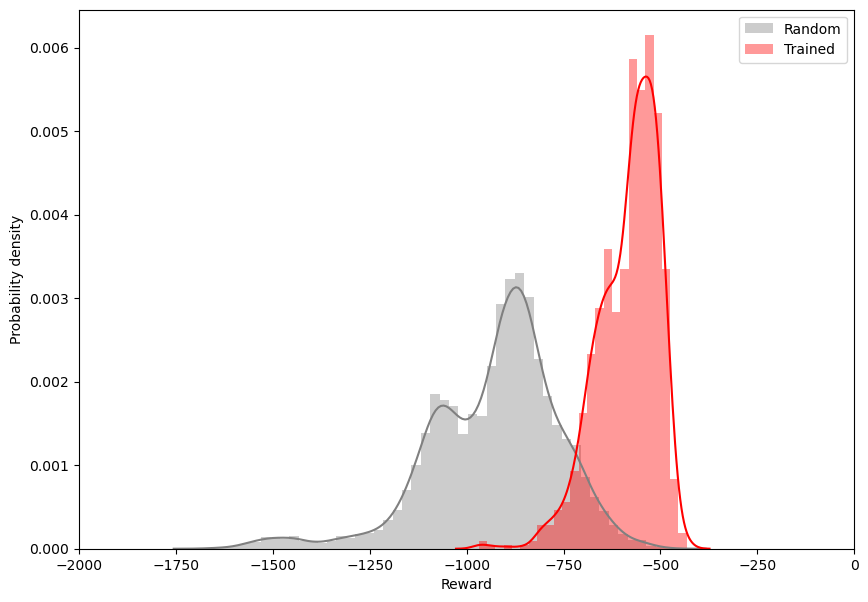

In [18]:
# Plot distribution of final rewards by random vs trained policy
plt.figure(figsize=(10,7))
sns.distplot(final_rewards_random, hist = True, norm_hist = True, label = 'Random', color = 'grey')
sns.distplot(final_rewards_trained, hist = True, norm_hist = True, label = 'Trained', color = 'red')
plt.ylabel('Probability density')
plt.xlabel('Reward')
# plt.ylim(0,0.0025)
plt.xlim(-2000,0)
plt.legend()
# plt.savefig(fname = 'plots/reward_dist_500iter_RF.png', dpi = 300)
plt.show()

### Evolution of final rewards with iteration

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


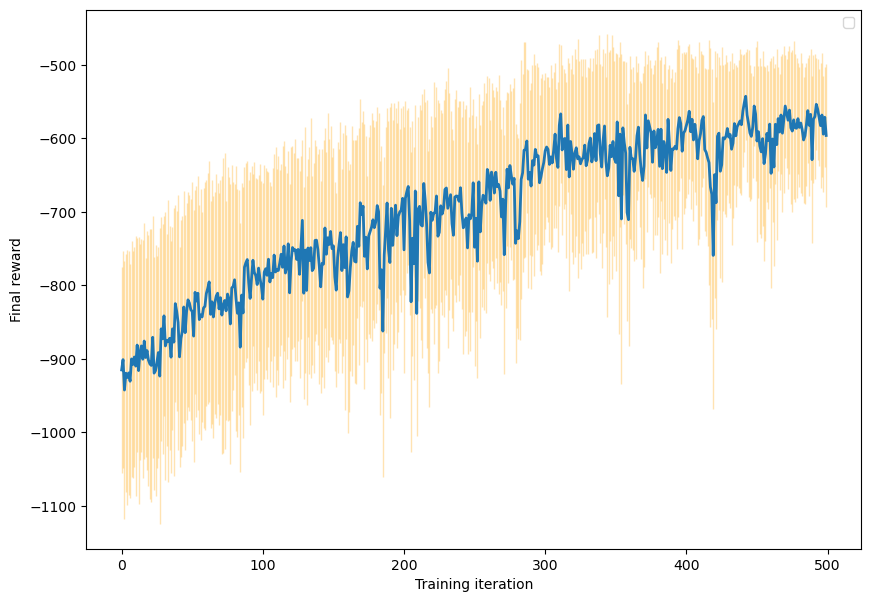

In [36]:
with open('./training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)
num_iter = 500
final_rewards_mean = [x.mean() for x in final_rewards_vs_iter]
final_rewards_std  = [x.std() for x in final_rewards_vs_iter]
plt.figure(figsize=(10,7))
markers, caps, bars = plt.errorbar(range(num_iter), final_rewards_mean, yerr = final_rewards_std, mfc= 'blue', linewidth = 2, elinewidth= 1)
[bar.set_alpha(0.3) for bar in bars]
[bar.set_color('orange') for bar in bars]
plt.ylabel('Final reward')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/reward_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Evolution of compounds with iteration

In [2]:
# with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
#     compounds_vs_iter = pickle.load(f)

# # FEATURIZE GENERATED COMPOUNDS
# for iteration in tqdm(range(len(compounds_vs_iter))): # For each iteration of compounds
#     for idx in range(len(compounds_vs_iter[iteration])): # For each compound
#         compounds_vs_iter[iteration][idx] = featurize_target(compounds_vs_iter[iteration][idx]) # Featurize using Magpie embeddings

# # Save featurized compounds
# with open('./training_data/compound_features_vs_iter_RF.pkl', 'wb') as f:
#         pickle.dump(compounds_vs_iter, f, pickle.HIGHEST_PROTOCOL)

In [28]:
# Load compound features
with open('./training_data/compound_features_vs_iter_RF.pkl', 'rb') as f:
    compound_features_vs_iter = pickle.load(f)

In [29]:
len(compound_features_vs_iter)

500

Standarizing data before PCA is important.

In [30]:
# Load scalar
scaler = StandardScaler() # Fit scaler
scaler.fit(s_material_inputs)

# Convert each compound features from list to np.array
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        compound_features_vs_iter[iteration][idx] = scaler.transform(np.array([compound_features_vs_iter[iteration][idx]]))[0] # Featurize using Magpie embeddings

100%|██████████| 500/500 [00:02<00:00, 243.93it/s]


In [32]:
features = [] # 500 x np.array() of shape 100 x 145 (100 is no of compounds per iteration, 145 is the feature size)
for iteration in tqdm(range(len(compound_features_vs_iter))): # For each iteration of compounds
    iteration_stack = []
    for idx in range(len(compound_features_vs_iter[iteration])): # For each compound
        iteration_stack.append(compound_features_vs_iter[iteration][idx])
    iteration_stack = np.stack(iteration_stack)
    features.append(iteration_stack)

100%|██████████| 500/500 [00:00<00:00, 6695.70it/s]


In [33]:
# Stack features into one big matrix
full_stack = [] 
for iteration in features:
    full_stack.append(iteration)
full_stack = np.vstack(full_stack)

### Dimensionality reduction using t-SNE

In [69]:
# Perform t-SNE
tsne_embeddings = TSNE(n_components = 2, 
                       perplexity = 30,
                       learning_rate='auto',
                       init='random' # random/pca initialization
                       ).fit_transform(full_stack)

# with open('training_data/tsne_embeddings_500iter_RF.npy', 'wb') as f:
#     np.save(f, tsne_embeddings)

In [97]:
# Load t-SNE embeddings
with open('training_data/tsne_embeddings_500iter_RF.npy', 'rb') as f:
    tsne_embeddings = np.load(f)

with open('./training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)

final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
print('tsne_embeddings: ', tsne_embeddings.shape)
print('final_rewards:', final_rewards.shape)

tsne_embeddings:  (50000, 2)
final_rewards: torch.Size([50000])


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


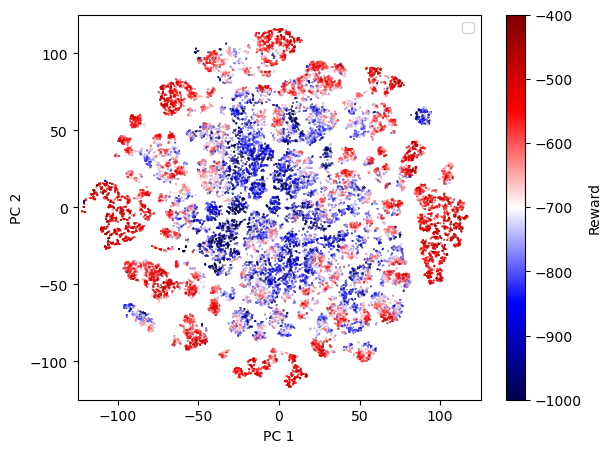

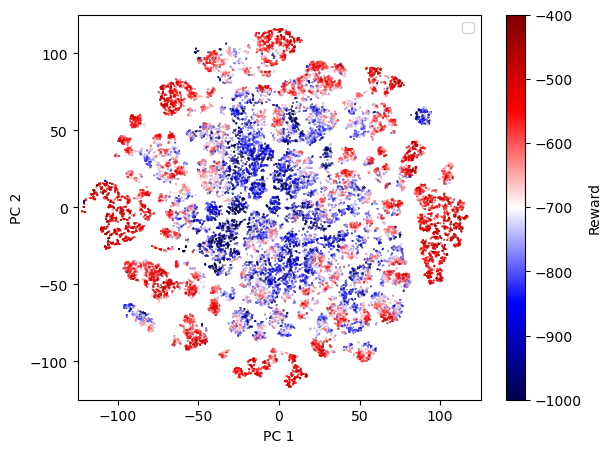

In [98]:
# Generate list of iterations for 50k compounds
iteration = []
for i in range(500):
    for j in range(100):
        iteration.append(i)
# Plot TSNE
def plot_TSNE(train_iter = None):
    fig = plt.figure(figsize=(6.5,5))
    if train_iter == None:
        plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = final_rewards, cmap = 'seismic') # For rewards
        # plt.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], s = 0.05, alpha = 1, c = iteration, cmap = 'seismic') # For iteration
    else:
        row_idx = range(100*train_iter,(100*train_iter)+100)
        rewards = final_rewards_vs_iter[train_iter]
        plt.scatter(tsne_embeddings[row_idx,0], tsne_embeddings[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
    plt.ylabel('PC 2')
    plt.xlabel('PC 1')
    plt.ylim(-125, 125)
    plt.xlim(-125, 125)
    plt.legend()
    # plt.text(20,100,'Iteration %.0f' % train_iter, fontsize = 15)
    cbar = plt.colorbar()
    cbar.set_label('Reward')
    # cbar.set_label('Iteration')
    plt.clim(-1000,-400) 
    # plt.savefig(fname = 'plots/TSNE_vs_iter_500iter_RF.png', dpi = 300) 
    plt.show()
    return fig
plot_TSNE()

In [ ]:
images = []  # For saving into gif

for i in range(0, 600, 1): # For stalling the last frame
    j = i
    if i > 499: # For stalling the last frame
        j = 499
    fig = plot_TSNE(train_iter = j)
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/TSNE_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Dimensionality reduction using singular value decomposition (SVD)

In [66]:
# Perform SVD
u, s, vh = np.linalg.svd(full_stack, full_matrices=True)

# with open('training_data/SVD_embeddings_500iter_RF.npy', 'wb') as f:
#     np.save(f, u)

In [67]:
# Load SVD embeddings
with open('training_data/SVD_embeddings_500iter_RF.npy', 'rb') as f:
    u = np.load(f)

with open('training_data/final_rewards_vs_iter_RF.pkl', 'rb') as f:
    final_rewards_vs_iter = pickle.load(f)

final_rewards_vs_iter_stacked = torch.stack(final_rewards_vs_iter)
final_rewards = final_rewards_vs_iter_stacked.reshape(-1)
print('SVD_embeddings: ', u.shape)
print('final_rewards:', final_rewards.shape)

u_truncated = u[:, :2]
print('SVD_embeddings after truncation:', u_truncated.shape)

SVD_embeddings:  (50000, 50000)
final_rewards: torch.Size([50000])
SVD_embeddings after truncation: (50000, 2)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


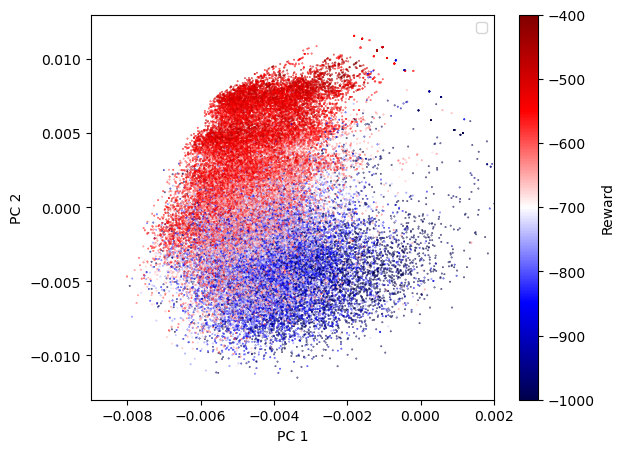

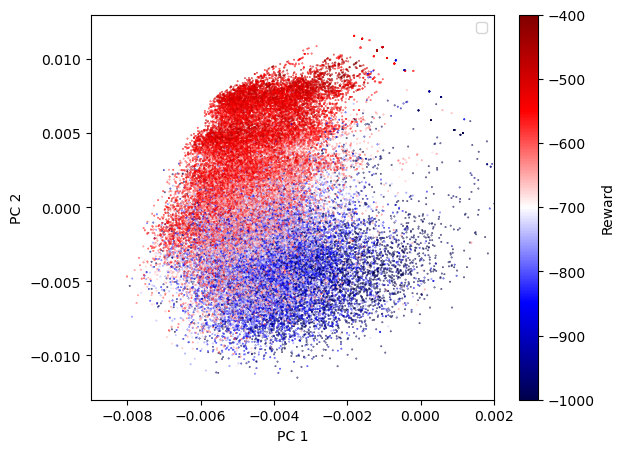

In [99]:
iteration = []
for i in range(500):
    for j in range(100):
        iteration.append(i)

# Plot SVD
def plot_SVD(train_iter = None):
    fig = plt.figure(figsize=(6.5,5))
    if train_iter == None:
        plt.scatter(u_truncated[:,0], u_truncated[:,1], c = final_rewards, s = 0.1, cmap = 'seismic') # For rewards
        # plt.scatter(u_truncated[:,0], u_truncated[:,1], c = iteration, s = 0.1, cmap = 'seismic') # For iterations
    else:
        row_idx = range(100*train_iter,(100*train_iter)+100)
        rewards = final_rewards_vs_iter[train_iter]
        plt.scatter(u_truncated[row_idx,0], u_truncated[row_idx,1], c = rewards, s = 5, cmap = 'seismic')
    plt.ylabel('PC 2')
    plt.xlabel('PC 1')
    plt.ylim(-0.013, 0.013)
    plt.xlim(-0.009, .002)
    plt.legend()
    # plt.text(-0.002,0.010,'Iteration %.0f' % train_iter, fontsize = 15)
    cbar = plt.colorbar()
    plt.clim(-1000,-400)  
    # cbar.set_label('Iteration')
    cbar.set_label('Reward')
    # plt.savefig(fname = 'plots/SVD_reward_vs_iter_500iter_RF.png', dpi = 300)
    plt.show()
    return fig
plot_SVD()

In [ ]:
images = []  # For saving into gif

for i in range(0, 600, 1): # For stalling the last frame
    j = i
    if i > 499: # For stalling the last frame
        j = 499
    fig = plot_SVD(train_iter = j)
    # Used to return the plot as an image array 
    # (https://ndres.me/post/matplotlib-animated-gifs-easily/)
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    images.append(image)
imageio.mimsave('plots/SVD_reward_vs_iter_500iter_RF.gif', images, fps = 30)

### Charge neutrality of generated compounds
From this point onwards, we start using dqn2 environment

In [36]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)
compounds = compounds_vs_iter[0]

def check_neutrality_multiple(compounds):
    '''
    Args: 
    compounds: List (of str) of compounds
    
    Returns:
    good: List of compounds that can be charge neutral
    bad: List of compounds that cannot be charge neutral
    '''
    good = []
    bad  = [] 
    for compound in compounds:
        try:
            if check_neutrality(Composition(compound)): # If neutral
                good.append(compound)
            else:
                bad.append(compound)
        except Exception:
            print('Compound not valid')
    return good, bad

good, bad = check_neutrality_multiple(compounds = compounds)
len(good), len(bad)

(45, 55)

In [37]:
# Check charge neutrality
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    good, bad = check_neutrality_multiple(compounds = compounds)
    good_vs_iter.append(len(good))
    bad_vs_iter.append(len(bad))

cn_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/cn_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, cn_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [41]:
# Load charge neutrality
with open('training_data/cn_good_ratio_500iter_RF.npy', 'rb') as f:
    cn_good_ratio = np.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


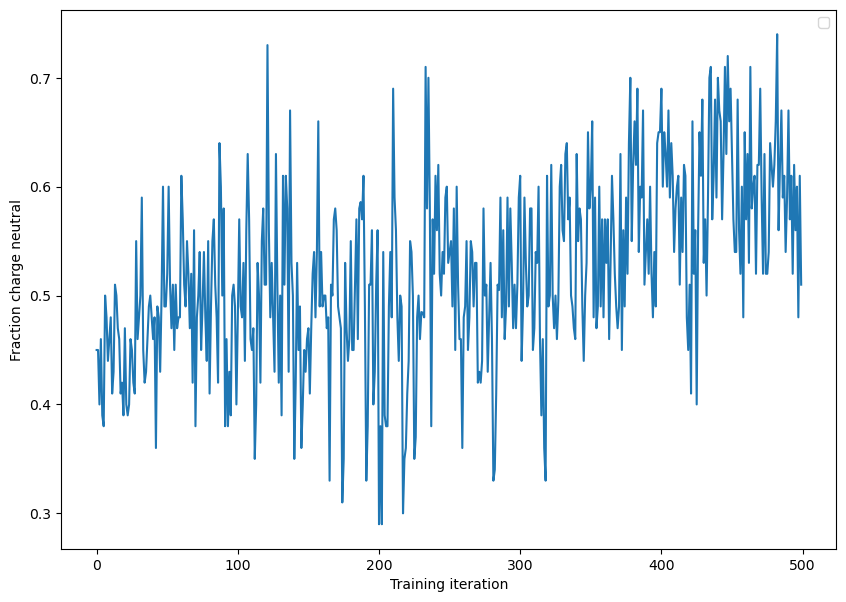

In [42]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), cn_good_ratio)
plt.ylabel('Fraction charge neutral')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/cn_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Electronegativity of generated compounds

In [58]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)
compounds = compounds_vs_iter[0]

def check_electronegativity_multiple(compounds):
    '''
    Args: 
    compounds: List (of str) of compounds
    
    Returns:
    good: List of compounds that have acceptable electronegativity
    bad: List of compounds that do not have acceptable electronegativity
    '''
    good = []
    bad  = [] 
    for compound in compounds:
        try:
            if check_electronegativity(compound): # If neutral
                good.append(compound)
            else:
                bad.append(compound)
        except Exception:
            print('Compound not valid')
    return good, bad

good, bad = check_electronegativity_multiple(compounds = compounds)
len(good), len(bad)

(28, 72)

In [21]:
# Check electronegativity
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    good, bad = check_electronegativity_multiple(compounds = compounds)
    good_vs_iter.append(len(good))
    bad_vs_iter.append(len(bad))

en_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/en_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, en_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [31]:
# Load electronegativity
with open('training_data/en_good_ratio_500iter_RF.npy', 'rb') as f:
    en_good_ratio = np.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


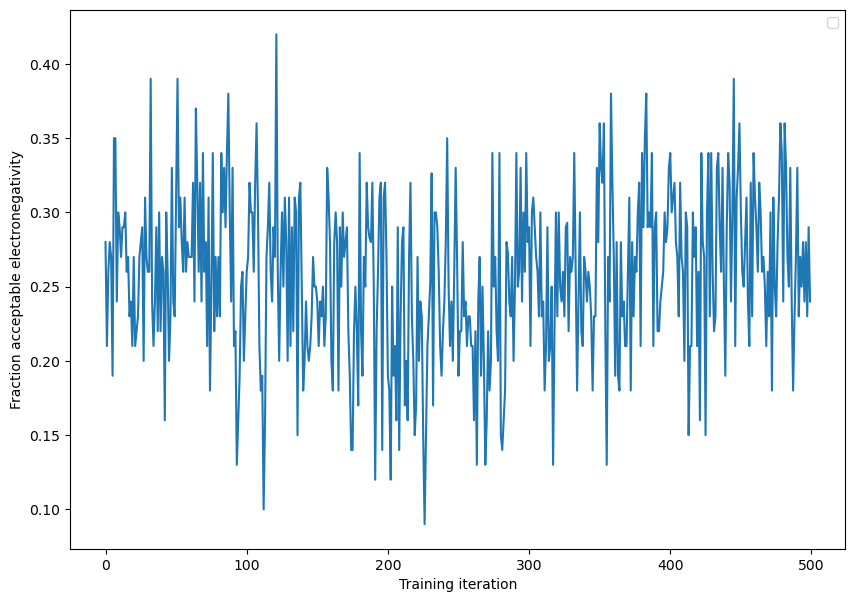

In [34]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), en_good_ratio)
plt.ylabel('Fraction acceptable electronegativity')
plt.xlabel('Training iteration')
plt.legend()
# plt.savefig(fname = 'plots/en_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Check both charge neutrality and electronegativity

In [2]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)

In [49]:
# Efficient way
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    cn_good, cn_bad = check_neutrality_multiple(compounds = compounds)
    both_good, bad = check_electronegativity_multiple(compounds = cn_good)

    good_vs_iter.append(len(both_good))
    bad_vs_iter.append(len(cn_bad)+len(bad))

both_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/both_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, both_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [4]:
# Inefficient way - To double check
def check_both_multiple(compounds):
    '''
    Args: 
    compounds: List (of str) of compounds
    
    Returns:
    good: List of compounds that can be both charge neutral and have acceptable electronegativity
    bad: List of compounds that fails either one of the checks
    '''
    good = []
    bad  = [] 
    for compound in compounds:
        try:
            if check_electronegativity(compound) and check_neutrality(Composition(compound)): # If both
                good.append(compound)
            else:
                bad.append(compound)
        except Exception:
            print('Compound not valid')
    return good, bad
# compounds = compounds_vs_iter[0]
# good, bad = check_both_multiple(compounds = compounds)

# Inefficient way - To double check
good_vs_iter = []
bad_vs_iter  = []
for compounds in compounds_vs_iter:
    good, bad = check_both_multiple(compounds = compounds)
    good_vs_iter.append(len(good))
    bad_vs_iter.append(len(bad))

both_good_ratio = np.array(good_vs_iter)/(np.array(good_vs_iter)+np.array(bad_vs_iter))

# with open('training_data/both_good_ratio_500iter_RF.npy', 'wb') as f:
#     np.save(f, both_good_ratio)

Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid
Compound not valid


In [9]:
# Load both
with open('training_data/both_good_ratio_500iter_RF.npy', 'rb') as f:
    both_good_ratio = np.load(f)

# Load electronegativity
with open('training_data/en_good_ratio_500iter_RF.npy', 'rb') as f:
    en_good_ratio = np.load(f)

# Load charge neutrality
with open('training_data/cn_good_ratio_500iter_RF.npy', 'rb') as f:
    cn_good_ratio = np.load(f)

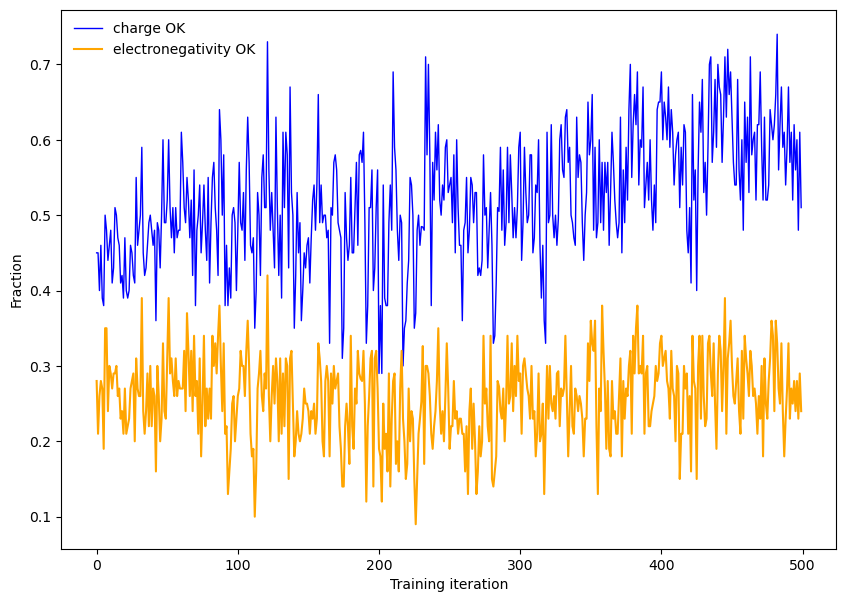

In [20]:
num_iter = len(compounds_vs_iter)
plt.figure(figsize=(10,7))
plt.plot(range(num_iter), cn_good_ratio, label = 'charge OK', color = 'blue', linewidth = 1)
plt.plot(range(num_iter), en_good_ratio, label = 'electronegativity OK', color = 'orange')
# plt.plot(range(num_iter), both_good_ratio, label = 'both OK')
plt.ylabel('Fraction')
plt.xlabel('Training iteration')
plt.legend(frameon= False)
# plt.savefig(fname = 'plots/both_vs_iter_500iter_RF.png', dpi = 300)
plt.show()

### Look at generated compounds

In [48]:
# Load RF prediction model
rf_regr = RandomForestRegressor()
rf_regr = joblib.load("rf_models/rf_sinter_predict_no_imputation_no_precursors.joblib")

# Featurization for RF model
feature_calculators = MultipleFeaturizer([
    cf.element.Stoichiometry(),
    cf.composite.ElementProperty.from_preset("magpie"),
    cf.orbital.ValenceOrbital(props=["avg"]),
    cf.ion.IonProperty(fast=True)
])

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/sklearn/base.py:324: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.23.2 when using version 1.0.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Compound: Er4Cd2Sn7Ge7I3         Sinter T: 590
Compound: Sr8Cu4Ge5(As3Pb2)3     Sinter T: 664
Compound: In9Bi5Te8As3Au8        Sinter T: 538
Compound: In4Ga2Ag3Sb5           Sinter T: 542
Compound: In8Ag3(SnBi)9          Sinter T: 548
Compound: Ag3SbAs4Au8I9          Sinter T: 635
Compound: Cd4Ge(PbBr6)2          Sinter T: 604
Compound: Zn9Bi5Sb7Ir2           Sinter T: 625
Compound: Tl4Bi8P4PbSe9          Sinter T: 500
Compound: Tl3Zn3Sn4Ge7Sb         Sinter T: 547
Compound: Ge11Bi5(PbSe)9         Sinter T: 495
Compound: GaBi4Sb6P9Se           Sinter T: 517
Compound: Zn4Cd2Ge3Br7           Sinter T: 702
Compound: Er4ReNi9Te4Pb          Sinter T: 769
Compound: Zn7Sn8Te15             Sinter T: 490
Compound: Tl4Ag5As7Br6           Sinter T: 566
Compound: Ag4Bi3As7              Sinter T: 568
Compound: Ag8Ge7(PSe4)2          Sinter T: 558
Compound: Ga8Ag2Ge7Bi7Se         Sinter T: 534
Compound: Zn7Ag2Sn3PbBr7         Sinter T: 669
Compound: Er8Ag2Ge8Te4Pb9        Sinter T: 591
Compound: ZnA

/home/synthesisproject/anaconda3/envs/dqn2/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


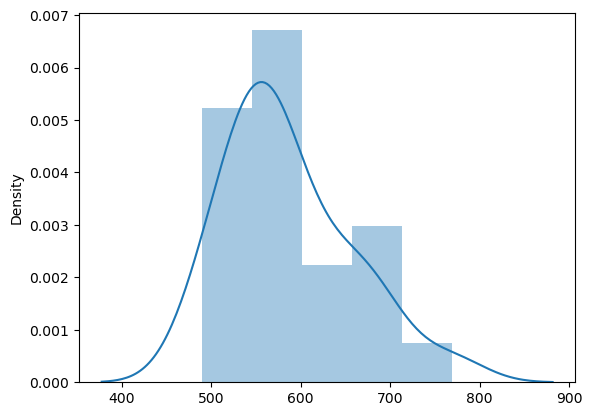

In [105]:
# Predict sintering T of valid compounds
max_len = 0
good_sinter_T = []
for compound in good:
    chemical = Composition(compound)
    features = feature_calculators.featurize(chemical)
    features = np.array(features).reshape(1, -1)
    # print(features)
    sinter_T_pred = rf_regr.predict(features)[0]
    good_sinter_T.append(sinter_T_pred)
    compound = Composition(compound).reduced_formula
    print('Compound:', compound, (18-len(compound)+3)*' ','Sinter T:', round(sinter_T_pred))

plt.figure()
sns.distplot(good_sinter_T)
plt.show()

### Diversity of generated compounds

In [78]:
with open('./training_data/compounds_vs_iter_RF.pkl', 'rb') as f:
    compounds_vs_iter = pickle.load(f)

In [90]:
compounds = compounds_vs_iter[499]
for idx in range(len(compounds)):
    compounds[idx] = Composition(compounds[idx]).reduced_formula

# len(set(compounds))
check_both_multiple(compounds)[0]

['Rb4Cd4CuSn4',
 'Er4Cd2Sn7Ge7I3',
 'Sr8Cu4Ge5(As3Pb2)3',
 'Cd2Sn2Bi3IrI2',
 'In9Bi5Te8As3Au8',
 'In4Ga2Ag3Sb5',
 'ZnGa7Ge3Te',
 'In8Ag3(SnBi)9',
 'Ag3SbAs4Au8I9',
 'Cd4Ge(PbBr6)2',
 'Zn9Bi5Sb7Ir2',
 'Tl4Bi8P4PbSe9',
 'Tl3Zn3Sn4Ge7Sb',
 'Ge11Bi5(PbSe)9',
 'GaBi4Sb6P9Se',
 'Zn4Cd2Ge3Br7',
 'Er4ReNi9Te4Pb',
 'Zn7Sn8Te15',
 'Tl4Ag5As7Br6',
 'Er2Zn2AgSn2',
 'Ag4Bi3As7',
 'Ag8Ge7(PSe4)2',
 'Ga8Ag2Ge7Bi7Se',
 'Zn7Ag2Sn3PbBr7',
 'Er8Ag2Ge8Te4Pb9',
 'ZnAg2Sn8(Ge3P2)2',
 'Tl2Ag8As5P9',
 'Cu8GeTe5(As4P)2']